# 📘 **Master's Thesis: The Differential Market Impact of ECB Communication Tone Across Channels** 
**Author:** Shreyas Urgunde  
**Course:** MSc Finance (Warwick Business School)  
**Objective:** Measure market response to ECB communication tone across all channels.  
**Period:** 2015-2024  
**Data Sources:** Bloomberg, EA-CED, BIS, ECB Open Data Portal and EA-MPD.

---


**Table of Contents**
1. [Setup](#Setup)
2. [Scraping the ECB Monetary Policy Communication Data](#scraping-the-ecb-monetary-policy-communication-data)
    - 2.1 [Monetary Policy Decision Data](#monetary-policy-decision-data)
    - 2.2 [Monetary Policy Press Conferences Data](#monetary-policy-press-conferences-data)
    - 2.3 [Monetary Policy Accounts Data](#Monetary-Policy-Accounts-Data)
    - 2.4 [Monetary Policy Speeches]()
3. [Sentiment Analysis and Hawk–Dove index](#sentiment-analysis-and-hawk-dove-index)
    - 3.1 [Monetary Policy Decision](#moneatry-policy-decisions-tone-index)
    - 3.2 [Monetary Policy Press Conferences](#create-dictionaries-and-cleaning-press-conferences-data)
    - 3.3 [Monetary Policy Accounts](#tone-indices-for-monetary-policy-accounts)
    - 3.4 [Monetary Policy Speeches](#monetary-policy-speeches-by-executive-board-members)

4. [Empirical Framework and Results](#new-methodology)
    - 4.1 [Principal Component Analysis for Factor Decompositions](#principal-component-analsysis-for-controls-mpd-and-press-conferences)
    - 4.2 [Intraday Regression Analysis](#intraday-results)
    - 4.3 [Daily Regression Analysis](#daily-frequency-regression-analysis)
    - 4.4 [Hypothesis Testing](#Hypothses-Tests) 
5. [Robustness Checks](#robustness-checks)
    - 5.1 [Sub Sample Analysis](#sub-sample-analysis)
    - 5.2 [Alternative Dictionaries](#alternate-dictionary)
    - 5.3 [Orthogonalising the Tone](#robustness-check-3-orthogonalised-tone)


## **Setup**

In [1]:
# ====== Import Required Packages ======
!pip install requests beautifulsoup4 tqdm
import os
import re
import json
import time
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Ensure plots appear inline in notebooks
%matplotlib inline


## **Scraping the ECB Monetary Policy Communication Data**

### **Monetary Policy Decision Data**

In [2]:
import os, re, time, hashlib
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from tqdm import tqdm

# ----------- STEP 0: Setup -----------
TEXT_DIR = "data/text/decisions"
HTML_DIR = "data/html/decisions"
os.makedirs(TEXT_DIR, exist_ok=True)
os.makedirs(HTML_DIR, exist_ok=True)

HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; ResearchBot/1.0; +https://yourdomain.example)",
    "Accept-Language": "en;q=0.9"
}
TIMEOUT = 25
MAX_RETRIES = 3
BACKOFF_SEC = 1.5

# ----------- STEP 1: Links (your list) -----------
decision_links = [
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp241212~2acab6e51e.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp241017~aa366eaf20.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp240912~67cb23badb.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp240718~b9e0ddd9d5.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp240606~2148ecdb3c.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp240411~1345644915.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp240307~a5fa52b82b.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2024/html/ecb.mp240125~f738889bde.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp231214~9846e62f62.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp231026~6028cea576.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp230914~aab39f8c21.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp230727~da80cfcf24.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp230615~d34cddb4c6.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp230504~cdfd11a697.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp230316~aad5249f30.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2023/html/ecb.mp230202~08a972ac76.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp221215~f3461d7b6e.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp221027~df1d778b84.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp220908~c1b6839378.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp220721~53e5bdd317.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp220609~122666c272.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp220414~d1b76520c6.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp220310~2d19f8ba60.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2022/html/ecb.mp220203~90fbe94662.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp211216~1b6d3a1fd8.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp211028~85474438a4.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp210909~2c94b35639.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp210722~48dc3b436b.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp210610~b4d5381df0.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp210422~f075ebe1f0.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp210311~35ba71f535.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.mp210121~eb9154682e.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp201210~8c2778b843.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp201029~4392a355f4.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp200910~f4a8da495e.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp200716~fc5fbe06d9.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp200604~a307d3429c.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.pr200430_1~477f400e39.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.pr200430~fa46f38486.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp200430~1eaa128265.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.pr200318_1~3949d6f266.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp200312~8d3aec3ff2.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2020/html/ecb.mp200123~ae33d37f6e.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp191212~06d84240ae.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp191024~438769bd4f.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp190912~08de50b4d2.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp190725~52d3766c9e.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp190606~1876cad9a5.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp190410~3df2ed8a4c.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp190307~7d8a9d2665.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.mp190124~5c00d09d5d.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp181213.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp181025.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp180913.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp180726.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp180614.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp180426.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp180308.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2018/html/ecb.mp180125.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/ecb.mp171214.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/ecb.mp171026.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/ecb.mp170907.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/ecb.mp170720.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/ecb.mp170608.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/ecb.mp170427.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/pr170309.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2017/html/pr170119.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr161208.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr161020.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr160908.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr160721.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr160602.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr160421.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr160310.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2016/html/pr160121.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr151203.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr151022.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr150903.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr150716.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr150603.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr150415.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr150305.en.html",
    "https://www.ecb.europa.eu/press/pr/date/2015/html/pr150122.en.html",
]

# ----------- STEP 2: Helpers -----------
DATE_PAT = re.compile(r'(\d{6})')  # YYMMDD anywhere in URL

# Exact three COVID emergency PRs you want flagged (whitelist by slug):
COVID_EMERGENCY_URL_SNIPPETS = {
    "ecb.pr200318_1",  # PEPP announcement (2020-03-18)
    "ecb.pr200430",    # 2020-04-30 PR
    "ecb.pr200430_1",  # 2020-04-30 second PR
}

def sha1(b: bytes) -> str:
    return hashlib.sha1(b).hexdigest()

def fetch(url: str):
    err = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            r = requests.get(url, headers=HEADERS, timeout=TIMEOUT)
            r.raise_for_status()
            return r
        except Exception as e:
            err = e
            time.sleep(BACKOFF_SEC * attempt)
    raise err

def parse_date_from_url(url: str):
    m = DATE_PAT.search(url)
    if not m: 
        return None
    try:
        return datetime.strptime(m.group(1), "%y%m%d").date()
    except Exception:
        return None

def parse_date_from_dom(soup: BeautifulSoup):
    # Conservative: look for <time datetime="YYYY-MM-DD"> or meta[name=date]
    t = soup.find("time")
    if t and t.has_attr("datetime"):
        try:
            return datetime.fromisoformat(t["datetime"][:10]).date()
        except Exception:
            pass
    meta_date = soup.find("meta", {"name": "date"})
    if meta_date and meta_date.get("content"):
        try:
            return datetime.fromisoformat(meta_date["content"][:10]).date()
        except Exception:
            pass
    # Fallback: scan for ISO date string
    text = soup.get_text(" ", strip=True)
    m = re.search(r"\b(20\d{2}-\d{2}-\d{2})\b", text)
    if m:
        try:
            return datetime.strptime(m.group(1), "%Y-%m-%d").date()
        except Exception:
            pass
    return None

def clean_text(soup: BeautifulSoup):
    node = soup.find("main") or soup.find("article") or soup
    for tag in node.find_all(["script", "style", "noscript", "nav", "footer", "header"]):
        tag.decompose()
    return node.get_text(separator="\n", strip=True)

def is_covid_emergency_url(url: str) -> int:
    u = url.lower()
    return int(any(snippet in u for snippet in COVID_EMERGENCY_URL_SNIPPETS))

def is_mpd_headline(title: str) -> int:
    t = (title or "").lower()
    return int(("monetary policy decision" in t) or ("monetary policy decisions" in t))

# ----------- STEP 3: Scrape -----------
records, failures = [], []

for url in tqdm(decision_links, desc="Downloading ECB Monetary Policy Decisions"):
    try:
        resp = fetch(url)
        html = resp.content
        soup = BeautifulSoup(html, "html.parser")

        title = soup.find("title").get_text(strip=True) if soup.find("title") else "No Title"
        lang = soup.html.get("lang", "").lower() if soup.html else ""

        # Parse date from URL first, then DOM
        d_url = parse_date_from_url(url)
        d_dom = parse_date_from_dom(soup)
        parsed_date = d_url or d_dom

        # Build a temporary core (we will rename after sequencing)
        core_tmp = parsed_date.isoformat() if parsed_date else f"unknown_{sha1(url.encode())[:8]}"

        # Save HTML and cleaned text
        html_path = os.path.join(HTML_DIR, f"decision_{core_tmp}.html")
        with open(html_path, "wb") as f:
            f.write(html)

        text_content = clean_text(soup)
        txt_path = os.path.join(TEXT_DIR, f"decision_{core_tmp}.txt")
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(text_content)

        records.append({
            "date": parsed_date.isoformat() if parsed_date else None,
            "title": title,
            "url": url,
            "filename_text": os.path.basename(txt_path),
            "filename_html": os.path.basename(html_path),
            "lang": lang,
            # comment next line if you don't want the integrity fingerprint:
            "sha1_html": sha1(html),
            "n_chars": len(text_content),
            "is_mpd_headline": is_mpd_headline(title),
            "is_emergency": is_covid_emergency_url(url),  # EXACTLY the 3 whitelisted URLs
        })

    except Exception as e:
        failures.append({"url": url, "error": str(e)})

# ----------- STEP 4: Sequence & Event IDs (no time, just same-day order) -----------
df = pd.DataFrame(records)

# Keep rows even if date is None; create sort key by (date, title, url)
df["_date"] = pd.to_datetime(df["date"], errors="coerce")
df["_day"] = df["_date"].dt.date
df["_order_key"] = df["title"].fillna("") + "_" + df["url"].fillna("")
df = df.sort_values(["_day", "_order_key"]).reset_index(drop=True)

# Same-day sequence (0,1,2,...)
df["seq_same_day"] = df.groupby("_day").cumcount()

# Event ID: <YYYY-MM-DD>_MPD_<seq>
def build_event_id(row):
    if pd.isna(row["_date"]):
        core = "unknown"
    else:
        core = row["_date"].strftime("%Y-%m-%d")
    return f"{core}_MPD_{int(row['seq_same_day']):02d}"

df["event_id"] = df.apply(build_event_id, axis=1)

# Rename files to include event_id
def safe_rename(dirpath, old_name, new_stub):
    old_path = os.path.join(dirpath, old_name)
    base, ext = os.path.splitext(old_name)
    new_name = f"decision_{new_stub}{ext}"
    new_path = os.path.join(dirpath, new_name)
    try:
        os.replace(old_path, new_path)
        return new_name
    except Exception:
        return old_name

df["filename_text"] = [
    safe_rename(TEXT_DIR, fn, eid) for fn, eid in zip(df["filename_text"], df["event_id"])
]
df["filename_html"] = [
    safe_rename(HTML_DIR, fn, eid) for fn, eid in zip(df["filename_html"], df["event_id"])
]

# ----------- STEP 5: Save metadata & failures -----------
meta_cols = [
    "event_id","date","seq_same_day","is_emergency","is_mpd_headline",
    "title","url","filename_text","filename_html","lang","n_chars","sha1_html"
]

df_out = df[meta_cols].copy()
meta_path = os.path.join(TEXT_DIR, "decision_metadata.csv")
df_out.to_csv(meta_path, index=False, encoding="utf-8")
print(f"\n✅ Finished! {len(df_out)} decisions saved. Metadata: {meta_path}")

if failures:
    fail_path = os.path.join(TEXT_DIR, "failed_scrapes.csv")
    pd.DataFrame(failures).to_csv(fail_path, index=False, encoding="utf-8")
    print(f"⚠️ {len(failures)} links failed. See {fail_path}")



✅ Finished! 83 decisions saved. Metadata: data/text/decisions\decision_metadata.csv


### **Monetary Policy Press Conferences Data**

In [3]:
# ========== STEP 1: Setup ==========
output_dir = "data/text/statements"
os.makedirs(output_dir, exist_ok=True)

# ========== STEP 2: Full List of 86 ECB Monetary Policy Statement Links ==========
statement_links = [
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2025/html/ecb.is250724~a66e730494.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2025/html/ecb.is250605~f00a36ef2b.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2025/html/ecb.is250417~091c625eb6.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2025/html/ecb.is250306~4307bd0941.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2025/html/ecb.is250130~1f418aa0f4.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is241212~ce143b3bc8.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is241017~59ad385bab.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is240912~4f7b17040c.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is240718~6600b4add6.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is240606~d32cd6cc8a.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is240411~9974984b58.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is240307~314650bd5c.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2024/html/ecb.is240125~db0f145c32.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is231214~df8627de60.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is231026~c23b4eb5f0.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is230914~686786984a.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is230727~e0a11feb2e.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is230615~3de9d68335.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is230504~f242392c72.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is230316~6c10b087b5.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2023/html/ecb.is230202~4313651089.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is221215~197ac630ae.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is221027~358a06a35f.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is220908~cd8363c58e.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is220721~51ef267c68.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is220609~abe7c95b19.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is220414~fa5c8fe142.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is220310~1bc8c1b1ca.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2022/html/ecb.is220203~ca7001dec0.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is211216~9abaace28e.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is211028~939f22970b.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is210909~b2d882f724.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is210722~13e7f5e795.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.sp210708~ab68c3bd9d.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is210610~115f4c0246.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is210422~b0ad2d3414.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is210311~d368d7151a.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2021/html/ecb.is210121~e601112a72.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is201210~9b8e5f3cdd.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is201029~80b00b5789.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is200910~5c43e3a591.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is200716~3865f74bf8.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is200604~b479b8cfff.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is200430~ab3058e07f.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is200312~f857a21b6c.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2020/html/ecb.is200123~0bc778277b.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is191212~c9e1a6ab3e.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is191024~78a5550bc1.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is190912~658eb51d68.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is190725~547f29c369.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is190606~32b6221806.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is190410~c27197866f.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is190307~de1fdbd0b0.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2019/html/ecb.is190124~cd3821f8f5.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is181213.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is181025.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is180913.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is180726.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is180614.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is180426.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is180308.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2018/html/ecb.is180125.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/ecb.is171214.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/ecb.is171026.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/ecb.is170907.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/ecb.is170720.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/ecb.is170608.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/ecb.is170427.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/is170309.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2017/html/is170119.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is161208.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is161020.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is160908.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is160721.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is160602.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is160421.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is160310.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2016/html/is160121.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is151203.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is151022.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is150903.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is150716.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is150603.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is150415.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is150305.en.html",
    "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/2015/html/is150122.en.html"
]

records = []
failed_records = []

# ========== STEP 3: Scrape Each Statement ==========
for url in tqdm(statement_links, desc="Downloading ECB Statements"):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        content = soup.get_text(separator="\n", strip=True)

        # Check for blank/error pages
        if "Page not found" in content or (soup.title and "Error" in soup.title.string):
            raise Exception("Page indicates error")

        title = soup.find("title").get_text(strip=True) if soup.find("title") else "No Title Found"

        # Try to extract date from URL (6-digit format)
        parsed_date = None
        match = re.search(r'is(\d{6})', url)
        match = re.search(r'(?:is|sp)(\d{6})', url)
        if match:
            try:
                parsed_date = datetime.strptime(match.group(1), "%y%m%d").date()
            except ValueError:
                pass

        # Construct filename
        if parsed_date:
            fname = f"statement_{parsed_date.isoformat()}.txt"
        else:
            fname = f"statement_unknown_{len(records)}.txt"

        filepath = os.path.join(output_dir, fname)
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(content)

        records.append({
            "date": parsed_date,
            "title": title,
            "url": url,
            "filename": fname
        })

    except Exception as e:
        print(f"❌ Error scraping {url}")
        print(f"   Reason: {e}")
        failed_records.append({
            "url": url,
            "error": str(e)
        })
        continue

# ========== STEP 4: Save Metadata ==========

# Build initial dataframe
df = pd.DataFrame(records)

# 🧼 Clean and sort date
df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors='coerce')
df = df[df["date"].notnull()]
df.sort_values("date", inplace=True)
df["date"] = df["date"].dt.strftime("%d-%m-%Y")

# 💾 Save metadata CSV
df.to_csv(os.path.join(output_dir, "statement_metadata.csv"), index=False)
print(f"\n✅ Finished! {len(df)} ECB statements saved successfully.")



✅ Finished! 86 ECB statements saved successfully.


### **Monetary Policy Accounts Data**

In [4]:

# ========== Setup ==========
output_dir = "data/text/accounts"
os.makedirs(output_dir, exist_ok=True)

# Full list of 88 ECB Monetary Policy Account links from 2015–2025
account_links = [
    "https://www.ecb.europa.eu/press/accounts/2025/html/ecb.mg250703~07feaceb60.en.html",
    "https://www.ecb.europa.eu/press/accounts/2025/html/ecb.mg250522~31b2c664d4.en.html",
    "https://www.ecb.europa.eu/press/accounts/2025/html/ecb.mg250403~e578b5dbea.en.html",
    "https://www.ecb.europa.eu/press/accounts/2025/html/ecb.mg250227~5a2b6faa14.en.html",
    "https://www.ecb.europa.eu/press/accounts/2025/html/ecb.mg250116~2f8f2a2ad3.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg241114~c0e6f53cf7.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg241010~1036884a9a.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240822~d49b920824.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240704~fbde4f46aa.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240510~6505e9dac3.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240404~b79e424115.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240222~1af5fcd5f9.en.html",
    "https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240118~57d24ff18f.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231123~40c9631bc7.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231012~2f3d803d32.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230831~b04764f45f.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230713~f7e54fdb87.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230601~9d35f80dee.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230420~e8043d2d3d.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230302~009d06dd5a.en.html",
    "https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230119~e522ad4e37.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg221124~3527764024.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg221006~a5f7fb03f3.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg220825~162cfabae9.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg220707~d5c3246061.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg220519~c9200dba08.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg220407~8e7069ffa0.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg220303~7ac13bacbe.en.html",
    "https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg220120~7ed187b5b1.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg211125~ca9833f9a9.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg211007~1c2f4db595.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210826~16a0691c87.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210729~b83737e3b5.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210709~8d7a056036.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210514~4b2606bff9.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210408~46b9deaa4a.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210218~9dab5cb5f7.en.html",
    "https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210114~14ef04b8bd.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg201126~20e838e857.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg201008~49aeff32e1.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200820~c30e2e26b9.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200625~fd97330d5f.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200522~f0355619ae.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200409_1~baf4b2ad06.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200409~0026941ce4.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200220~c4d71ec138.en.html",
    "https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200116~973b558e59.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg191121~b1d36734d7.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg191010~d8086505d0.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190822~63660ecd81.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190711~16eb146254.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190523~3e19e27fb7.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190404~edc605830b.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190221~0f3dd919fa.en.html",
    "https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190110.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg181122.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg181011.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg180823.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg180712.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg180524.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg180412.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg180222.en.html",
    "https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg180111.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/ecb.mg171123.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/ecb.mg171005.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/ecb.mg170817.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/ecb.mg170706.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/ecb.mg170518.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/mg170406.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/mg170216.en.html",
    "https://www.ecb.europa.eu/press/accounts/2017/html/mg170112.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg161117.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg161006.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg160818.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg160707.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg160519.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg160407.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg160218.en.html",
    "https://www.ecb.europa.eu/press/accounts/2016/html/mg160114.en.html",
    "https://www.ecb.europa.eu/press/accounts/2015/html/mg151119.en.html",
    "https://www.ecb.europa.eu/press/accounts/2015/html/mg151008.en.html",
    "https://www.ecb.europa.eu/press/accounts/2015/html/mg150813.en.html",
    "https://www.ecb.europa.eu/press/accounts/2015/html/mg150702.en.html",
    "https://www.ecb.europa.eu/press/accounts/2015/html/mg150521.en.html",
    "https://www.ecb.europa.eu/press/accounts/2015/html/mg150402.en.html",
    "https://www.ecb.europa.eu/press/accounts/2015/html/mg150219.en.html"
]

records = []
failed_records = []

# ========== Scrape Each Link ==========
for url in tqdm(account_links, desc="Downloading ECB Accounts"):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        content = soup.get_text(separator="\n", strip=True)
        
        title_tag = soup.find("title")
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        # --- MODIFIED BLOCK START ---
        # STEP 2: Use a robust regex to extract the date
        parsed_date = None
        try:
            # Search for the first 6-digit sequence in the URL string
            match = re.search(r'(\d{6})', url)
            if match:
                date_str = match.group(1)
                parsed_date = datetime.strptime(date_str, "%y%m%d").date()
        except (ValueError, IndexError):
            # This will catch errors if the found digits are not a valid date
            print(f"⚠️ Could not parse date from URL: {url}")
            parsed_date = None
        # --- MODIFIED BLOCK END ---

        if parsed_date:
            fname = f"account_{parsed_date.isoformat()}.txt"
        else:
            # This is now a true fallback for unexpected URL formats
            fname = f"account_unknown_{len(records)}.txt"
            
        filepath = os.path.join(output_dir, fname)
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(content)
            
        records.append({
            "date": parsed_date,
            "title": title,
            "url": url,
            "filename": fname
        })
        
    except Exception as e:
        print(f"❌ Error scraping {url}")
        print(f"   Reason: {e}")
        failed_records.append({
            "url": url,
            "error": str(e)
        })
        continue

# ========== Save Metadata ==========
df = pd.DataFrame(records)
if "date" in df.columns:
    df = df[df["date"].notnull()]
    df.sort_values("date", inplace=True)
df.to_csv(os.path.join(output_dir, "account_metadata.csv"), index=False)

print(f"\n✅ Finished! {len(df)} ECB accounts saved successfully.")

# ========== Save Failures (if any) ==========
if failed_records:
    fail_df = pd.DataFrame(failed_records)
    fail_df.to_csv(os.path.join(output_dir, "failed_scrapes.csv"), index=False)
    print(f"\n⚠️ {len(fail_df)} links failed and were saved to failed_scrapes.csv")

❌ Error scraping https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200522~f0355619ae.en.html
   Reason: HTTPSConnectionPool(host='www.ecb.europa.eu', port=443): Max retries exceeded with url: /press/accounts/2020/html/ecb.mg200522~f0355619ae.en.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021ABBFAA150>: Failed to resolve 'www.ecb.europa.eu' ([Errno 11001] getaddrinfo failed)"))


❌ Error scraping https://www.ecb.europa.eu/press/accounts/2018/html/ecb.mg181011.en.html
   Reason: HTTPSConnectionPool(host='www.ecb.europa.eu', port=443): Max retries exceeded with url: /press/accounts/2018/html/ecb.mg181011.en.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021ABC3A83E0>: Failed to resolve 'www.ecb.europa.eu' ([Errno 11001] getaddrinfo failed)"))


❌ Error scraping https://www.ecb.europa.eu/press/accounts/2016/html/mg160407.en.html
   Reason: HTTPSConnectionPool(host='www.ecb.europa.eu', port=443): Max retries exceeded with url: /press/accounts/2016/html/mg160407.en.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021ABC6AAE40>: Failed to resolve 'www.ecb.europa.eu' ([Errno 11001] getaddrinfo failed)"))



✅ Finished! 83 ECB accounts saved successfully.

⚠️ 3 links failed and were saved to failed_scrapes.csv


## **Sentiment Analysis and Hawk Dove index**
---

### Create Dictionaries and Cleaning Press Conferences Data

In [5]:
# ============================================================
# Build ECB-specific dictionaries (Kaminskas & Jurkšas, 2024)
# — drop-in replacement for your previous dictionary block —
#   - keeps the SAME variable names & CSV filenames
#   - safely handles underscored multi-word entries by adding:
#       (i) the original underscore form,
#      (ii) the space form, and
#     (iii) each component token
# ============================================================

import os
import pandas as pd

# --- Setup: ensure output directory exists (unchanged) ---
output_dir = "Dictionaries"
os.makedirs(output_dir, exist_ok=True)

def expand_underscored(words):
    """
    For items like 'macroeconomic_projections', return:
        {'macroeconomic_projections', 'macroeconomic projections',
         'macroeconomic', 'projections'}
    This lets your existing token-based matcher pick up the parts,
    while also preserving the original phrase strings for future use.
    """
    out = set()
    for w in words:
        w = (w or "").strip()
        if not w:
            continue
        out.add(w)
        if "_" in w:
            out.add(w.replace("_", " "))                 # space version
            out.update([p for p in w.split("_") if p])   # individual parts
    return sorted(out)

# ------------------------------------------------------------
# 1) POSITIVE (tone) — from KJ "Positive" list (plus expansions)
# ------------------------------------------------------------
positive_words = [
    # KJ "Positive" lexicon (as seen in your screenshots)
    "better","favourable","favourably","good","grew",
    "grow","growing","grows","high","higher",
    "improve","improved","improvement","improves","improving",
    "increase","increased","increases","increasing","increasingly",
    "large","larger","positive","rise","rises","rising","rose",
    "stable","strengthen","strengthening","strengthens","strong","stronger","strongly",
    "successful","supporting","sustainable","up","upside","upswing","uptick","upward"
]
positive_words = expand_underscored(positive_words)
positive_df = pd.DataFrame(sorted(set(positive_words)), columns=["word"])
positive_df.to_csv(os.path.join(output_dir, "positive_words.csv"), index=False)
print(f"[KJ] Positive words saved: {len(positive_df)}")

# ------------------------------------------------------------
# 2) NEGATIVE (tone) — from KJ "Negative" list (plus expansions)
# ------------------------------------------------------------
negative_words = [
    "adverse","decline","declined","declining","decrease",
    "difficult","downward","end","fall","falling","fell",
    "lack","limited","little","low","lower","negative",
    "reduce","reduced","reduces","reducing","reduction",
    "slide","small","smaller","subdued","vulnerable","weak"
]
negative_words = expand_underscored(negative_words)
negative_df = pd.DataFrame(sorted(set(negative_words)), columns=["word"])
negative_df.to_csv(os.path.join(output_dir, "negative_words.csv"), index=False)
print(f"[KJ] Negative words saved: {len(negative_df)}")

# -------------------------------------------------------------------
# 3) NEUTRAL ECONOMIC (economic terms indicating base/neutral content)
#     — from KJ "Hawkish" economic list (treated as neutral-economic
#       content in the Parle/Tadle scoring logic)
# -------------------------------------------------------------------
neutral_words = [
    "activity","annual_growth","business","confidence","credit","demand","economy",
    "economic_growth","economies","employment","expansion","expectations",
    "financial_conditions","financial_market","financial_markets","financial_system",
    "financial_stability","financing_conditions","firms","gdp","growth",
    "headline_inflation","hicp","income","inflation","inflation_expectations",
    "inflation_rates","interest_rate","interest_rates","investment","job_creation",
    "labour","labour_market","liquidity","loans","macroeconomic_projections",
    "markets","outlook","output","price","prices","private_sector","projection",
    "projections","rate","rates","real_economy","recovery","situation","stability",
    "wage"
]
neutral_words = expand_underscored(neutral_words)
neutral_df = pd.DataFrame(sorted(set(neutral_words)), columns=["word"])
neutral_df.to_csv(os.path.join(output_dir, "neutral_economic.csv"), index=False)
print(f"[KJ] Neutral-economic words saved: {len(neutral_df)}")

# -------------------------------------------------------------------
# 4) PESSIMISTIC ECONOMIC (economic terms indicating downward pressures)
#     — from KJ "Dovish" economic list (plus expansions)
# -------------------------------------------------------------------
pessimistic_words = [
    "app","asset_purchases","balance_sheet","balance_sheets","challenge","challenges",
    "concern","concerns","crises","crisis","fragmentation","issue","issues","loss","losses",
    "problem","problems","programme","purchase","recession","risk","risks","stress",
    "tensions","turbulence","turmoil","uncertainty","uncertainties","unemployment",
    "volatility"
]
pessimistic_words = expand_underscored(pessimistic_words)
pessimistic_df = pd.DataFrame(sorted(set(pessimistic_words)), columns=["word"])
pessimistic_df.to_csv(os.path.join(output_dir, "pessimistic_economic.csv"), index=False)
print(f"[KJ] Pessimistic-economic words saved: {len(pessimistic_df)}")

# ------------------------------------------------------------
# (Optional) tiny provenance note to keep with the exports
# ------------------------------------------------------------
with open(os.path.join(output_dir, "_README_KJ_lexicons.txt"), "w", encoding="utf-8") as f:
    f.write(
        "ECB-specific dictionaries based on Kaminskas & Jurkšas (2024).\n"
        "Scoring follows Parle (2022) / Tadle (2019/2022).\n"
        "Multi-word entries expanded to space forms and component tokens.\n"
    )

print("✅ KJ lexicons written in 'Dictionaries/' (file names unchanged). Re-run the tone pipeline to refresh scores.")


[KJ] Positive words saved: 42
[KJ] Negative words saved: 28
[KJ] Neutral-economic words saved: 84
[KJ] Pessimistic-economic words saved: 38
✅ KJ lexicons written in 'Dictionaries/' (file names unchanged). Re-run the tone pipeline to refresh scores.


### **Preprocessing the Textual Data**

In [6]:
# ---- Step 1: Event text prep (press conferences) ----

import pandas as pd
from pathlib import Path
import re
from unidecode import unidecode

# ---- Paths (adjust if your layout differs) ----
STATEMENTS_DIR = Path("data/text/statements")          # your raw statement .txt files live here
META_CSV        = STATEMENTS_DIR / "statement_metadata.csv"
CLEAN_DIR       = Path("data/interim/pressers_clean")
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# ---- Small helpers ----
def normalize_text(txt: str) -> str:
    """Unicode/whitespace normalization; light cleanup only (keep content intact)."""
    if not isinstance(txt, str):
        return ""
    t = unidecode(txt)                      # normalize accents/dashes
    t = re.sub(r"\r", "\n", t)              # unify newlines
    t = re.sub(r"[ \t]+", " ", t)           # collapse runs of spaces/tabs
    t = re.sub(r"\n{2,}", "\n\n", t)        # limit blank lines
    return t.strip()

def read_text_safe(p: Path) -> str:
    try:
        return p.read_text(encoding="utf-8", errors="ignore")
    except Exception:
        return ""

# ---- Load metadata and find matching files ----
meta = pd.read_csv(META_CSV)
# Try to parse a 'date' column if present; if not, we’ll infer from filename
if "date" in meta.columns:
    meta["date"] = pd.to_datetime(meta["date"], errors="coerce", dayfirst=True)

rows = []
txt_files = sorted(STATEMENTS_DIR.glob("*.txt"))

# Build a lookup by date if filenames are like 'statement_YYYY-MM-DD.txt'
by_name = {p.name: p for p in txt_files}
by_date = {}
for p in txt_files:
    m = re.search(r"(\d{4}-\d{2}-\d{2})", p.name)
    if m:
        by_date[pd.to_datetime(m.group(1)).date()] = p

for _, r in meta.iterrows():
    # Try date-based match first
    src_path = None
    evt_date = None
    if "date" in r and pd.notnull(r["date"]):
        evt_date = pd.to_datetime(r["date"]).date()
        src_path = by_date.get(evt_date)

    # Fallback: try a 'filename' column if you have it in metadata
    if src_path is None and "filename" in meta.columns and isinstance(r["filename"], str):
        src_path = by_name.get(r["filename"])
        # try to parse a date from that filename
        m = re.search(r"(\d{4}-\d{2}-\d{2})", r["filename"])
        if m:
            evt_date = pd.to_datetime(m.group(1)).date()

    if src_path is None or evt_date is None:
        continue  # skip if we can’t match robustly

    raw = read_text_safe(src_path)
    clean = normalize_text(raw)

    # Save cleaned file
    out_name = f"presser_{evt_date.isoformat()}_clean.txt"
    out_path = CLEAN_DIR / out_name
    out_path.write_text(clean, encoding="utf-8")

    # Collect simple stats
    n_chars = len(clean)
    n_words = len(clean.split())

    rows.append({
        "event_date": evt_date,
        "source_file": src_path.name,
        "clean_file": out_name,
        "n_chars": n_chars,
        "n_words": n_words
    })

clean_index = pd.DataFrame(rows).sort_values("event_date").reset_index(drop=True)
OUT_CSV = CLEAN_DIR / "presser_clean_index.csv"
clean_index.to_csv(OUT_CSV, index=False)
clean_index.tail(8)

# ---- Step 2 (Parle-style, sentence-level): stopwords + ECB filler + digits/punct + lower ----
import pandas as pd
from pathlib import Path
import nltk, re
from nltk.corpus import stopwords
from tqdm import tqdm

# Ensure NLTK resources
def ensure_nltk_models():
    for res in ['punkt', 'stopwords']:
        try:
            nltk.data.find(f'tokenizers/{res}' if res=='punkt' else f'corpora/{res}')
        except LookupError:
            nltk.download(res, quiet=True)
    # Some NLTK installs need punkt_tab
    try:
        nltk.data.find('tokenizers/punkt_tab/english')
    except LookupError:
        try:
            nltk.download('punkt_tab', quiet=True)
        except Exception:
            pass

ensure_nltk_models()

# --- Stopwords (optionally keep negations) ---
EN_STOP = set(stopwords.words('english'))
KEEP_NEGATIONS = True
if KEEP_NEGATIONS:
    EN_STOP = EN_STOP - {"no", "not", "nor", "without", "never"}  # optional; Parle removes stopwords, but you may keep negations

# --- ECB filler list from Parle footnote 19 (lowercased) ---
FILLER = {
    "duisenberg","noyer","draghi","trichet","said","see","regard","fact","mention","particular","time",
    "know","look","also","number","since","m","month","january","february","march","think","one","discuss",
    "april","may","june","july","august","september","october","november","december","way","now","want","first",
    "ladies","gentlemen","today","here","question","disposal","questions","answer","answers","let","welcome",
    "statement","press","second","report","take","say","clear","go","can","point","just","discussion"
}

# Paths
CLEAN_DIR   = Path("data/interim/pressers_clean")
CLEAN_INDEX = CLEAN_DIR / "presser_clean_index.csv"
SENT_DIR    = Path("data/interim/pressers_sentences")
SENT_DIR.mkdir(parents=True, exist_ok=True)

clean_index = pd.read_csv(CLEAN_INDEX, parse_dates=["event_date"])

# --- helpers ---
def normalize_spaces(s: str) -> str:
    return re.sub(r"\s{2,}", " ", s).strip()

def strip_digits_punct_lower(text: str) -> str:
    # Lowercase, remove everything except letters and whitespace, then collapse spaces
    t = text.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    return normalize_spaces(t)

def remove_stop_and_filler(text: str) -> str:
    toks = text.split()
    kept = [w for w in toks if (w not in EN_STOP and w not in FILLER)]
    return " ".join(kept)

def preprocess_sentence_for_parle(sent: str) -> str:
    # Parle-style sentence cleaning pipeline
    t = strip_digits_punct_lower(sent)
    t = remove_stop_and_filler(t)
    return t

def sent_tokenize(text: str) -> list[str]:
    sents = nltk.sent_tokenize(text)
    return [normalize_spaces(s) for s in sents if s.strip()]

summary_rows = []
for _, r in tqdm(clean_index.iterrows(), total=len(clean_index)):
    evt_date  = pd.to_datetime(r["event_date"]).date()
    clean_fp  = CLEAN_DIR / r["clean_file"]
    if not clean_fp.exists():
        continue

    raw_txt    = clean_fp.read_text(encoding="utf-8", errors="ignore")
    sents_raw  = sent_tokenize(raw_txt)
    sents_clean = [preprocess_sentence_for_parle(s) for s in sents_raw]

    # (Optional) drop sentences that become too short after cleaning (e.g., <4 tokens)
    MIN_TOK = 1  # set to 4 if you want to filter very short cleaned sentences
    if MIN_TOK > 1:
        keep = [len(sc.split()) >= MIN_TOK for sc in sents_clean]
        sents_raw   = [sr for sr, k in zip(sents_raw, keep) if k]
        sents_clean = [sc for sc, k in zip(sents_clean, keep) if k]

    out_csv = SENT_DIR / f"presser_{evt_date.isoformat()}_sentences.csv"
    pd.DataFrame({
        "event_date": [evt_date]*len(sents_raw),
        "sentence_id": list(range(1, len(sents_raw)+1)),
        "sentence_text_raw": sents_raw,
        "sentence_text_clean": sents_clean
    }).to_csv(out_csv, index=False)

    summary_rows.append({
        "event_date": evt_date,
        "clean_file": r["clean_file"],
        "sentences_raw": len(sents_raw),
        "sentences_file": out_csv.name
    })

# Summary index (same filename to keep downstream code unchanged)
sent_index = pd.DataFrame(summary_rows).sort_values("event_date").reset_index(drop=True)
sent_index.to_csv(SENT_DIR / "presser_sent_index.csv", index=False)
sent_index.tail(10)

# ---- Step 3 (merged): Auto-discover, load, and resolve dictionary overlaps ----

# 1) Project root to search under (adjust if needed)
ROOT = Path.cwd()  # e.g., Path(r"C:\Users\Asus\Desktop\2024-25 (WBS)\Course\Dissertation\Code and Files")

# 2) Expected filenames (case-insensitive)
TARGETS = {
    "econ_neutral":     "neutral_economic.csv",
    "econ_pessimistic": "pessimistic_economic.csv",
    "tone_positive":    "positive_words.csv",
    "tone_negative":    "negative_words.csv",
}

def find_case_insensitive(root: Path, filename: str) -> Path | None:
    """Find the first CSV under root whose name matches filename case-insensitively."""
    target = filename.lower()
    for p in root.rglob("*.csv"):
        if p.name.lower() == target:
            return p
    return None

# Locate files
found = {k: find_case_insensitive(ROOT, v) for k, v in TARGETS.items()}
print("Search root:", ROOT.resolve())
for k, p in found.items():
    print(f"{k:16s} -> {p if p else 'NOT FOUND'}")

missing = [k for k, p in found.items() if p is None]
if missing:
    raise FileNotFoundError(
        f"Dictionary CSVs missing for keys: {missing}. "
        "Set ROOT = Path(r'...top-level folder...') and re-run."
    )

def load_wordset(path: Path) -> set[str]:
    """Load a 1-column CSV into a cleaned, lowercased set of terms (ignores blanks and #comments)."""
    df = pd.read_csv(path, header=None, names=["term"], encoding="utf-8")
    terms = (
        df["term"].astype(str).str.strip().str.lower()
    )
    terms = terms[terms.ne("") & ~terms.str.startswith("#")]
    return set(terms.tolist())

# Load dictionaries
econ_neutral = load_wordset(found["econ_neutral"])
econ_pessim  = load_wordset(found["econ_pessimistic"])
tone_pos     = load_wordset(found["tone_positive"])
tone_neg     = load_wordset(found["tone_negative"])

# Resolve overlaps by precedence (pessimistic > neutral; negative > positive)
def resolve_overlaps(e_neu: set[str], e_pes: set[str], t_pos: set[str], t_neg: set[str]):
    # economic precedence
    drop_from_neu = e_neu & e_pes
    e_neu = e_neu - drop_from_neu  # keep overlapping terms in pessimistic

    # tone precedence
    drop_from_pos = t_pos & t_neg
    t_pos = t_pos - drop_from_pos  # keep overlapping terms in negative

    return e_neu, e_pes, t_pos, t_neg, drop_from_neu, drop_from_pos

econ_neutral, econ_pessim, tone_pos, tone_neg, dropped_neu, dropped_pos = resolve_overlaps(
    econ_neutral, econ_pessim, tone_pos, tone_neg
)

# Final report (post-resolution)
print("\nLoaded dictionary sizes (post-overlap resolution):")
print(f"  economic_neutral:     {len(econ_neutral)}")
print(f"  economic_pessimistic: {len(econ_pessim)}")
print(f"  tone_positive:        {len(tone_pos)}")
print(f"  tone_negative:        {len(tone_neg)}")

def sample_terms(s: set[str], n=10):
    return ", ".join(sorted(list(s))[:n]) + (" ..." if len(s) > n else "")

print("\nOverlap removals applied:")
print(f"  Removed from neutral (kept in pessimistic): {len(dropped_neu)} | e.g., {sample_terms(dropped_neu)}")
print(f"  Removed from positive (kept in negative):   {len(dropped_pos)} | e.g., {sample_terms(dropped_pos)}")

# Keep for downstream steps
DICTS = {
    "econ_neutral": econ_neutral,
    "econ_pessim":  econ_pessim,
    "tone_pos":     tone_pos,
    "tone_neg":     tone_neg,
}


100%|██████████| 86/86 [00:04<00:00, 19.16it/s]

Search root: C:\Users\Asus\Desktop\5582804_Thesis
econ_neutral     -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\neutral_economic.csv
econ_pessimistic -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\pessimistic_economic.csv
tone_positive    -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\positive_words.csv
tone_negative    -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\negative_words.csv

Loaded dictionary sizes (post-overlap resolution):
  economic_neutral:     84
  economic_pessimistic: 39
  tone_positive:        42
  tone_negative:        29

Overlap removals applied:
  Removed from neutral (kept in pessimistic): 1 | e.g., word
  Removed from positive (kept in negative):   1 | e.g., word


### **Building the Hawk-Dove Index**

In [7]:
# ---- Step 4 (Parle-aligned): Score cleaned sentences and aggregate to event-level Hawk–Dove index ----
import pandas as pd
from pathlib import Path
import regex as re

# Input sentence files from Step 2
SENT_DIR = Path("data/interim/pressers_sentences")
SENT_INDEX = SENT_DIR / "presser_sent_index.csv"

# Output
OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_EVENT = OUT_DIR / "presser_tone_dictionary.csv"
OUT_SENT  = OUT_DIR / "presser_sentence_scores.csv"  # optional: keeps sentence-level scores

# Dictionaries (already lowercase sets from Step 3)
econ_neutral = DICTS["econ_neutral"]
econ_pessim  = DICTS["econ_pessim"]
tone_pos     = DICTS["tone_pos"]
tone_neg     = DICTS["tone_neg"]

def count_hits(sent: str, vocab: set[str]) -> int:
    """Count exact whole-word matches of vocab terms in a sentence."""
    if not vocab:
        return 0
    pattern = r"\b(" + "|".join(re.escape(w) for w in vocab) + r")\b"
    return len(re.findall(pattern, sent, flags=re.I))

def apply_parle_rule(sent: str, e_neu, e_pes, t_pos, t_neg):
    """
    Parle (2022) sentence rule:
      - Compare economic-neutral vs pessimistic counts (base)
      - Compare positive vs negative counts (polarity)
      - Map to {+1 (hawkish), -1 (dovish), 0}, None if no relevant tokens
    """
    ne = count_hits(sent, e_neu)
    pe = count_hits(sent, e_pes)
    po = count_hits(sent, t_pos)
    ng = count_hits(sent, t_neg)

    if (ne + pe + po + ng) == 0:
        return None  # non-informative

    if ne > pe and po > ng:   return +1
    if ne > pe and po < ng:   return -1
    if ne < pe and po < ng:   return +1
    if ne < pe and po > ng:   return -1
    return 0

sent_index = pd.read_csv(SENT_INDEX, parse_dates=["event_date"])
all_sent_scores = []
event_rows = []

for _, row in sent_index.iterrows():
    evt_date  = pd.to_datetime(row["event_date"]).date()
    sent_file = SENT_DIR / row["sentences_file"]
    if not sent_file.exists():
        continue

    df = pd.read_csv(sent_file)

    # ---- NEW: choose cleaned sentences if available; else fallback to legacy column ----
    if "sentence_text_clean" in df.columns:
        text_col = "sentence_text_clean"
        # Sentences are already lowercased & cleaned in Step 2, so no .lower() needed
        sent_iter = df[text_col].astype(str)
    else:
        text_col = "sentence_text"  # legacy compatibility
        sent_iter = df[text_col].astype(str).str.lower()

    # Score each sentence
    scores = []
    for s in sent_iter:
        sc = apply_parle_rule(s, econ_neutral, econ_pessim, tone_pos, tone_neg)
        scores.append(sc)
    df["score"] = scores

    # Keep informative sentences only (drop None)
    informative = df.dropna(subset=["score"]).copy()
    informative["score"] = informative["score"].astype(int)

    # Aggregate to event-level index
    if len(informative) > 0:
        hd_index = 100.0 * informative["score"].mean()   # scale to [-100, 100]
        n_inf    = len(informative)
        n_tot    = len(df)
    else:
        hd_index, n_inf, n_tot = None, 0, len(df)

    event_rows.append({
        "event_date": evt_date,
        "hd_index_dict_all": hd_index,
        "n_informative": n_inf,
        "n_sentences": n_tot
    })

    # (optional) store sentence-level scores for diagnostics
    # Include both raw & clean if present; otherwise include the available text column.
    cols_for_out = ["event_date", "sentence_id", "score"]
    if "sentence_text_raw" in df.columns:
        cols_for_out.append("sentence_text_raw")
    if "sentence_text_clean" in df.columns:
        cols_for_out.append("sentence_text_clean")
    elif "sentence_text" in df.columns:
        cols_for_out.append("sentence_text")

    df_out = informative[cols_for_out].copy()
    df_out["event_date"] = evt_date
    all_sent_scores.append(df_out)

# Event-level output
event_df = pd.DataFrame(event_rows).sort_values("event_date")
# Standardize (z-score) within channel if we have at least 3 non-missing observations
if event_df["hd_index_dict_all"].notna().sum() >= 3:
    event_df["hd_index_dict_all_z"] = (
        (event_df["hd_index_dict_all"] - event_df["hd_index_dict_all"].mean()) /
        event_df["hd_index_dict_all"].std()
    )
else:
    event_df["hd_index_dict_all_z"] = pd.NA

event_df.to_csv(OUT_EVENT, index=False)
display(event_df.tail(10))

# Optional: sentence-level diagnostics
if all_sent_scores:
    sent_scores = pd.concat(all_sent_scores, ignore_index=True)
    sent_scores.to_csv(OUT_SENT, index=False)
    print(f"Saved sentence-level scores to: {OUT_SENT.resolve()}")
else:
    print("No informative sentences found; check dictionaries or inputs.")


,event_date,hd_index_dict_all,n_informative,n_sentences,hd_index_dict_all_z
76,2024-06-06,11.4943,174,329,0.5480
77,2024-07-18,18.7135,171,290,1.5490
78,2024-09-12,3.3520,179,280,-0.5809
79,2024-10-17,-0.5556,180,280,-1.1227
80,2024-12-12,8.6207,174,256,0.1496
81,2025-01-30,5.8442,154,284,-0.2354
82,2025-03-06,8.7500,160,288,0.1675
83,2025-04-17,0.0000,153,284,-1.0457
84,2025-06-05,7.6503,183,292,0.0150
85,2025-07-24,11.2500,160,301,0.5141


Saved sentence-level scores to: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\presser_sentence_scores.csv


### **Tone Indices for Monetary Policy Accounts**
---

### **Setup and Cleaning**

In [8]:
# ---- Step 1: Event text prep (accounts) ----
# Mirrors your presser Step 1, but for ECB Monetary Policy Accounts.

import pandas as pd
from pathlib import Path
import re
from unidecode import unidecode

# ---- Paths (adjust if your layout differs) ----
ACCOUNTS_DIR = Path("data/text/accounts")            # raw MPA/Accounts .txt files live here
META_CSV      = ACCOUNTS_DIR / "account_metadata.csv"
CLEAN_DIR     = Path("data/interim/accounts_clean")
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# ---- Small helpers ----
def normalize_text(txt: str) -> str:
    """Unicode/whitespace normalization; light cleanup only (keep content intact)."""
    if not isinstance(txt, str):
        return ""
    t = unidecode(txt)                      # normalize accents/dashes
    t = re.sub(r"\r", "\n", t)              # unify newlines
    t = re.sub(r"[ \t]+", " ", t)           # collapse runs of spaces/tabs
    t = re.sub(r"\n{2,}", "\n\n", t)        # limit blank lines
    return t.strip()

def read_text_safe(p: Path) -> str:
    try:
        return p.read_text(encoding="utf-8", errors="ignore")
    except Exception:
        return ""

# ---- Load metadata and find matching files ----
meta = pd.read_csv(META_CSV)
# Try to parse a 'date' column if present; if not, we’ll infer from filename
if "date" in meta.columns:
    meta["date"] = pd.to_datetime(meta["date"], errors="coerce", dayfirst=True)

rows = []
txt_files = sorted(ACCOUNTS_DIR.glob("*.txt"))

# Build lookups
by_name = {p.name: p for p in txt_files}
by_date = {}
for p in txt_files:
    m = re.search(r"(\d{4}-\d{2}-\d{2})", p.name)
    if m:
        by_date[pd.to_datetime(m.group(1)).date()] = p

for _, r in meta.iterrows():
    # Try date-based match first
    src_path = None
    evt_date = None
    if "date" in r and pd.notnull(r["date"]):
        evt_date = pd.to_datetime(r["date"]).date()
        src_path = by_date.get(evt_date)

    # Fallback: try a 'filename' column if you have it in metadata
    if src_path is None and "filename" in meta.columns and isinstance(r["filename"], str):
        src_path = by_name.get(r["filename"])
        # try to parse a date from that filename
        m = re.search(r"(\d{4}-\d{2}-\d{2})", r["filename"])
        if m:
            evt_date = pd.to_datetime(m.group(1)).date()

    if src_path is None or evt_date is None:
        continue  # skip if we can’t match robustly

    raw = read_text_safe(src_path)
    clean = normalize_text(raw)

    # Save cleaned file
    out_name = f"account_{evt_date.isoformat()}_clean.txt"
    out_path = CLEAN_DIR / out_name
    out_path.write_text(clean, encoding="utf-8")

    # Collect simple stats
    rows.append({
        "event_date": evt_date,
        "source_file": src_path.name,
        "clean_file": out_name,
        "n_chars": len(clean),
        "n_words": len(clean.split())
    })

accounts_clean_index = pd.DataFrame(rows).sort_values("event_date").reset_index(drop=True)
OUT_CSV = CLEAN_DIR / "accounts_clean_index.csv"
accounts_clean_index.to_csv(OUT_CSV, index=False)
accounts_clean_index.tail(8)


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\1571117682.py:36: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  meta["date"] = pd.to_datetime(meta["date"], errors="coerce", dayfirst=True)


,event_date,source_file,clean_file,n_chars,n_words
75,2024-08-22,account_2024-08-22.txt,account_2024-08-22_clean.txt,59645,9009
76,2024-10-10,account_2024-10-10.txt,account_2024-10-10_clean.txt,76217,11635
77,2024-11-14,account_2024-11-14.txt,account_2024-11-14_clean.txt,68092,10313
78,2025-01-16,account_2025-01-16.txt,account_2025-01-16_clean.txt,80947,12370
79,2025-02-27,account_2025-02-27.txt,account_2025-02-27_clean.txt,70345,10720
80,2025-04-03,account_2025-04-03.txt,account_2025-04-03_clean.txt,82448,12539
81,2025-05-22,account_2025-05-22.txt,account_2025-05-22_clean.txt,75597,11597
82,2025-07-03,account_2025-07-03.txt,account_2025-07-03_clean.txt,81556,12413


### **Preprocessing the textual data**

In [9]:
# ---- Step 2 (accounts, Parle-style): sentence tokenization + cleaning ----
import pandas as pd
from pathlib import Path
import nltk, re
from nltk.corpus import stopwords
from tqdm import tqdm

# Ensure NLTK resources
def ensure_nltk_models():
    for res in ['punkt', 'stopwords']:
        try:
            nltk.data.find(f'tokenizers/{res}' if res=='punkt' else f'corpora/{res}')
        except LookupError:
            nltk.download(res, quiet=True)
    # Some installs need punkt_tab
    try:
        nltk.data.find('tokenizers/punkt_tab/english')
    except LookupError:
        try:
            nltk.download('punkt_tab', quiet=True)
        except Exception:
            pass
ensure_nltk_models()

# Stopwords (optionally keep negations)
EN_STOP = set(stopwords.words('english'))
KEEP_NEGATIONS = True
if KEEP_NEGATIONS:
    EN_STOP -= {"no", "not", "nor", "without", "never"}

# ECB filler list (Parle footnote 19), lowercased
FILLER = {
    "duisenberg","noyer","draghi","trichet","said","see","regard","fact","mention","particular","time",
    "know","look","also","number","since","m","month","january","february","march","think","one","discuss",
    "april","may","june","july","august","september","october","november","december","way","now","want","first",
    "ladies","gentlemen","today","here","question","disposal","questions","answer","answers","let","welcome",
    "statement","press","second","report","take","say","clear","go","can","point","just","discussion"
}

# Paths
CLEAN_DIR   = Path("data/interim/accounts_clean")
CLEAN_INDEX = CLEAN_DIR / "accounts_clean_index.csv"
SENT_DIR    = Path("data/interim/accounts_sentences")
SENT_DIR.mkdir(parents=True, exist_ok=True)

accounts_clean_index = pd.read_csv(CLEAN_INDEX, parse_dates=["event_date"])

# Helpers
def normalize_spaces(s: str) -> str:
    return re.sub(r"\s{2,}", " ", s).strip()

def strip_digits_punct_lower(text: str) -> str:
    t = text.lower()
    t = re.sub(r"[^a-z\s]", " ", t)   # keep only letters + space
    return normalize_spaces(t)

def remove_stop_and_filler(text: str) -> str:
    toks = text.split()
    kept = [w for w in toks if (w not in EN_STOP and w not in FILLER)]
    return " ".join(kept)

def preprocess_sentence_for_parle(sent: str) -> str:
    t = strip_digits_punct_lower(sent)
    t = remove_stop_and_filler(t)
    return t

def sent_tokenize(text: str) -> list[str]:
    sents = nltk.sent_tokenize(text)
    return [normalize_spaces(s) for s in sents if s.strip()]

summary_rows = []
for _, r in tqdm(accounts_clean_index.iterrows(), total=len(accounts_clean_index)):
    evt_date = pd.to_datetime(r["event_date"]).date()
    clean_fp = CLEAN_DIR / r["clean_file"]
    if not clean_fp.exists():
        continue

    raw_txt     = clean_fp.read_text(encoding="utf-8", errors="ignore")
    sents_raw   = sent_tokenize(raw_txt)
    sents_clean = [preprocess_sentence_for_parle(s) for s in sents_raw]

    # Optional: filter very short cleaned sentences
    MIN_TOK = 1  # set to 4 if you want to drop ultra-short sentences
    if MIN_TOK > 1:
        keep = [len(sc.split()) >= MIN_TOK for sc in sents_clean]
        sents_raw   = [sr for sr, k in zip(sents_raw, keep) if k]
        sents_clean = [sc for sc, k in zip(sents_clean, keep) if k]

    out_csv = SENT_DIR / f"account_{evt_date.isoformat()}_sentences.csv"
    pd.DataFrame({
        "event_date": [evt_date]*len(sents_raw),
        "sentence_id": list(range(1, len(sents_raw)+1)),
        "sentence_text_raw": sents_raw,
        "sentence_text_clean": sents_clean
    }).to_csv(out_csv, index=False)

    summary_rows.append({
        "event_date": evt_date,
        "clean_file": r["clean_file"],
        "sentences_raw": len(sents_raw),
        "sentences_file": out_csv.name
    })

# write summary index
acc_sent_index = pd.DataFrame(summary_rows).sort_values("event_date").reset_index(drop=True)
acc_sent_index.to_csv(SENT_DIR / "accounts_sent_index.csv", index=False)
acc_sent_index.tail(10)

# ---- Step 3 (merged): Auto-discover, load, and resolve dictionary overlaps ----
import pandas as pd
from pathlib import Path

# Search under your current project folder
ROOT = Path.cwd()

# Expected filenames (case-insensitive)
TARGETS = {
    "econ_neutral":     "neutral_economic.csv",
    "econ_pessimistic": "pessimistic_economic.csv",
    "tone_positive":    "positive_words.csv",
    "tone_negative":    "negative_words.csv",
}

def find_case_insensitive(root: Path, filename: str):
    target = filename.lower()
    for p in root.rglob("*.csv"):
        if p.name.lower() == target:
            return p
    return None

found = {k: find_case_insensitive(ROOT, v) for k, v in TARGETS.items()}
print("Search root:", ROOT.resolve())
for k, p in found.items():
    print(f"{k:16s} -> {p if p else 'NOT FOUND'}")

missing = [k for k, p in found.items() if p is None]
if missing:
    raise FileNotFoundError(
        f"Dictionary CSVs missing for keys: {missing}. "
        "Place the four CSVs anywhere under the project folder (names must match) and re-run."
    )

def load_wordset(path: Path) -> set[str]:
    df = pd.read_csv(path, header=None, names=["term"], encoding="utf-8")
    terms = (
        df["term"].astype(str).str.strip().str.lower()
    )
    terms = terms[terms.ne("") & ~terms.str.startswith("#")]
    return set(terms.tolist())

# Load
econ_neutral = load_wordset(found["econ_neutral"])
econ_pessim  = load_wordset(found["econ_pessimistic"])
tone_pos     = load_wordset(found["tone_positive"])
tone_neg     = load_wordset(found["tone_negative"])

# Resolve overlaps by precedence (pessimistic > neutral; negative > positive)
def resolve_overlaps(e_neu: set[str], e_pes: set[str], t_pos: set[str], t_neg: set[str]):
    drop_from_neu = e_neu & e_pes
    e_neu = e_neu - drop_from_neu
    drop_from_pos = t_pos & t_neg
    t_pos = t_pos - drop_from_pos
    return e_neu, e_pes, t_pos, t_neg, drop_from_neu, drop_from_pos

econ_neutral, econ_pessim, tone_pos, tone_neg, dropped_neu, dropped_pos = resolve_overlaps(
    econ_neutral, econ_pessim, tone_pos, tone_neg
)

print("\nLoaded dictionary sizes (post-overlap resolution):")
print(f"  economic_neutral:     {len(econ_neutral)}")
print(f"  economic_pessimistic: {len(econ_pessim)}")
print(f"  tone_positive:        {len(tone_pos)}")
print(f"  tone_negative:        {len(tone_neg)}")

def sample_terms(s: set[str], n=10):
    return ", ".join(sorted(list(s))[:n]) + (" ..." if len(s) > n else "")

print("\nOverlap removals applied:")
print(f"  Removed from neutral (kept in pessimistic): {len(dropped_neu)} | e.g., {sample_terms(dropped_neu)}")
print(f"  Removed from positive (kept in negative):   {len(dropped_pos)} | e.g., {sample_terms(dropped_pos)}")

# Keep for scoring steps (pressers + accounts)
DICTS = {
    "econ_neutral": econ_neutral,
    "econ_pessim":  econ_pessim,
    "tone_pos":     tone_pos,
    "tone_neg":     tone_neg,
}


100%|██████████| 83/83 [00:03<00:00, 20.76it/s]

Search root: C:\Users\Asus\Desktop\5582804_Thesis
econ_neutral     -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\neutral_economic.csv
econ_pessimistic -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\pessimistic_economic.csv
tone_positive    -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\positive_words.csv
tone_negative    -> c:\Users\Asus\Desktop\5582804_Thesis\Dictionaries\negative_words.csv

Loaded dictionary sizes (post-overlap resolution):
  economic_neutral:     84
  economic_pessimistic: 39
  tone_positive:        42
  tone_negative:        29

Overlap removals applied:
  Removed from neutral (kept in pessimistic): 1 | e.g., word
  Removed from positive (kept in negative):   1 | e.g., word


### **Build the Hawk-Dove Index**

In [10]:
# ---- Step 4 (ACCOUNTS): Score sentences and aggregate to event-level Hawk–Dove index ----
import pandas as pd
from pathlib import Path
import regex as re  # pip install regex

# Inputs from Accounts Step 2
SENT_DIR   = Path("data/interim/accounts_sentences")
SENT_INDEX = SENT_DIR / "accounts_sent_index.csv"

# Outputs
OUT_DIR   = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_EVENT = OUT_DIR / "account_tone_dictionary.csv"
OUT_SENT  = OUT_DIR / "account_sentence_scores.csv"   # optional diagnostics

# Dictionaries (loaded in Step 3)
econ_neutral = DICTS["econ_neutral"]
econ_pessim  = DICTS["econ_pessim"]
tone_pos     = DICTS["tone_pos"]
tone_neg     = DICTS["tone_neg"]

def count_hits(sent: str, vocab: set[str]) -> int:
    if not vocab:
        return 0
    pattern = r"\b(" + "|".join(re.escape(w) for w in vocab) + r")\b"
    return len(re.findall(pattern, sent, flags=re.I))

def apply_parle_rule(sent: str, e_neu, e_pes, t_pos, t_neg):
    """
    Parle (2022) sentence rule:
      - Compare economic-neutral vs pessimistic counts (base)
      - Compare positive vs negative counts (polarity)
      - Map to {+1 (hawkish), -1 (dovish), 0}, None if no relevant tokens
    """
    ne = count_hits(sent, e_neu)
    pe = count_hits(sent, e_pes)
    po = count_hits(sent, t_pos)
    ng = count_hits(sent, t_neg)

    if (ne + pe + po + ng) == 0:
        return None

    if ne > pe and po > ng:   return +1
    if ne > pe and po < ng:   return -1
    if ne < pe and po < ng:   return +1
    if ne < pe and po > ng:   return -1
    return 0

sent_index = pd.read_csv(SENT_INDEX, parse_dates=["event_date"])
all_sent_scores = []
event_rows = []

for _, row in sent_index.iterrows():
    evt_date  = pd.to_datetime(row["event_date"]).date()
    sent_file = SENT_DIR / row["sentences_file"]
    if not sent_file.exists():
        continue

    df = pd.read_csv(sent_file)

    # Prefer cleaned sentences; fallback if needed
    if "sentence_text_clean" in df.columns:
        sent_iter = df["sentence_text_clean"].astype(str)
    elif "sentence_text" in df.columns:
        sent_iter = df["sentence_text"].astype(str).str.lower()
    else:
        # last resort: raw text
        sent_iter = df["sentence_text_raw"].astype(str).str.lower()

    # Score each sentence
    df["score"] = [apply_parle_rule(s, econ_neutral, econ_pessim, tone_pos, tone_neg) for s in sent_iter]

    # Keep informative sentences only
    informative = df.dropna(subset=["score"]).copy()
    informative["score"] = informative["score"].astype(int)

    # Aggregate to event level
    if len(informative) > 0:
        hd_index = 100.0 * informative["score"].mean()   # in [-100, 100]
        n_inf    = len(informative)
        n_tot    = len(df)
    else:
        hd_index, n_inf, n_tot = None, 0, len(df)

    event_rows.append({
        "event_date": evt_date,
        "hd_index_dict_all": hd_index,
        "n_informative": n_inf,
        "n_sentences": n_tot
    })

    # Optional sentence-level diagnostics (include both raw & clean if present)
    cols = ["event_date", "sentence_id", "score"]
    if "sentence_text_raw" in df.columns:   cols.append("sentence_text_raw")
    if "sentence_text_clean" in df.columns: cols.append("sentence_text_clean")
    elif "sentence_text" in df.columns:     cols.append("sentence_text")
    df_out = informative[cols].copy()
    df_out["event_date"] = evt_date
    all_sent_scores.append(df_out)

# Event-level output
event_df = pd.DataFrame(event_rows).sort_values("event_date")

# Optional: z-score (only if >=3 non-missing observations)
if event_df["hd_index_dict_all"].notna().sum() >= 3:
    event_df["hd_index_dict_all_z"] = (
        (event_df["hd_index_dict_all"] - event_df["hd_index_dict_all"].mean()) /
        event_df["hd_index_dict_all"].std()
    )
else:
    event_df["hd_index_dict_all_z"] = pd.NA

event_df.to_csv(OUT_EVENT, index=False)
display(event_df.tail(10))

# Sentence-level diagnostics
if all_sent_scores:
    sent_scores = pd.concat(all_sent_scores, ignore_index=True)
    sent_scores.to_csv(OUT_SENT, index=False)
    print(f"Saved sentence-level scores to: {OUT_SENT.resolve()}")
else:
    print("No informative sentences found; check dictionaries or inputs.")


,event_date,hd_index_dict_all,n_informative,n_sentences,hd_index_dict_all_z
73,2024-05-10,1.5924,314,341,-0.9683
74,2024-07-04,13.0667,375,409,0.2142
75,2024-08-22,10.6227,273,305,-0.0376
76,2024-10-10,-3.3803,355,395,-1.4807
77,2024-11-14,6.9841,315,347,-0.4126
78,2025-01-16,1.0390,385,418,-1.0253
79,2025-02-27,4.4910,334,368,-0.6695
80,2025-04-03,1.3333,375,420,-0.9950
81,2025-05-22,3.3846,325,378,-0.7836
82,2025-07-03,5.0265,378,423,-0.6144


Saved sentence-level scores to: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\account_sentence_scores.csv


### **Diagnostics Check: Accounts + Conferences**


ECB Press Conference — Coverage & summary
------------------------------------------------------------------------
Events total: 86
Non-missing tone: 86
Date range: 2015-01-22 → 2025-07-24

Descriptive stats (raw index):
count    86.0000
mean      7.5419
std       7.2124
min     -14.7783
1%       -6.9654
5%       -2.9624
25%       2.1439
50%       7.4180
75%      12.2350
95%      18.6547
99%      20.7113
max      24.7423
Name: hd_index_dict_all, dtype: float64


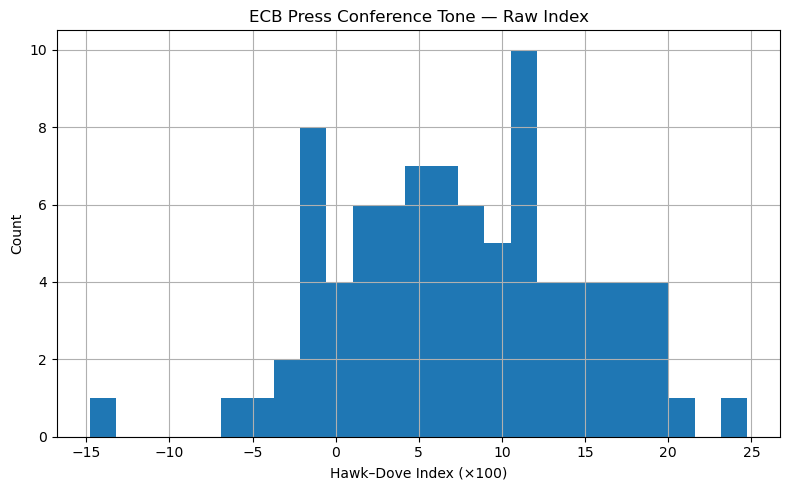

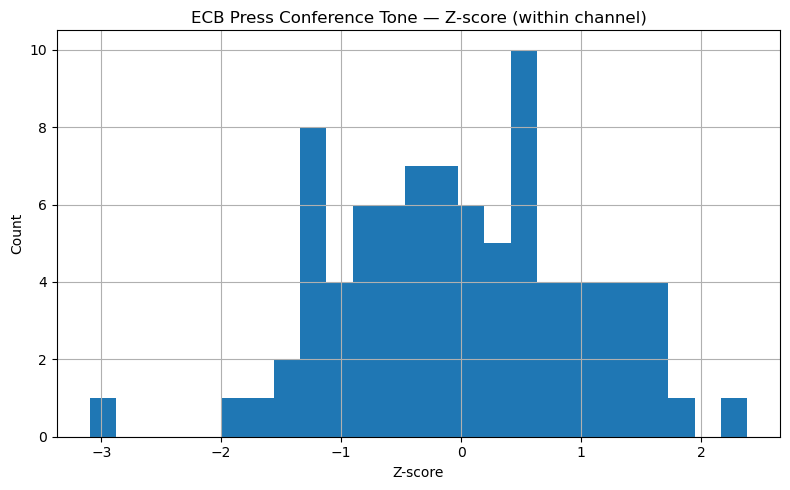

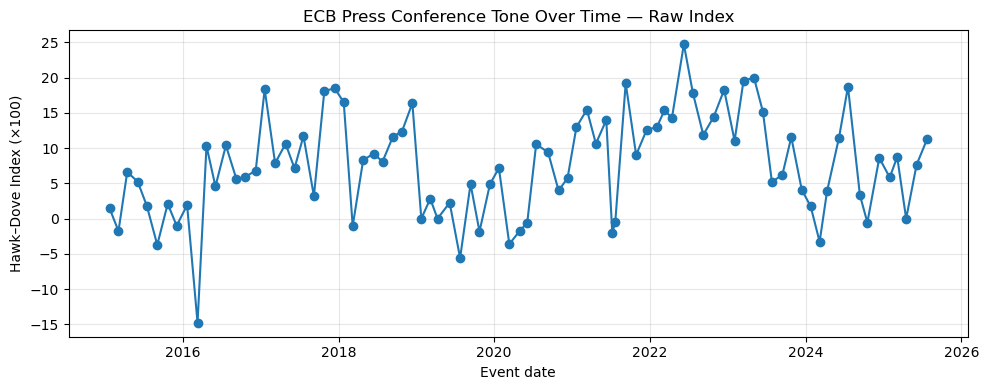

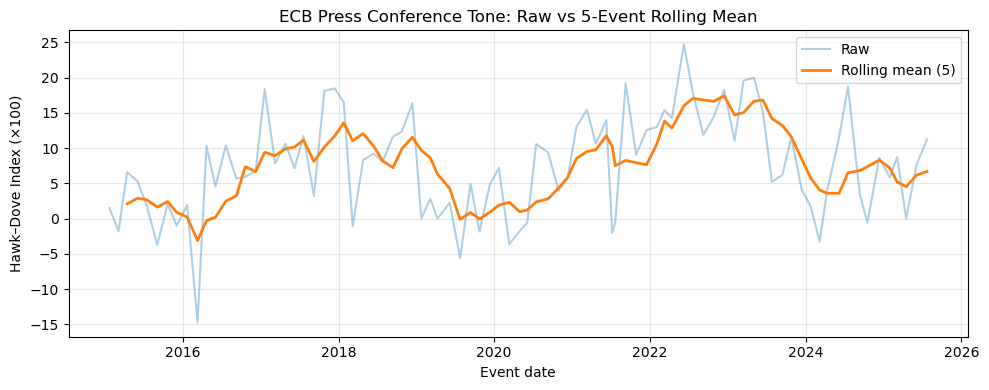


ECB Accounts (MPA) — Coverage & summary
------------------------------------------------------------------------
Events total: 83
Non-missing tone: 83
Date range: 2015-02-19 → 2025-07-03

Descriptive stats (raw index):
count    83.0000
mean     10.9877
std       9.7033
min     -12.8289
1%       -5.5892
5%       -2.4413
25%       3.1154
50%      11.4130
75%      19.2197
95%      25.8437
99%      29.0272
max      29.0801
Name: hd_index_dict_all, dtype: float64


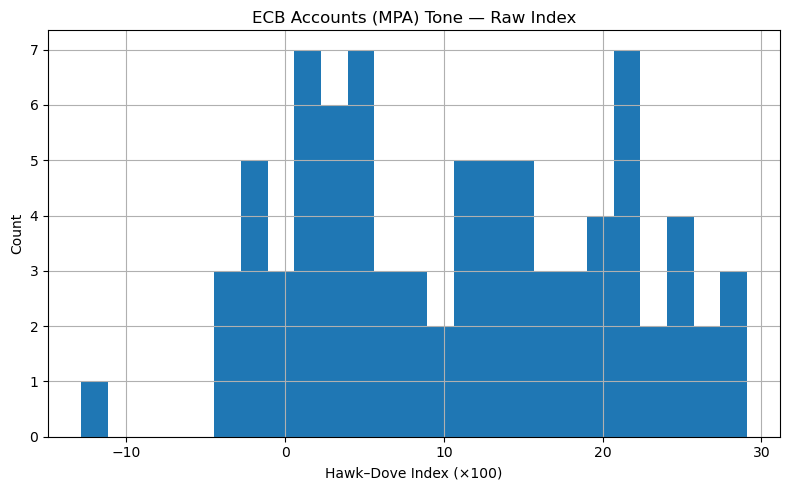

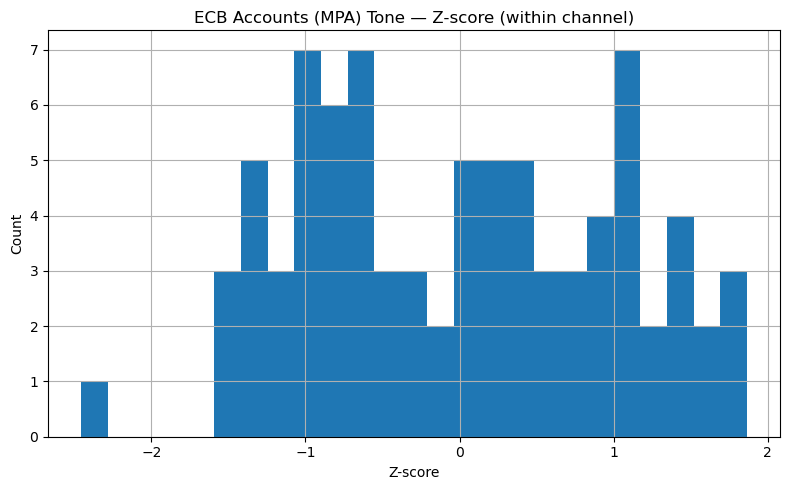

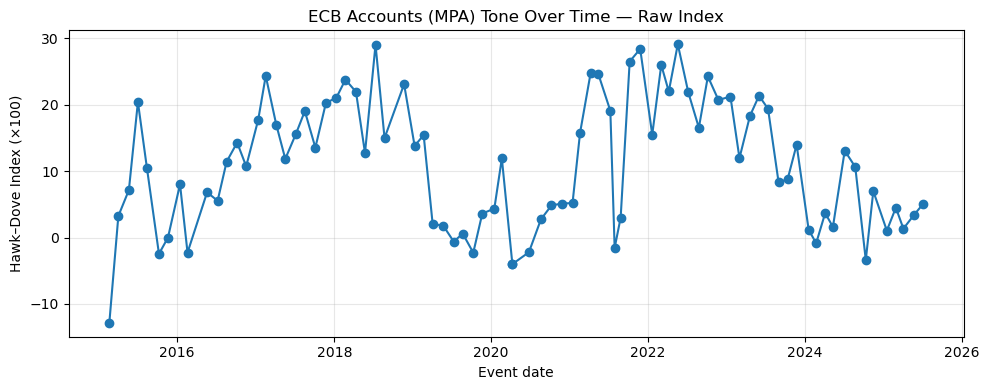

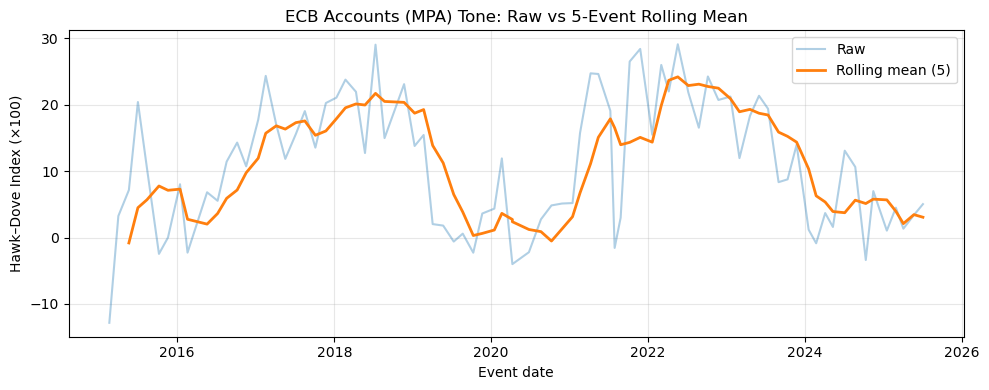


Saved figures to: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\figs


In [11]:
# ---- Step 5: Diagnostics (shared) — summary stats & plots, no "informative" metrics ----

PROC_DIR = Path("data/processed")
FIG_DIR  = PROC_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def run_diagnostics(event_csv: Path, title_prefix: str, file_prefix: str):
    df = pd.read_csv(event_csv, parse_dates=["event_date"])

    # --- Summary table
    print(f"\n{title_prefix} — Coverage & summary\n" + "-"*72)
    print(f"Events total: {len(df)}")
    print(f"Non-missing tone: {df['hd_index_dict_all'].notna().sum()}")
    if df['event_date'].notna().any():
        print(f"Date range: {df['event_date'].min().date()} → {df['event_date'].max().date()}")
    print("\nDescriptive stats (raw index):")
    print(df['hd_index_dict_all'].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))

    # --- Histogram: raw index [-100,100]
    plt.figure(figsize=(8,5))
    df['hd_index_dict_all'].dropna().hist(bins=25)
    plt.title(f"{title_prefix} Tone — Raw Index")
    plt.xlabel("Hawk–Dove Index (×100)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{file_prefix}_tone_hist_raw.png", dpi=180)
    plt.show()

    # --- Histogram: z-score (if present)
    if 'hd_index_dict_all_z' in df.columns and df['hd_index_dict_all_z'].notna().any():
        plt.figure(figsize=(8,5))
        df['hd_index_dict_all_z'].dropna().hist(bins=25)
        plt.title(f"{title_prefix} Tone — Z-score (within channel)")
        plt.xlabel("Z-score")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"{file_prefix}_tone_hist_z.png", dpi=180)
        plt.show()

    # --- Time series: raw index
    df_ts = df.sort_values("event_date")
    plt.figure(figsize=(10,4))
    plt.plot(df_ts['event_date'], df_ts['hd_index_dict_all'], marker='o', linestyle='-')
    plt.title(f"{title_prefix} Tone Over Time — Raw Index")
    plt.xlabel("Event date")
    plt.ylabel("Hawk–Dove Index (×100)")
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{file_prefix}_tone_timeseries_raw.png", dpi=180)
    plt.show()

    # --- Rolling mean (optional smoothing)
    if df_ts['hd_index_dict_all'].notna().sum() >= 5:
        df_ts['tone_roll5'] = df_ts['hd_index_dict_all'].rolling(5, min_periods=3).mean()
        plt.figure(figsize=(10,4))
        plt.plot(df_ts['event_date'], df_ts['hd_index_dict_all'], alpha=.35, label='Raw')
        plt.plot(df_ts['event_date'], df_ts['tone_roll5'], linewidth=2, label='Rolling mean (5)')
        plt.title(f"{title_prefix} Tone: Raw vs 5-Event Rolling Mean")
        plt.xlabel("Event date")
        plt.ylabel("Hawk–Dove Index (×100)")
        plt.legend()
        plt.grid(True, alpha=.3)
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"{file_prefix}_tone_timeseries_rolling.png", dpi=180)
        plt.show()

# --- Run for both channels ---
run_diagnostics(PROC_DIR / "presser_tone_dictionary.csv", "ECB Press Conference", "presser")
run_diagnostics(PROC_DIR / "account_tone_dictionary.csv",  "ECB Accounts (MPA)",  "account")

print(f"\nSaved figures to: {FIG_DIR.resolve()}")


### **Monetary Policy Speeches by Executive Board Members**
---

### Data Sourced from ECB Database and Cleaning

In [12]:
import pandas as pd
from pathlib import Path
import regex as re
import nltk
from unidecode import unidecode
from datetime import time

# ----------- Config ----------
# Use the official ECB dataset as the input
IN_SPEECHES_ECB = Path("all_ECB_speeches.csv")
DICT_DIR = Path("Dictionaries")
OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# New output filenames to avoid overwriting previous results
OUT_EVENT_ECB = OUT_DIR / "speech_tone_dictionary_ecb_source.csv"
OUT_SENT_ECB = OUT_DIR / "speech_sentence_scores_ecb_source.csv"
DAILY_OUT_ECB = OUT_DIR / "speech_tone_daily_ecb_source.csv"

MIN_WORDS_SENT = 4
MIN_INFORMATIVE = 5
CHANNEL_TAG = "speech_ecb_source" # Unique channel tag

# ----------- Utils (Helper functions) ----------
def ensure_punkt():
    try: nltk.data.find("tokenizers/punkt")
    except LookupError: nltk.download("punkt", quiet=True)
    try: nltk.data.find("tokenizers/punkt_tab/english")
    except LookupError:
        try: nltk.download("punkt_tab", quiet=True)
        except Exception: pass

def sent_tokenize(txt: str):
    sents = nltk.sent_tokenize(txt)
    return [re.sub(r"\s{2,}", " ", s.strip()) for s in sents if len(s.split()) >= MIN_WORDS_SENT]

def norm(s):
    return "" if pd.isna(s) else unidecode(str(s)).casefold().strip()

def load_wordset(path: Path) -> set:
    df = pd.read_csv(path, header=None, names=["term"])
    terms = df["term"].astype(str).str.strip().str.lower()
    terms = terms[terms.ne("") & ~terms.str.startswith("#")]
    return set(terms.tolist())

def resolve_overlaps(e_neu, e_pes, t_pos, t_neg):
    e_neu = e_neu - (e_neu & e_pes)
    t_pos = t_pos - (t_pos & t_neg)
    return e_neu, e_pes, t_pos, t_neg

def count_hits(sent: str, vocab: set) -> int:
    if not vocab: return 0
    pattern = r"\b(" + "|".join(re.escape(w) for w in vocab) + r")\b"
    return len(re.findall(pattern, sent, flags=re.I))

def parle_sentence_score(sent: str, e_neu, e_pes, t_pos, t_neg):
    s = sent.lower()
    ne, pe, po, ng = count_hits(s, e_neu), count_hits(s, e_pes), count_hits(s, t_pos), count_hits(s, t_neg)
    if (ne + pe + po + ng) == 0: return None
    if ne > pe and po > ng: return +1
    if ne > pe and po < ng: return -1
    if ne < pe and po < ng: return +1
    if ne < pe and po > ng: return -1
    return 0

# ----------- 1. Load and Filter Raw ECB Data -----------
print("Loading raw ECB speeches dataset...")
speeches_raw = pd.read_csv(IN_SPEECHES_ECB, sep='|', on_bad_lines='skip')
speeches_raw['date'] = pd.to_datetime(speeches_raw['date'], errors='coerce')

# Filter by Executive Board members
eb_names = [
    "Christine Lagarde", "Mario Draghi", "Luis de Guindos", "Philip R. Lane", "Philip Lane",
    "Isabel Schnabel", "Peter Praet", "Benoît Cœuré", "Benoit Coeure", "Yves Mersch",
    "Sabine Lautenschläger", "Sabine Lautenschlaeger", "Fabio Panetta", "Frank Elderson",
    "Piero Cipollone", "Vítor Constâncio", "Vitor Constancio"
]
eb_norm = {norm(n) for n in eb_names}
speeches_raw["_author_norm"] = speeches_raw["speakers"].map(norm)
speeches_ecb = speeches_raw[speeches_raw["_author_norm"].isin(eb_norm)].drop(columns=["_author_norm"]).copy()
print(f"Filtered down to {len(speeches_ecb)} speeches from Executive Board members.")

# ----------- 2. Load Dictionaries -----------
print("Loading sentiment dictionaries...")
econ_neutral, econ_pessim, tone_pos, tone_neg = resolve_overlaps(
    load_wordset(DICT_DIR / "neutral_economic.csv"),
    load_wordset(DICT_DIR / "pessimistic_economic.csv"),
    load_wordset(DICT_DIR / "positive_words.csv"),
    load_wordset(DICT_DIR / "negative_words.csv")
)
ensure_punkt()

# ----------- 3. Score Each Speech -----------
sent_rows_ecb, evt_rows_ecb = [], []
for _, r in tqdm(speeches_ecb.iterrows(), total=len(speeches_ecb), desc="Scoring ECB Speeches"):
    evt_date = r["date"].date() if pd.notna(r["date"]) else None
    author, title, txt = r.get("speakers", ""), r.get("title", ""), r.get("contents", "")
    
    if not isinstance(txt, str) or len(txt.strip()) == 0: continue

    sents = sent_tokenize(txt)
    scores = [s for s in [parle_sentence_score(sent, econ_neutral, econ_pessim, tone_pos, tone_neg) for sent in sents] if s is not None]

    hd_index = 100.0 * (sum(scores) / len(scores)) if len(scores) >= MIN_INFORMATIVE else None

    evt_rows_ecb.append({
        "date": evt_date, "author": author, "title": title, "channel": CHANNEL_TAG,
        "hd_index_dict_all": hd_index, "n_informative": len(scores), "n_sentences": len(sents)
    })

# ----------- 4. Save Outputs -----------
# Speech (event)-level output
evt_df_ecb = pd.DataFrame(evt_rows_ecb).sort_values(["date", "author", "title"])
evt_df_ecb.to_csv(OUT_EVENT_ECB, index=False)
print(f"\nSaved speech-level tone (ECB Source): {OUT_EVENT_ECB.resolve()}")

# Daily aggregate output
daily_ecb = evt_df_ecb.groupby("date", as_index=False).agg(hd_index_dict_all=("hd_index_dict_all", "mean"))
daily_ecb.to_csv(DAILY_OUT_ECB, index=False)
print(f"Saved daily speech tone (ECB Source): {DAILY_OUT_ECB.resolve()}")

Loading raw ECB speeches dataset...
Filtered down to 1484 speeches from Executive Board members.
Loading sentiment dictionaries...


Scoring ECB Speeches: 100%|██████████| 1484/1484 [02:23<00:00, 10.34it/s]


Saved speech-level tone (ECB Source): C:\Users\Asus\Desktop\5582804_Thesis\data\processed\speech_tone_dictionary_ecb_source.csv
Saved daily speech tone (ECB Source): C:\Users\Asus\Desktop\5582804_Thesis\data\processed\speech_tone_daily_ecb_source.csv


### Building Tone Index

In [13]:
# -------------------- Config --------------------
IN_CSV   = Path("all_ECB_speeches.csv")   # your ECB file (pipe-delimited)
DICT_DIR = Path("Dictionaries")           # folder with 4 CSVs: neutral_economic, pessimistic_economic, positive_words, negative_words
OUT_DIR  = Path("data/processed"); OUT_DIR.mkdir(parents=True, exist_ok=True)

YEARS            = range(2015, 2026)
MIN_WORDS_DOC    = 500
MIN_WORDS_SENT   = 4
CHANNEL_TAG      = "speech_ecbcsv"

EB_NAMES = [
    "Christine Lagarde", "Mario Draghi", "Luis de Guindos", "Philip R. Lane", "Philip Lane",
    "Isabel Schnabel", "Peter Praet", "Benoît Cœuré", "Benoit Coeure", "Yves Mersch",
    "Sabine Lautenschläger", "Sabine Lautenschlaeger", "Fabio Panetta", "Frank Elderson",
    "Piero Cipollone", "Vítor Constâncio", "Vitor Constancio"
]

def norm(s): 
    return "" if pd.isna(s) else unidecode(str(s)).casefold().strip()

EB_NORM = {norm(n) for n in EB_NAMES}

# -------------------- Load (pipe-delimited) --------------------
ecb = pd.read_csv(
    IN_CSV,
    sep="|",
    engine="python",
    on_bad_lines="skip",
    encoding="utf-8",
)

# Expect exactly these columns:
expected = ["date","speakers","title","subtitle","contents"]
missing = [c for c in expected if c not in ecb.columns]
if missing:
    raise ValueError(f"ECB CSV missing expected columns: {missing}. Got: {list(ecb.columns)}")

# Parse date (keep as Timestamp for comparisons)
ecb["date"] = pd.to_datetime(ecb["date"], errors="coerce")
ecb = ecb.dropna(subset=["date"]).copy()

# Year filter
start = pd.Timestamp(f"{min(YEARS)}-01-01")
end   = pd.Timestamp(f"{max(YEARS)}-12-31")
ecb = ecb[(ecb["date"] >= start) & (ecb["date"] <= end)].copy()

# -------------------- Split multiple speakers to rows --------------------
def split_speakers(s):
    if pd.isna(s): return []
    raw = str(s).replace(";", ",").replace("|", ",")
    return [sp.strip() for sp in raw.split(",") if sp.strip()]

rows = []
for _, r in ecb.iterrows():
    sp_list = split_speakers(r["speakers"])
    if not sp_list:  # ensure a 'speaker' field exists
        rows.append({**r, "speaker": r["speakers"]})
    else:
        for sp in sp_list:
            rows.append({**r, "speaker": sp})

ecb = pd.DataFrame(rows)
if ecb.empty:
    # Create empty frame with needed columns to avoid KeyErrors downstream
    ecb = pd.DataFrame(columns=["date","speakers","title","subtitle","contents","speaker"])

# EB filter
ecb["speaker_norm"] = ecb["speaker"].map(norm)
ecb = ecb[ecb["speaker_norm"].isin(EB_NORM)].copy()

# -------------------- Content & language filters --------------------
ecb["text"]    = ecb["contents"].fillna("").astype(str)
ecb["n_words"] = ecb["text"].map(lambda t: len(t.split()))
ecb = ecb[ecb["n_words"] >= MIN_WORDS_DOC].copy()

def is_english_guess(t: str) -> bool:
    if not isinstance(t, str): return False
    s = " " + t.lower() + " "
    hits = sum(w in s for w in [" the ", " and ", " of ", " to ", " in ", " for "])
    return hits >= 3

ecb = ecb[ecb["text"].map(is_english_guess)].copy()

# Deduplicate (date + speaker + title)
if not ecb.empty:
    ecb = (
        ecb.sort_values(["date","speaker","title"])
           .drop_duplicates(subset=["date","speaker","title"], keep="first")
           .reset_index(drop=True)
    )

# -------------------- Tone (Parle/Tadle) --------------------
def ensure_punkt():
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt", quiet=True)
    try:
        nltk.data.find("tokenizers/punkt_tab/english")
    except LookupError:
        try:
            nltk.download("punkt_tab", quiet=True)
        except Exception:
            pass
ensure_punkt()

def sent_tokenize(txt: str):
    sents = nltk.sent_tokenize(txt)
    return [re.sub(r"\s{2,}", " ", s.strip()) for s in sents if len(s.split()) >= MIN_WORDS_SENT]

def load_wordset(p: Path) -> set:
    df = pd.read_csv(p, header=None, names=["term"])
    terms = df["term"].astype(str).str.strip().str.lower()
    return set(terms[terms.ne("") & ~terms.str.startswith("#")].tolist())

DICT_DIR = Path("Dictionaries")
econ_neutral = load_wordset(DICT_DIR / "neutral_economic.csv")
econ_pessim  = load_wordset(DICT_DIR / "pessimistic_economic.csv")
tone_pos     = load_wordset(DICT_DIR / "positive_words.csv")
tone_neg     = load_wordset(DICT_DIR / "negative_words.csv")

# Overlap precedence
econ_neutral = econ_neutral - (econ_neutral & econ_pessim)
tone_pos     = tone_pos - (tone_pos & tone_neg)

def count_hits(sent: str, vocab: set) -> int:
    if not vocab: return 0
    pattern = r"\b(" + "|".join(re.escape(w) for w in vocab) + r")\b"
    return len(re.findall(pattern, sent, flags=re.I))

def parle_sentence_score(sent: str):
    s = sent.lower()
    ne = count_hits(s, econ_neutral)
    pe = count_hits(s, econ_pessim)
    po = count_hits(s, tone_pos)
    ng = count_hits(s, tone_neg)
    if (ne + pe + po + ng) == 0: return None
    if ne > pe and po > ng: return +1
    if ne > pe and po < ng: return -1
    if ne < pe and po < ng: return +1
    if ne < pe and po > ng: return -1
    return 0

sent_rows, evt_rows = [], []

for _, r in ecb.iterrows():
    evt_date = pd.to_datetime(r["date"]).date()  # convert here
    author   = r["speaker"]
    title    = r["title"]
    txt      = r["text"]

    sents  = sent_tokenize(txt)
    scores = []
    for j, s in enumerate(sents, start=1):
        sc = parle_sentence_score(s)
        if sc is not None:
            sent_rows.append({
                "date": evt_date,
                "author": author,
                "title": title,
                "channel": CHANNEL_TAG,
                "sentence_id": j,
                "sentence_text": s,
                "score": int(sc)
            })
            scores.append(sc)

    hd_index = None if len(scores)==0 else 100.0 * (sum(scores) / len(scores))
    evt_rows.append({
        "date": evt_date,
        "author": author,
        "title": title,
        "channel": CHANNEL_TAG,
        "hd_index_dict_all": hd_index,
        "n_informative": len(scores),
        "n_sentences": len(sents)
    })

sent_df = pd.DataFrame(sent_rows)
evt_df  = pd.DataFrame(evt_rows).sort_values(["date","author","title"])

# Event-level z-score
if not evt_df.empty and evt_df["hd_index_dict_all"].notna().sum() >= 3:
    m = evt_df["hd_index_dict_all"].mean()
    s = evt_df["hd_index_dict_all"].std(ddof=0)
    evt_df["hd_index_dict_all_z"] = (evt_df["hd_index_dict_all"] - m) / s
else:
    evt_df["hd_index_dict_all_z"] = pd.NA

# Daily aggregate
if not evt_df.empty:
    daily = (
        evt_df.groupby("date", as_index=False)
              .agg(
                  hd_index_dict_all=("hd_index_dict_all","mean"),
                  n_speeches=("hd_index_dict_all","size"),
                  n_with_index=("hd_index_dict_all", lambda x: x.notna().sum()),
                  n_inf_total=("n_informative","sum")
              )
              .sort_values("date")
    )
    if daily["hd_index_dict_all"].notna().sum() >= 3:
        m = daily["hd_index_dict_all"].mean()
        s = daily["hd_index_dict_all"].std(ddof=0)
        daily["hd_index_dict_all_z"] = (daily["hd_index_dict_all"] - m) / s
    else:
        daily["hd_index_dict_all_z"] = pd.NA
else:
    daily = pd.DataFrame(columns=["date","hd_index_dict_all","n_speeches","n_with_index","n_inf_total","hd_index_dict_all_z"])

# -------------------- Save --------------------
SENT_OUT  = OUT_DIR / "ecbcsv_speech_sentence_scores.csv"
EVT_OUT   = OUT_DIR / "ecbcsv_speech_tone_dictionary.csv"
DAILY_OUT = OUT_DIR / "ecbcsv_speech_tone_daily.csv"

sent_df.to_csv(SENT_OUT, index=False, encoding="utf-8")
evt_df.to_csv(EVT_OUT,  index=False, encoding="utf-8")
daily.to_csv(DAILY_OUT, index=False, encoding="utf-8")

print(f"Saved: {SENT_OUT}  ({len(sent_df)} rows)")
print(f"Saved: {EVT_OUT}   ({len(evt_df)} rows)")
print(f"Saved: {DAILY_OUT} ({len(daily)} rows)")


Saved: data\processed\ecbcsv_speech_sentence_scores.csv  (88413 rows)
Saved: data\processed\ecbcsv_speech_tone_dictionary.csv   (1006 rows)
Saved: data\processed\ecbcsv_speech_tone_daily.csv (789 rows)


### Sourcing Data from the BIS Gingado Library and Cleaning

In [14]:
# 0) One-time install (uncomment if needed)
!pip install -q gingado unidecode pandas

import pandas as pd
from unidecode import unidecode
from datetime import time
from gingado.datasets import load_CB_speeches

# ----------------------------
# 1) Load BIS speeches (2015–2025)
# ----------------------------
YEARS = list(range(2015, 2026))
raw = load_CB_speeches(year=YEARS, cache=True, timeout=180)  # returns a DataFrame

# Standardize columns we rely on
cols_expected = ["url", "title", "description", "date", "text", "author"]
for c in cols_expected:
    if c not in raw.columns:
        raw[c] = pd.NA

df = raw.copy()

# Parse date; keep timezone-naive (BIS mixes sources)
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=False)

# ----------------------------
# 2) ECB Executive Board filter (accent/case-insensitive)
# ----------------------------
# EB members overlapping 2015–2025
eb_names = [
    "Christine Lagarde", "Mario Draghi", "Luis de Guindos", "Philip R. Lane", "Philip Lane",
    "Isabel Schnabel", "Peter Praet", "Benoît Cœuré", "Benoit Coeure", "Yves Mersch",
    "Sabine Lautenschläger", "Sabine Lautenschlaeger", "Fabio Panetta", "Frank Elderson",
    "Piero Cipollone", "Vítor Constâncio", "Vitor Constancio"
]

def norm(s):
    return "" if pd.isna(s) else unidecode(str(s)).casefold().strip()

eb_norm = {norm(n) for n in eb_names}

# Keep row if author matches any EB name (accent-insensitive)
df["_author_norm"] = df["author"].map(norm)
df = df[df["_author_norm"].isin(eb_norm)].drop(columns=["_author_norm"])

# ----------------------------
# ----------------------------
# 3) Content relevance filters (Refined Logic)
# ----------------------------

# Drop only items that are definitively NOT speeches
drop_keywords = [
    "interview", "panel", "fireside chat", "q&a", "dialogue", "conversation",
    "ceremony", "award", "gala", "farewell", "launch", "press conference"
]

# Positively identify items that ARE likely speeches
keep_keywords = [
    "speech", "keynote", "lecture", "address", "remarks", "statement", "testimony", "introductory"
]

def filter_by_relevance(row):
    # Combine title and description for searching
    text_fields = " ".join([
        str(row.get("title", "")),
        str(row.get("description", "")),
    ])
    text_fields = norm(text_fields) # Uses the same norm function from your script
    
    # Condition 1: Must NOT contain a drop keyword
    has_drop_keyword = any(k in text_fields for k in drop_keywords)
    if has_drop_keyword:
        return False # Exclude it
        
    # Condition 2: Must contain at least one keep keyword
    has_keep_keyword = any(k in text_fields for k in keep_keywords)
    if has_keep_keyword:
        return True # Include it
        
    return False # Exclude if it meets neither condition

df = df[df.apply(filter_by_relevance, axis=1)].copy()

# --- The rest of your Step 3 code for word count and language check remains the same ---

# Word count & minimum length
def word_count(s):
    if pd.isna(s): return 0
    return len(str(s).strip().split())

df["n_words"] = df["text"].map(word_count)
MIN_WORDS = 500
df = df[df["n_words"] >= MIN_WORDS].copy()

# Keep only English text (heuristic: look for common English stopwords)
def is_english_guess(t):
    if pd.isna(t): return False
    s = str(t).lower()
    hits = sum(w in s for w in [" the ", " and ", " of ", " to ", " in ", "for "])
    return hits >= 2

df = df[df["text"].map(is_english_guess)].copy()
# ----------------------------
# 4) Useful flags/fields for analysis
# ----------------------------
df["year"] = df["date"].dt.year
df["has_time"] = df["date"].dt.time.ne(time(0, 0))  # True if not 00:00:00
df["date_only"] = df["date"].dt.date

# Deduplicate conservatively (author + date_only + title)
df["title_norm"] = df["title"].map(norm)
df = df.sort_values(["author", "date", "url"]).drop_duplicates(
    subset=["author", "date_only", "title_norm"], keep="first"
).drop(columns=["title_norm"])

# Reorder columns for inspection
out_cols = [
    "date", "date_only", "has_time", "year", "author", "title", "description",
    "n_words", "url", "text"
]
df = df[out_cols]

# ----------------------------
# 5) Export
# ----------------------------
OUT_PATH = "data/text/bis_ecb_eb_speeches_2015_2025_filtered.csv"
df.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"Saved {len(df)} speeches to {OUT_PATH}")

# Optional: quick summary
print("\nSummary:")
print(df.groupby("year").size())
print("Median words:", int(df["n_words"].median()))


Saved 829 speeches to data/text/bis_ecb_eb_speeches_2015_2025_filtered.csv

Summary:
year
2015     83
2016     92
2017    127
2018     98
2019     88
2020     70
2021     46
2022     61
2023     61
2024     70
2025     33
dtype: int64
Median words: 2317


### Building Tone Index

In [15]:
# --- Speech Tone Scoring: Parle/Tadle rule on BIS ECB-EB speeches (daily) ---
# Inputs:
#   - bis_ecb_eb_speeches_2015_2025_filtered.csv   (from the previous step)
#   - four dictionary CSVs (neutral_economic, pessimistic_economic, positive_words, negative_words)
# Outputs (to data/processed/):
#   - speech_sentence_scores.csv         (sentence-level, informative only)
#   - speech_tone_dictionary.csv         (event-level per speech + daily aggregate)
#   - speech_tone_daily.csv              (daily aggregate only; raw index and z-score)

import pandas as pd
from pathlib import Path
import regex as re
import nltk
from unidecode import unidecode

# ----------- Config ----------
IN_SPEECHES = Path("data/text/bis_ecb_eb_speeches_2015_2025_filtered.csv")
DICT_DIR    = Path("Dictionaries")  # <- set to folder containing the four CSVs
OUT_DIR     = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MIN_WORDS_SENT = 4          # drop trivial sentences
MIN_INFORMATIVE = 5         # speech must have at least this many informative sentences
CHANNEL_TAG = "speech"      # channel label for consistency

# ----------- Utils ----------
def ensure_punkt():
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt", quiet=True)
    # new nltk sometimes needs punkt_tab
    try:
        nltk.data.find("tokenizers/punkt_tab/english")
    except LookupError:
        try:
            nltk.download("punkt_tab", quiet=True)
        except Exception:
            pass

def sent_tokenize(txt: str):
    sents = nltk.sent_tokenize(txt)
    sents = [re.sub(r"\s{2,}", " ", s.strip()) for s in sents if len(s.split()) >= MIN_WORDS_SENT]
    return sents

def norm(s):
    return "" if pd.isna(s) else unidecode(str(s)).casefold().strip()

def load_wordset(path: Path) -> set:
    df = pd.read_csv(path, header=None, names=["term"])
    terms = (
        df["term"].astype(str).str.strip().str.lower()
    )
    terms = terms[terms.ne("") & ~terms.str.startswith("#")]
    return set(terms.tolist())

def resolve_overlaps(e_neu, e_pes, t_pos, t_neg):
    # precedence: pessimistic > neutral; negative > positive
    e_neu = e_neu - (e_neu & e_pes)
    t_pos = t_pos - (t_pos & t_neg)
    return e_neu, e_pes, t_pos, t_neg

def count_hits(sent: str, vocab: set) -> int:
    if not vocab:
        return 0
    # whole-word, case-insensitive
    pattern = r"\b(" + "|".join(re.escape(w) for w in vocab) + r")\b"
    return len(re.findall(pattern, sent, flags=re.I))

def parle_sentence_score(sent: str, e_neu, e_pes, t_pos, t_neg):
    # Parle (2022) two-stage rule: base (neutral vs pessimistic) × polarity (pos vs neg)
    s = sent.lower()
    ne = count_hits(s, e_neu)
    pe = count_hits(s, e_pes)
    po = count_hits(s, t_pos)
    ng = count_hits(s, t_neg)

    if (ne + pe + po + ng) == 0:
        return None  # non-informative
    if ne > pe and po > ng:   return +1
    if ne > pe and po < ng:   return -1
    if ne < pe and po < ng:   return +1
    if ne < pe and po > ng:   return -1
    return 0

# ----------- Load data -----------
speeches = pd.read_csv(IN_SPEECHES, parse_dates=["date"])
# Expect columns: date, date_only, has_time, year, author, title, description, n_words, url, text

# Load dictionaries
econ_neutral = load_wordset(DICT_DIR / "neutral_economic.csv")
econ_pessim  = load_wordset(DICT_DIR / "pessimistic_economic.csv")
tone_pos     = load_wordset(DICT_DIR / "positive_words.csv")
tone_neg     = load_wordset(DICT_DIR / "negative_words.csv")

# Resolve overlaps by precedence to reduce double-counting
econ_neutral, econ_pessim, tone_pos, tone_neg = resolve_overlaps(
    econ_neutral, econ_pessim, tone_pos, tone_neg
)

ensure_punkt()

# ----------- Score per speech -----------
sent_rows = []
evt_rows  = []

for idx, r in speeches.iterrows():
    evt_date = pd.to_datetime(r["date"]).date()
    author = r.get("author", "")
    title  = r.get("title", "")
    txt    = r.get("text", "")

    if not isinstance(txt, str) or len(txt.strip()) == 0:
        # no text; skip but record null event row
        evt_rows.append({
            "date": evt_date,
            "author": author,
            "title": title,
            "channel": CHANNEL_TAG,
            "hd_index_dict_all": None,
            "n_informative": 0,
            "n_sentences": 0
        })
        continue

    sents = sent_tokenize(txt)
    scores = []
    for j, s in enumerate(sents, start=1):
        sc = parle_sentence_score(s, econ_neutral, econ_pessim, tone_pos, tone_neg)
        # Keep only informative in sentence dump
        if sc is not None:
            sent_rows.append({
                "date": evt_date,
                "author": author,
                "title": title,
                "channel": CHANNEL_TAG,
                "sentence_id": j,
                "sentence_text": s,
                "score": int(sc)
            })
            scores.append(sc)

    # Aggregate to speech-level index
    if len(scores) >= MIN_INFORMATIVE:
        hd_index = 100.0 * (sum(scores) / len(scores))
    elif len(scores) > 0:
        # keep but mark as low coverage
        hd_index = 100.0 * (sum(scores) / len(scores))
    else:
        hd_index = None

    evt_rows.append({
        "date": evt_date,
        "author": author,
        "title": title,
        "channel": CHANNEL_TAG,
        "hd_index_dict_all": hd_index,
        "n_informative": len(scores),
        "n_sentences": len(sents)
    })

# Sentence-level output
sent_df = pd.DataFrame(sent_rows)
sent_out = OUT_DIR / "bis_speech_sentence_scores.csv"
if not sent_df.empty:
    sent_df.to_csv(sent_out, index=False)
    print(f"Saved sentence-level scores: {sent_out.resolve()}")
else:
    print("No informative sentences found (check dictionaries and inputs).")

# Speech (event)-level output
evt_df = pd.DataFrame(evt_rows).sort_values(["date", "author", "title"])
evt_out = OUT_DIR / "bis_speech_tone_dictionary.csv"

# z-score (within channel) at speech level
if evt_df["hd_index_dict_all"].notna().sum() >= 3:
    m = evt_df["hd_index_dict_all"].mean()
    s = evt_df["hd_index_dict_all"].std(ddof=0)
    evt_df["hd_index_dict_all_z"] = (evt_df["hd_index_dict_all"] - m) / s
else:
    evt_df["hd_index_dict_all_z"] = pd.NA

evt_df.to_csv(evt_out, index=False)
print(f"Saved speech-level tone: {evt_out.resolve()}")

# ----------- Daily aggregate (multiple speeches per day) -----------
daily = (
    evt_df
    .groupby("date", as_index=False)
    .agg(
        hd_index_dict_all=("hd_index_dict_all", "mean"),
        n_speeches=("hd_index_dict_all", "size"),
        n_with_index=("hd_index_dict_all", lambda x: x.notna().sum()),
        n_inf_total=("n_informative", "sum")
    )
    .sort_values("date")
)

# z-score (within channel) at daily level
if daily["hd_index_dict_all"].notna().sum() >= 3:
    m = daily["hd_index_dict_all"].mean()
    s = daily["hd_index_dict_all"].std(ddof=0)
    daily["hd_index_dict_all_z"] = (daily["hd_index_dict_all"] - m) / s
else:
    daily["hd_index_dict_all_z"] = pd.NA

daily_out = OUT_DIR / "bis_speech_tone_daily.csv"
daily.to_csv(daily_out, index=False)
print(f"Saved daily speech tone: {daily_out.resolve()}")

# Quick peek
display(daily.tail(10))


Saved sentence-level scores: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\bis_speech_sentence_scores.csv
Saved speech-level tone: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\bis_speech_tone_dictionary.csv
Saved daily speech tone: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\bis_speech_tone_daily.csv


,date,hd_index_dict_all,n_speeches,n_with_index,n_inf_total,hd_index_dict_all_z
663,2025-05-05,-12.0000,1,1,25,-1.8737
664,2025-05-06,8.9286,1,1,56,0.3648
665,2025-05-15,11.7647,1,1,68,0.6682
666,2025-05-26,5.2632,1,1,95,-0.0272
667,2025-05-30,4.5455,1,1,352,-0.1040
668,2025-06-07,17.2414,1,1,29,1.2540
669,2025-06-09,15.6250,1,1,64,1.0811
670,2025-06-12,3.7031,2,2,196,-0.1941
671,2025-06-18,3.6132,2,2,177,-0.2037
672,2025-06-19,14.8515,1,1,101,0.9984


### Comparision ECB vs BIS (robustness) databases

In [16]:
# ------------------- Config -------------------
PROCESSED_DIR = Path("data/processed")
BIS_FILE   = PROCESSED_DIR / "bis_speech_tone_daily.csv"         # BIS daily
ECB_FILE   = PROCESSED_DIR / "ecbcsv_speech_tone_daily.csv"  # ECB official daily
BIS_EVT    = PROCESSED_DIR / "bis_speech_tone_dictionary.csv"
ECB_EVT    = PROCESSED_DIR / "ecbcsv_speech_tone_dictionary.csv"

# ------------------- Load -------------------
bis_daily = pd.read_csv(BIS_FILE, parse_dates=["date"])
ecb_daily = pd.read_csv(ECB_FILE, parse_dates=["date"])
bis_evt   = pd.read_csv(BIS_EVT, parse_dates=["date"])
ecb_evt   = pd.read_csv(ECB_EVT, parse_dates=["date"])

# ------------------- Summary function -------------------
def tone_summary(df_daily, label):
    stats = {
        "Dataset": label,
        "Days with tone": df_daily["hd_index_dict_all"].notna().sum(),
        "Date range": f"{df_daily['date'].min().date()} → {df_daily['date'].max().date()}",
        "Mean tone": round(df_daily['hd_index_dict_all'].mean(), 2),
        "Std tone": round(df_daily['hd_index_dict_all'].std(), 2),
        "Min tone": round(df_daily['hd_index_dict_all'].min(), 2),
        "Max tone": round(df_daily['hd_index_dict_all'].max(), 2),
        "Positive %": round((df_daily['hd_index_dict_all'] > 0).mean() * 100, 1),
        "Negative %": round((df_daily['hd_index_dict_all'] < 0).mean() * 100, 1)
    }
    return stats

summary = pd.DataFrame([
    tone_summary(bis_daily, "BIS speeches"),
    tone_summary(ecb_daily, "ECB official speeches")
])

# ------------------- Author distribution -------------------
def author_top(df_evt, label, top_n=5):
    counts = df_evt["author"].value_counts().head(top_n)
    counts.name = label
    return counts

bis_top_authors = author_top(bis_evt, "BIS")
ecb_top_authors = author_top(ecb_evt, "ECB official")

# ------------------- Overlap analysis -------------------
overlap = pd.merge(
    bis_daily[["date","hd_index_dict_all"]],
    ecb_daily[["date","hd_index_dict_all"]],
    on="date",
    suffixes=("_bis","_ecb")
)

if not overlap.empty:
    corr = overlap[["hd_index_dict_all_bis","hd_index_dict_all_ecb"]].corr().iloc[0,1]
else:
    corr = None

# ------------------- Output -------------------
print("\n=== Summary Stats ===")
print(summary.to_string(index=False))

print("\n=== Top Authors (BIS) ===")
print(bis_top_authors)

print("\n=== Top Authors (ECB official) ===")
print(ecb_top_authors)

print("\n=== Overlap Analysis ===")
print(f"Days with both datasets: {len(overlap)}")
if corr is not None:
    print(f"Correlation of daily tone indices: {corr:.3f}")
else:
    print("No overlapping days with tone indices.")

# Optionally save outputs
summary.to_csv(PROCESSED_DIR / "tone_summary_comparison.csv", index=False)
overlap.to_csv(PROCESSED_DIR / "tone_overlap_daily.csv", index=False)



=== Summary Stats ===
              Dataset  Days with tone              Date range  Mean tone  Std tone  Min tone  Max tone  Positive %  Negative %
         BIS speeches             673 2015-01-25 → 2025-06-19     5.5200    9.3600  -48.1000   41.6700     71.8000     22.4000
ECB official speeches             789 2015-01-25 → 2025-07-14     5.4400    9.5300  -42.0800   55.1700     72.0000     22.2000

=== Top Authors (BIS) ===
author
Christine Lagarde    104
Mario Draghi          89
Yves Mersch           87
Benoît Cœuré          85
Fabio Panetta         85
Name: BIS, dtype: int64

=== Top Authors (ECB official) ===
author
Christine Lagarde    133
Yves Mersch          111
Mario Draghi         105
Benoît Cœuré         100
Luis de Guindos       95
Name: ECB official, dtype: int64

=== Overlap Analysis ===
Days with both datasets: 611
Correlation of daily tone indices: 0.952


---
---

### **Moneatry Policy Decisions Tone Index**

### Text preprocessing and sentence tokenization for MPD events

In [17]:
# ---- MPD Step 1: Event text prep + sentence tokenization ----

# ---------- Paths ----------
DECISIONS_DIR = Path("data/text/decisions")                # raw MPD .txt files (from your scraper)
META_CSV      = DECISIONS_DIR / "decision_metadata.csv"    # created by your MPD scraper
CLEAN_DIR     = Path("data/interim/decisions_clean")
SENT_DIR      = Path("data/interim/decisions_sentences")

CLEAN_DIR.mkdir(parents=True, exist_ok=True)
SENT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- NLTK (sentence splitter) ----------
def ensure_nltk_models():
    for res in ['punkt', 'stopwords']:
        try:
            nltk.data.find(f'tokenizers/{res}' if res=='punkt' else f'corpora/{res}')
        except LookupError:
            nltk.download(res, quiet=True)
    # some environments use punkt_tab
    try:
        nltk.data.find('tokenizers/punkt_tab/english')
    except LookupError:
        try:
            nltk.download('punkt_tab', quiet=True)
        except Exception:
            pass
ensure_nltk_models()

# ---------- Helpers ----------
def normalize_text(txt: str) -> str:
    if not isinstance(txt, str):
        return ""
    t = unidecode(txt)                       # normalize accents/dashes
    t = re.sub(r"\r", "\n", t)               # unify newlines
    t = re.sub(r"[ \t]+", " ", t)            # collapse spaces/tabs
    t = re.sub(r"\n{2,}", "\n\n", t)         # limit blank lines
    return t.strip()

def read_text_safe(p: Path) -> str:
    try:
        return p.read_text(encoding="utf-8", errors="ignore")
    except Exception:
        return ""

def sent_tokenize(text: str) -> list[str]:
    sents = nltk.sent_tokenize(text)
    return [re.sub(r"\s{2,}", " ", s).strip() for s in sents if s.strip()]

# ---------- Load metadata & map to files ----------
meta = pd.read_csv(META_CSV, dtype=str)
if "date" in meta.columns:
    meta["date"] = pd.to_datetime(meta["date"], errors="coerce")

txt_files = sorted(DECISIONS_DIR.glob("decision_*.txt"))
by_name = {p.name: p for p in txt_files}

# try match by 'filename_text'; fallback by date inside filename; final fallback by event_id stub
def find_source_path(row):
    # 1) filename_text exact
    fn = row.get("filename_text")
    if isinstance(fn, str) and fn in by_name:
        return by_name[fn]
    # 2) date pattern in any txt filename
    if pd.notna(row.get("date")):
        d = pd.to_datetime(row["date"]).date()
        for p in txt_files:
            if re.search(fr"{d.isoformat()}", p.name):
                return p
    # 3) event_id core if present
    eid = row.get("event_id") or ""
    for p in txt_files:
        if eid and eid in p.name:
            return p
    return None

rows_clean = []
rows_sent_index = []

for _, r in meta.iterrows():
    p = find_source_path(r)
    if p is None:
        continue

    # choose an event key (prefer date; else event_id; else SHA stub from filename)
    evt_date = None
    if pd.notna(r.get("date")):
        try:
            evt_date = pd.to_datetime(r["date"]).date()
        except Exception:
            evt_date = None

    event_key = r.get("event_id") or p.stem.replace("decision_", "")
    if evt_date:
        out_clean_name = f"mpd_{evt_date.isoformat()}_clean.txt"
        event_date_str = evt_date.isoformat()
    else:
        out_clean_name = f"mpd_{event_key}_clean.txt"
        event_date_str = None

    raw = read_text_safe(p)
    clean = normalize_text(raw)

    # save cleaned
    out_clean_path = CLEAN_DIR / out_clean_name
    out_clean_path.write_text(clean, encoding="utf-8")

    rows_clean.append({
        "event_id": r.get("event_id"),
        "event_date": event_date_str,
        "source_file": p.name,
        "clean_file": out_clean_name,
        "n_chars": len(clean),
        "n_words": len(clean.split())
    })

    # sentence tokenization
    sents_raw = sent_tokenize(clean)

    out_sent_csv = SENT_DIR / (out_clean_name.replace("_clean.txt", "_sentences.csv"))
    pd.DataFrame({
        "event_id": r.get("event_id"),
        "event_date": event_date_str,
        "sentence_id": list(range(1, len(sents_raw)+1)),
        "sentence_text_raw": sents_raw
    }).to_csv(out_sent_csv, index=False)

    rows_sent_index.append({
        "event_id": r.get("event_id"),
        "event_date": event_date_str,
        "sentences_file": out_sent_csv.name,
        "sentences_raw": len(sents_raw),
        "clean_file": out_clean_name
    })

# indexes
mpd_clean_index = pd.DataFrame(rows_clean).sort_values(["event_date","event_id"]).reset_index(drop=True)
mpd_sent_index  = pd.DataFrame(rows_sent_index).sort_values(["event_date","event_id"]).reset_index(drop=True)

mpd_clean_index.to_csv(CLEAN_DIR / "mpd_clean_index.csv", index=False)
mpd_sent_index.to_csv(SENT_DIR  / "mpd_sent_index.csv",  index=False)

print("Saved:", (CLEAN_DIR / "mpd_clean_index.csv").resolve())
print("Saved:", (SENT_DIR  / "mpd_sent_index.csv").resolve())


Saved: C:\Users\Asus\Desktop\5582804_Thesis\data\interim\decisions_clean\mpd_clean_index.csv
Saved: C:\Users\Asus\Desktop\5582804_Thesis\data\interim\decisions_sentences\mpd_sent_index.csv


### Dictionary-based tone scoring and Hawk–Dove index computation

In [18]:
# ---- MPD Step 2: Dictionary scoring (Parle-style) and aggregation to event level ----

# ---------- Inputs ----------
SENT_DIR   = Path("data/interim/decisions_sentences")
SENT_INDEX = SENT_DIR / "mpd_sent_index.csv"

# ---------- Outputs ----------
OUT_DIR   = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_EVENT = OUT_DIR / "mpd_tone_dictionary.csv"
OUT_SENT  = OUT_DIR / "mpd_sentence_scores.csv"   # optional diagnostics

# ---------- Load dictionaries ----------
# If you already loaded DICTS earlier, you can reuse them; otherwise load fresh here.
ROOT = Path.cwd()
TARGETS = {
    "econ_neutral":     "neutral_economic.csv",
    "econ_pessimistic": "pessimistic_economic.csv",
    "tone_positive":    "positive_words.csv",
    "tone_negative":    "negative_words.csv",
}

def find_case_insensitive(root: Path, filename: str):
    target = filename.lower()
    for p in root.rglob("*.csv"):
        if p.name.lower() == target:
            return p
    return None

found = {k: find_case_insensitive(ROOT, v) for k, v in TARGETS.items()}
missing = [k for k, p in found.items() if p is None]
if missing:
    raise FileNotFoundError(
        f"Dictionary CSVs missing for keys: {missing}. "
        "Place the four CSVs anywhere under the project folder (names must match) and re-run."
    )

def load_wordset(path: Path) -> set[str]:
    df = pd.read_csv(path, header=None, names=["term"], encoding="utf-8")
    terms = df["term"].astype(str).str.strip().str.lower()
    terms = terms[terms.ne("") & ~terms.str.startswith("#")]
    return set(terms.tolist())

econ_neutral = load_wordset(found["econ_neutral"])
econ_pessim  = load_wordset(found["econ_pessimistic"])
tone_pos     = load_wordset(found["tone_positive"])
tone_neg     = load_wordset(found["tone_negative"])

# resolve overlaps (same as accounts)
def resolve_overlaps(e_neu: set[str], e_pes: set[str], t_pos: set[str], t_neg: set[str]):
    drop_from_neu = e_neu & e_pes
    e_neu = e_neu - drop_from_neu
    drop_from_pos = t_pos & t_neg
    t_pos = t_pos - drop_from_pos
    return e_neu, e_pes, t_pos, t_neg

econ_neutral, econ_pessim, tone_pos, tone_neg = resolve_overlaps(
    econ_neutral, econ_pessim, tone_pos, tone_neg
)

# ---------- Scoring helpers ----------
def normalize_spaces(s: str) -> str:
    return re.sub(r"\s{2,}", " ", s).strip()

def strip_digits_punct_lower(text: str) -> str:
    t = text.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    return normalize_spaces(t)

def preprocess_for_parle(sent: str) -> str:
    return strip_digits_punct_lower(sent)

def count_hits(sent: str, vocab: set[str]) -> int:
    if not vocab:
        return 0
    pattern = r"\b(" + "|".join(re.escape(w) for w in vocab) + r")\b"
    return len(re.findall(pattern, sent, flags=re.I))

def apply_parle_rule(sent: str, e_neu, e_pes, t_pos, t_neg):
    """
    Parle (2022) mapping at sentence level:
      Hawkish:   (neutral > pessimistic AND positive > negative) OR
                 (neutral < pessimistic AND negative < positive) -> +1
      Dovish:    (neutral > pessimistic AND positive < negative) OR
                 (neutral < pessimistic AND negative > positive) -> -1
      Neutral:   otherwise 0; None if no tokens matched.
    """
    s = preprocess_for_parle(sent)
    ne = count_hits(s, e_neu)
    pe = count_hits(s, e_pes)
    po = count_hits(s, t_pos)
    ng = count_hits(s, t_neg)
    if (ne + pe + po + ng) == 0:
        return None
    if ne > pe and po > ng:   return +1
    if ne > pe and po < ng:   return -1
    if ne < pe and po < ng:   return +1
    if ne < pe and po > ng:   return -1
    return 0

# ---------- Run over sentence files ----------
sent_index = pd.read_csv(SENT_INDEX, dtype=str)
event_rows = []
all_sent_scores = []

for _, row in sent_index.iterrows():
    sent_file = SENT_DIR / row["sentences_file"]
    if not sent_file.exists():
        continue

    df = pd.read_csv(sent_file, dtype=str)
    # choose text column
    text_col = "sentence_text_raw" if "sentence_text_raw" in df.columns else df.columns[-1]
    sents = df[text_col].astype(str).tolist()

    scores = [apply_parle_rule(s, econ_neutral, econ_pessim, tone_pos, tone_neg) for s in sents]
    df["score"] = scores
    informative = df.dropna(subset=["score"]).copy()
    informative["score"] = informative["score"].astype(int)

    # Aggregate to event
    if len(informative) > 0:
        hd_index = 100.0 * informative["score"].mean()  # [-100, +100]
        n_inf    = len(informative)
        n_tot    = len(df)
    else:
        hd_index, n_inf, n_tot = None, 0, len(df)

    event_rows.append({
        "event_id": row.get("event_id"),
        "event_date": row.get("event_date"),
        "hd_index_dict_all": hd_index,
        "n_informative": n_inf,
        "n_sentences": n_tot
    })

    # Optional: keep sentence-level diagnostics
    keep_cols = ["event_id", "event_date", "sentence_id", "score"]
    if "sentence_text_raw" in df.columns: keep_cols.append("sentence_text_raw")
    all_sent_scores.append(informative[keep_cols].assign(event_id=row.get("event_id"),
                                                         event_date=row.get("event_date")))

# Event-level output (+ z-score)
event_df = pd.DataFrame(event_rows).sort_values(["event_date","event_id"])
if event_df["hd_index_dict_all"].notna().sum() >= 3:
    event_df["hd_index_dict_all_z"] = (
        (event_df["hd_index_dict_all"] - event_df["hd_index_dict_all"].mean()) /
        event_df["hd_index_dict_all"].std()
    )
else:
    event_df["hd_index_dict_all_z"] = pd.NA

event_df.to_csv(OUT_EVENT, index=False)
print("Saved event-level MPD tone to:", OUT_EVENT.resolve())

if all_sent_scores:
    sent_scores = pd.concat(all_sent_scores, ignore_index=True)
    sent_scores.to_csv(OUT_SENT, index=False)
    print("Saved sentence-level MPD scores to:", OUT_SENT.resolve())
else:
    print("No informative MPD sentences found—check dictionaries or inputs.")


Saved event-level MPD tone to: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\mpd_tone_dictionary.csv
Saved sentence-level MPD scores to: C:\Users\Asus\Desktop\5582804_Thesis\data\processed\mpd_sentence_scores.csv


### **Financial Databases**

### Load and inspect the file

In [19]:
# --- STEP 1: Inventory + load ---
from pathlib import Path
import pandas as pd
import re

BASE = Path("Financial Datasets")  # <- your folder
assert BASE.exists(), f"Folder not found: {BASE.resolve()}"

# Helper: list files by prefix
def list_by_prefix(prefix, exts=(".xlsx", ".csv")):
    return sorted([p for p in BASE.iterdir() if p.name.startswith(prefix) and p.suffix.lower() in exts])

files_30m   = list_by_prefix("30m_")
files_daily = list_by_prefix("daily_")
files_eampd = [p for p in BASE.iterdir() if p.name.lower() == "ea_mpd_surprises.xlsx"]
files_eaced = [p for p in BASE.iterdir() if p.name.lower() == "ea_ced_intraday.xlsx"]

print("✔ 30m files found ({}):".format(len(files_30m)))
for p in files_30m:   print("  -", p.name)
print("✔ daily files found ({}):".format(len(files_daily)))
for p in files_daily: print("  -", p.name)
print("✔ EA-MPD files found ({}):".format(len(files_eampd)))
for p in files_eampd: print("  -", p.name)
print("✔ EA-CED files found ({}):".format(len(files_eaced)))
for p in files_eaced: print("  -", p.name)

# Generic readers with light column normalization
def read_any(p: Path) -> pd.DataFrame:
    if p.suffix.lower() == ".xlsx":
        df = pd.read_excel(p)
    elif p.suffix.lower() == ".csv":
        df = pd.read_csv(p)
    else:
        raise ValueError(f"Unsupported file: {p.name}")
    # normalize column names
    df.columns = [re.sub(r"\s+", "_", c.strip().lower()) for c in df.columns]
    df["_source_file"] = p.name
    return df

loaded_30m   = {p.name: read_any(p) for p in files_30m}
loaded_daily = {p.name: read_any(p) for p in files_daily}
loaded_eampd = {p.name: read_any(p) for p in files_eampd} if files_eampd else {}
loaded_eaced = {p.name: read_any(p) for p in files_eaced} if files_eaced else {}

# quick peek at shapes/cols
def peek(label, dct):
    if not dct:
        print(f"({label}) none loaded.")
        return
    print(f"\n({label}) preview:")
    for k, df in dct.items():
        print(f"  - {k}: shape={df.shape}, cols={list(df.columns)[:8]}{' ...' if df.shape[1]>8 else ''}")

peek("30m", loaded_30m)
peek("daily", loaded_daily)
peek("EA-MPD", loaded_eampd)
peek("EA-CED", loaded_eaced)


✔ 30m files found (6):
  - 30m_eurostoxx.xlsx
  - 30m_eurostoxx_banks.xlsx
  - 30m_eurusd.xlsx
  - 30m_govt_yield_10y.xlsx
  - 30m_govt_yield_2y.xlsx
  - 30m_vstoxx.xlsx
✔ daily files found (11):
  - daily_ciss.csv
  - daily_eurostoxx.xlsx
  - daily_eurostoxx_banks.xlsx
  - daily_eurusd.xlsx
  - daily_german_bund_futures.xlsx
  - daily_govt_yield_10y.xlsx
  - daily_govt_yield_2y.xlsx
  - daily_high_yield_cds.xlsx
  - daily_investment_grade_cds.xlsx
  - daily_italian_btp_futures.xlsx
  - daily_vstoxx.xlsx
✔ EA-MPD files found (1):
  - ea_mpd_surprises.xlsx
✔ EA-CED files found (1):
  - ea_ced_intraday.xlsx

(30m) preview:
  - 30m_eurostoxx.xlsx: shape=(32528, 3), cols=['date', 'close', '_source_file']
  - 30m_eurostoxx_banks.xlsx: shape=(32538, 3), cols=['date', 'close', '_source_file']
  - 30m_eurusd.xlsx: shape=(33005, 3), cols=['date', 'close', '_source_file']
  - 30m_govt_yield_10y.xlsx: shape=(32270, 3), cols=['date', 'close', '_source_file']
  - 30m_govt_yield_2y.xlsx: shape=(3232

### **Standardise Schemes**

In [20]:
# --- STEP 2: Standardize to tidy long frames (heuristics only) ---

import numpy as np

# Heuristic parser for datetime/date/value
def standardize_30m(df: pd.DataFrame, asset_hint: str) -> pd.DataFrame:
    df = df.copy()

    # likely datetime columns
    dt_cols = [c for c in df.columns if c in ["timestamp","datetime","date_time","time","dt","date"]]
    val_cols = [c for c in df.columns if c in ["value","close","price","last","px_close","px_last","rate","yield"]]

    # if none found, try first datetime-like and first numeric
    if not dt_cols:
        for c in df.columns:
            if np.issubdtype(df[c].dtype, np.datetime64):
                dt_cols = [c]; break
        if not dt_cols:
            # try to parse a plausible column named like 'date' or 'time'
            for c in df.columns:
                if any(k in c for k in ["date","time","timestamp"]):
                    try:
                        parsed = pd.to_datetime(df[c], errors="coerce")
                        if parsed.notna().any():
                            df[c] = parsed
                            dt_cols = [c]; break
                    except Exception:
                        pass

    if not val_cols:
        # choose first numeric column that isn't an index/helper
        candidates = [c for c in df.columns if c not in dt_cols and pd.api.types.is_numeric_dtype(df[c])]
        val_cols = candidates[:1]

    if not dt_cols or not val_cols:
        return pd.DataFrame(columns=["timestamp","asset","value"]).assign(asset=asset_hint)

    dt = df[dt_cols[0]]
    if not pd.api.types.is_datetime64_any_dtype(dt):
        dt = pd.to_datetime(dt, errors="coerce")

    out = pd.DataFrame({
        "timestamp": dt,
        "value": pd.to_numeric(df[val_cols[0]], errors="coerce"),
        "asset": asset_hint
    }).dropna(subset=["timestamp","value"])
    return out.sort_values("timestamp").reset_index(drop=True)

def standardize_daily(df: pd.DataFrame, asset_hint: str) -> pd.DataFrame:
    df = df.copy()
    d_cols = [c for c in df.columns if c in ["date","day"]]
    v_cols = [c for c in df.columns if c in ["value","close","price","last","px_close","px_last","rate","yield","spread"]]

    if not d_cols:
        for c in df.columns:
            if np.issubdtype(df[c].dtype, np.datetime64):
                d_cols = [c]; break
        if not d_cols:
            for c in df.columns:
                if "date" in c:
                    try:
                        parsed = pd.to_datetime(df[c], errors="coerce")
                        if parsed.notna().any():
                            df[c] = parsed
                            d_cols = [c]; break
                    except Exception:
                        pass

    if not v_cols:
        candidates = [c for c in df.columns if c not in d_cols and pd.api.types.is_numeric_dtype(df[c])]
        v_cols = candidates[:1]

    if not d_cols or not v_cols:
        return pd.DataFrame(columns=["date","asset","value"]).assign(asset=asset_hint)

    date = df[d_cols[0]]
    if not pd.api.types.is_datetime64_any_dtype(date):
        date = pd.to_datetime(date, errors="coerce")

    out = pd.DataFrame({
        "date": date.dt.date if pd.api.types.is_datetime64_any_dtype(date) else date,
        "value": pd.to_numeric(df[v_cols[0]], errors="coerce"),
        "asset": asset_hint
    }).dropna(subset=["date","value"])
    return out.sort_values("date").reset_index(drop=True)

# Map filename -> asset label
def asset_from_name(name: str) -> str:
    base = name.rsplit(".",1)[0]
    return base  # keep simple & transparent; you can remap later if needed

df30_list = []
for fname, df in loaded_30m.items():
    df30_list.append(standardize_30m(df, asset_from_name(fname)))
df_30m_long = pd.concat(df30_list, ignore_index=True) if df30_list else pd.DataFrame(columns=["timestamp","asset","value"])

dfd_list = []
for fname, df in loaded_daily.items():
    dfd_list.append(standardize_daily(df, asset_from_name(fname)))
df_daily_long = pd.concat(dfd_list, ignore_index=True) if dfd_list else pd.DataFrame(columns=["date","asset","value"])

print("\nTidy shapes -> 30m:", df_30m_long.shape, " | daily:", df_daily_long.shape)
print(df_30m_long.groupby("asset").size().head())
print(df_daily_long.groupby("asset").size().head())

# Optional: quick peek at EA-MPD / EA-CED just to confirm readable
for fname, df in loaded_eampd.items():
    print(f"\nEA-MPD sample ({fname}): shape={df.shape} | cols={list(df.columns)[:10]}")
    print(df.head(3))
for fname, df in loaded_eaced.items():
    print(f"\nEA-CED sample ({fname}): shape={df.shape} | cols={list(df.columns)[:10]}")
    print(df.head(3))



Tidy shapes -> 30m: (192336, 3)  | daily: (28169, 3)
asset
30m_eurostoxx          32528
30m_eurostoxx_banks    32538
30m_eurusd             33005
30m_govt_yield_10y     32270
30m_govt_yield_2y      32322
dtype: int64
asset
daily_ciss                   1090
daily_eurostoxx              2717
daily_eurostoxx_banks        2717
daily_eurusd                 2761
daily_german_bund_futures    2701
dtype: int64

EA-MPD sample (ea_mpd_surprises.xlsx): shape=(65, 2) | cols=['euro_area_monetary_policy_event_study_database_(ea-mpd)', '_source_file']
  euro_area_monetary_policy_event_study_database_(ea-mpd)  \
0                                                NaN        
1  Altavilla C., Brugnolini L., Gurkaynak R., Mot...        
2                Measuring Euro Area Monetary Policy        

            _source_file  
0  ea_mpd_surprises.xlsx  
1  ea_mpd_surprises.xlsx  
2  ea_mpd_surprises.xlsx  

EA-CED sample (ea_ced_intraday.xlsx): shape=(96, 2) | cols=['euro_area_communication_event-study_datab

### Cleaning Macro release data (EURO)

In [21]:
import pandas as pd
from pathlib import Path

SRC  = Path("Financial Datasets/controls_final.xlsx")
OUTD = Path("data/interim"); OUTD.mkdir(parents=True, exist_ok=True)
OUT  = OUTD / "macro_releases_clean.csv"

# Load (works for Excel or CSV)
df = pd.read_excel(SRC) if SRC.suffix.lower()==".xlsx" else pd.read_csv(SRC)

# Expected columns (Bloomberg ECO export variants)
# Try to detect “Date Time” and “Ticker” columns robustly
dt_col = next((c for c in df.columns if c.strip().lower() in {"date time","datetime","release date and time","release date time"}), None)
tk_col = next((c for c in df.columns if "ticker" in c.lower()), None)
ev_col = next((c for c in df.columns if c.lower() in {"event","release/event name","event name"}), None)

assert dt_col and tk_col and ev_col, f"Missing key columns. Got: {list(df.columns)}"

df["dt"] = pd.to_datetime(df[dt_col], errors="coerce")   # Bloomberg provides local (CET/CEST) already
df["date"] = df["dt"].dt.date
df["time_hm"] = df["dt"].dt.strftime("%H:%M")

# Map each ticker to our canonical indicator
MAP = {
    "ECCPEST Index": "HICP_Flash",
    "CPEXEMUY Index": "HICP_Core",
    "EUGNEMUQ Index": "GDP_QoQ",
    "UMRTEMU Index": "Unemployment",
    "MPMIEZMA Index": "PMI_Manu",
    "MPMIEZSA Index": "PMI_Services",
    "MPMIEZCA Index": "PMI_Composite",
}

df["ticker"] = df[tk_col].astype(str).str.strip()
df["indicator"] = df["ticker"].map(MAP)

# Keep only our seven indicators
df = df[df["indicator"].notna()].copy()

# For PMIs: keep the earliest timestamp per (indicator, year, month) -> approximates "flash"
is_pmi = df["indicator"].isin(["PMI_Manu","PMI_Services","PMI_Composite"])
df["ym"] = df["dt"].dt.to_period("M")
pmi = (df[is_pmi]
       .sort_values(["indicator","dt"])
       .groupby(["indicator","ym"], as_index=False)
       .first())

non_pmi = df[~is_pmi].copy()
clean = pd.concat([non_pmi, pmi], ignore_index=True).sort_values("dt")

# Final tidy subset
out = clean.loc[:, ["date","time_hm","indicator", ev_col, "ticker"]].rename(columns={ev_col:"event_name"})
out.to_csv(OUT, index=False)
print(f"Saved macro releases (clean): {OUT.resolve()}  | rows: {len(out)}")


Saved macro releases (clean): C:\Users\Asus\Desktop\5582804_Thesis\data\interim\macro_releases_clean.csv  | rows: 955


## **NEW Methodology**

### Monetary Policy Decisions (MPD) merge with EA-MPD returns

In [22]:
# ================================================================
# MPD (EA-MPD Press Release) — exact-match z option + diagnostics
# Adds OIS_1M / OIS_3M; aggregates tone with chosen rule; no re-z by default
# ================================================================

import pandas as pd
from pathlib import Path
import numpy as np

# ---------------- CONFIG ----------------
EA_MPD_XLSX   = Path("Financial Datasets/ea_mpd_surprises.xlsx")
EA_MPD_SHEET  = "Press Release Window"
MPD_TONE_CSV  = Path("data/processed/mpd_tone_dictionary.csv")

START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

# How to collapse multiple tone rows per date:
#   "weighted_z"  -> weighted average of original z (matches originals best; no re-standardization)
#   "max_info"    -> pick row with highest n_informative (ties: first)
#   "first"       -> take first by file order
AGG_METHOD = "weighted_z"   # <<< choose here

OUT_DIR = Path("data/analysis/mpd")
OUT_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------

def to_date_dayfirst(s):
    return pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date

# ---------- 1) EA-MPD (Press Release) ----------
mpd_needed = ["date", "OIS_1M", "OIS_3M", "OIS_2Y", "OIS_10Y", "DE10Y", "IT10Y", "STOXX50", "EURUSD"]
mpd = pd.read_excel(EA_MPD_XLSX, sheet_name=EA_MPD_SHEET)[mpd_needed].copy()
mpd["event_date"] = to_date_dayfirst(mpd["date"])
mpd = mpd.dropna(subset=["event_date"]).copy()

mask = (pd.to_datetime(mpd["event_date"]) >= pd.Timestamp(START_DATE)) & \
       (pd.to_datetime(mpd["event_date"]) <= pd.Timestamp(END_DATE))
mpd = mpd.loc[mask].copy()

mpd = mpd.rename(columns={"STOXX50": "EUROSTOXX"})
mpd["IT_DE_10Y_SPREAD"] = mpd["IT10Y"] - mpd["DE10Y"]

CORE_UNIFIED = ["OIS_1M", "OIS_3M", "OIS_2Y", "OIS_10Y", "DE10Y", "IT10Y", "EUROSTOXX", "EURUSD"]
mpd_wide = mpd[["event_date"] + CORE_UNIFIED + ["IT_DE_10Y_SPREAD"]].copy()
mpd_long = mpd_wide.melt(
    id_vars=["event_date"],
    value_vars=CORE_UNIFIED + ["IT_DE_10Y_SPREAD"],
    var_name="asset",
    value_name="delta"
).assign(channel="MPD", window="PressRelease",
         event_id=lambda d: d["event_date"].astype(str) + "_MPD_PR")

# ---------- 2) Tone aggregation WITHOUT re-standardizing ----------
tone_raw = pd.read_csv(MPD_TONE_CSV, dtype=str)
# exact columns: ['event_id','event_date','hd_index_dict_all','n_informative','n_sentences','hd_index_dict_all_z']
tone_raw["event_date"] = to_date_dayfirst(tone_raw["event_date"])
tone_raw["z_orig"]     = pd.to_numeric(tone_raw["hd_index_dict_all_z"], errors="coerce")
tone_raw["w"]          = pd.to_numeric(tone_raw["n_informative"], errors="coerce").fillna(1)
tone_raw.loc[tone_raw["w"] <= 0, "w"] = 1

tone_win = tone_raw.dropna(subset=["event_date", "z_orig"]).copy()
tone_win = tone_win[(pd.to_datetime(tone_win["event_date"]) >= pd.Timestamp(START_DATE)) &
                    (pd.to_datetime(tone_win["event_date"]) <= pd.Timestamp(END_DATE))].copy()

if AGG_METHOD == "weighted_z":
    # Weighted average of the ORIGINAL z (no re-z) => closest to your original numbers
    tone = (tone_win.groupby("event_date", as_index=False)
                 .apply(lambda g: pd.Series({
                     "tone_z": np.average(g["z_orig"], weights=g["w"]),
                     "n_docs": len(g),
                     "w_sum":  float(g["w"].sum())
                 }), include_groups=False)
                 .reset_index(drop=True))
elif AGG_METHOD == "max_info":
    tone_win = tone_win.sort_values(["event_date", "w"], ascending=[True, False])
    tone = tone_win.drop_duplicates("event_date", keep="first")[["event_date","z_orig"]]
    tone = tone.rename(columns={"z_orig":"tone_z"}).reset_index(drop=True)
    tone["n_docs"] = 1
elif AGG_METHOD == "first":
    tone = (tone_win.drop_duplicates("event_date", keep="first")[["event_date","z_orig"]]
                  .rename(columns={"z_orig":"tone_z"}).reset_index(drop=True))
    tone["n_docs"] = 1
else:
    raise ValueError("AGG_METHOD must be one of {'weighted_z','max_info','first'}")

# ---------- 3) Merge + check parity ----------
mpd_wide_tone = mpd_wide.merge(tone[["event_date","tone_z"]], on="event_date", how="left", validate="1:1")
mpd_long_tone = mpd_long.merge(tone[["event_date","tone_z"]], on="event_date", how="left", validate="m:1")

print("Coverage:",
      f"{mpd_wide_tone['tone_z'].notna().sum()}/{len(mpd_wide_tone)} "
      f"({mpd_wide_tone['tone_z'].notna().mean():.1%}) matched")

# Optional quick parity check on dates with exactly ONE tone source (should be identical)
one_src = (tone_win.groupby("event_date")["z_orig"].size() == 1)
one_src_dates = set(one_src[one_src].index)
chk = (mpd_wide_tone[["event_date","tone_z"]]
       .merge(tone_win[["event_date","z_orig"]], on="event_date", how="left"))
chk = chk[chk["event_date"].isin(one_src_dates)]
if len(chk):
    diff = (chk["tone_z"] - chk["z_orig"]).abs().max()
    print(f"Max |diff| where only one source existed: {diff:.12f}")

# ---------- 4) Save ----------
mpd_wide_tone.to_csv(OUT_DIR / "mpd_press_release_wide_with_tone.csv", index=False)
mpd_long_tone.to_csv(OUT_DIR / "mpd_press_release_long_with_tone.csv", index=False)

print("✅ Saved to:", OUT_DIR.as_posix())
print("Aggregation method:", AGG_METHOD)


Coverage: 80/80 (100.0%) matched
Max |diff| where only one source existed: 0.000000000000
✅ Saved to: data/analysis/mpd
Aggregation method: weighted_z


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\3357000583.py:29: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date


### Merging for Press Conference Window

In [23]:
# ================================================================
# PRESS CONFERENCES (EA-MPD “Press Conference Window”) — merge with presser tone
# Period: 2015–2024 | Assets: OIS_1M, OIS_3M, OIS_2Y, OIS_10Y, DE10Y, IT10Y, EUROSTOXX, EURUSD
# Output: wide + long panels with tone_z (no re-standardization; weighted average of original z)
# ================================================================

import pandas as pd
from pathlib import Path
import numpy as np

# ---------------- CONFIG ----------------
EA_MPD_XLSX   = Path("Financial Datasets/ea_mpd_surprises.xlsx")
EA_MPD_SHEET  = "Press Conference Window"        # exact tab name
PC_TONE_CSV   = Path("data/processed/presser_tone_dictionary.csv")

START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

# Tone aggregation rule for duplicates on the same date:
#   "weighted_z"  -> weighted average of the original z (matches originals best)
#   "max_info"    -> pick row with highest n_informative
#   "first"       -> first occurrence
AGG_METHOD = "weighted_z"

OUT_DIR = Path("data/analysis/pc")
OUT_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------

to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date

# ---------- 1) EA-MPD (Press Conference window) ----------
pc_needed = ["date", "OIS_1M", "OIS_3M", "OIS_2Y", "OIS_10Y", "DE10Y", "IT10Y", "STOXX50", "EURUSD"]
pc = pd.read_excel(EA_MPD_XLSX, sheet_name=EA_MPD_SHEET)[pc_needed].copy()

pc["event_date"] = to_date(pc["date"])
pc = pc.dropna(subset=["event_date"]).copy()

pc = pc[(pd.to_datetime(pc["event_date"]) >= pd.Timestamp(START_DATE)) &
        (pd.to_datetime(pc["event_date"]) <= pd.Timestamp(END_DATE))].copy()

pc = pc.rename(columns={"STOXX50": "EUROSTOXX"})
pc["IT_DE_10Y_SPREAD"] = pc["IT10Y"] - pc["DE10Y"]

CORE = ["OIS_1M", "OIS_3M", "OIS_2Y", "OIS_10Y", "DE10Y", "IT10Y", "EUROSTOXX", "EURUSD"]

pc_wide = pc[["event_date"] + CORE + ["IT_DE_10Y_SPREAD"]].copy()
pc_long = pc_wide.melt(
    id_vars=["event_date"],
    value_vars=CORE + ["IT_DE_10Y_SPREAD"],
    var_name="asset",
    value_name="delta"
).assign(channel="PC", window="PressConference",
         event_id=lambda d: d["event_date"].astype(str) + "_PC")

# ---------- 2) Press-conference tone (aggregate without re-standardizing) ----------
tone_raw = pd.read_csv(PC_TONE_CSV, dtype=str)
# expected cols from your builder:
# ['event_date','hd_index_dict_all','n_informative','n_sentences','hd_index_dict_all_z'] (+/- event_id)

tone_raw["event_date"] = to_date(tone_raw["event_date"])
tone_raw["z_orig"]     = pd.to_numeric(tone_raw["hd_index_dict_all_z"], errors="coerce")
tone_raw["w"]          = pd.to_numeric(tone_raw.get("n_informative"), errors="coerce").fillna(1)
tone_raw.loc[tone_raw["w"] <= 0, "w"] = 1

tone_win = tone_raw.dropna(subset=["event_date", "z_orig"]).copy()
tone_win = tone_win[(pd.to_datetime(tone_win["event_date"]) >= pd.Timestamp(START_DATE)) &
                    (pd.to_datetime(tone_win["event_date"]) <= pd.Timestamp(END_DATE))].copy()

if AGG_METHOD == "weighted_z":
    tone = (tone_win.groupby("event_date", as_index=False)
                  .apply(lambda g: pd.Series({
                      "tone_z": np.average(g["z_orig"], weights=g["w"]),
                      "n_docs": len(g),
                      "w_sum":  float(g["w"].sum())
                  }), include_groups=False)
                  .reset_index(drop=True))
elif AGG_METHOD == "max_info":
    tone_win = tone_win.sort_values(["event_date", "w"], ascending=[True, False])
    tone = (tone_win.drop_duplicates("event_date", keep="first")
                 [["event_date","z_orig"]].rename(columns={"z_orig":"tone_z"}))
    tone["n_docs"] = 1
elif AGG_METHOD == "first":
    tone = (tone_win.drop_duplicates("event_date", keep="first")
                 [["event_date","z_orig"]].rename(columns={"z_orig":"tone_z"}))
    tone["n_docs"] = 1
else:
    raise ValueError("AGG_METHOD must be one of {'weighted_z','max_info','first'}")

# ---------- 3) Merge + quick coverage ----------
pc_wide_tone = pc_wide.merge(tone[["event_date","tone_z"]], on="event_date", how="left", validate="1:1")
pc_long_tone = pc_long.merge(tone[["event_date","tone_z"]], on="event_date", how="left", validate="m:1")

print("PC merge coverage:",
      f"{pc_wide_tone['tone_z'].notna().sum()}/{len(pc_wide_tone)} "
      f"({pc_wide_tone['tone_z'].notna().mean():.1%})")

# ---------- 4) Save ----------
pc_wide_tone.to_csv(OUT_DIR / "pc_wide_with_tone.csv", index=False)
pc_long_tone.to_csv(OUT_DIR / "pc_long_with_tone.csv", index=False)

print("✅ Press-conference outputs saved to:", OUT_DIR.as_posix())


PC merge coverage: 80/80 (100.0%)
✅ Press-conference outputs saved to: data/analysis/pc


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\3020347890.py:29: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date


### Monetary Policy Accounts

In [24]:
# ================================================================
# ACCOUNTS (EA-CED) — Main (All returns) + Appendix (Abnormal)
# Period: 2015–2024 | Assets: OIS_1M, OIS_3M, OIS_2Y, OIS_10Y, DE10Y, IT10Y, EUROSTOXX, EURUSD
# Output: 
#   data/analysis/acc/acc_wide_with_tone.csv
#   data/analysis/acc/acc_long_with_tone.csv
#   data/analysis/acc/acc_abn_wide_with_tone.csv
#   data/analysis/acc/acc_abn_long_with_tone.csv
# ================================================================

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date

# ---------------- CONFIG ----------------
EA_CED_XLSX        = Path("Financial Datasets/ea_ced_intraday.xlsx")
SHEET_EVENTS       = "1. IMC Events (unfiltered)"
SHEET_ALL_RETURNS  = "2. IMC All returns (filtered)"
SHEET_ABN_RETURNS  = "3. IMC Abnormal returns (filt) "   # note trailing space

ACC_TONE_CSV       = Path("data/processed/account_tone_dictionary.csv")

START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

AGG_METHOD = "weighted_z"   # {'weighted_z','max_info','first'}

OUT_DIR = Path("data/analysis/acc")
OUT_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------

def build_date_from_dmy(row):
    try:
        return date(int(row["year"]), int(row["month"]), int(row["day"]))
    except Exception:
        return None

to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date

# ---------- 1) Accounts event IDs (from events sheet) ----------
ev_keep = ["ID","Date","hour","minute","t_account","day","month","year"]
events = pd.read_excel(EA_CED_XLSX, sheet_name=SHEET_EVENTS)[ev_keep].copy()

events["event_date"] = events.apply(build_date_from_dmy, axis=1)
mask_na = events["event_date"].isna()
if mask_na.any():  # fallback if some rows miss d/m/y fields
    events.loc[mask_na, "event_date"] = to_date(events.loc[mask_na, "Date"])

acc_ev = (events.query("t_account == 1")
                .dropna(subset=["event_date","ID"])
                .copy())

acc_ev["ID"] = pd.to_numeric(acc_ev["ID"], errors="coerce").astype(int)
acc_ev = acc_ev[(pd.to_datetime(acc_ev["event_date"]) >= pd.Timestamp(START_DATE)) &
                (pd.to_datetime(acc_ev["event_date"]) <= pd.Timestamp(END_DATE))].copy()

acc_ids = set(acc_ev["ID"].unique())

# ---------- 2) Helper to ingest returns sheet -> ACC subset ----------
CORE = ["OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","DEU_10Y","ITA_10Y","EUROSTOXX","EURUSD"]
RET_KEEP = ["ID","Date","Hour","Minute","Case"] + CORE

def load_acc_returns(sheet_name: str):
    df = pd.read_excel(EA_CED_XLSX, sheet_name=sheet_name)[RET_KEEP].copy()
    df["event_date"] = to_date(df["Date"])
    df = df.dropna(subset=["event_date","ID"]).copy()
    df["ID"] = pd.to_numeric(df["ID"], errors="coerce").astype(int)
    df = df[df["ID"].isin(acc_ids)].copy()
    df = df.rename(columns={"DEU_10Y":"DE10Y","ITA_10Y":"IT10Y"})
    df["IT_DE_10Y_SPREAD"] = df["IT10Y"] - df["DE10Y"]
    return df

acc_all = load_acc_returns(SHEET_ALL_RETURNS)        # main analysis
acc_abn = load_acc_returns(SHEET_ABN_RETURNS)        # appendix

# ---------- 3) Tone (aggregate per date; no re-standardization) ----------
tone_raw = pd.read_csv(ACC_TONE_CSV, dtype=str)
tone_raw["event_date"] = to_date(tone_raw["event_date"])
tone_raw["z_orig"]     = pd.to_numeric(tone_raw["hd_index_dict_all_z"], errors="coerce")
tone_raw["w"]          = pd.to_numeric(tone_raw.get("n_informative"), errors="coerce").fillna(1)
tone_raw.loc[tone_raw["w"] <= 0, "w"] = 1

tone_win = (tone_raw.dropna(subset=["event_date","z_orig"])
                    [(pd.to_datetime(tone_raw["event_date"]) >= pd.Timestamp(START_DATE)) &
                     (pd.to_datetime(tone_raw["event_date"]) <= pd.Timestamp(END_DATE))].copy())

if AGG_METHOD == "weighted_z":
    tone = (tone_win.groupby("event_date", as_index=False)
                  .apply(lambda g: pd.Series({
                      "tone_z": np.average(g["z_orig"], weights=g["w"]),
                      "n_docs": len(g),
                      "w_sum":  float(g["w"].sum())
                  }), include_groups=False)
                  .reset_index(drop=True))
elif AGG_METHOD == "max_info":
    tone_win = tone_win.sort_values(["event_date","w"], ascending=[True, False])
    tone = (tone_win.drop_duplicates("event_date", keep="first")
                 [["event_date","z_orig"]].rename(columns={"z_orig":"tone_z"}))
    tone["n_docs"] = 1
elif AGG_METHOD == "first":
    tone = (tone_win.drop_duplicates("event_date", keep="first")
                 [["event_date","z_orig"]].rename(columns={"z_orig":"tone_z"}))
    tone["n_docs"] = 1
else:
    raise ValueError("AGG_METHOD must be {'weighted_z','max_info','first'}")

# ---------- 4) Build wide/long panels + merge tone ----------
CORE_UNIFIED = ["OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","DE10Y","IT10Y","EUROSTOXX","EURUSD","IT_DE_10Y_SPREAD"]

def make_panels(df, label_suffix=""):
    wide = df[["ID","event_date","Hour","Minute","Case"] + CORE_UNIFIED].copy()
    long = wide.melt(
        id_vars=["ID","event_date","Hour","Minute","Case"],
        value_vars=CORE_UNIFIED,
        var_name="asset",
        value_name="delta"
    ).assign(channel="ACC", window="Accounts",
             event_id=lambda d: d["event_date"].astype(str) + "_ACC" + label_suffix)
    # tone merge
    wide_tone = wide.merge(tone[["event_date","tone_z"]], on="event_date", how="left", validate="m:1")
    long_tone = long.merge(tone[["event_date","tone_z"]], on="event_date", how="left", validate="m:1")
    return wide_tone, long_tone

acc_wide_tone, acc_long_tone       = make_panels(acc_all, label_suffix="")
acc_abn_wide_tone, acc_abn_long_tone = make_panels(acc_abn, label_suffix="_ABN")

# ---------- 5) Save ----------
acc_wide_tone.to_csv(OUT_DIR / "acc_wide_with_tone.csv", index=False)
acc_long_tone.to_csv(OUT_DIR / "acc_long_with_tone.csv", index=False)

acc_abn_wide_tone.to_csv(OUT_DIR / "acc_abn_wide_with_tone.csv", index=False)
acc_abn_long_tone.to_csv(OUT_DIR / "acc_abn_long_with_tone.csv", index=False)

print("ACC (All) rows:", len(acc_wide_tone), "| unique dates:", acc_wide_tone["event_date"].nunique())
print("ACC (Abnormal) rows:", len(acc_abn_wide_tone), "| unique dates:", acc_abn_wide_tone["event_date"].nunique())
print("✅ Files saved to:", OUT_DIR.as_posix())


ACC (All) rows: 65 | unique dates: 65
ACC (Abnormal) rows: 42 | unique dates: 42
✅ Files saved to: data/analysis/acc


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\3379711484.py:39: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date


### Data merging for ECB Speeches

In [25]:
# ================================================================
# SPEECHES (IMC) — Event-level returns + tone, keeping BOTH IDs
#   + builds a single speaker-role dummy: D_PRES_ANY
# ================================================================
import pandas as pd
import numpy as np
from pathlib import Path
from unidecode import unidecode

EA_CED_XLSX        = Path("Financial Datasets/ea_ced_intraday.xlsx")
SHEET_EVENTS       = "1. IMC Events (unfiltered)"
SHEET_ALL_RETURNS  = "2. IMC All returns (filtered)"
SHEET_ABN_RETURNS  = "3. IMC Abnormal returns (filt) "
SHEET_ECB_DB       = "6. ECB speeches database"

SPEECH_TONE_CSV    = Path("data/processed/ecbcsv_speech_tone_dictionary.csv")

START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

OUT_DIR = Path("data/analysis/speeches"); OUT_DIR.mkdir(parents=True, exist_ok=True)
to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date

def norm_txt(x: str) -> str:
    if not isinstance(x, str): return ""
    return " ".join(unidecode(x).casefold().strip().split())

def pick(df, options):
    """Return the first column in df that matches any of the options (case/spacing tolerant)."""
    cols = {c.casefold().strip(): c for c in df.columns}
    for opt in options:
        key = opt.casefold().strip()
        if key in cols: 
            return cols[key]
    # allow short aliases for s_ECBpreshearing
    for c in df.columns:
        if "ecbpres" in c.casefold() and "hearing" in c.casefold():
            return c
    raise KeyError(f"None of {options} found in columns: {list(df.columns)}")

# ---------- (A) Build crosswalk: (ID, event_date) → ECBDBID ----------
events_raw = pd.read_excel(EA_CED_XLSX, sheet_name=SHEET_EVENTS)

# tolerant picks for needed columns
IDc   = pick(events_raw, ["ID"])
DATEc = pick(events_raw, ["Date"])
Hc    = pick(events_raw, ["hour","Hour"])
Mc    = pick(events_raw, ["minute","Minute"])
TACC  = pick(events_raw, ["t_account"])
TSPE  = pick(events_raw, ["t_speechinECBDB"])
EXECc = pick(events_raw, ["s_executiveboard"])
PRESc = pick(events_raw, ["s_president"])
HEARc = pick(events_raw, ["s_ECBpreshearing","s_ecbpreshearing"])

id_cols = []
for nm in ["ECBDB_ID","ECBDB_ID2","ECBDB_ID3","ECBDB_ID4"]:
    if nm in events_raw.columns: id_cols.append(nm)
if not id_cols:
    raise KeyError("No ECBDB_ID columns found (expected one of ECBDB_ID, ECBDB_ID2, ...).")

ev = events_raw[[IDc, DATEc, Hc, Mc, TACC, TSPE, EXECc, PRESc, HEARc] + id_cols].copy()
ev = ev.rename(columns={IDc:"ID", DATEc:"Date", Hc:"hour", Mc:"minute",
                        TACC:"t_account", TSPE:"t_speechinECBDB",
                        EXECc:"s_executiveboard", PRESc:"s_president",
                        HEARc:"s_ECBpreshearing"})
ev["event_date"] = to_date(ev["Date"])

sp_ev = (ev.query("(t_account != 1) & (t_speechinECBDB == 1)")
           .dropna(subset=["event_date","ID"]).copy())
sp_ev["ID"] = pd.to_numeric(sp_ev["ID"], errors="coerce").astype(int)
sp_ev = sp_ev[(pd.to_datetime(sp_ev["event_date"]) >= pd.Timestamp(START_DATE)) &
              (pd.to_datetime(sp_ev["event_date"]) <= pd.Timestamp(END_DATE))].copy()

cross = (sp_ev
         .melt(id_vars=["ID","event_date","hour","minute",
                        "t_speechinECBDB","s_executiveboard","s_president","s_ECBpreshearing"],
               value_vars=id_cols, value_name="ECBDBID")
         .dropna(subset=["ECBDBID"]).drop(columns=["variable"]).copy())
cross["ECBDBID"] = pd.to_numeric(cross["ECBDBID"], errors="coerce").astype("Int64")
cross = cross.drop_duplicates(["ID","event_date","ECBDBID"])

# ---------- (B) Map tone to ECBDBID (from your ECB CSV) ----------
tone = pd.read_csv(SPEECH_TONE_CSV, dtype=str)
tone["event_date"]   = to_date(tone["date"])
tone["tone_z_event"] = pd.to_numeric(tone["hd_index_dict_all_z"], errors="coerce")
tone["auth_norm"]    = tone["author"].map(norm_txt)
tone["titl_norm"]    = tone["title"].map(norm_txt)

db6 = pd.read_excel(EA_CED_XLSX, sheet_name=SHEET_ECB_DB)
id_col    = pick(db6, ["ECBDB_ID","ECBDBID","ID"])
date_col  = pick(db6, ["Date","date"])
auth_col  = pick(db6, ["Speaker","Speakers","speaker","speakers","Author","author"])
title_col = pick(db6, ["Title","title"])

db6 = db6.rename(columns={id_col:"ECBDBID", date_col:"db_date",
                          auth_col:"db_author", title_col:"db_title"})
db6["ECBDBID"]  = pd.to_numeric(db6["ECBDBID"], errors="coerce").astype("Int64")
db6["db_date"]  = to_date(db6["db_date"])
db6["auth_norm"]= db6["db_author"].map(norm_txt)
db6["titl_norm"]= db6["db_title"].map(norm_txt)

db6_title = (db6.dropna(subset=["db_date","titl_norm","ECBDBID"])
                 .drop_duplicates(["db_date","titl_norm"])[["db_date","titl_norm","ECBDBID"]])
db6_auth_unique = (db6.dropna(subset=["db_date","auth_norm","ECBDBID"])
                     .groupby(["db_date","auth_norm"], as_index=False)
                     .agg(n=("ECBDBID","size"), ECBDBID=("ECBDBID","first")))
db6_auth_unique = db6_auth_unique[db6_auth_unique["n"]==1][["db_date","auth_norm","ECBDBID"]]

tone_map = tone.merge(db6_title, left_on=["event_date","titl_norm"],
                      right_on=["db_date","titl_norm"], how="left").drop(columns=["db_date"])
miss = tone_map["ECBDBID"].isna()
if miss.any():
    tone_map.loc[miss, :] = (tone_map.loc[miss]
                             .merge(db6_auth_unique,
                                    left_on=["event_date","auth_norm"],
                                    right_on=["db_date","auth_norm"],
                                    how="left", suffixes=("","_alt"))
                             .assign(ECBDBID=lambda d: d["ECBDBID"].fillna(d["ECBDBID_alt"]))
                             .drop(columns=["db_date","ECBDBID_alt"]))
tone_map = tone_map.dropna(subset=["ECBDBID","tone_z_event"]).copy()
tone_map["ECBDBID"] = tone_map["ECBDBID"].astype("Int64")
tone_map = tone_map[["ECBDBID","event_date","author","title","tone_z_event"]].drop_duplicates()

# ---------- (C) Returns → attach ECBDBID; build D_PRES_ANY ----------
CORE = ["OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","DEU_10Y","ITA_10Y","EUROSTOXX","EURUSD"]
RET_KEEP = ["ID","Date","Hour","Minute","Case"] + CORE

def load_returns(sheet):
    df = pd.read_excel(EA_CED_XLSX, sheet_name=sheet)[RET_KEEP].copy()
    df["event_date"] = to_date(df["Date"])
    df = df.dropna(subset=["event_date","ID"]).copy()
    df["ID"] = pd.to_numeric(df["ID"], errors="coerce").astype(int)
    df = df[(pd.to_datetime(df["event_date"]) >= pd.Timestamp(START_DATE)) &
            (pd.to_datetime(df["event_date"]) <= pd.Timestamp(END_DATE))].copy()
    # attach ECBDBID + speaker flags
    df = df.merge(
        cross[["ID","event_date","ECBDBID",
               "t_speechinECBDB","s_executiveboard","s_president","s_ECBpreshearing"]],
        on=["ID","event_date"], how="inner", validate="m:m"
    )
    # single president dummy
    for c in ["s_executiveboard","s_president","s_ECBpreshearing"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
    df["D_PRES_ANY"] = ((df["s_president"] == 1) | (df["s_ECBpreshearing"] == 1)).astype(int)

    # returns & keys
    df = df.rename(columns={"DEU_10Y":"DE10Y","ITA_10Y":"IT10Y"})
    df["IT_DE_10Y_SPREAD"] = df["IT10Y"] - df["DE10Y"]
    df["event_key"]  = df["event_date"].astype(str) + "_" + df["ID"].astype(str).str.zfill(6)
    df["event_key2"] = df["event_key"] + "_" + df["ECBDBID"].astype(str)
    return df

ret_all = load_returns(SHEET_ALL_RETURNS)
ret_abn = load_returns(SHEET_ABN_RETURNS)

# ---------- (D) Build wide/long outputs (now with D_PRES_ANY) ----------
KEEP_ASSETS = ["OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","DE10Y","IT10Y","EUROSTOXX","EURUSD","IT_DE_10Y_SPREAD"]

def make_panels(ret_df, suffix=""):
    base = ret_df[["ID","ECBDBID","event_key","event_key2","event_date","Hour","Minute","Case",
                   "t_speechinECBDB","s_executiveboard","s_president","s_ECBpreshearing","D_PRES_ANY"]
                  + KEEP_ASSETS].copy()
    base = base.merge(tone_map, on=["ECBDBID","event_date"], how="left", validate="m:1")

    wide = base.copy()
    long = base.melt(
        id_vars=["ID","ECBDBID","event_key","event_key2","event_date","Hour","Minute","Case",
                 "t_speechinECBDB","s_executiveboard","s_president","s_ECBpreshearing","D_PRES_ANY",
                 "tone_z_event","author","title"],
        value_vars=KEEP_ASSETS, var_name="asset", value_name="delta"
    ).assign(channel="IMC", window="Speeches",
             row_id=lambda d: d["event_key2"] + "_" + d["asset"] + suffix)
    return wide, long

w_all,  l_all  = make_panels(ret_all, "")
w_abn,  l_abn  = make_panels(ret_abn, "_ABN")

w_all.to_csv (OUT_DIR / "speeches_event_wide_with_tone.csv", index=False)
l_all.to_csv (OUT_DIR / "speeches_event_long_with_tone.csv", index=False)
w_abn.to_csv (OUT_DIR / "speeches_event_abn_wide_with_tone.csv", index=False)
l_abn.to_csv (OUT_DIR / "speeches_event_abn_long_with_tone.csv", index=False)

# ---------- QA: role coverage ----------
role_pairs = w_all[["s_president","s_ECBpreshearing"]].fillna(0).astype(int)
both_zero = (role_pairs.sum(axis=1) == 0).sum()
both_one  = ((role_pairs["s_president"] == 1) & (role_pairs["s_ECBpreshearing"] == 1)).sum()
exact_one = (role_pairs.sum(axis=1) == 1).sum()
print(f"Total rows: {len(w_all)}")
print(f"Exactly one role (=1): {exact_one}")
print(f"Both ZERO: {both_zero}")
print(f"Both ONE : {both_one}")
if both_zero > 0:
    print("\n— Example rows with BOTH ZERO —")
    print(w_all.loc[(role_pairs.sum(axis=1)==0),
                    ["ECBDBID","ID","event_date","author","title","Hour","Minute","s_president","s_ECBpreshearing"]]
          .head(10).to_string(index=False))
if both_one > 0:
    print("\n— Example rows with BOTH ONE —")
    print(w_all.loc[((w_all["s_president"]==1) & (w_all["s_ECBpreshearing"]==1)),
                    ["ECBDBID","ID","event_date","author","title","Hour","Minute","s_president","s_ECBpreshearing"]]
          .head(10).to_string(index=False))

print("All-returns  | rows:", len(w_all),  "| tone matched:", w_all["tone_z_event"].notna().sum())
print("Abn-returns  | rows:", len(w_abn),  "| tone matched:", w_abn["tone_z_event"].notna().sum())
print("✅ Saved to:", OUT_DIR.resolve())


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\270642728.py:22: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date


Total rows: 708
Exactly one role (=1): 154
Both ZERO: 554
Both ONE : 0

— Example rows with BOTH ZERO —
 ECBDBID   ID event_date                author                                                                                                                   title  Hour  Minute  s_president  s_ECBpreshearing
    1767 5056 2015-03-10           Yves Mersch                                                                         The Future of Banking - a Central Banker's view     9       0            0                 0
    1769 5058 2015-03-11           Peter Praet                      Public sector security purchases and monetary dominance in a monetary union without a fiscal union     9      30            0                 0
    1771 5059 2015-03-12                   NaN                                                                                                                     NaN     8      45            0                 0
    1772 5065 2015-03-16 Sabine Lautenschläger  

## **Principal Component Analsysis for Controls**

In [26]:
from pathlib import Path
from sklearn.decomposition import PCA

# -------------------------- CONFIG ------------------------------------
EA_CED_XLSX   = Path("Financial Datasets/ea_ced_intraday.xlsx")
SHEET_EVENTS  = "1. IMC Events (unfiltered)"
SHEET_IMC_ALL = "2. IMC All returns (filtered)"

START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

MAT_COLS = ["OIS_1M","OIS_3M","OIS_6M","OIS_1Y","OIS_2Y","OIS_5Y","OIS_10Y"]
OUT_DIR  = Path("data/analysis/controls"); OUT_DIR.mkdir(parents=True, exist_ok=True)

to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date

# ----------------- HELPERS: EVENTS / RETURNS --------------------------
def _event_date_from_row(r):
    # prefer D/M/Y if present; fall back to "Date"
    try:
        return pd.Timestamp(int(r["year"]), int(r["month"]), int(r["day"])).date()
    except Exception:
        return to_date(r.get("Date"))

def load_events(kind: str) -> pd.DataFrame:
    """
    kind: 'ACC' or 'SPEECH'
    Returns IMC events with robust event_date + ID; for SPEECH also carries
    possible ECBDB_ID.. columns (to build a crosswalk later).
    """
    ev = pd.read_excel(EA_CED_XLSX, sheet_name=SHEET_EVENTS).copy()
    needed = ["ID","Date","t_account","t_speechinECBDB","day","month","year"]
    missing = [c for c in needed if c not in ev.columns]
    if missing:
        raise KeyError(f"Events sheet missing: {missing}")
    ev["event_date"] = ev.apply(_event_date_from_row, axis=1)
    if kind.upper() == "ACC":
        ev = ev.query("t_account == 1")
    elif kind.upper() == "SPEECH":
        ev = ev.query("t_speechinECBDB == 1")
    else:
        raise ValueError("kind must be 'ACC' or 'SPEECH'")
    ev = ev.dropna(subset=["ID","event_date"]).copy()
    ev["ID"] = pd.to_numeric(ev["ID"], errors="coerce").astype(int)
    ev = ev[(pd.to_datetime(ev["event_date"]) >= pd.Timestamp(START_DATE)) &
            (pd.to_datetime(ev["event_date"]) <= pd.Timestamp(END_DATE))].copy()
    return ev

def speech_crosswalk(ev_speech: pd.DataFrame) -> pd.DataFrame:
    """
    Build (ID, event_date) → ECBDBID mapping from columns ECBDB_ID.. in events sheet.
    """
    id_cols = [c for c in ["ECBDB_ID","ECBDB_ID2","ECBDB_ID3","ECBDB_ID4"] if c in ev_speech.columns]
    if not id_cols:
        raise KeyError("No ECBDB_ID columns found in Events sheet for speeches.")
    x = (ev_speech
         .melt(id_vars=["ID","event_date"], value_vars=id_cols, value_name="ECBDBID")
         .dropna(subset=["ECBDBID"])
         .drop(columns=["variable"])
         .copy())
    x["ECBDBID"] = pd.to_numeric(x["ECBDBID"], errors="coerce").astype("Int64")
    x = x.drop_duplicates(["ID","event_date","ECBDBID"])
    return x

def load_imc_returns_for(ev_subset: pd.DataFrame) -> pd.DataFrame:
    """
    Attach IMC All returns by (ID, event_date); require complete OIS set.
    """
    ret = pd.read_excel(EA_CED_XLSX, sheet_name=SHEET_IMC_ALL).copy()
    need = set(["ID","Date","Hour","Minute","Case"]).union(MAT_COLS)
    miss = [c for c in need if c not in ret.columns]
    if miss: raise KeyError(f"IMC returns sheet missing: {miss}")

    ret["event_date"] = to_date(ret["Date"])
    ret["ID"] = pd.to_numeric(ret["ID"], errors="coerce").astype(int)
    ret = ret.dropna(subset=["event_date","ID"]).copy()
    ret = ret.merge(ev_subset[["ID","event_date"]].drop_duplicates(),
                    on=["ID","event_date"], how="inner", validate="m:1")

    ret = ret.dropna(subset=MAT_COLS).copy()
    ret["event_key"] = ret["event_date"].astype(str) + "_" + ret["ID"].astype(str).str.zfill(6)
    return ret

# ----------------- PCA + STRUCTURAL ROTATION --------------------------
def standardize(X: pd.DataFrame):
    mu = X.mean(0)
    sd = X.std(0, ddof=0).replace(0, np.nan)
    Xs = (X - mu) / sd
    return Xs, mu, sd

def build_rotation(L: np.ndarray, mats: list[str]) -> np.ndarray:
    """
    Rotate PCs into (Target, FG, QE):
      - h1 aligned with OIS_1M row (Target axis)
      - h2 in subspace orthogonal to h1, chosen to emphasize 1–2Y (FG)
      - h3 orthogonal complement (QE)
    """
    idx_1m  = mats.index("OIS_1M")
    idx_10y = mats.index("OIS_10Y")

    h1 = L[idx_1m, :] / np.linalg.norm(L[idx_1m, :])
    P  = np.eye(3) - np.outer(h1, h1)

    belly = [m for m in ["OIS_3M","OIS_6M","OIS_1Y","OIS_2Y","OIS_5Y"] if m in mats]
    W = np.diag([1.0 if mats[i] in belly else 0.0 for i in range(len(mats))])

    M = P @ (L.T @ W @ L) @ P
    w, V = np.linalg.eigh(M)
    h2 = V[:, np.argmax(w)]
    h2 = h2 - h1*(h1 @ h2); h2 /= np.linalg.norm(h2)

    h3 = np.cross(h1, h2); h3 /= np.linalg.norm(h3)
    H  = np.column_stack([h1,h2,h3])

    # choose QE as col with larger |10Y|; FG = the other
    Lr  = L @ H
    qe_col = 1 if abs(Lr[idx_10y,1]) >= abs(Lr[idx_10y,2]) else 2
    fg_col = 2 if qe_col == 1 else 1
    return H[:, [0, fg_col, qe_col]]   # order to [Target, FG, QE]

def rotate_and_label(pca: PCA, X_std: np.ndarray, mats: list[str]):
    L_raw = pca.components_.T
    S_raw = pca.transform(X_std)

    H    = build_rotation(L_raw, mats)
    Lrot = L_raw @ H
    Srot = S_raw @ H

    s_sd = Srot.std(0, ddof=0); s_sd[s_sd==0] = 1.0
    F = Srot / s_sd           # unit-variance factors
    L = Lrot * s_sd

    # Orient Target positive at 1M; QE positive at 10Y
    if L[mats.index("OIS_1M"), 0] < 0: F[:,0]*=-1; L[:,0]*=-1
    if L[mats.index("OIS_10Y"), 2] < 0: F[:,2]*=-1; L[:,2]*=-1

    factors_df  = pd.DataFrame(F, columns=["F_target","F_fg","F_qe"])
    loadings_df = pd.DataFrame(L, index=mats, columns=["Target","FG","QE"]).reset_index(names="maturity")
    info = {
        "explained_variance_ratio": pca.explained_variance_ratio_.tolist(),
        "sum_explained_variance_ratio": float(np.sum(pca.explained_variance_ratio_)),
    }
    return factors_df, loadings_df, info

def run_pca_controls(panel: pd.DataFrame, label: str):
    mats = [c for c in MAT_COLS if c in panel.columns]
    if len(mats) < 5:
        raise ValueError(f"{label}: too few maturities present ({mats}). Need ≥5.")
    X = panel[mats].astype(float)
    Xs, _, _ = standardize(X)
    pca = PCA(n_components=3, svd_solver="full", random_state=42).fit(Xs.values)
    factors_df, loadings_df, info = rotate_and_label(pca, Xs.values, mats)
    # attach keys/meta
    out = pd.concat([panel[["event_key","event_date","ID","Hour","Minute","Case"]].reset_index(drop=True),
                     factors_df.reset_index(drop=True)], axis=1)
    return out, loadings_df, info

def write_outputs(label: str, factors_df: pd.DataFrame, loadings_df: pd.DataFrame, info: dict):
    factors_path  = OUT_DIR / f"{label}_pca_factors.csv"
    loadings_path = OUT_DIR / f"{label}_pca_loadings.csv"
    summary_path  = OUT_DIR / f"{label}_pca_summary.txt"

    factors_df.to_csv(factors_path, index=False)
    loadings_df.to_csv(loadings_path, index=False)
    with open(summary_path, "w", encoding="utf-8") as f:
        f.write(f"{label.upper()} PCA controls (IMC All returns, {START_DATE}–{END_DATE})\n")
        f.write(f"Rows used: {len(factors_df)}\nMaturities: {MAT_COLS}\n")
        f.write(f"Explained variance ratio (3 comps): {info['explained_variance_ratio']}\n")
        f.write(f"Sum explained variance: {info['sum_explained_variance_ratio']:.3f}\n")

    print(f"[{label}] PCA done. Rows={len(factors_df)} | ΣEVR={info['sum_explained_variance_ratio']:.3f}")
    print(f" - Factors → {factors_path}")
    print(f" - Loadings → {loadings_path}")
    print(f" - Summary  → {summary_path}")

# ====================== RUN: ACCOUNTS ======================
acc_ev    = load_events("ACC")
acc_panel = load_imc_returns_for(acc_ev)
acc_factors, acc_loadings, acc_info = run_pca_controls(acc_panel, "acc")
write_outputs("acc", acc_factors, acc_loadings, acc_info)

# ====================== RUN: SPEECHES (with BOTH IDs) ==================
sp_ev      = load_events("SPEECH")
sp_cross   = speech_crosswalk(sp_ev)                     # (ID,event_date) → ECBDBID
sp_panel   = load_imc_returns_for(sp_ev)                # returns by (ID,event_date)

sp_factors, sp_loadings, sp_info = run_pca_controls(sp_panel, "speeches")

# attach ECBDBID (duplicate if multiple speeches per event)
sp_factors = sp_factors.merge(sp_cross, on=["ID","event_date"], how="left", validate="m:m")
sp_factors["event_key2"] = sp_factors["event_key"] + "_" + sp_factors["ECBDBID"].astype(str)

write_outputs("speeches", sp_factors, sp_loadings, sp_info)

# ------------------------- CONFIG -------------------------------------
MPD_XLSX  = Path("Financial Datasets/ea_mpd_surprises.xlsx")
SHEET_PR  = "Press Release Window"
SHEET_PC  = "Press Conference Window"

START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

MAT_COLS = ["OIS_1M","OIS_3M","OIS_6M","OIS_1Y","OIS_2Y","OIS_5Y","OIS_10Y"]
OUT_DIR  = Path("data/analysis/controls"); OUT_DIR.mkdir(parents=True, exist_ok=True)

to_date = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True).dt.date

# ---------------------- HELPERS: ROTATION ------------------------------
def standardize(X: pd.DataFrame):
    mu = X.mean(0)
    sd = X.std(0, ddof=0).replace(0, np.nan)
    Xs = (X - mu) / sd
    return Xs, mu, sd

def build_rotation(L: np.ndarray, mats: list[str]) -> np.ndarray:
    """
    Rotate the first 3 PCs into (Target, FG, QE):
      - h1: aligned with loading at OIS_1M (Target axis)
      - h2: orthogonal to h1, maximizing 'belly' mass (3M–2Y/5Y) -> FG
      - h3: orthogonal complement -> QE (dominates 10Y)
    """
    idx_1m = mats.index("OIS_1M")
    h1 = L[idx_1m, :] / np.linalg.norm(L[idx_1m, :])

    P = np.eye(3) - np.outer(h1, h1)
    belly_set = [m for m in ["OIS_3M","OIS_6M","OIS_1Y","OIS_2Y","OIS_5Y"] if m in mats]
    W = np.diag([1.0 if mats[i] in belly_set else 0.0 for i in range(len(mats))])

    M = P @ (L.T @ W @ L) @ P
    eigvals, eigvecs = np.linalg.eigh(M)
    h2 = eigvecs[:, np.argmax(eigvals)]
    h2 = h2 - h1*(h1 @ h2); h2 /= np.linalg.norm(h2)

    h3 = np.cross(h1, h2); h3 /= np.linalg.norm(h3)
    return np.column_stack([h1, h2, h3])

def rotate_and_label(pca: PCA, X_std: np.ndarray, mats: list[str]):
    # raw PCs
    L_raw = pca.components_.T              # loadings (maturity x pc)
    S_raw = pca.transform(X_std)           # scores   (obs x pc)

    # rotate to (Target/FG/QE)
    H = build_rotation(L_raw, mats)
    L_rot = L_raw @ H
    S_rot = S_raw @ H

    # unit-variance factors; move scale to loadings
    s_sd = S_rot.std(0, ddof=0); s_sd[s_sd==0] = 1.0
    F = S_rot / s_sd
    L = L_rot * s_sd

    # orient Target so loading at 1M is positive
    if L[mats.index("OIS_1M"), 0] < 0:
        F[:,0] *= -1; L[:,0] *= -1

    # choose QE column as the one with larger |10Y| loading; FG = the other
    idx_10y = mats.index("OIS_10Y")
    qe_col = 1 if abs(L[idx_10y,1]) >= abs(L[idx_10y,2]) else 2
    fg_col = 2 if qe_col == 1 else 1
    order  = [0, fg_col, qe_col]  # Target, FG, QE
    F = F[:, order]; L = L[:, order]

    # orient QE positive at 10Y (optional, for pretty signs)
    if L[idx_10y, 2] < 0:
        F[:,2] *= -1; L[:,2] *= -1

    factors_df  = pd.DataFrame(F, columns=["F_target","F_fg","F_qe"])
    loadings_df = pd.DataFrame(L, index=mats, columns=["Target","FG","QE"]).reset_index(names="maturity")
    info = {
        "explained_variance_ratio": pca.explained_variance_ratio_.tolist(),
        "sum_explained_variance_ratio": float(np.sum(pca.explained_variance_ratio_)),
    }
    return factors_df, loadings_df, info

# ---------------------- CORE RUNNER ------------------------------------
def run_mpd_window(sheet_name: str, label: str):
    # Read sheet and keep date + OIS columns
    try:
        df = pd.read_excel(MPD_XLSX, sheet_name=sheet_name)
    except ValueError as e:
        xls = pd.ExcelFile(MPD_XLSX)
        raise ValueError(f"Worksheet '{sheet_name}' not found. Available sheets: {xls.sheet_names}") from e

    cols_needed = ["date"] + MAT_COLS
    missing = [c for c in MAT_COLS if c not in df.columns]
    if missing:
        raise KeyError(f"{label}: missing OIS columns {missing} in '{sheet_name}'")

    df = df.copy()
    df["event_date"] = to_date(df["date"])
    # sample window
    df = df[(pd.to_datetime(df["event_date"]) >= pd.Timestamp(START_DATE)) &
            (pd.to_datetime(df["event_date"]) <= pd.Timestamp(END_DATE))].copy()

    # require complete OIS panel
    pre = len(df)
    df = df.dropna(subset=MAT_COLS).copy()
    post = len(df)
    if post == 0:
        raise ValueError(f"{label}: no rows with complete OIS set in {START_DATE}–{END_DATE}.")

    # standardize & PCA (3)
    X = df[MAT_COLS].astype(float)
    Xs, mu, sd = standardize(X)
    pca = PCA(n_components=3, svd_solver="full", random_state=42).fit(Xs.values)

    factors_df, loadings_df, info = rotate_and_label(pca, Xs.values, MAT_COLS)

    # assemble outputs
    out_factors = pd.concat([df[["event_date"]].reset_index(drop=True),
                             factors_df.reset_index(drop=True)], axis=1)
    f_path = OUT_DIR / f"{label}_pca_factors.csv"
    l_path = OUT_DIR / f"{label}_pca_loadings.csv"
    s_path = OUT_DIR / f"{label}_pca_summary.txt"

    out_factors.to_csv(f_path, index=False)
    loadings_df.to_csv(l_path, index=False)
    with open(s_path, "w", encoding="utf-8") as f:
        f.write(f"{label.upper()} PCA controls ({sheet_name}, {START_DATE}–{END_DATE})\n")
        f.write(f"Rows used: {post} (dropped for NaNs: {pre - post})\n")
        f.write(f"Maturities: {MAT_COLS}\n")
        f.write(f"Explained variance ratio (3 comps): {info['explained_variance_ratio']}\n")
        f.write(f"Sum explained variance: {info['sum_explained_variance_ratio']:.3f}\n\n")
        f.write("Rotated loadings (unit-variance factors):\n")
        f.write(loadings_df.to_string(index=False) + "\n")

    print(f"[{label}] PCA done. Rows={post} | ΣEVR={info['sum_explained_variance_ratio']:.3f}")
    print(f" - Factors → {f_path}")
    print(f" - Loadings → {l_path}")
    print(f" - Summary  → {s_path}")
    return out_factors, loadings_df

# ------------------------- RUN BOTH WINDOWS ----------------------------
mpd_pr_factors, mpd_pr_loadings = run_mpd_window(SHEET_PR, "mpd_pr")  # press release window
mpd_pc_factors, mpd_pc_loadings = run_mpd_window(SHEET_PC, "mpd_pc")  # press conference window

[acc] PCA done. Rows=57 | ΣEVR=0.867
 - Factors → data\analysis\controls\acc_pca_factors.csv
 - Loadings → data\analysis\controls\acc_pca_loadings.csv
 - Summary  → data\analysis\controls\acc_pca_summary.txt
[speeches] PCA done. Rows=496 | ΣEVR=0.854
 - Factors → data\analysis\controls\speeches_pca_factors.csv
 - Loadings → data\analysis\controls\speeches_pca_loadings.csv
 - Summary  → data\analysis\controls\speeches_pca_summary.txt
[mpd_pr] PCA done. Rows=80 | ΣEVR=0.977
 - Factors → data\analysis\controls\mpd_pr_pca_factors.csv
 - Loadings → data\analysis\controls\mpd_pr_pca_loadings.csv
 - Summary  → data\analysis\controls\mpd_pr_pca_summary.txt
[mpd_pc] PCA done. Rows=80 | ΣEVR=0.935
 - Factors → data\analysis\controls\mpd_pc_pca_factors.csv
 - Loadings → data\analysis\controls\mpd_pc_pca_loadings.csv
 - Summary  → data\analysis\controls\mpd_pc_pca_summary.txt


### **PCA Chart Idea: Rotated Factor Loadings**


In [27]:
plots_to_generate = [
    {
        "input_path": "data/analysis/controls/mpd_pr_pca_loadings.csv",
        "output_basename": "tables/F1_Press_Release"
    },
    {
        "input_path": "data/analysis/controls/mpd_pc_pca_loadings.csv",
        "output_basename": "tables/F2_Press_Conference"
    },
    {
        "input_path": "data/analysis/controls/acc_pca_loadings.csv",
        "output_basename": "tables/F3_Accounts"
    },
    {
        "input_path": "data/analysis/controls/speeches_pca_loadings.csv",
        "output_basename": "tables/F4_Speeches"
    }
]

# Ensure the output directory exists
output_dir = "tables"
os.makedirs(output_dir, exist_ok=True)

# --- Reusable Plotting Function (Publication Quality Theme) ---
import pandas as pd
import matplotlib.pyplot as plt
import os

def create_publication_plot(data_path, output_basename):
    print(f"--- Generating plot for: {os.path.basename(data_path)} ---")
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"❌ ERROR: Data file not found at '{data_path}'. Skipping.")
        return

    # --- Data prep ---
    maturity_order = ["1M", "3M", "6M", "1Y", "2Y", "5Y", "10Y"]
    df["maturity_cat"] = pd.Categorical(
        df["maturity"].str.replace("OIS_", ""),
        categories=maturity_order, ordered=True
    )
    df = df.sort_values("maturity_cat")

    # --- High-contrast, print-friendly theme ---
    plt.rcParams.update({
        "font.size": 13,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.spines.top": False,
        "axes.spines.right": False
    })

    # Color-blind safe (Okabe–Ito)
    colors = {"Target": "#0072B2", "FG": "#D55E00", "QE": "#009E73"}

    fig, ax = plt.subplots(figsize=(8.5, 5.0))  # smaller but denser = clearer in 2×2
    ax.axhline(0, color="black", lw=1.2)
    ax.grid(axis="y", ls="--", lw=0.7, color="#BFBFBF")

    # Plot with thicker lines and bold markers
    style = {
        "Target": dict(marker="o", ls="-"),
        "FG":     dict(marker="s", ls="--"),
        "QE":     dict(marker="^", ls=":")
    }
    for factor in ["Target", "FG", "QE"]:
        ax.plot(
            df["maturity_cat"], df[factor],
            color=colors[factor],
            lw=3.0, ms=9,
            marker=style[factor]["marker"],
            linestyle=style[factor]["ls"],
            markerfacecolor="white",       # white center boosts contrast
            markeredgecolor=colors[factor],
            markeredgewidth=1.8,
            zorder=3
        )

    # Direct labels at the right edge (replace legend)
    x_last = df["maturity_cat"].iloc[-1]
    x_pos  = len(maturity_order) - 0.15  # small push to the right for clarity
    for factor in ["Target", "FG", "QE"]:
        y_last = df[factor].iloc[-1]
        ax.annotate(
            f"{factor}",
            xy=(x_last, y_last),
            xytext=(x_pos, y_last),
            textcoords="data",
            va="center", ha="left",
            color=colors[factor], fontweight="bold"
        )

    # Labels & ticks
    ax.set_xlabel("OIS Maturity")
    ax.set_ylabel("Loading (impact on yields)")

    # Give the data some headroom so labels don’t clip
    y_min = min(df[["Target", "FG", "QE"]].min()) - 0.1
    y_max = max(df[["Target", "FG", "QE"]].max()) + 0.1
    ax.set_ylim(y_min, y_max)

    # Tight layout and crisp export
    fig.tight_layout()
    png_path = f"{output_basename}.png"
    pdf_path = f"{output_basename}.pdf"
    plt.savefig(png_path, dpi=400, bbox_inches="tight")
    plt.savefig(pdf_path, dpi=400, bbox_inches="tight")   # vector, but 400dpi helps embedded rasters
    print(f"✅ Saved: {png_path}\n✅ Saved: {pdf_path}")
    plt.close(fig)



# --- Main Loop to Generate All Plots ---
if __name__ == "__main__":
    for plot_info in plots_to_generate:
        create_publication_plot(
            data_path=plot_info["input_path"],
            output_basename=plot_info["output_basename"]
        )
    print("\n--- All plots generated successfully! ---")



--- Generating plot for: mpd_pr_pca_loadings.csv ---
✅ Saved: tables/F1_Press_Release.png
✅ Saved: tables/F1_Press_Release.pdf
--- Generating plot for: mpd_pc_pca_loadings.csv ---
✅ Saved: tables/F2_Press_Conference.png
✅ Saved: tables/F2_Press_Conference.pdf
--- Generating plot for: acc_pca_loadings.csv ---
✅ Saved: tables/F3_Accounts.png
✅ Saved: tables/F3_Accounts.pdf
--- Generating plot for: speeches_pca_loadings.csv ---
✅ Saved: tables/F4_Speeches.png
✅ Saved: tables/F4_Speeches.pdf

--- All plots generated successfully! ---


### Tables (MPD + Press Conferences)

### **Control Construction**

In [28]:
# =======================
# CONTROL CONSTRUCTION
# (US 08:30 ET dummies + VSTOXX + DoW) — FIXED tz localization
# =======================
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import pytz

# -------- paths --------
MACRO_XLSX   = Path("Financial Datasets/macro_us_calendar.xlsx")                 # has single "Date Time" col in US local time
VSTOXX_XLSX  = Path("Financial Datasets/30m_vstoxx.xlsx")     # columns: Date(+Time) and Close/PX_LAST
MPD_XLSX     = Path("Financial Datasets/ea_mpd_surprises.xlsx")

OUT_DIR      = Path("data/analysis/controls"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PR       = OUT_DIR / "mpd_pr_controls.csv"
OUT_PC       = OUT_DIR / "mpd_pc_controls.csv"

# -------- constants --------
SHEET_PR   = "Press Release Window"
SHEET_PC   = "Press Conference Window"
START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

tz_us = pytz.timezone("US/Eastern")
TZ_EU = "Europe/Berlin"   # use string for pandas tz_localize

# ---- helpers ----
def load_us_calendar(path: Path) -> pd.DataFrame:
    """Read Bloomberg export; convert 'Date Time' (US/Eastern) → CET/CEST; classify CPI/NFP/OTHER."""
    df = pd.read_excel(path)
    cols = {c.lower(): c for c in df.columns}
    dtcol = next((cols[k] for k in cols if k in ("date time","datetime","time stamp","timestamp","released")), None)
    if dtcol is None:
        raise KeyError(f"Missing 'Date Time' (or similar) column in {path}. Found: {list(df.columns)}")

    ts = pd.to_datetime(df[dtcol], errors="coerce")
    # make tz-aware ET then to CET/CEST
    if getattr(ts.dt, "tz", None) is None:
        ts = ts.dt.tz_localize(tz_us)
    else:
        ts = ts.dt.tz_convert(tz_us)
    dt_cet = ts.dt.tz_convert(TZ_EU)

    label_col = next((cols[k] for k in cols if any(s in k for s in ("ticker","indicator","event","series","title","name"))), df.columns[-1])
    lab = df[label_col].astype(str).fillna("").str.upper()

    is_cpi = lab.str.contains(r"\bCPI\b|CONSUMER PRICE")
    is_nfp = lab.str.contains("NONFARM|NON-FARM|PAYROLL|NFP")
    klass  = np.where(is_cpi, "CPI", np.where(is_nfp, "NFP", "OTHER0830"))

    out = pd.DataFrame({"dt_cet": dt_cet, "label": lab, "class": klass}).dropna(subset=["dt_cet"])
    lo, hi = pd.Timestamp(START_DATE, tz=TZ_EU), pd.Timestamp(END_DATE, tz=TZ_EU)
    return out[(out["dt_cet"]>=lo) & (out["dt_cet"]<=hi)].reset_index(drop=True)

def load_vstoxx_30m(path: Path) -> pd.Series:
    """Return CET/CEST-indexed 30-min VSTOXX close series."""
    x = pd.read_excel(path)
    c = {col.lower(): col for col in x.columns}
    # datetime
    if "date" in c and "time" in c:
        ts = pd.to_datetime(x[c["date"]].astype(str) + " " + x[c["time"]].astype(str), errors="coerce")
    elif any(k in c for k in ("datetime","date time","timestamp")):
        ts = pd.to_datetime(x[next(k for k in c if k in ("datetime","date time","timestamp"))], errors="coerce")
    else:
        ts = pd.to_datetime(x[c.get("date", list(x.columns)[0])], errors="coerce")
    val_col = next((c[k] for k in c if k in ("close","px_last","value","price","index")), None)
    if val_col is None:
        raise KeyError(f"VSTOXX file needs a price column (Close/PX_LAST/etc.). Got: {list(x.columns)}")

    s = pd.Series(x[val_col].astype(float).values, index=ts).dropna()
    if getattr(s.index, "tz", None) is None:
        s.index = s.index.tz_localize(TZ_EU)
    else:
        s.index = s.index.tz_convert(TZ_EU)
    return s.sort_index()

def load_mpd_events(sheet: str) -> pd.DataFrame:
    """MPD event windows as tz-aware CET/CEST using pandas tz_localize (NO pytz.localize)."""
    df = pd.read_excel(MPD_XLSX, sheet_name=sheet)
    df["event_date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce").dt.normalize()
    df = df.dropna(subset=["event_date"]).copy()

    if sheet == SHEET_PR:
        hhmm, win = (13,45), 30   # 13:45–14:15
    else:
        hhmm, win = (14,30), 75   # 14:30–15:45

    # naive timestamp at local time, then tz-localize with pandas (handles ambiguous/nonexistent)
    dt0_naive = df["event_date"] + pd.to_timedelta(hhmm[0], unit="h") + pd.to_timedelta(hhmm[1], unit="m")
    dt0 = dt0_naive.dt.tz_localize(TZ_EU, ambiguous="NaT", nonexistent="shift_forward")
    dt1 = dt0 + pd.Timedelta(minutes=win)

    out = pd.DataFrame({"event_date": dt0.dt.date, "dt0": dt0, "dt1": dt1}).drop_duplicates()
    return out

def macro_dummies_for(events: pd.DataFrame, us: pd.DataFrame) -> pd.DataFrame:
    def has(cls):
        idx = us["class"].eq(cls)
        return events.apply(lambda r: int(((us.loc[idx, "dt_cet"] >= r.dt0) & (us.loc[idx, "dt_cet"] < r.dt1)).any()), axis=1)
    d_cpi   = has("CPI")
    d_nfp   = has("NFP")
    d_other = has("OTHER0830")
    out = events.copy()
    out["US_CPI_0830"]   = d_cpi.values
    out["US_NFP_0830"]   = d_nfp.values
    out["US_OTHER_0830"] = d_other.values
    out["US_ANY_0830"]   = ((d_cpi==1) | (d_nfp==1) | (d_other==1)).astype(int).values
    return out

def add_vstoxx_controls(events: pd.DataFrame, vst: pd.Series, horizon_minutes=60) -> pd.DataFrame:
    levels, deltas = [], []
    for _, r in events.iterrows():
        up_to = vst.loc[:r.dt0]
        if len(up_to)==0:
            levels.append(np.nan); deltas.append(np.nan); continue
        v0 = up_to.iloc[-1]
        lag = vst.loc[:(r.dt0 - pd.Timedelta(minutes=horizon_minutes))]
        vlag = lag.iloc[-1] if len(lag)>0 else np.nan
        levels.append(v0)
        deltas.append(np.log(v0) - np.log(vlag) if pd.notna(vlag) and v0>0 and vlag>0 else np.nan)
    out = events.copy()
    out["VSTOXX_level"] = levels
    out["VSTOXX_pre1h"] = deltas
    return out

def add_dow_dummies(df: pd.DataFrame) -> pd.DataFrame:
    dow = df["dt0"].dt.weekday  # 0=Mon
    for k,name in enumerate(["Mon","Tue","Wed","Thu","Fri"]):
        df[f"DOW_{name}"] = (dow==k).astype(int)
    return df

# -------- run --------
us  = load_us_calendar(MACRO_XLSX)
vst = load_vstoxx_30m(VSTOXX_XLSX)

pr_events = load_mpd_events(SHEET_PR)
pc_events = load_mpd_events(SHEET_PC)

pr_ctrl = add_dow_dummies(add_vstoxx_controls(macro_dummies_for(pr_events, us), vst))
pc_ctrl = add_dow_dummies(add_vstoxx_controls(macro_dummies_for(pc_events, us), vst))

# keep study window & save
pr_ctrl = pr_ctrl[(pr_ctrl["dt0"]>=pd.Timestamp(START_DATE, tz=TZ_EU)) & (pr_ctrl["dt0"]<=pd.Timestamp(END_DATE, tz=TZ_EU))].copy()
pc_ctrl = pc_ctrl[(pc_ctrl["dt0"]>=pd.Timestamp(START_DATE, tz=TZ_EU)) & (pc_ctrl["dt0"]<=pd.Timestamp(END_DATE, tz=TZ_EU))].copy()

pr_ctrl.to_csv(OUT_PR, index=False)
pc_ctrl.to_csv(OUT_PC, index=False)

print("[US calendar] usable rows:", len(us))
print(f"[VSTOXX] points: {len(vst)} | sample: {vst.index.min()} → {vst.index.max()}")
print(f"[PR] events: {len(pr_events)} | CPI:{pr_ctrl['US_CPI_0830'].sum()} NFP:{pr_ctrl['US_NFP_0830'].sum()} OTHER:{pr_ctrl['US_OTHER_0830'].sum()} ANY:{pr_ctrl['US_ANY_0830'].sum()}")
print(f"[PC] events: {len(pc_events)} | CPI:{pc_ctrl['US_CPI_0830'].sum()} NFP:{pc_ctrl['US_NFP_0830'].sum()} OTHER:{pc_ctrl['US_OTHER_0830'].sum()} ANY:{pc_ctrl['US_ANY_0830'].sum()}")
print("Saved:\n -", OUT_PR, "\n -", OUT_PC)


[US calendar] usable rows: 1121
[VSTOXX] points: 29673 | sample: 2015-01-02 11:00:00+01:00 → 2025-07-31 16:00:00+02:00
[PR] events: 312 | CPI:0 NFP:0 OTHER:0 ANY:0
[PC] events: 312 | CPI:6 NFP:0 OTHER:74 ANY:75
Saved:
 - data\analysis\controls\mpd_pr_controls.csv 
 - data\analysis\controls\mpd_pc_controls.csv


## **Intraday Regression**
---

### All Communication Channels

In [29]:
# ======================================================
# Intraday regressions (FINAL)
# - channels: MPD_PR, MPD_PC, ACC, SPEECH
# - assets restricted to 7: EUROSTOXX, EURUSD, OIS_1M, OIS_3M, OIS_2Y, OIS_10Y, IT_DE_10Y_SPREAD
# - VSTOXX_PRE control added for ACC & SPEECH (60-min pre-window change)
# - NO US-macro dummies anywhere (per decision)
# - two-way clustered SEs (event-day, asset)
# - DoW FE + Asset FE; D_PRES_ANY for SPEECH
# ======================================================
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster_2groups
import scipy.stats as sps

# --------- PATHS ----------
MPD_PR_LONG = Path("data/analysis/mpd/mpd_press_release_long_with_tone.csv")
MPD_PC_LONG = Path("data/analysis/pc/pc_long_with_tone.csv")
ACC_LONG    = Path("data/analysis/acc/acc_long_with_tone.csv")
SPEECH_LONG = Path("data/analysis/speeches/speeches_event_long_with_tone.csv")

FAC_MPD_PR  = Path("data/analysis/controls/mpd_pr_pca_factors.csv")
FAC_MPD_PC  = Path("data/analysis/controls/mpd_pc_pca_factors.csv")
FAC_ACC     = Path("data/analysis/controls/acc_pca_factors.csv")
FAC_SPEECH  = Path("data/analysis/controls/speeches_pca_factors.csv")

# VSTOXX 30-min series (CET/CEST), columns like ["Date" or "Date Time", "Close"]
VSTOXX_XLSX = Path("Financial Datasets/30m_vstoxx.xlsx")

OUT_DIR     = Path("results/intraday"); OUT_DIR.mkdir(parents=True, exist_ok=True)
START = pd.Timestamp("2015-01-01")
END   = pd.Timestamp("2024-12-31")

# 7-asset set we keep
KEEP_ASSETS = {"EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"}

# --------- small helpers ----------
def _need(path, label):
    if not Path(path).exists():
        raise FileNotFoundError(f"Missing {label}: {path}")

def tidy(res, label):
    b  = res.params
    se = np.sqrt(np.diag(res.cov_params()))
    t  = b / se
    df = max(int(res.df_resid), 1)
    p  = 2 * (1 - sps.t.cdf(np.abs(t), df))
    out = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "t": t, "p": p})
    out["model"] = label
    return out

def two_way_cluster_ols(y, X, g1_labels, g2_labels):
    g1 = pd.factorize(pd.Series(g1_labels))[0].astype(np.int64)
    g2 = pd.factorize(pd.Series(g2_labels))[0].astype(np.int64)
    X_ = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, X_).fit()
    cov = cov_cluster_2groups(res, g1, g2)
    res.cov_params_default = cov
    return res

def add_fixed_effects(df: pd.DataFrame) -> pd.DataFrame:
    dow = pd.get_dummies(df["event_date"].dt.dayofweek, prefix="DOW", drop_first=True, dtype=float)
    dow.columns = [f"DOW_{c.split('_')[-1]}" for c in dow.columns]
    afe = pd.get_dummies(df["asset"], prefix="A", drop_first=True, dtype=float)
    return pd.concat([df, dow, afe], axis=1)

def build_X(dat: pd.DataFrame, base_cols: list):
    X = dat[base_cols].apply(pd.to_numeric, errors="coerce")
    var = X.var(axis=0, ddof=0)
    keep = var.index[var.values > 0].tolist()
    X = X[keep]
    ok = np.isfinite(X.to_numpy()).all(axis=1)
    return X.loc[ok], keep, ok

# --------- load panels & factors ----------
def load_panel(path: Path, label: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    lc = {c.lower(): c for c in df.columns}
    # required
    df = df.rename(columns={
        lc.get("event_date","event_date"): "event_date",
        lc.get("asset","asset"):           "asset",
        lc.get("delta","delta"):           "delta",
    })
    # tone
    tone_cands = ["tone_z","hd_index_dict_all_z","tone_z_event"]
    tone_col = next((lc[k] for k in tone_cands if k in lc), None)
    if tone_col is None:
        raise KeyError(f"{path} must include one of {tone_cands}")
    df["tone_z"] = pd.to_numeric(df[tone_col], errors="coerce")

    # IDs & times if present (for VSTOXX on ACC/SPEECH)
    if "id" in lc: df = df.rename(columns={lc["id"]:"ID"})
    elif "ecbdbid" in lc: df = df.rename(columns={lc["ecbdbid"]:"ID"})
    else: df["ID"] = pd.NA
    if "hour" in lc:   df["Hour"]   = pd.to_numeric(df[lc["hour"]], errors="coerce")
    if "minute" in lc: df["Minute"] = pd.to_numeric(df[lc["minute"]], errors="coerce")

    # speech role flags if present
    if "s_president" in df.columns and "s_ecbpreshearing" in df.columns:
        df["D_PRES_ANY"] = ((df["s_president"].astype(str).str.strip()=="1") |
                            (df["s_ECBpreshearing"].astype(str).str.strip()=="1")).astype(int)
    elif "s_president" in df.columns:
        df["D_PRES_ANY"] = (df["s_president"].astype(str).str.strip()=="1").astype(int)
    else:
        df["D_PRES_ANY"] = 0

    df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")
    df = df[(df["event_date"]>=START) & (df["event_date"]<=END)].copy()

    # keep only the 7 assets
    df = df[df["asset"].isin(KEEP_ASSETS)].copy()

    df["channel"] = label
    return df

def load_factors(path: Path) -> pd.DataFrame:
    f = pd.read_csv(path, parse_dates=["event_date"])
    lc = {c.lower(): c for c in f.columns}
    f = f.rename(columns={
        lc["event_date"]: "event_date",
        lc["f_target"]:   "F_target",
        lc["f_fg"]:       "F_fg",
        lc["f_qe"]:       "F_qe"
    })
    if "id" in lc: f = f.rename(columns={lc["id"]:"ID"})
    elif "ecbdbid" in lc: f = f.rename(columns={lc["ecbdbid"]:"ID"})
    else: f["ID"] = pd.NA
    return f[["event_date","ID","F_target","F_fg","F_qe"]]

def merge_factors(panel: pd.DataFrame, fac: pd.DataFrame, label: str) -> pd.DataFrame:
    L, R = panel.copy(), fac.copy()
    # SPEECH: (date-only) — factors are built at date granularity
    if label.upper().startswith("SPEECH"):
        R = (R.dropna(subset=["event_date"])
               .groupby("event_date", as_index=False)
               .agg(F_target=("F_target","mean"),
                    F_fg=("F_fg","mean"),
                    F_qe=("F_qe","mean")))
        return L.merge(R, on="event_date", how="left", validate="m:1")
    # ACC/MPD: try (date,ID) when possible, fallback to date-only
    if L["ID"].notna().any() and R["ID"].notna().any():
        R = R.dropna(subset=["event_date","ID"]).drop_duplicates(["event_date","ID"], keep="first")
        return L.merge(R, on=["event_date","ID"], how="left", validate="m:1")
    R = (R.dropna(subset=["event_date"])
           .groupby("event_date", as_index=False)
           .agg(F_target=("F_target","mean"),
                F_fg=("F_fg","mean"),
                F_qe=("F_qe","mean")))
    return L.merge(R, on="event_date", how="left", validate="m:1")

# --------- VSTOXX (30m) & event-level pre change ----------
def load_vstoxx_30m(path: Path) -> pd.DataFrame:
    x = pd.read_excel(path)
    c = {str(col).strip().lower(): col for col in x.columns}
    # datetime column
    dt_col = c.get("date time") or c.get("datetime") or c.get("date")
    if dt_col is None:
        raise KeyError(f"{path} must have a 'Date' or 'Date Time' column.")
    val_col = None
    for k in ("close","px_last","price","value","index"):
        if k in c: val_col = c[k]; break
    if val_col is None:
        raise KeyError(f"{path} must have a price column (Close/PX_LAST/etc).")
    dt = pd.to_datetime(x[dt_col], errors="coerce")
    # localize to CET/CEST (Europe/Berlin)
    try:
        dt = dt.dt.tz_localize("Europe/Berlin", nonexistent="shift_forward", ambiguous="NaT")
    except Exception:
        # if already tz-aware
        dt = dt.dt.tz_convert("Europe/Berlin")
    s = pd.Series(pd.to_numeric(x[val_col], errors="coerce").values, index=dt).dropna()
    s = s.sort_index()
    return s.to_frame("VSTOXX")

def add_vstoxx_pre(df: pd.DataFrame, vst: pd.DataFrame, minutes: int = 60) -> pd.DataFrame:
    """Compute VSTOXX_PRE = level change over the preceding `minutes`."""
    if not {"Hour","Minute"}.issubset(df.columns):
        df["VSTOXX_PRE"] = np.nan
        return df
    # event timestamps in CET/CEST
    t0 = (df["event_date"]
          .dt.tz_localize("Europe/Berlin", nonexistent="shift_forward", ambiguous="NaT")
          .dt.tz_convert("Europe/Berlin") +
          pd.to_timedelta(df["Hour"].fillna(0).astype(int), unit="h") +
          pd.to_timedelta(df["Minute"].fillna(0).astype(int), unit="m"))
    v_aligned = vst.copy()
    # helper: value at/just before timestamp
    def last_val_at_or_before(ts):
        i = v_aligned.index.searchsorted(ts, side="right") - 1
        return np.nan if i < 0 else float(v_aligned.iloc[i, 0])
    def prev_val(ts):
        return last_val_at_or_before(ts - pd.Timedelta(minutes=minutes))
    v_now  = t0.map(last_val_at_or_before)
    v_prev = t0.map(prev_val)
    df["VSTOXX_PRE"] = pd.to_numeric(v_now, errors="coerce") - pd.to_numeric(v_prev, errors="coerce")
    return df

# --------- channel runner ----------
def run_channel(panel_csv: Path, factors_csv: Path, label: str,
                vst_series=None, add_pres_dummy=False):
    # 1) load panel and restrict assets
    df  = load_panel(panel_csv, label)
    if df.empty:
        print(f"[{label}] No rows after asset restriction/date filter.")
        return None, pd.DataFrame()

    # 2) merge PCA factors
    fac = load_factors(factors_csv)
    dat = merge_factors(df, fac, label)

    # 3) add VSTOXX_PRE for ACC/SPEECH only
    if label.upper().startswith(("ACC","SPEECH")) and vst_series is not None:
        dat = add_vstoxx_pre(dat, vst_series, minutes=60)

    # 4) fixed effects
    dat = add_fixed_effects(dat)

    # 5) regressors
    base = ["tone_z","F_target","F_fg","F_qe"]
    if label.upper().startswith(("ACC","SPEECH")) and "VSTOXX_PRE" in dat.columns:
        base.append("VSTOXX_PRE")
    if add_pres_dummy and "D_PRES_ANY" in dat.columns:
        base.append("D_PRES_ANY")
    base += [c for c in dat.columns if c.startswith("DOW_")]
    base += [c for c in dat.columns if c.startswith("A_")]

    # 6) build design
    dat["delta"] = pd.to_numeric(dat["delta"], errors="coerce")
    X, kept_cols, ok_mask = build_X(dat, base)
    y = dat.loc[ok_mask, "delta"].to_numpy()

    # 7) small-sample guard
    k_params = X.shape[1] + 1
    if len(y) <= k_params:
        print(f"[{label}] N={len(y)} too small (k={k_params}). Kept={kept_cols}")
        return None, pd.DataFrame()

    # 8) clusters
    g1 = dat.loc[ok_mask, "event_date"].dt.strftime("%Y-%m-%d")
    g2 = dat.loc[ok_mask, "asset"]

    # 9) fit
    res = two_way_cluster_ols(y, X, g1, g2)
    tab = tidy(res, f"{label}_stacked")

    # 10) save
    csv_path = OUT_DIR / f"{label}_coef_table.csv"
    tab.to_csv(csv_path, index=False)

    # human summary
    kept_dow   = len([c for c in kept_cols if c.startswith("DOW_")])
    kept_asset = len([c for c in kept_cols if c.startswith("A_")])
    key = ["tone_z","F_target","F_fg","F_qe","VSTOXX_PRE","D_PRES_ANY","const"]
    key = [k for k in key if (k=="const") or (k in tab["term"].values)]
    lines = []
    for k in key:
        if k=="const":
            r = tab[tab["term"]=="const"].iloc[0] if "const" in tab["term"].values else None
        else:
            r = tab[tab["term"]==k].iloc[0] if k in tab["term"].values else None
        if r is not None:
            sig = "***" if r["p"]<0.01 else ("**" if r["p"]<0.05 else ("*" if r["p"]<0.10 else ""))
            lines.append(f"{k:12s}: {r['coef']:+.4f} [{r['se']:.4f}]   t={r['t']:.2f}  p={r['p']:.3f} {sig}")
        else:
            lines.append(f"{k:12s}: (not in model)")

    txt = (
        f"{label} intraday regression summary\n"
        f"{'-'*54}\n"
        f"N (obs) = {len(y)}\n"
        f"k (params incl. const) = {k_params}\n"
        f"R-squared = n/a | Adj. R-squared = n/a\n"
        f"Day-of-week FE: yes ({kept_dow} kept) | Asset FE: yes ({kept_asset} kept)\n\n"
        f"Key coefficients (coef [se])   t    p   sig\n" +
        "\n".join(lines) +
        "\n\nNote: SEs two-way clustered by event-day and asset.\n"
    )
    (OUT_DIR / f"{label}_summary.txt").write_text(txt, encoding="utf-8")

    print(f"[{label}] N={len(y)} | k={k_params} | regressors={len(kept_cols)} "
          f"| wrote -> {csv_path}")
    return res, tab

# --------- RUN ----------
_need(MPD_PR_LONG, "MPD PR long");   _need(FAC_MPD_PR, "MPD PR factors")
_need(MPD_PC_LONG, "MPD PC long");   _need(FAC_MPD_PC, "MPD PC factors")
_need(ACC_LONG,    "ACC long");      _need(FAC_ACC,    "ACC factors")
_need(SPEECH_LONG, "SPEECH long");   _need(FAC_SPEECH, "SPEECH factors")
_need(VSTOXX_XLSX, "VSTOXX 30m series")

vst_series = load_vstoxx_30m(VSTOXX_XLSX)

# MPD (NO US macro dummies; just tone + PCA + FEs) — assets already restricted
res_pr,  tbl_pr  = run_channel(MPD_PR_LONG, FAC_MPD_PR, "MPD_PR",  vst_series=None, add_pres_dummy=False)
res_pc,  tbl_pc  = run_channel(MPD_PC_LONG, FAC_MPD_PC, "MPD_PC",  vst_series=None, add_pres_dummy=False)

# ACC & SPEECH: add VSTOXX_PRE; SPEECH also adds D_PRES_ANY
res_acc, tbl_acc = run_channel(ACC_LONG,    FAC_ACC,    "ACC",     vst_series=vst_series, add_pres_dummy=False)
res_sp,  tbl_sp  = run_channel(SPEECH_LONG, FAC_SPEECH, "SPEECH",  vst_series=vst_series, add_pres_dummy=True)


[MPD_PR] N=560 | k=12 | regressors=11 | wrote -> results\intraday\MPD_PR_coef_table.csv
[MPD_PC] N=560 | k=12 | regressors=11 | wrote -> results\intraday\MPD_PC_coef_table.csv
[ACC] N=385 | k=13 | regressors=12 | wrote -> results\intraday\ACC_coef_table.csv
[SPEECH] N=3241 | k=17 | regressors=16 | wrote -> results\intraday\SPEECH_coef_table.csv


### Intraday Regressions (speeches only)

In [30]:
# ============================================================
# SPEECHES intraday regression (standalone)
#   - 7 assets only
#   - merge speeches PCA factors
#   - compute & add VSTOXX_PRE from 30-min series
#   - D_PRES_ANY speaker-role indicator
#   - DoW + Asset FE; two-way clustered SEs
# ============================================================
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster_2groups
import scipy.stats as sps

# ---------- paths (edit if your layout differs) ----------
SPEECH_LONG = Path("data/analysis/speeches/speeches_event_long_with_tone.csv")
FAC_SPEECH  = Path("data/analysis/controls/speeches_pca_factors.csv")
VSTOXX_30M  = Path("Financial Datasets/30m_vstoxx.xlsx")

OUT_DIR = Path("results/intraday"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUT_DIR / "SPEECH_coef_table.csv"
OUT_TXT = OUT_DIR / "SPEECH_summary.txt"

# ---------- helpers ----------
def need(p: Path, label: str):
    if not p.exists():
        raise FileNotFoundError(f"Missing {label}: {p}")

def parse_event_date(s):
    """Robust date parser: ISO (YYYY-MM-DD) or D/M/Y strings."""
    x = pd.to_datetime(s, errors="coerce")
    # If string looked like DD-MM-YYYY and was misread, also try dayfirst=True
    bad = x.isna()
    if bad.any():
        x2 = pd.to_datetime(pd.Series(s)[bad], errors="coerce", dayfirst=True)
        x.loc[bad] = x2.values
    return x.dt.normalize()

def load_speech_panel(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # required columns
    req = {"event_date","asset","delta"}
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise KeyError(f"{path} missing columns: {miss}")

    # tone column (accept our standard names)
    tone_col = None
    for k in ["tone_z_event","tone_z","hd_index_dict_all_z"]:
        if k in df.columns:
            tone_col = k; break
    if tone_col is None:
        raise KeyError("tone column not found (tone_z_event / tone_z / hd_index_dict_all_z)")

    # ID & role flags (optional)
    if "ID" not in df.columns:
        df["ID"] = pd.NA
    # newest build may have s_ECBpreshearing; if not, default zeros
    if "s_ECBpreshearing" not in df.columns:
        df["s_ECBpreshearing"] = 0
    if "s_president" not in df.columns:
        df["s_president"] = 0

    # date & time
    df["event_date"] = parse_event_date(df["event_date"])
    for c in ["Hour","Minute"]:
        if c not in df.columns: df[c] = 0
    df["Hour"]   = pd.to_numeric(df["Hour"], errors="coerce").fillna(0).astype(int)
    df["Minute"] = pd.to_numeric(df["Minute"], errors="coerce").fillna(0).astype(int)
    df["event_dt"] = df["event_date"] + pd.to_timedelta(df["Hour"], "h") + pd.to_timedelta(df["Minute"], "m")

    # select 7 assets
    keep_assets = ["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"]
    df = df[df["asset"].isin(keep_assets)].copy()

    # align names
    df["tone_z"] = pd.to_numeric(df[tone_col], errors="coerce")
    df["delta"]  = pd.to_numeric(df["delta"], errors="coerce")
    # collapsed role: President OR EP hearing (1) vs others (0)
    df["D_PRES_ANY"] = ((df["s_president"].astype(str).isin(["1","True","true"])) |
                        (df["s_ECBpreshearing"].astype(str).isin(["1","True","true"]))).astype(int)
    return df[["event_date","event_dt","ID","asset","delta","tone_z","D_PRES_ANY"]]

def load_speech_factors(path: Path) -> pd.DataFrame:
    f = pd.read_csv(path)
    # flexible headers
    lc = {c.lower(): c for c in f.columns}
    need = ["event_date","f_target","f_fg","f_qe"]
    miss = [k for k in need if k not in lc]
    if miss:
        raise KeyError(f"{path} missing columns: {miss} (case-insensitive)")
    f = f.rename(columns={
        lc["event_date"]:"event_date",
        lc["f_target"]:"F_target",
        lc["f_fg"]:"F_fg",
        lc["f_qe"]:"F_qe"
    })
    # carry ID if present; else NaN
    if "id" in lc:
        f = f.rename(columns={lc["id"]:"ID"})
    elif "ecbdbid" in lc:
        f = f.rename(columns={lc["ecbdbid"]:"ID"})
    else:
        f["ID"] = pd.NA

    f["event_date"] = parse_event_date(f["event_date"])
    # if multiple rows per (date,ID), average (rare)
    f = (f.groupby(["event_date","ID"], as_index=False)
           .agg(F_target=("F_target","mean"),
                F_fg=("F_fg","mean"),
                F_qe=("F_qe","mean")))
    return f

def load_vstoxx_pre(path: Path) -> pd.DataFrame:
    # tolerate either a single datetime column or separate date/time
    x = pd.read_excel(path)
    cols = {c.lower(): c for c in x.columns}

    dt_col = None
    for k in ["datetime","date time","date_time","timestamp","dt","Date Time","DateTime"]:
        if k.lower() in cols:
            dt_col = cols[k.lower()]; break
    if dt_col is None:
        # build from "Date" + ("Time" optional)
        dcol = None
        for k in ["date","Date"]:
            if k.lower() in cols: dcol = cols[k.lower()]
        tcol = cols.get("time") or cols.get("Time")
        if dcol is None:
            raise KeyError("VSTOXX file needs a datetime or a date (+ optional time) column.")
        if tcol is not None:
            dt = pd.to_datetime(x[dcol].astype(str) + " " + x[tcol].astype(str), errors="coerce", dayfirst=True)
        else:
            dt = pd.to_datetime(x[dcol], errors="coerce", dayfirst=True)
    else:
        dt = pd.to_datetime(x[dt_col], errors="coerce", dayfirst=True)

    # value column
    vcol = None
    for k in ["VSTOXX","PX_LAST","Close","close","Price","Value","Index"]:
        if k in x.columns:
            vcol = k; break
    if vcol is None:
        raise KeyError("VSTOXX file needs a price column (Close/PX_LAST/VSTOXX).")

    df = pd.DataFrame({"dt": dt, "V": pd.to_numeric(x[vcol], errors="coerce")}).dropna()
    df = df.sort_values("dt").reset_index(drop=True)
    df["date"] = df["dt"].dt.normalize()
    return df[["dt","date","V"]]

def add_vstoxx_pre(speech_df: pd.DataFrame, vst: pd.DataFrame) -> pd.DataFrame:
    # merge_asof: last print before event time (same day)
    base = speech_df.sort_values("event_dt").copy()
    vst2 = vst.sort_values("dt").copy()
    merged = pd.merge_asof(base, vst2, left_on="event_dt", right_on="dt", by="event_date",
                           direction="backward", allow_exact_matches=True)
    # If none on that day before event time (very early events), also try previous point of the same day by ignoring time
    # (merge_asof with by already restricts to same date)
    merged = merged.rename(columns={"V":"VSTOXX_PRE"})
    return merged.drop(columns=["dt"])

def add_fixed_effects(df: pd.DataFrame) -> pd.DataFrame:
    # Day-of-week FE (Mon=0..Sun=6) — drop reference day to avoid dummy trap
    dow = pd.get_dummies(df["event_date"].dt.dayofweek, prefix="DOW", drop_first=True, dtype=float)
    # Asset FE — drop one reference asset
    afe = pd.get_dummies(df["asset"], prefix="A", drop_first=True, dtype=float)
    return pd.concat([df, dow, afe], axis=1)

def build_design(dat: pd.DataFrame, base_cols: list):
    X = dat[base_cols].apply(pd.to_numeric, errors="coerce")
    # drop zero-variance columns
    keep = X.columns[X.var(axis=0, ddof=0) > 0].tolist()
    X = X[keep]
    y = pd.to_numeric(dat["delta"], errors="coerce")
    ok = np.isfinite(y.to_numpy())
    ok &= np.isfinite(X.to_numpy()).all(axis=1)
    return y.loc[ok].to_numpy(), X.loc[ok], keep, ok

def two_way_cluster_ols(y, X, g1_labels, g2_labels):
    g1 = pd.factorize(pd.Series(g1_labels))[0].astype(np.int64)
    g2 = pd.factorize(pd.Series(g2_labels))[0].astype(np.int64)
    X_ = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, X_).fit()
    cov = cov_cluster_2groups(res, g1, g2)
    res.cov_params_default = cov
    return res

def tidy(res, model_label):
    b  = res.params
    se = np.sqrt(np.diag(res.cov_params()))
    t  = b / se
    df = max(int(res.df_resid), 1)
    p  = 2 * (1 - sps.t.cdf(np.abs(t), df))
    out = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "t": t, "p": p, "model": model_label})
    return out

# ---------- run ----------
need(SPEECH_LONG, "speeches long panel")
need(FAC_SPEECH,  "speeches PCA factors")
need(VSTOXX_30M,  "VSTOXX 30m")

panel = load_speech_panel(SPEECH_LONG)                 # event_date, event_dt, ID, asset, delta, tone_z, D_PRES_ANY
fctr  = load_speech_factors(FAC_SPEECH)                # event_date, ID, F_target, F_fg, F_qe
v30   = load_vstoxx_pre(VSTOXX_30M)

# merge factors: prefer (date, ID) if ID present; else date-only average
if panel["ID"].notna().any() and fctr["ID"].notna().any():
    dat = panel.merge(fctr, on=["event_date","ID"], how="left", validate="m:1")
else:
    fdate = (fctr.groupby("event_date", as_index=False)
                  .agg(F_target=("F_target","mean"),
                       F_fg=("F_fg","mean"),
                       F_qe=("F_qe","mean")))
    dat = panel.merge(fdate, on="event_date", how="left", validate="m:1")

# add VSTOXX_PRE
dat = dat.rename(columns={"event_date":"event_date"})  # for clarity
vst = v30.rename(columns={"date":"event_date"})
dat = add_vstoxx_pre(dat, vst)

# build FE
dat = add_fixed_effects(dat)

# base regressors
Xcols = ["tone_z","F_target","F_fg","F_qe","VSTOXX_PRE","D_PRES_ANY"]
Xcols += [c for c in dat.columns if c.startswith("DOW_")]
Xcols += [c for c in dat.columns if c.startswith("A_")]

# design
y, X, kept, ok = build_design(dat, Xcols)
g1 = dat.loc[ok, "event_date"].dt.strftime("%Y-%m-%d")  # event-day cluster
g2 = dat.loc[ok, "asset"]                               # asset cluster

# guard
k_params = X.shape[1] + 1
if len(y) <= k_params:
    raise ValueError(f"Too few usable rows after merges: N={len(y)} vs k={k_params}. "
                     f"Check factor/VSTOXX coverage and column names. Kept regressors: {kept}")

res = two_way_cluster_ols(y, X, g1, g2)
tbl = tidy(res, "SPEECH_stacked")
tbl.to_csv(OUT_CSV, index=False)

# text summary
with open(OUT_TXT, "w", encoding="utf-8") as f:
    f.write("SPEECH intraday regression summary\n")
    f.write("----------------------------------\n\n")
    f.write(f"N (obs) = {len(y)}\n")
    f.write(f"k (params incl. const) = {X.shape[1] + 1}\n")
    kept_dow = sum(c.startswith("DOW_") for c in kept)
    kept_a   = sum(c.startswith("A_")   for c in kept)
    f.write(f"Day-of-week FE: yes ({kept_dow} kept) | Asset FE: yes ({kept_a} kept)\n\n")

    def line(name):
        if name in tbl["term"].values:
            r = tbl.set_index("term").loc[name]
            return f"{name:<12}: {r['coef']:+.4f} [{r['se']:.4f}]   t={r['t']:+.2f}   p={r['p']:.3f}\n"
        else:
            return f"{name:<12}: (not in model)\n"

    f.write("Key coefficients (coef [se])   t   p\n")
    for nm in ["tone_z","F_target","F_fg","F_qe","VSTOXX_PRE","D_PRES_ANY","const"]:
        f.write(line(nm))
    f.write("\nNote: SEs two-way clustered by event-day and asset.\n")

print(f"[SPEECH] N={len(y)} | k={X.shape[1]+1} | regressors={len(kept)}")
print(f"Wrote: {OUT_CSV} and {OUT_TXT}")


[SPEECH] N=2028 | k=17 | regressors=16
Wrote: results\intraday\SPEECH_coef_table.csv and results\intraday\SPEECH_summary.txt


## **Empirical Analysis**
---

### Descriptive Stats Table

In [32]:
# ===============================================
# Descriptive statistics (fixed to include SPEECH)
# ===============================================

import pandas as pd
import numpy as np
from pathlib import Path

SAVE_CSV   = False
SAVE_LATEX = False

PATHS = {
    "PR":     "data/analysis/mpd/mpd_press_release_long_with_tone.csv",
    "PC":     "data/analysis/pc/pc_long_with_tone.csv",
    "ACC":    "data/analysis/acc/acc_long_with_tone.csv",
    "SPEECH": "data/analysis/speeches/speeches_event_long_with_tone.csv",
}

def _first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def load_one(path, channel_label):
    df = pd.read_csv(path)
    df["channel"] = channel_label

    # Tone: broadened list of possible names
    tone_col = _first_existing(
        df.columns,
        ["tone_z","tone","Tone","tone_std","tone_zscore","tone_speech","tone_z_speech","tone_index", "tone_z_event"]
    )
    if tone_col is None:
        raise KeyError(f"{channel_label}: no tone column found.")
    df = df.rename(columns={tone_col: "tone"})

    # Asset (optional for Panel A)
    asset_col = _first_existing(df.columns, ["asset","Asset","ASSET"])
    df = df.rename(columns={asset_col: "asset"}) if asset_col else df.assign(asset="UNKNOWN")

    # Event key
    evkey = _first_existing(df.columns, ["event_key","eventid","event_id","EventID"])
    if evkey:
        df["event_key"] = df[evkey].astype(str)
    else:
        date_col = _first_existing(df.columns, ["event_date","Date","date"])
        id_col   = _first_existing(df.columns, ["ID","id"])
        if date_col and id_col:
            df["event_key"] = df[date_col].astype(str) + "_" + df[id_col].astype(str)
        elif date_col:
            df["event_key"] = df[date_col].astype(str) + "_" + channel_label
        else:
            df["event_key"] = channel_label + "_" + df.reset_index().index.astype(str)

    # Event-window return (keep even if missing; Panel B will filter)
    ret_col = _first_existing(
        df.columns,
        ["ret","dret","dy","delta","return","r","y_change","event_return","d_y","ret_bp","return_bp"]
    )
    if ret_col:
        df = df.rename(columns={ret_col: "ret"})
        df["ret"] = pd.to_numeric(df["ret"], errors="coerce")
    else:
        df["ret"] = np.nan  # harmless for Panel A

    df["tone"] = pd.to_numeric(df["tone"], errors="coerce")

    # Only require tone+event_key here (not ret!)
    out = df.dropna(subset=["tone","event_key"]).copy()
    return out

def fmt(df, digits=3):
    out = df.copy()
    for c in out.columns:
        if out[c].dtype.kind in "f":
            out[c] = out[c].map(lambda v: f"{v:.{digits}f}")
    return out

# Load all
frames = []
for ch, fp in PATHS.items():
    try:
        tmp = load_one(fp, ch)
        print(f"[INFO] {ch}: loaded {len(tmp):,} rows (tone present).")
        frames.append(tmp)
    except Exception as e:
        print(f"[WARN] {ch}: {e}")
all_df = pd.concat(frames, axis=0, ignore_index=True)
print(f"[INFO] Combined rows: {len(all_df):,} | channels: {sorted(all_df['channel'].unique())}")

# Panel A: tone by channel (one obs per event×channel)
event_tone = (
    all_df[["channel","event_key","tone"]]
    .drop_duplicates(["channel","event_key"])
)
panelA = (
    event_tone
    .groupby("channel")["tone"]
    .agg(N="count", Mean="mean", SD="std", Min="min", Max="max")
    .reset_index()
    .rename(columns={"channel":"Channel"})
)

# Panel B: returns by asset (require ret now)
asset_order = ["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"]
ret_df = all_df.dropna(subset=["ret"])
panelB = (
    ret_df[ret_df["asset"].isin(asset_order)]
    .groupby("asset")["ret"]
    .agg(N="count", Mean="mean", SD="std", Min="min", Max="max")
    .reset_index()
    .rename(columns={"asset":"Asset"})
)
panelB["order"] = panelB["Asset"].apply(lambda a: asset_order.index(a) if a in asset_order else 999)
panelB = panelB.sort_values("order").drop(columns=["order"])

# Console display
print("\n" + "="*86)
print("Panel A. Tone by communication channel (event-level)")
print("="*86)
print(fmt(panelA, digits=3).to_string(index=False))

print("\n" + "="*86)
print("Panel B. Event-window returns by asset (pooled across channels)")
print("="*86)
print(fmt(panelB, digits=3).to_string(index=False))

print("\nNotes:")
print("  Panel A: standardized document tone (z-score within channel); one observation per event × channel.")
print("  Panel B: intraday event-window returns pooled across channels (EUROSTOXX, EURUSD, OIS 1M/3M/2Y/10Y, IT–DE 10Y spread).")
print("  Units follow EA–MPD/EA–CED; sample 2015–2024.")

# Optional saves (unchanged)
if SAVE_CSV:
    OUT = Path("results/descriptives"); OUT.mkdir(parents=True, exist_ok=True)
    panelA.to_csv(OUT / "panelA_channel_tone.csv", index=False)
    panelB.to_csv(OUT / "panelB_asset_returns.csv", index=False)
    print(f"[SAVED] {OUT / 'panelA_channel_tone.csv'}")
    print(f"[SAVED] {OUT / 'panelB_asset_returns.csv'}")

if SAVE_LATEX:
    OUT = Path("results/descriptives"); OUT.mkdir(parents=True, exist_ok=True)
    def latex_two_panel(A, B):
        A = fmt(A.copy(), digits=2); B = fmt(B.copy(), digits=2)
        def _rows(df, left):
            return "\n".join(f"{r[left]} & {r['Mean']} & {r['SD']} & {r['Min']} & {r['Max']} & {int(r['N'])} \\\\"
                             for _, r in df.iterrows())
        return r"""
\begin{table}[htbp]
\centering
\caption{Descriptive Statistics for ECB Communication Events and Market Reactions}
\label{tab:descriptives}
{\small
\begin{threeparttable}
\begin{tabular}{lrrrrr}
\hline\hline
 & Mean & SD & Min & Max & $N$ \\
\hline
\multicolumn{6}{l}{\textbf{Panel A: Tone by Communication Channel (event-level)}}\\
"""[1:] + _rows(A, "Channel") + r"""
\\ \hline
\multicolumn{6}{l}{\textbf{Panel B: Event-Window Returns by Asset (pooled across channels)}}\\
""" + _rows(B, "Asset") + r"""
\\ \hline\hline
\end{tabular}
\begin{tablenotes}[flushleft]
\footnotesize
\item \textit{Notes}: Panel A reports standardized tone (z-scores within channel), one observation per event × channel. Panel B reports intraday event-window returns pooled across channels for the seven assets. Units follow EA--MPD/EA--CED. Sample 2015--2024.
\end{tablenotes}
\end{threeparttable}
}
\end{table}
"""
    tex_path = OUT / "table_descriptives_two_panel.tex"
    tex_path.write_text(latex_two_panel(panelA, panelB), encoding="utf-8")
    print(f"[SAVED] {tex_path}")


[INFO] PR: loaded 720 rows (tone present).
[INFO] PC: loaded 720 rows (tone present).
[INFO] ACC: loaded 567 rows (tone present).
[INFO] SPEECH: loaded 5,535 rows (tone present).
[INFO] Combined rows: 7,542 | channels: ['ACC', 'PC', 'PR', 'SPEECH']

Panel A. Tone by communication channel (event-level)
Channel   N  Mean    SD    Min   Max
    ACC  63 0.203 0.973 -2.454 1.865
     PC  80 0.024 1.017 -3.095 2.385
     PR  80 0.005 1.015 -2.392 2.561
 SPEECH 613 0.005 1.009 -4.831 3.333

Panel B. Event-window returns by asset (pooled across channels)
           Asset   N   Mean    SD     Min    Max
       EUROSTOXX 642  0.011 0.414  -2.432  2.260
          EURUSD 838 -0.014 0.257  -1.330  1.684
          OIS_1M 689  0.107 1.126  -4.750 21.500
          OIS_3M 750  0.128 1.146  -5.375 15.980
          OIS_2Y 828  0.009 1.701 -16.800 13.300
         OIS_10Y 828 -0.010 1.807  -9.500  8.750
IT_DE_10Y_SPREAD 781 -0.066 2.701 -18.950 34.050

Notes:
  Panel A: standardized document tone (z-score 

### Graph

In [33]:
# ==========================================================
# ECB Tone — Final Overleaf exports (y-axis cleaned)
# ==========================================================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

BASE = Path(".")
OUTDIR = BASE / "results" / "descriptives" / "final_figs"
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---- Files ----
CANDIDATE_PATHS = {
    "PR": [
        BASE / "data" / "analysis" / "mpd" / "mpd_press_release_wide_with_tone.csv",
        BASE / "data" / "analysis" / "mpd" / "mpd_press_release_long_with_tone.csv",
    ],
    "PC": [
        r"C:\Users\Asus\Desktop\2024-25 (WBS)\Course\Dissertation\Code and Files\data\analysis\pc\pc_long_with_tone.csv",
        BASE / "data" / "analysis" / "pc" / "pc_long_with_tone.csv",
    ],
    "ACC": [
        r"C:\Users\Asus\Desktop\2024-25 (WBS)\Course\Dissertation\Code and Files\data\analysis\acc\acc_wide_with_tone.csv",
        BASE / "data" / "analysis" / "acc" / "acc_wide_with_tone.csv",
        BASE / "data" / "analysis" / "acc" / "acc_long_with_tone.csv",
    ],
    "SPEECH": [
        BASE / "data" / "analysis" / "speeches" / "speeches_event_wide_with_tone.csv",
        BASE / "data" / "analysis" / "speeches" / "speeches_event_long_with_tone.csv",
    ],
}
PREFERRED_TONE = {"PR":"tone_z","PC":"tone_z","ACC":"tone_z","SPEECH":"tone_z_event"}
TONE_FALLBACKS = ["tone_z","tone_z_event","tone","Tone","hd_index_dict_all_z","tone_index","tone_std"]
DATE_COL = "event_date"

# ---- Global axis settings ----
XLIM = (pd.Timestamp("2015-01-01"), pd.Timestamp("2024-12-31"))
YEAR_INTERVAL = 2            # bottom charts: 2016, 2018, …, 2024
MA_WINDOW_DAYS = 180
MAJOR_Y_STEP = 1.0           # integer major ticks
MINOR_Y_STEP = 0.5           # unlabeled minor grid
Y_CAP = 3.0                  # symmetric cap (|y| <= Y_CAP)

# ---- Recession shading (CEPR if present; else fallback) ----
def load_euro_recessions():
    for c in [BASE / "data" / "analysis" / "controls" / "euro_recessions.csv",
              BASE / "data" / "analysis" / "controls" / "recessions.csv"]:
        if Path(c).exists():
            df = pd.read_csv(c)
            s = next((x for x in ["start","Start","start_date"] if x in df.columns), None)
            e = next((x for x in ["end","End","end_date"] if x in df.columns), None)
            if s and e:
                df["start"] = pd.to_datetime(df[s], errors="coerce")
                df["end"]   = pd.to_datetime(df[e], errors="coerce")
                out = [(a,b) for a,b in zip(df["start"], df["end"]) if pd.notna(a) and pd.notna(b)]
                if out: return out
    return [(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-06-30")),
            (pd.Timestamp("2022-10-01"), pd.Timestamp("2023-03-31"))]
RECESSIONS = load_euro_recessions()

# ---- Styling ----
plt.rcParams.update({
    "figure.dpi": 160,
    "font.size": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.6,
    "savefig.pad_inches": 0.02,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
FIGSIZE_IN = (3.5, 2.25)
EXPORT_DPI = 600

# ---- Helpers ----
def first_existing(paths):
    for p in paths:
        if Path(p).exists(): return Path(p)
    return None

def pick_tone_column(df, ch):
    pref = PREFERRED_TONE.get(ch)
    if pref and pref in df.columns: return pref
    for c in TONE_FALLBACKS:
        if c in df.columns: return c
    return None

def load_series(ch):
    path = first_existing(CANDIDATE_PATHS[ch])
    if path is None: return pd.Series(dtype=float)
    df = pd.read_csv(path)
    if DATE_COL not in df.columns: raise ValueError(f"[{ch}] '{DATE_COL}' missing in {path}")
    tone_col = pick_tone_column(df, ch)
    if tone_col is None: raise ValueError(f"[{ch}] tone column missing in {path}")
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL)
    s = df.set_index(DATE_COL)[tone_col].astype(float).groupby(level=0).mean()
    s = s[(s.index >= XLIM[0]) & (s.index <= XLIM[1])]
    return s

def smooth_ma_daily_grid(s, window_days=MA_WINDOW_DAYS):
    if s.dropna().empty: return s
    sd = s.resample("D").mean().interpolate(limit_direction="both")
    return sd.rolling(window_days, min_periods=1).mean()

def draw_recessions(ax):
    for (start, end) in RECESSIONS:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), color="0.88", lw=0, zorder=0)

def symmetric_ylim(series_list, cap=Y_CAP):
    vals = np.concatenate([s.dropna().values for s in series_list if not s.dropna().empty]) \
           if any([not s.dropna().empty for s in series_list]) else np.array([1.0])
    M = float(np.nanquantile(np.abs(vals), 0.99))
    M = min(max(M, 1.5), cap)     # ≥1.5, ≤cap
    upper = np.ceil(M / MAJOR_Y_STEP) * MAJOR_Y_STEP
    upper = min(upper, cap)
    return (-upper, upper)

def style_axes(ax, show_xlabel=False):
    # X axis
    ax.set_xlim(*XLIM)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=YEAR_INTERVAL))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
    if show_xlabel:
        ax.tick_params(axis="x", which="major", labelsize=8, pad=1)
    else:
        ax.set_xticklabels([])

    # Y axis — integer majors; minor grid at 0.5 (no labels)
    ax.yaxis.set_major_locator(MultipleLocator(MAJOR_Y_STEP))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))     # −3, −2, …, 3
    ax.yaxis.set_minor_locator(MultipleLocator(MINOR_Y_STEP))
    ax.tick_params(axis="y", which="major", width=0.6, length=3)
    ax.tick_params(axis="y", which="minor", width=0.4, length=2, color="0.75")

def export_one(series, outstem, ylim, show_xlabel):
    fig, ax = plt.subplots(figsize=FIGSIZE_IN)
    draw_recessions(ax)

    if series.dropna().empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=9, style="italic")
    else:
        # Event dots
        ax.plot(series.index, series.values, linestyle="None",
                marker="o", markersize=2.6, alpha=0.55,
                markerfacecolor="none", markeredgewidth=0.9, markeredgecolor="steelblue")
        # Continuous smoother
        ma = smooth_ma_daily_grid(series)
        ax.plot(ma.index, ma.values, linewidth=1.6, color="firebrick")
        # Zero line
        ax.axhline(0, color="0.35", lw=0.8)

    ax.set_ylim(*ylim)
    ax.set_ylabel("Tone (z-score)", labelpad=2)
    ax.grid(True, which="major", linewidth=0.55, alpha=0.25)
    ax.grid(True, which="minor", linewidth=0.35, alpha=0.12)

    style_axes(ax, show_xlabel=show_xlabel)

    plt.tight_layout()
    png = OUTDIR / f"{outstem}.png"
    pdf = OUTDIR / f"{outstem}.pdf"
    plt.savefig(png, dpi=EXPORT_DPI, bbox_inches="tight")
    plt.savefig(pdf, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {png} | {pdf}")

# ---- Build series ----
PR = load_series("PR")
PC = load_series("PC")
ACC = load_series("ACC")
SPEECH = load_series("SPEECH")

# Shared symmetric y-lims across all four (integer-rounded)
ylim = symmetric_ylim([PR, PC, ACC, SPEECH], cap=Y_CAP)

# ---- Export: top (no x labels), bottom (with x labels) ----
export_one(PR,     "tone_PR_event_ts_top",      ylim, show_xlabel=False)
export_one(PC,     "tone_PC_event_ts_top",      ylim, show_xlabel=False)
export_one(ACC,    "tone_ACC_event_ts_bottom",  ylim, show_xlabel=True)
export_one(SPEECH, "tone_SPEECH_event_ts_bottom", ylim, show_xlabel=True)


Saved: results\descriptives\final_figs\tone_PR_event_ts_top.png | results\descriptives\final_figs\tone_PR_event_ts_top.pdf
Saved: results\descriptives\final_figs\tone_PC_event_ts_top.png | results\descriptives\final_figs\tone_PC_event_ts_top.pdf
Saved: results\descriptives\final_figs\tone_ACC_event_ts_bottom.png | results\descriptives\final_figs\tone_ACC_event_ts_bottom.pdf
Saved: results\descriptives\final_figs\tone_SPEECH_event_ts_bottom.png | results\descriptives\final_figs\tone_SPEECH_event_ts_bottom.pdf


### Intraday results 

In [34]:
# =================================================================
# INTRADAY REGRESSIONS from WIDE files (UPDATED v2)
# - Reshape wide -> long (7 assets)
# - Merge PCA factors correctly (PR/PC by event_date; ACC/SPEECH by (event_date, ID) with date fallback)
# - Add ΔVSTOXX_PRE (60 min) for ALL channels (PR=13:45; PC=14:30 if Hour/Minute missing)
# - Run pooled slope and by-asset slopes with two-way clustered SE (event-day × asset)
# - Print previews and write CSV/TXT under results/intraday/
# =================================================================
import numpy as np, pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster_2groups
import scipy.stats as sps

# ---------- paths ----------
PR_WIDE  = Path("data/analysis/mpd/mpd_press_release_wide_with_tone.csv")
PC_WIDE  = Path("data/analysis/pc/pc_wide_with_tone.csv")
ACC_WIDE = Path("data/analysis/acc/acc_wide_with_tone.csv")
SP_WIDE  = Path("data/analysis/speeches/speeches_event_wide_with_tone.csv")  # confirmed path

FAC_PR   = Path("data/analysis/controls/mpd_pr_pca_factors.csv")
FAC_PC   = Path("data/analysis/controls/mpd_pc_pca_factors.csv")
FAC_ACC  = Path("data/analysis/controls/acc_pca_factors.csv")
FAC_SP   = Path("data/analysis/controls/speeches_pca_factors.csv")

VSTOXX_30M = Path("Financial Datasets/30m_vstoxx.xlsx")

OUT_DIR = Path("results/intraday"); OUT_DIR.mkdir(parents=True, exist_ok=True)
START, END = pd.Timestamp("2015-01-01"), pd.Timestamp("2024-12-31")

ASSETS = ["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"]

# ---------- small utils ----------
def need(p: Path, label: str):
    if not p.exists(): raise FileNotFoundError(f"Missing {label}: {p}")

def parse_date_any(x):
    s = pd.to_datetime(x, errors="coerce")
    bad = s.isna()
    if bad.any():
        s2 = pd.to_datetime(pd.Series(x)[bad], errors="coerce", dayfirst=True)
        s.loc[bad] = s2.values
    return s.dt.normalize()

def two_way_cluster_ols(y, X, g1_labels, g2_labels):
    g1 = pd.factorize(pd.Series(g1_labels))[0].astype(np.int64)
    g2 = pd.factorize(pd.Series(g2_labels))[0].astype(np.int64)
    X_ = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, X_).fit()
    cov = cov_cluster_2groups(res, g1, g2)
    res.cov_params_default = cov
    return res

def tidy(res, model_label, g1, g2):
    b  = res.params
    se = np.sqrt(np.diag(res.cov_params()))
    t  = b / se
    G1 = pd.Series(g1).nunique()
    G2 = pd.Series(g2).nunique()
    df = max(min(G1-1, G2-1), 1)
    p  = 2 * (1 - sps.t.cdf(np.abs(t), df))
    tab = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "t": t, "p": p, "df": df})
    tab["model"] = model_label
    return tab

def add_fe(df):
    dow = pd.get_dummies(df["event_date"].dt.dayofweek, prefix="DOW", drop_first=True, dtype=float)
    afe = pd.get_dummies(df["asset"], prefix="A", drop_first=True, dtype=float)
    return pd.concat([df, dow, afe], axis=1)

# ---------- VSTOXX (30-min) ----------
def load_vstoxx_30m(path: Path) -> pd.DataFrame:
    x = pd.read_excel(path)
    cols = {str(c).strip().lower(): c for c in x.columns}
    dt_col = cols.get("date time") or cols.get("datetime") or cols.get("date") or cols.get("timestamp")
    if dt_col is None: raise KeyError("VSTOXX file needs a datetime/date column")
    val_col = None
    for k in ("close","px_last","price","value","index"):
        if k in cols: val_col = cols[k]; break
    if val_col is None: raise KeyError("VSTOXX file needs a price column (Close/PX_LAST/etc)")
    df = pd.DataFrame({"dt": pd.to_datetime(x[dt_col], errors="coerce"),
                       "V":  pd.to_numeric(x[val_col], errors="coerce")}).dropna()
    df = df.sort_values("dt").reset_index(drop=True)
    df["date"] = df["dt"].dt.normalize()
    return df

def add_vstoxx_pre(df: pd.DataFrame, vst: pd.DataFrame, channel: str, minutes: int = 60) -> pd.DataFrame:
    out = df.copy()
    # choose event time if missing
    if "Hour" not in out.columns or "Minute" not in out.columns or out["Hour"].isna().all():
        if channel=="MPD_PR":  H, M = 13, 45
        elif channel=="MPD_PC": H, M = 14, 30
        else: H, M = 0, 0
        out["Hour"], out["Minute"] = H, M
    out["event_dt"] = out["event_date"] + pd.to_timedelta(out["Hour"].fillna(0).astype(int), "h") \
                                      + pd.to_timedelta(out["Minute"].fillna(0).astype(int), "m")
    base  = out.sort_values("event_dt")
    vst_d = vst.sort_values("dt")
    now   = pd.merge_asof(base, vst_d, left_on="event_dt", right_on="dt",
                          left_by="event_date", right_by="date",
                          direction="backward", allow_exact_matches=True)
    prev  = pd.merge_asof(base.assign(prev_dt = base["event_dt"] - pd.to_timedelta(minutes, "m")),
                          vst_d.rename(columns={"dt":"prev_dt","V":"V_prev"}),
                          left_on="prev_dt", right_on="prev_dt",
                          left_by="event_date", right_by="date",
                          direction="backward", allow_exact_matches=True)
    out["VSTOXX_PRE"] = now["V"].to_numpy() - prev["V_prev"].to_numpy()
    return out

# ---------- load factors with flexible schemas (FIXED NAMES) ----------
def load_factors(path: Path) -> pd.DataFrame:
    f = pd.read_csv(path)
    lc = {c.lower(): c for c in f.columns}
    # detect factor cols present (case-insensitive)
    fcols_src = [lc[k] for k in ("f_target","f_fg","f_qe") if k in lc]
    if not fcols_src:
        raise KeyError(f"{path} missing PCA factor columns (need F_target/F_fg/F_qe or variants)")
    # build rename map to canonical: F_target, F_fg, F_qe
    ren = {}
    # keys we may keep
    if "event_date" in lc: ren[lc["event_date"]] = "event_date"
    if "id" in lc:        ren[lc["id"]]        = "ID"
    if "event_key" in lc: ren[lc["event_key"]] = "event_key"
    if "ecbdbid" in lc:   ren[lc["ecbdbid"]]   = "ECBDBID"
    if "event_key2" in lc:ren[lc["event_key2"]]= "event_key2"
    if "hour" in lc:      ren[lc["hour"]]      = "Hour"
    if "minute" in lc:    ren[lc["minute"]]    = "Minute"
    if "case" in lc:      ren[lc["case"]]      = "Case"
    # factors
    if "f_target" in lc: ren[lc["f_target"]] = "F_target"
    if "f_fg"     in lc: ren[lc["f_fg"]]     = "F_fg"
    if "f_qe"     in lc: ren[lc["f_qe"]]     = "F_qe"
    f = f.rename(columns=ren)
    # keep only useful columns
    keep = [c for c in ["event_date","ID","event_key","ECBDBID","event_key2","Hour","Minute","Case",
                        "F_target","F_fg","F_qe"] if c in f.columns]
    f = f[keep].copy()
    if "event_date" in f.columns:
        f["event_date"] = parse_date_any(f["event_date"])
    return f

def merge_factors(long_df: pd.DataFrame, fdf: pd.DataFrame, channel: str) -> pd.DataFrame:
    L = long_df.copy()
    fac_cols = [c for c in ["F_target","F_fg","F_qe"] if c in fdf.columns]
    # PR/PC: merge by date
    if channel in {"MPD_PR","MPD_PC"} and "event_date" in fdf.columns:
        return L.merge(fdf[["event_date"] + fac_cols].drop_duplicates("event_date"),
                       on="event_date", how="left", validate="m:1")
    # ACC/SPEECH: prefer (event_date, ID) if present
    if "ID" in L.columns and "ID" in fdf.columns:
        return L.merge(fdf.drop_duplicates(subset=["event_date","ID"]),
                       on=["event_date","ID"], how="left")
    # fallback: date-only
    if "event_date" in fdf.columns:
        R = (fdf.groupby("event_date", as_index=False)
                 .agg(**{c:(c,"mean") for c in fac_cols}))
        return L.merge(R, on="event_date", how="left", validate="m:1")
    return L

# ---------- estimation helpers ----------
def build_Xy(dat: pd.DataFrame, cols: list):
    X = dat[cols].apply(pd.to_numeric, errors="coerce")
    keep = [c for c in X.columns if X[c].var(ddof=0) > 0]
    X = X[keep]
    y = pd.to_numeric(dat["delta"], errors="coerce")
    ok = np.isfinite(y) & np.isfinite(X.to_numpy()).all(axis=1)
    return y.loc[ok].to_numpy(), X.loc[ok], keep, ok

def add_tone_asset_interactions(dat, tone_col="tone_z"):
    tone_cols = []
    for a in sorted(dat["asset"].unique()):
        nm = f"tone_{a}"
        dat[nm] = dat[tone_col] * (dat["asset"]==a).astype(int)
        tone_cols.append(nm)
    return dat, tone_cols

# ---------- core pipeline ----------
def run_channel_from_wide(wide_path: Path, factors_path: Path, label: str,
                          vst: pd.DataFrame, tone_col_in_wide: str):
    w = pd.read_csv(wide_path)
    lc = {c.lower(): c for c in w.columns}
    # basics
    w = w.rename(columns={lc.get("event_date","event_date"): "event_date"})
    w["event_date"] = parse_date_any(w["event_date"])
    if "id" in lc:         w = w.rename(columns={lc["id"]: "ID"})
    if "hour" in lc:       w = w.rename(columns={lc["hour"]: "Hour"})
    if "minute" in lc:     w = w.rename(columns={lc["minute"]: "Minute"})
    if "d_pres_any" in lc: w = w.rename(columns={lc["d_pres_any"]: "D_PRES_ANY"})
    # tone
    tone_col = lc.get(tone_col_in_wide.lower(), tone_col_in_wide)
    w = w.rename(columns={tone_col: "tone_z"})
    # keep only existing optional cols
    base_opts = ["event_date","ID","Hour","Minute","D_PRES_ANY","tone_z"]
    keep_cols = [c for c in base_opts if c in w.columns] + [c for c in ASSETS if c in w.columns]
    w = w[keep_cols].copy()
    w = w[(w["event_date"]>=START) & (w["event_date"]<=END)]
    # wide -> long
    id_vars = [c for c in ["event_date","ID","Hour","Minute","D_PRES_ANY","tone_z"] if c in w.columns]
    val_vars = [c for c in ASSETS if c in w.columns]
    long = w.melt(id_vars=id_vars, value_vars=val_vars, var_name="asset", value_name="delta")
    # merge factors
    fdf = load_factors(factors_path)
    dat = merge_factors(long, fdf, label)
    # ΔVSTOXX_PRE
    dat = add_vstoxx_pre(dat, vst, channel=label, minutes=60)
    # FE
    dat = add_fe(dat)
    dat["channel"] = label
    return dat

def run_models(dat: pd.DataFrame, label: str, add_pres_dummy: bool):
    # pooled
    colsA = ["tone_z"]
    colsA += [c for c in ["F_target","F_fg","F_qe"] if c in dat.columns]
    colsA += ["VSTOXX_PRE"]
    if add_pres_dummy and "D_PRES_ANY" in dat.columns: colsA += ["D_PRES_ANY"]
    colsA += [c for c in dat.columns if c.startswith("DOW_")]
    colsA += [c for c in dat.columns if c.startswith("A_")]
    yA, XA, keepA, okA = build_Xy(dat, colsA)
    g1A = dat.loc[okA, "event_date"].dt.strftime("%Y-%m-%d"); g2A = dat.loc[okA, "asset"]
    resA = two_way_cluster_ols(yA, XA, g1A, g2A)
    tabA = tidy(resA, f"{label}_pooled", g1A, g2A)
    tabA.to_csv(OUT_DIR / f"{label}_coef_pooled.csv", index=False)
    with open(OUT_DIR / f"{label}_summary_pooled.txt","w",encoding="utf-8") as f:
        f.write(f"{label} pooled intraday regression\n")
        f.write("-"*54 + f"\nN={len(yA)} | k={XA.shape[1]+1}\n")
        f.write(f"R2={resA.rsquared:.3f} | adjR2={resA.rsquared_adj:.3f}\n")
        f.write(f"Clusters: days={g1A.nunique()} assets={g2A.nunique()}\n")
        if "tone_z" in tabA["term"].values:
            r = tabA.set_index("term").loc["tone_z"]
            f.write(f"tone_z: {r['coef']:+.4f} [{r['se']:.4f}] t={r['t']:+.2f} p={r['p']:.3f}\n")

    print(f"\n[{label}] POOLED tone")
    print(tabA.loc[tabA["term"]=="tone_z", ["term","coef","se","t","p","df"]].to_string(index=False))

    # by-asset
    dat2, tone_cols = add_tone_asset_interactions(dat, "tone_z")
    colsB = tone_cols + [c for c in ["F_target","F_fg","F_qe"] if c in dat2.columns] + ["VSTOXX_PRE"]
    if add_pres_dummy and "D_PRES_ANY" in dat2.columns: colsB += ["D_PRES_ANY"]
    colsB += [c for c in dat2.columns if c.startswith("DOW_")]
    colsB += [c for c in dat2.columns if c.startswith("A_")]
    yB, XB, keepB, okB = build_Xy(dat2, colsB)
    g1B = dat2.loc[okB, "event_date"].dt.strftime("%Y-%m-%d"); g2B = dat2.loc[okB, "asset"]
    resB = two_way_cluster_ols(yB, XB, g1B, g2B)
    tabB = tidy(resB, f"{label}_byasset", g1B, g2B)
    tabB.to_csv(OUT_DIR / f"{label}_coef_by_asset.csv", index=False)

    print(f"\n[{label}] BY-ASSET tone")
    print(tabB[tabB["term"].str.startswith("tone_")][["term","coef","se","t","p","df"]].to_string(index=False))

# ---------- RUN ALL CHANNELS ----------
for pth, fpth, label, tonecol, pres in [
    (PR_WIDE,  FAC_PR,  "MPD_PR", "tone_z",       False),
    (PC_WIDE,  FAC_PC,  "MPD_PC", "tone_z",       False),
    (ACC_WIDE, FAC_ACC, "ACC",    "tone_z",       False),
    (SP_WIDE,  FAC_SP,  "SPEECH", "tone_z_event", True),
]:
    need(pth, f"{label} wide"); need(fpth, f"{label} factors")
need(VSTOXX_30M, "VSTOXX 30m")

vst = load_vstoxx_30m(VSTOXX_30M)

for pth, fpth, label, tonecol, pres in [
    (PR_WIDE,  FAC_PR,  "MPD_PR", "tone_z",       False),
    (PC_WIDE,  FAC_PC,  "MPD_PC", "tone_z",       False),
    (ACC_WIDE, FAC_ACC, "ACC",    "tone_z",       False),
    (SP_WIDE,  FAC_SP,  "SPEECH", "tone_z_event", True),
]:
    print("\n" + "="*72)
    print(f"Running {label}: reshape, merge factors, add ΔVSTOXX_PRE, regress")
    dat = run_channel_from_wide(pth, fpth, label, vst, tonecol)
    run_models(dat, label, add_pres_dummy=pres)

print("\nAll done. CSVs/TXT in:", OUT_DIR)



Running MPD_PR: reshape, merge factors, add ΔVSTOXX_PRE, regress

[MPD_PR] POOLED tone
  term   coef     se      t      p  df
tone_z 0.0268 0.1041 0.2579 0.8051   6

[MPD_PR] BY-ASSET tone
                 term    coef     se       t      p  df
       tone_EUROSTOXX  0.0472 0.2676  0.1762 0.8659   6
          tone_EURUSD  0.0698 0.2648  0.2638 0.8008   6
tone_IT_DE_10Y_SPREAD  0.3533 0.2648  1.3341 0.2306   6
         tone_OIS_10Y  0.0783 0.2660  0.2942 0.7785   6
          tone_OIS_1M  0.0390 0.2648  0.1473 0.8877   6
          tone_OIS_2Y -0.3142 0.2665 -1.1790 0.2830   6
          tone_OIS_3M -0.0924 0.2656 -0.3480 0.7397   6

Running MPD_PC: reshape, merge factors, add ΔVSTOXX_PRE, regress

[MPD_PC] POOLED tone
  term    coef     se       t      p  df
tone_z -0.1021 0.1024 -0.9972 0.3572   6

[MPD_PC] BY-ASSET tone
                 term    coef     se       t      p  df
       tone_EUROSTOXX  0.1603 0.2691  0.5957 0.5731   6
          tone_EURUSD -0.0414 0.2661 -0.1555 0.8816   6


### Asset Wide Table

In [35]:
# ============================================================
# BY-ASSET TABLE (console) — one panel per channel
# Rows: Tone (z), Ftarget, Ffg, Fqe, Observations, R-squared
# Cols: 7 assets. Controls (Ftarget/Ffg/Fqe + ΔVSTOXX_PRE) included in all specs.
# SEs: cluster-robust by event day (one-way; per-asset regression).
# ============================================================
import numpy as np, pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
import scipy.stats as sps

# -------- paths --------
PR_WIDE  = Path("data/analysis/mpd/mpd_press_release_wide_with_tone.csv")
PC_WIDE  = Path("data/analysis/pc/pc_wide_with_tone.csv")
ACC_WIDE = Path("data/analysis/acc/acc_wide_with_tone.csv")
SP_WIDE  = Path("data/analysis/speeches/speeches_event_wide_with_tone.csv")

FAC_PR   = Path("data/analysis/controls/mpd_pr_pca_factors.csv")
FAC_PC   = Path("data/analysis/controls/mpd_pc_pca_factors.csv")
FAC_ACC  = Path("data/analysis/controls/acc_pca_factors.csv")
FAC_SP   = Path("data/analysis/controls/speeches_pca_factors.csv")

VSTOXX_30M = Path("Financial Datasets/30m_vstoxx.xlsx")

ASSETS = ["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"]
START, END = pd.Timestamp("2015-01-01"), pd.Timestamp("2024-12-31")

# -------- helpers --------
def parse_date_any(x):
    s = pd.to_datetime(x, errors="coerce")
    bad = s.isna()
    if bad.any():
        s2 = pd.to_datetime(pd.Series(x)[bad], errors="coerce", dayfirst=True)
        s.loc[bad] = s2.values
    return s.dt.normalize()

def load_vstoxx_30m(path: Path) -> pd.DataFrame:
    x = pd.read_excel(path)
    cols = {str(c).strip().lower(): c for c in x.columns}
    dt_col = cols.get("date time") or cols.get("datetime") or cols.get("date") or cols.get("timestamp")
    if dt_col is None: raise KeyError("VSTOXX file needs a datetime/date column")
    val_col = None
    for k in ("close","px_last","price","value","index"):
        if k in cols: val_col = cols[k]; break
    if val_col is None: raise KeyError("VSTOXX file needs a price column")
    df = pd.DataFrame({"dt": pd.to_datetime(x[dt_col], errors="coerce"),
                       "V":  pd.to_numeric(x[val_col], errors="coerce")}).dropna()
    df = df.sort_values("dt").reset_index(drop=True)
    df["date"] = df["dt"].dt.normalize()
    return df

def add_vstoxx_pre(df: pd.DataFrame, vst: pd.DataFrame, channel: str, minutes: int = 60) -> pd.DataFrame:
    out = df.copy()
    # default event times where not provided
    if "Hour" not in out.columns or "Minute" not in out.columns or out["Hour"].isna().all():
        if channel=="MPD_PR":  H, M = 13, 45
        elif channel=="MPD_PC": H, M = 14, 30
        else: H, M = 0, 0
        out["Hour"], out["Minute"] = H, M
    out["event_dt"] = out["event_date"] + pd.to_timedelta(out["Hour"].fillna(0).astype(int), "h") \
                                      + pd.to_timedelta(out["Minute"].fillna(0).astype(int), "m")
    base  = out.sort_values("event_dt")
    vst_d = vst.sort_values("dt")
    now   = pd.merge_asof(base, vst_d, left_on="event_dt", right_on="dt",
                          left_by="event_date", right_by="date",
                          direction="backward", allow_exact_matches=True)
    prev  = pd.merge_asof(base.assign(prev_dt = base["event_dt"] - pd.to_timedelta(minutes, "m")),
                          vst_d.rename(columns={"dt":"prev_dt","V":"V_prev"}),
                          left_on="prev_dt", right_on="prev_dt",
                          left_by="event_date", right_by="date",
                          direction="backward", allow_exact_matches=True)
    out["ΔVSTOXX_PRE"] = now["V"].to_numpy() - prev["V_prev"].to_numpy()
    return out

def load_factors(path: Path, channel: str) -> pd.DataFrame:
    f = pd.read_csv(path)
    lc = {c.lower(): c for c in f.columns}
    ren = {}
    if "event_date" in lc: ren[lc["event_date"]] = "event_date"
    # optional keys for ACC/SPEECH
    if "id" in lc:        ren[lc["id"]] = "ID"
    if "hour" in lc:      ren[lc["hour"]] = "Hour"
    if "minute" in lc:    ren[lc["minute"]] = "Minute"
    if "case" in lc:      ren[lc["case"]] = "Case"
    # factors
    if "f_target" in lc:  ren[lc["f_target"]] = "Ftarget"
    if "f_fg" in lc:      ren[lc["f_fg"]]     = "Ffg"
    if "f_qe" in lc:      ren[lc["f_qe"]]     = "Fqe"
    f = f.rename(columns=ren)
    keep = [c for c in ["event_date","ID","Hour","Minute","Case","Ftarget","Ffg","Fqe"] if c in f.columns]
    f = f[keep].copy()
    if "event_date" in f.columns:
        f["event_date"] = parse_date_any(f["event_date"])
    return f

def build_channel_long(wide_path: Path, fac_path: Path, label: str, vst: pd.DataFrame) -> pd.DataFrame:
    w = pd.read_csv(wide_path)
    lc = {c.lower(): c for c in w.columns}
    # normalize names
    w = w.rename(columns={lc.get("event_date","event_date"): "event_date"})
    if "id" in lc:     w = w.rename(columns={lc["id"]: "ID"})
    if "hour" in lc:   w = w.rename(columns={lc["hour"]: "Hour"})
    if "minute" in lc: w = w.rename(columns={lc["minute"]: "Minute"})
    # tone
    tone_col = lc.get("tone_z") or lc.get("tone_z_event") or "tone_z"
    w = w.rename(columns={tone_col: "tone_z"})
    # restrict
    w["event_date"] = parse_date_any(w["event_date"])
    w = w[(w["event_date"]>=START) & (w["event_date"]<=END)]
    keep = [c for c in ASSETS if c in w.columns]
    id_vars = [c for c in ["event_date","ID","Hour","Minute","tone_z"] if c in w.columns]
    long = w.melt(id_vars=id_vars, value_vars=keep, var_name="asset", value_name="delta")
    # factors
    f = load_factors(fac_path, label)
    if label in {"MPD_PR","MPD_PC"}:
        # merge by date
        long = long.merge(f.groupby("event_date", as_index=False)[["event_date","Ftarget","Ffg","Fqe"]].mean(),
                          on="event_date", how="left", validate="m:1")
    else:
        # prefer (date, ID), else date-only
        if "ID" in long.columns and "ID" in f.columns and long["ID"].notna().any():
            long = long.merge(f.drop_duplicates(["event_date","ID"]),
                              on=["event_date","ID"], how="left")
        else:
            long = long.merge(f.groupby("event_date", as_index=False)[["event_date","Ftarget","Ffg","Fqe"]].mean(),
                              on="event_date", how="left", validate="m:1")
    # ΔVSTOXX
    long = add_vstoxx_pre(long, vst, label, minutes=60)
    # DOW FE
    dow = pd.get_dummies(long["event_date"].dt.dayofweek, prefix="DOW", drop_first=True, dtype=float)
    long = pd.concat([long, dow], axis=1)
    # speech role if available (kept as control but *not* displayed)
    if "D_PRES_ANY" in long.columns:
        pass
    return long

def stars(p): return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

def fit_single_asset(dat: pd.DataFrame, add_pres_dummy: bool):
    """
    dat: rows for a single asset within one channel.
    returns coef table (Tone, Ftarget, Ffg, Fqe), N, R2 with day-clustered SEs.
    """
    reg_cols = ["tone_z","Ftarget","Ffg","Fqe","ΔVSTOXX_PRE"]
    reg_cols += [c for c in dat.columns if c.startswith("DOW_")]
    if add_pres_dummy and "D_PRES_ANY" in dat.columns:
        reg_cols.append("D_PRES_ANY")
    X = dat[reg_cols].apply(pd.to_numeric, errors="coerce")
    keep = [c for c in X.columns if X[c].var(ddof=0) > 0]
    X = X[keep]
    y = pd.to_numeric(dat["delta"], errors="coerce")
    ok = np.isfinite(y) & np.isfinite(X.to_numpy()).all(axis=1)
    if ok.sum() < (X.shape[1] + 1):
        return None  # not enough rows
    y, X = y.loc[ok].to_numpy(), X.loc[ok]
    g = dat.loc[ok, "event_date"].dt.strftime("%Y-%m-%d")  # cluster by day
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    cov = cov_cluster(res, pd.factorize(g)[0])  # one-way cluster
    res.cov_params_default = cov
    # p-values using cluster df
    G = g.nunique()
    df = max(G-1, 1)
    b, se = res.params, np.sqrt(np.diag(res.cov_params()))
    t = b / se
    p = 2 * (1 - sps.t.cdf(np.abs(t), df))
    out = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "p": p}).set_index("term")
    # we display only tone & policy factors (not ΔVSTOXX or FE)
    def fmt(term):
        return f"{out.loc[term,'coef']:+.3f} [{out.loc[term,'se']:.3f}]{stars(out.loc[term,'p'])}" if term in out.index else ""
    rowvals = {
        "Tone (z)": fmt("tone_z"),
        "Ftarget":  fmt("Ftarget"),
        "Ffg":      fmt("Ffg"),
        "Fqe":      fmt("Fqe"),
        "Observations": f"{ok.sum()}",
        "R-squared":    f"{res.rsquared:.3f}",
    }
    return rowvals

def build_panel_table(channel_label: str, dat: pd.DataFrame, add_pres_dummy=False):
    assets_in_data = [a for a in ASSETS if a in dat["asset"].unique()]
    rows = ["Tone (z)","Ftarget","Ffg","Fqe","Observations","R-squared"]
    panel = pd.DataFrame(index=rows, columns=assets_in_data)
    for a in assets_in_data:
        sub = dat[dat["asset"]==a].copy()
        res = fit_single_asset(sub, add_pres_dummy=add_pres_dummy)
        if res is None:
            continue
        for r in rows:
            panel.loc[r, a] = res.get(r, "")
    print(f"\nPANEL: {channel_label}")
    print(panel.fillna("").to_string())
    return panel

# -------- RUN --------
vst = load_vstoxx_30m(VSTOXX_30M)

dat_pr = build_channel_long(PR_WIDE, FAC_PR, "MPD_PR", vst)
dat_pc = build_channel_long(PC_WIDE, FAC_PC, "MPD_PC", vst)
dat_acc= build_channel_long(ACC_WIDE, FAC_ACC,"ACC",     vst)
dat_sp = build_channel_long(SP_WIDE,  FAC_SP, "SPEECH",  vst)

pd.options.display.width = 200; pd.options.display.max_colwidth = 28

print("\nTABLE. By-asset coefficients (coef [SE] with cluster-by-day p-value stars)")
panel_pr = build_panel_table("Press Release (PR)", dat_pr, add_pres_dummy=False)
panel_pc = build_panel_table("Press Conference (PC)", dat_pc, add_pres_dummy=False)
panel_acc= build_panel_table("Accounts (ACC)", dat_acc, add_pres_dummy=False)
panel_sp = build_panel_table("Speeches (SPEECH)", dat_sp, add_pres_dummy=True)



TABLE. By-asset coefficients (coef [SE] with cluster-by-day p-value stars)

PANEL: Press Release (PR)
                      EUROSTOXX            EURUSD             OIS_1M             OIS_3M             OIS_2Y            OIS_10Y   IT_DE_10Y_SPREAD
Tone (z)         -0.018 [0.048]    -0.007 [0.032]     -0.042 [0.044]     -0.014 [0.069]     -0.096 [0.072]     +0.081 [0.063]     +0.296 [0.400]
Ftarget       -0.310 [0.080]***    +0.040 [0.058]  +3.083 [0.080]***  +0.599 [0.123]***  -0.588 [0.126]***  +0.460 [0.114]***  +2.019 [0.720]***
Ffg            -0.175 [0.082]**    -0.038 [0.059]     +0.011 [0.082]  -2.708 [0.126]***  -2.671 [0.129]***     -0.047 [0.118]    +1.309 [0.743]*
Fqe           -0.387 [0.074]***  +0.137 [0.053]**     +0.015 [0.074]  -1.512 [0.112]***  +1.464 [0.115]***  +2.451 [0.103]***  +2.837 [0.668]***
Observations                 80                80                 80                 80                 80                 80                 80
R-squared                 0

### graphs

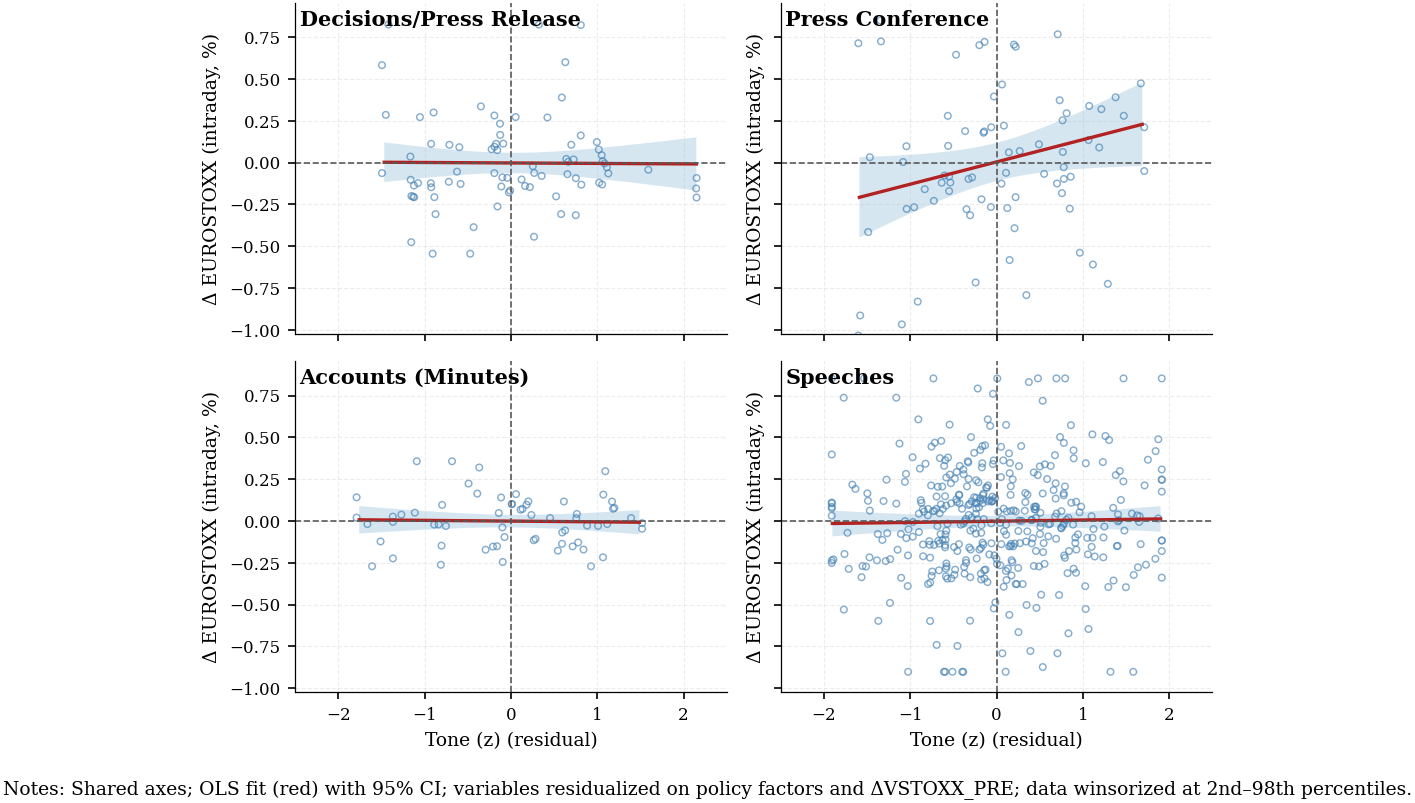

Saved: results\intraday\figs_pub\EUROSTOXX_PR_scatter.png | results\intraday\figs_pub\EUROSTOXX_PR_scatter.pdf
Saved: results\intraday\figs_pub\EUROSTOXX_PC_scatter.png | results\intraday\figs_pub\EUROSTOXX_PC_scatter.pdf
Saved: results\intraday\figs_pub\EUROSTOXX_ACC_scatter.png | results\intraday\figs_pub\EUROSTOXX_ACC_scatter.pdf
Saved: results\intraday\figs_pub\EUROSTOXX_SPEECH_scatter.png | results\intraday\figs_pub\EUROSTOXX_SPEECH_scatter.pdf


In [36]:
# ============================================
# EUROSTOXX vs Tone (Intraday) — by Channel
# Compact 2x2 + per-panel exports (Overleaf)
# ============================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from pathlib import Path

# Expect these dataframes to already exist in memory:
#   dat_pr, dat_pc, dat_acc, dat_sp
# Each must include: ['asset','tone_z','delta'] and (optionally) ['Ftarget','Ffg','Fqe','ΔVSTOXX_PRE']

CTRL_COLS = ["Ftarget","Ffg","Fqe","ΔVSTOXX_PRE"]

# --- styling (matches your descriptives aesthetic) ---
plt.rcParams.update({
    "figure.dpi": 150,
    "font.size": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.6,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

OUT_DIR = Path("results/intraday/figs_pub")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def residualize(df, ycol, xcol, controls):
    """Return residualized x*, y* after partialling out controls (if present)."""
    Y = pd.to_numeric(df[ycol], errors="coerce")
    X = pd.to_numeric(df[xcol], errors="coerce")
    C = df[[c for c in controls if c in df.columns]].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    ok = Y.notna() & X.notna()
    if C.shape[1] > 0:
        ok &= np.isfinite(C.to_numpy()).all(axis=1)
    Y, X, C = Y[ok], X[ok], C.loc[ok]
    if C.shape[1] > 0:
        Cy = sm.add_constant(C, has_constant="add")
        Cx = Cy
        Y = Y - sm.OLS(Y, Cy).fit().fittedvalues
        X = X - sm.OLS(X, Cx).fit().fittedvalues
    return X.to_numpy(), Y.to_numpy()

def winsorize(a, lo=0.02, hi=0.98):
    lo_v, hi_v = np.nanquantile(a, [lo, hi])
    return np.clip(a, lo_v, hi_v)

def ols_line_ci(x, y):
    X = sm.add_constant(x, has_constant="add")
    res = sm.OLS(y, X).fit()
    xx = np.linspace(np.nanpercentile(x, 2), np.nanpercentile(x, 98), 200)
    XX = sm.add_constant(xx, has_constant="add")
    yy = res.predict(XX)
    se_pred = np.sqrt(np.sum((XX @ res.cov_params()) * XX, axis=1))
    crit = t.ppf(0.975, df=max(res.nobs - 2, 1))
    ylo, yhi = yy - crit*se_pred, yy + crit*se_pred
    return xx, yy, ylo, yhi

def prepare_xy(df, asset="EUROSTOXX", partial=True, wins=(0.02, 0.98)):
    sub = df[df["asset"] == asset].copy()
    if sub.empty:
        return np.array([]), np.array([])
    if partial:
        x, y = residualize(sub, "delta", "tone_z", CTRL_COLS)
    else:
        x = pd.to_numeric(sub["tone_z"], errors="coerce").to_numpy()
        y = pd.to_numeric(sub["delta"],  errors="coerce").to_numpy()
        ok = np.isfinite(x) & np.isfinite(y)
        x, y = x[ok], y[ok]
    if len(x) == 0:
        return x, y
    x = winsorize(x, *wins)
    y = winsorize(y, *wins)
    return x, y

def plot_2x2(dat_pr, dat_pc, dat_acc, dat_sp, partial=True, savepath=None):
    panels = [
        ("Decisions/Press Release", dat_pr),
        ("Press Conference",        dat_pc),
        ("Accounts (Minutes)",      dat_acc),
        ("Speeches",                dat_sp),
    ]

    # Precompute cleaned arrays for shared limits
    cleaned = [prepare_xy(df, partial=partial) for _, df in panels]
    Xall = np.concatenate([c[0] for c in cleaned if len(c[0]) > 0]) if any(len(c[0]) > 0 for c in cleaned) else np.array([0, 1])
    Yall = np.concatenate([c[1] for c in cleaned if len(c[1]) > 0]) if any(len(c[1]) > 0 for c in cleaned) else np.array([0, 1])

    xlim = (-2.5, 2.5)  # symmetric across panels
    yrng = (np.nanpercentile(Yall, 2), np.nanpercentile(Yall, 98))
    pad = 0.07 * (yrng[1] - yrng[0] + 1e-9)
    ylim = (yrng[0] - pad, yrng[1] + pad)

    # Compact canvas for readability in Overleaf composites
    fig, ax = plt.subplots(2, 2, figsize=(7, 5.5), sharex=True, sharey=True)
    axes = ax.ravel()

    for axi, (title, df), (x, y) in zip(axes, panels, cleaned):
        if len(x) == 0:
            axi.text(0.5, 0.5, "No data", ha="center", va="center")
            continue

        # scatter (hollow blue), red OLS line, CI band
        axi.scatter(x, y, s=10, alpha=0.65, facecolors="none", edgecolors="steelblue", linewidths=0.7)
        xx, yy, ylo, yhi = ols_line_ci(x, y)
        axi.plot(xx, yy, linewidth=1.6, color="firebrick")
        axi.fill_between(xx, ylo, yhi, alpha=0.18)

        # reference axes
        axi.axhline(0, color="0.35", lw=0.8, ls="--")
        axi.axvline(0, color="0.35", lw=0.8, ls="--")

        # panel label (no title/slope/N)
        axi.text(0.01, 0.98, title, transform=axi.transAxes,
                 ha="left", va="top", fontsize=10, fontweight="bold")

        axi.set_xlim(*xlim); axi.set_ylim(*ylim)
        axi.grid(True, which="major", lw=0.55, alpha=0.22)

    # axis labels (x only on bottom row)
    axes[2].set_xlabel("Tone (z) (residual)" if partial else "Tone (z)")
    axes[3].set_xlabel("Tone (z) (residual)" if partial else "Tone (z)")
    for a in axes:
        a.set_ylabel("Δ EUROSTOXX (intraday, %)")

    # compact caption
    fig.text(0.5, 0.01,
             "Notes: Shared axes; OLS fit (red) with 95% CI; variables residualized on policy factors and ΔVSTOXX_PRE; "
             "data winsorized at 2nd–98th percentiles.",
             ha="center", fontsize=9)

    plt.tight_layout(rect=[0, 0.04, 1, 0.995])

    if savepath:
        fig.savefig(savepath, dpi=600, bbox_inches="tight")
    plt.show()  # show inline in VS Code

    return xlim, ylim

def export_single_panel(df, outstem, xlim, ylim, partial=True):
    """Export small single panel (PNG+PDF) for Overleaf 4-up composition."""
    x, y = prepare_xy(df, partial=partial)
    fig, ax = plt.subplots(figsize=(3, 2))  # compact single panel
    if len(x) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
    else:
        ax.scatter(x, y, s=10, alpha=0.65, facecolors="none", edgecolors="steelblue", linewidths=0.7)
        xx, yy, ylo, yhi = ols_line_ci(x, y)
        ax.plot(xx, yy, linewidth=1.6, color="firebrick")
        ax.fill_between(xx, ylo, yhi, alpha=0.18)
        ax.axhline(0, color="0.35", lw=0.8)
        ax.axvline(0, color="0.35", lw=0.8, ls="--")

    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_ylabel("Δ EUROSTOXX (intraday, %)")
    ax.set_xlabel("Tone (z) (residual)" if partial else "Tone (z)")
    ax.grid(True, which="major", lw=0.55, alpha=0.22)
    plt.tight_layout()

    png = OUT_DIR / f"{outstem}.png"
    pdf = OUT_DIR / f"{outstem}.pdf"
    plt.savefig(png, dpi=600, bbox_inches="tight")
    plt.savefig(pdf, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {png} | {pdf}")

# ===== RUN =====
# 2×2 inline + save compact composite
xlim, ylim = plot_2x2(dat_pr, dat_pc, dat_acc, dat_sp, partial=True,
                      savepath=OUT_DIR / "EUROSTOXX_tone_by_channel_2x2.png")

# Single panels (use in Overleaf with subfigure/subcaption)
export_single_panel(dat_pr, "EUROSTOXX_PR_scatter",     xlim, ylim, partial=True)
export_single_panel(dat_pc, "EUROSTOXX_PC_scatter",     xlim, ylim, partial=True)
export_single_panel(dat_acc,"EUROSTOXX_ACC_scatter",    xlim, ylim, partial=True)
export_single_panel(dat_sp, "EUROSTOXX_SPEECH_scatter", xlim, ylim, partial=True)


## **Daily-frequency Regression Analysis**

### Factor Construction PCA

In [37]:
# =============================================================================
# DAILY POLICY-NEWS FACTORS (from intraday PCA) — date-level aggregation
#   Purpose: carry the clean, intraday-identified Target/FG/QE shocks into
#            the daily panel by summing within calendar date (per channel).
#   Inputs  (already created by your intraday PCA scripts):
#       data/analysis/controls/mpd_pr_pca_factors.csv
#       data/analysis/controls/mpd_pc_pca_factors.csv
#       data/analysis/controls/acc_pca_factors.csv
#       data/analysis/controls/speeches_pca_factors.csv
#       ... and their corresponding *_pca_loadings.csv (for printing)
#   Outputs:
#       data/analysis/controls/daily_mpd_pr_pca_factors.csv
#       data/analysis/controls/daily_mpd_pc_pca_factors.csv
#       data/analysis/controls/daily_acc_pca_factors.csv
#       data/analysis/controls/daily_speeches_pca_factors.csv
#   Notes: we SUM within date (sum≈mean up to scale); this treats multiple
#          same-day events as additive policy shocks. Change `how="sum"` to
#          "mean" below if you prefer averaging.
# =============================================================================

import pandas as pd
from pathlib import Path

CTRL_DIR = Path("data/analysis/controls")
OUT_DIR  = CTRL_DIR  # keep in same folder for consistency
CHANNELS = {
    "mpd_pr":  {"fact": CTRL_DIR / "mpd_pr_pca_factors.csv",
                "load": CTRL_DIR / "mpd_pr_pca_loadings.csv"},
    "mpd_pc":  {"fact": CTRL_DIR / "mpd_pc_pca_factors.csv",
                "load": CTRL_DIR / "mpd_pc_pca_loadings.csv"},
    "acc":     {"fact": CTRL_DIR / "acc_pca_factors.csv",
                "load": CTRL_DIR / "acc_pca_loadings.csv"},
    "speeches":{"fact": CTRL_DIR / "speeches_pca_factors.csv",
                "load": CTRL_DIR / "speeches_pca_loadings.csv"},
}

FACTOR_COLS = ["F_target","F_fg","F_qe"]

def _read_factors(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p)
    # normalize column names
    lc = {c.lower(): c for c in df.columns}
    # accept either 'event_date' or 'date'
    dcol = lc.get("event_date") or lc.get("date")
    if dcol is None:
        raise KeyError(f"{p.name}: no event_date/date column found.")
    out = df.rename(columns={dcol: "event_date"}).copy()
    # keep only needed
    keep = ["event_date"] + [c for c in FACTOR_COLS if c in out.columns]
    out = out[keep].dropna(subset=["event_date"])
    out["event_date"] = pd.to_datetime(out["event_date"], errors="coerce").dt.normalize()
    return out.dropna(subset=["event_date"])

def aggregate_to_daily(df: pd.DataFrame, how: str = "sum") -> pd.DataFrame:
    if how not in {"sum","mean"}:
        raise ValueError("how must be 'sum' or 'mean'")
    agg = {c: how for c in FACTOR_COLS if c in df.columns}
    out = (df.groupby("event_date", as_index=False)
             .agg(**{c:(c, how) for c in agg.keys()}))
    # tidy column names (pandas ≥2.0 names tuples; above fixes it already)
    return out.sort_values("event_date")

def print_loadings(label: str, path: Path, max_rows: int = 7):
    try:
        L = pd.read_csv(path)
        # Expect columns: maturity, Target, FG, QE
        cols = ["maturity","Target","FG","QE"]
        if all(c in L.columns for c in cols):
            print(f"\nLOADINGS — {label.upper()} (first {max_rows} rows)")
            print(L[cols].head(max_rows).to_string(index=False))
        else:
            print(f"\n[warn] Could not find expected loading columns in {path.name}.")
    except Exception as e:
        print(f"\n[warn] Unable to read loadings for {label}: {e}")

def run():
    for lab, paths in CHANNELS.items():
        fpath = paths["fact"]
        if not fpath.exists():
            print(f"[{lab}] Missing factors file → {fpath}")
            continue

        df = _read_factors(fpath)
        if not set(FACTOR_COLS).issubset(df.columns):
            print(f"[{lab}] {fpath.name} missing one of {FACTOR_COLS}")
            continue

        daily = aggregate_to_daily(df, how="sum")  # use "mean" if preferred
        out_path = OUT_DIR / f"daily_{lab}_pca_factors.csv"
        daily.to_csv(out_path, index=False)

        # Print a concise summary and loadings preview
        n_dates = len(daily)
        d0, d1 = (daily["event_date"].min(), daily["event_date"].max()) if n_dates else (None, None)
        print(f"\n[{lab.upper()}] Daily PCA factors written → {out_path.name} | dates={n_dates} | span={d0}→{d1}")
        print(daily.tail(3).to_string(index=False))  # last few rows as a quick check
        print_loadings(lab, paths["load"])

if __name__ == "__main__":
    run()



[MPD_PR] Daily PCA factors written → daily_mpd_pr_pca_factors.csv | dates=80 | span=2015-01-22 00:00:00→2024-12-12 00:00:00
event_date  F_target   F_fg    F_qe
2024-09-12   -0.2879 0.3682 -0.3342
2024-10-17   -0.4451 0.1979  0.4824
2024-12-12    0.2035 0.5389 -0.6574

LOADINGS — MPD_PR (first 7 rows)
maturity  Target      FG      QE
  OIS_1M  0.9928  0.0000  0.0000
  OIS_3M  0.1927 -0.8859 -0.4952
  OIS_6M  0.1077 -0.9925 -0.2700
  OIS_1Y -0.1366 -1.0257  0.0729
  OIS_2Y -0.1733 -0.7737  0.4174
  OIS_5Y -0.0085 -0.4113  0.7510
 OIS_10Y  0.2066  0.0000  1.0317

[MPD_PC] Daily PCA factors written → daily_mpd_pc_pca_factors.csv | dates=80 | span=2015-01-22 00:00:00→2024-12-12 00:00:00
event_date  F_target    F_fg    F_qe
2024-09-12    0.1786 -1.6514  0.4859
2024-10-17    0.7552  2.0453 -0.8086
2024-12-12   -0.0417 -1.7442  1.7726

LOADINGS — MPD_PC (first 7 rows)
maturity  Target      FG      QE
  OIS_1M  0.9738 -0.0000 -0.0000
  OIS_3M  0.1728 -1.2787 -0.5634
  OIS_6M -0.2325 -0.6252  0

### Daily Frequency Regression (baseline)

In [38]:
# ============================================================
# DAILY REGRESSIONS — Baseline with Daily PCA + Macro Overlaps
#   ΔAsset_t = α_i + β·Tone_t^k + Θ'F_t^k + φ·ΔVSTOXX_t + λ'M_t + δ·D_FOMC_t
#             + DOW FE + Month FE + Asset FE + ε_t
#   SEs two-way clustered by (date, asset)
#   Prints journal-style 4-column table (PR, PC, ACC, SPEECH)
# ============================================================
import numpy as np
import pandas as pd
from pathlib import Path
import re
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster_2groups
import scipy.stats as sps

# ---------- paths ----------
DATA_DAILY = Path("Financial Datasets")
OUT_DIR    = Path("results/daily"); OUT_DIR.mkdir(parents=True, exist_ok=True)

P_EUROSTOXX = DATA_DAILY / "daily_eurostoxx.xlsx"
P_EURUSD    = DATA_DAILY / "daily_eurusd.xlsx"
P_GOV2Y     = DATA_DAILY / "daily_govt_yield_2y.xlsx"
P_GOV10Y    = DATA_DAILY / "daily_govt_yield_10y.xlsx"
P_BUND_FUT  = DATA_DAILY / "daily_german_bund_futures.xlsx"
P_BTP_FUT   = DATA_DAILY / "daily_italian_btp_futures.xlsx"
P_VSTOXX    = DATA_DAILY / "daily_vstoxx.xlsx"
P_FOMC      = DATA_DAILY / "fomc_days.xlsx"
P_IG_CDS    = DATA_DAILY / "daily_investment_grade_cds.xlsx" 
P_HY_CDS    = DATA_DAILY / "daily_high_yield_cds.xlsx"

# tone sources (event-level → collapse to date)
MPD_PR_LONG = Path("data/analysis/mpd/mpd_press_release_long_with_tone.csv")
MPD_PC_LONG = Path("data/analysis/pc/pc_long_with_tone.csv")
ACC_LONG    = Path("data/analysis/acc/acc_long_with_tone.csv")
SPCH_DAILY  = Path("data/processed/ecbcsv_speech_tone_daily.csv")  # has 'date', 'hd_index_dict_all_z'

# DAILY PCA factors (created earlier)
FAC_D_MPDR = Path("data/analysis/controls/daily_mpd_pr_pca_factors.csv")
FAC_D_MPDC = Path("data/analysis/controls/daily_mpd_pc_pca_factors.csv")
FAC_D_ACC  = Path("data/analysis/controls/daily_acc_pca_factors.csv")
FAC_D_SPE  = Path("data/analysis/controls/daily_speeches_pca_factors.csv")

# Macro calendars
EA_CAL  = DATA_DAILY / "controls_final.xlsx"        # Euro-area calendar (incl. many countries)
US_CAL  = DATA_DAILY / "macro_us_calendar.xlsx" 

START = pd.Timestamp("2015-01-01")
END   = pd.Timestamp("2024-12-31")

# ---------- helpers ----------
def _need(p: Path, label: str):
    if not p.exists():
        raise FileNotFoundError(f"Missing {label}: {p}")

def load_generic_series(path: Path, label: str):
    _need(path, label)
    df = pd.read_excel(path)
    # pick date-like column
    dcol = next((c for c in df.columns if "date" in c.lower()), df.columns[0])
    # coerce others numeric and pick last non-date as value
    for c in df.columns:
        if c != dcol:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    vcol = [c for c in df.columns if c != dcol][-1]
    out = df[[dcol, vcol]].copy()
    out.columns = ["date", "value"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = (out.dropna(subset=["date","value"])
              .sort_values("date")
              .drop_duplicates("date", keep="last"))
    return out

def series_to_change(df: pd.DataFrame, kind: str):
    df = df.copy().sort_values("date")
    if kind == "logret":
        df["delta"] = np.log(df["value"]).diff()
    elif kind == "diff":
        df["delta"] = df["value"].diff()
    else:
        raise ValueError("kind must be 'logret' or 'diff'")
    return df.dropna(subset=["delta"])[["date","delta"]]

def load_assets_panel():
    eurost = series_to_change(load_generic_series(P_EUROSTOXX, "EUROSTOXX"), "logret").assign(asset="EUROSTOXX")
    eurusd = series_to_change(load_generic_series(P_EURUSD,    "EURUSD"),    "logret").assign(asset="EURUSD")
    y2     = series_to_change(load_generic_series(P_GOV2Y,     "GOVY_2Y"),   "diff").assign(asset="GOVY_2Y")
    y10    = series_to_change(load_generic_series(P_GOV10Y,    "GOVY_10Y"),  "diff").assign(asset="GOVY_10Y")

    bund   = series_to_change(load_generic_series(P_BUND_FUT,  "BUND_FUT"),  "diff").rename(columns={"delta":"d_bund"})
    btp    = series_to_change(load_generic_series(P_BTP_FUT,   "BTP_FUT"),   "diff").rename(columns={"delta":"d_btp"})
    spread = (btp.merge(bund, on="date", how="inner")
                .assign(delta=lambda d: d["d_btp"] - d["d_bund"])
                [["date","delta"]]
                .assign(asset="IT_DE_FUT_SPREAD"))
    
        # --- NEW: IG & HY CDS (levels → daily diffs) + HY-IG spread ---
    igL = load_generic_series(P_IG_CDS, "IG_CDS").rename(columns={"value":"ig"})
    hyL = load_generic_series(P_HY_CDS, "HY_CDS").rename(columns={"value":"hy"})

    IG_CDS = series_to_change(igL.rename(columns={"ig":"value"})[["date","value"]], "diff").assign(asset="IG_CDS")
    HY_CDS = series_to_change(hyL.rename(columns={"hy":"value"})[["date","value"]], "diff").assign(asset="HY_CDS")

    # spread level = HY - IG, then daily change of that spread
    sp = hyL.merge(igL, on="date", how="inner")
    sp = sp.assign(value=sp["hy"] - sp["ig"])[["date","value"]]
    HY_IG_SPREAD = series_to_change(sp, "diff").assign(asset="HY_IG_SPREAD")

    panel = pd.concat(
        [
            eurost, eurusd, y2, y10, spread,     # existing
            IG_CDS, HY_CDS, HY_IG_SPREAD         # NEW
        ],
        ignore_index=True
    )
    panel["date"] = pd.to_datetime(panel["date"])
    panel = panel[(panel["date"]>=START) & (panel["date"]<=END)].copy()
    panel["dow"]   = panel["date"].dt.dayofweek
    panel["month"] = panel["date"].dt.month
    return panel

def load_vstoxx_change():
    v = series_to_change(load_generic_series(P_VSTOXX, "VSTOXX"), "diff")
    v["date"] = pd.to_datetime(v["date"])
    v = v[(v["date"]>=START) & (v["date"]<=END)].copy()
    v = v.rename(columns={"delta":"DVSTOXX"})
    return v

def load_fomc_dummy():
    _need(P_FOMC, "FOMC calendar")
    f = pd.read_excel(P_FOMC)
    dcol = next((c for c in f.columns if "date" in c.lower()), f.columns[0])
    f = f[[dcol]].copy(); f.columns = ["date"]
    f["date"] = pd.to_datetime(f["date"], errors="coerce")
    f = f.dropna(subset=["date"]).drop_duplicates("date")
    f["D_FOMC"] = 1
    return f

def collapse_tone_from_file(path: Path, label: str,
                            date_col_opts=("event_date","date","Date"),
                            tone_col_opts=("tone_z","tone_z_event","hd_index_dict_all_z")):
    _need(path, f"{label} tone file")
    df = pd.read_csv(path) if path.suffix.lower()==".csv" else pd.read_excel(path)
    lc = {c.lower(): c for c in df.columns}
    dcol = next((lc[c.lower()] for c in date_col_opts if c.lower() in lc), None)
    if dcol is None:
        raise KeyError(f"{label}: no date column among {date_col_opts}. Got {list(df.columns)}")
    tcol = next((lc[c.lower()] for c in tone_col_opts if c.lower() in lc), None)
    if tcol is None:
        raise KeyError(f"{label}: missing tone column among {tone_col_opts}. Got {list(df.columns)}")
    out = df[[dcol, tcol]].copy()
    out.columns = ["date", "tone"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out["tone"] = pd.to_numeric(out["tone"], errors="coerce")
    out = (out.dropna(subset=["date","tone"])
              .groupby("date", as_index=False)
              .agg(tone=("tone","mean")))
    out = out[(out["date"]>=START) & (out["date"]<=END)].copy()
    return out

# ---------- macro overlap dummies ----------
def _find_col(df, candidates):
    lc = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lc: return lc[c.lower()]
    return None

def _contains(s, *subs):
    s0 = str(s).lower()
    return all(sub.lower() in s0 for sub in subs)

def load_macro_ea(path_ea: Path) -> pd.DataFrame:
    """
    Build EA (area-level) macro dummies by date:
      EA_CPI_flash, EA_PMI_flash (Composite), EA_GDP
    Heuristic matching on common text patterns; restrict to Euro Area rows.
    """
    _need(path_ea, "EA macro calendar")
    df = pd.read_excel(path_ea)
    # identify key columns flexibly
    dcol = _find_col(df, ["date","day","release date"])
    icol = _find_col(df, ["series","indicator","event","title","name"])
    areacol = _find_col(df, ["c","country","area","region"])
    if dcol is None or icol is None or areacol is None:
        # graceful empty output if structure unexpected
        return pd.DataFrame(columns=["date","EA_CPI_flash","EA_PMI_flash","EA_GDP"])
    x = df[[dcol, icol, areacol]].copy()
    x.columns = ["date","event","area"]
    x["date"] = pd.to_datetime(x["date"], errors="coerce")
    x = x.dropna(subset=["date","event"])
    # keep euro area only
    x = x[x["area"].astype(str).str.upper().isin(["EC","EA","EUROZONE","EURO AREA","EMU"])].copy()

    # build flags
    x["EA_CPI_flash"]  = x["event"].apply(lambda s: int(_contains(s,"cpi") and (_contains(s,"flash") or _contains(s,"estimate"))))
    x["EA_PMI_flash"]  = x["event"].apply(lambda s: int(_contains(s,"pmi") and _contains(s,"composite") and _contains(s,"flash")))
    x["EA_GDP"]        = x["event"].apply(lambda s: int(_contains(s,"gdp") and (_contains(s,"qoq") or _contains(s,"quarter"))))

    g = (x.groupby("date", as_index=False)
          .agg(EA_CPI_flash=("EA_CPI_flash","max"),
               EA_PMI_flash=("EA_PMI_flash","max"),
               EA_GDP=("EA_GDP","max")))
    g = g[(g["date"]>=START) & (g["date"]<=END)].copy()
    return g

def load_macro_us(path_us: Path) -> pd.DataFrame:
    """
    Build US macro dummies by date:
      US_CPI, US_NFP, US_CorePCE
    """
    _need(path_us, "US macro calendar")
    df = pd.read_excel(path_us)
    dcol = _find_col(df, ["date","day","release date"])
    icol = _find_col(df, ["series","indicator","event","title","name"])
    if dcol is None or icol is None:
        return pd.DataFrame(columns=["date","US_CPI","US_NFP","US_CorePCE"])
    x = df[[dcol, icol]].copy()
    x.columns = ["date","event"]
    x["date"] = pd.to_datetime(x["date"], errors="coerce")
    x = x.dropna(subset=["date","event"])

    x["US_CPI"]     = x["event"].apply(lambda s: int(_contains(s,"cpi")))
    # NFP variants
    x["US_NFP"]     = x["event"].apply(lambda s: int(_contains(s,"nonfarm") or _contains(s,"payroll")))
    # Core PCE variants
    x["US_CorePCE"] = x["event"].apply(lambda s: int(_contains(s,"core") and _contains(s,"pce")))
    g = (x.groupby("date", as_index=False)
          .agg(US_CPI=("US_CPI","max"),
               US_NFP=("US_NFP","max"),
               US_CorePCE=("US_CorePCE","max")))
    g = g[(g["date"]>=START) & (g["date"]<=END)].copy()
    return g

# ---------- clustering + formatting ----------
def cluster_df(g1, g2):
    G1 = pd.Series(pd.to_datetime(g1)).nunique()
    G2 = pd.Series(g2).nunique()
    return max(min(G1-1, G2-1), 1)

def two_way_cluster_ols(y, X, g1, g2):
    X_ = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, X_).fit()
    cov = cov_cluster_2groups(
        res,
        pd.factorize(pd.to_datetime(g1))[0],
        pd.factorize(g2)[0]
    )
    res.cov_params_default = cov
    return res

def stars(p): return "***" if p<=0.01 else ("**" if p<=0.05 else ("*" if p<=0.10 else ""))

def fmt_cell(res, term, df):
    if term not in res.params.index: return ""
    b  = res.params[term]
    se = float(np.sqrt(res.cov_params().loc[term, term]))
    t  = b / se if se>0 else np.nan
    p  = 2 * (1 - sps.t.cdf(abs(t), df)) if np.isfinite(t) else np.nan
    return f"{b:+.3f} [{se:.3f}]{stars(p)}"

# ---------- build data ----------
panel = load_assets_panel()       # date, asset, delta, dow, month
vst   = load_vstoxx_change()     # date, DVSTOXX
fomc  = load_fomc_dummy()        # date, D_FOMC
ea    = load_macro_ea(EA_CAL)    # date, EA_* dummies
usm   = load_macro_us(US_CAL)    # date, US_* dummies

# tones per channel (date-level)
tone_ACC = collapse_tone_from_file(ACC_LONG,    "ACC")
tone_PR  = collapse_tone_from_file(MPD_PR_LONG, "MPD_PR")
tone_PC  = collapse_tone_from_file(MPD_PC_LONG, "MPD_PC")
tone_SP  = collapse_tone_from_file(SPCH_DAILY,  "SPEECHES",
                                   date_col_opts=("date","event_date"),
                                   tone_col_opts=("hd_index_dict_all_z","tone_z","tone_z_event"))

# daily PCA per channel
def load_daily_pca(path: Path, label: str):
    _need(path, f"{label} daily PCA")
    f = pd.read_csv(path)
    lc = {c.lower(): c for c in f.columns}
    dcol = lc.get("event_date","event_date") if "event_date" in lc else list(f.columns)[0]
    out = f[[dcol, lc.get("f_target","F_target"), lc.get("f_fg","F_fg"), lc.get("f_qe","F_qe")]].copy()
    out.columns = ["date","F_target","F_fg","F_qe"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    return out.dropna(subset=["date"])

FAC_D = {
    "MPD_PR":  load_daily_pca(FAC_D_MPDR, "MPD_PR"),
    "MPD_PC":  load_daily_pca(FAC_D_MPDC, "MPD_PC"),
    "ACC":     load_daily_pca(FAC_D_ACC,  "ACC"),
    "SPEECH":  load_daily_pca(FAC_D_SPE,  "SPEECH"),
}

tones = {"MPD_PR": tone_PR, "MPD_PC": tone_PC, "ACC": tone_ACC, "SPEECH": tone_SP}

# ---------- runner ----------
results = {}
for label, tone_df in tones.items():
    dat = (panel.merge(tone_df, on="date", how="inner")   # event days only
                 .merge(FAC_D[label], on="date", how="left")
                 .merge(vst,  on="date", how="left")
                 .merge(fomc, on="date", how="left")
                 .merge(ea,   on="date", how="left")
                 .merge(usm,  on="date", how="left"))
    # fill zeros for macro/fomc
    for c in ["D_FOMC","EA_CPI_flash","EA_PMI_flash","EA_GDP","US_CPI","US_NFP","US_CorePCE"]:
        if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
        else: dat[c] = 0

    # FE: DoW, Month, Asset
    X = pd.concat([
        dat[["tone","F_target","F_fg","F_qe","DVSTOXX",
             "D_FOMC","EA_CPI_flash","EA_PMI_flash","EA_GDP","US_CPI","US_NFP","US_CorePCE"]],
        pd.get_dummies(dat["dow"],   prefix="DOW",  drop_first=True, dtype=float),
        pd.get_dummies(dat["month"], prefix="MON",  drop_first=True, dtype=float),
        pd.get_dummies(dat["asset"], prefix="A",    drop_first=True, dtype=float),
    ], axis=1).apply(pd.to_numeric, errors="coerce")

    mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(dat["delta"].to_numpy())
    X = X.loc[mask]; y = dat.loc[mask, "delta"].to_numpy()
    g1 = dat.loc[mask, "date"]; g2 = dat.loc[mask, "asset"]

    if len(y) <= (X.shape[1] + 1):
        print(f"[{label}] Too few observations after merges (N={len(y)}).")
        results[label] = None
        continue

    res = two_way_cluster_ols(y, X, g1, g2)
    dfc = cluster_df(g1, g2)

    # Save CSV for record
    b = res.params; se = np.sqrt(np.diag(res.cov_params()))
    p = 2*(1 - sps.t.cdf(np.abs(b/se), dfc))
    td = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "p": p})
    td.to_csv(OUT_DIR / f"{label}_daily_coef_table_WITH_PCA_MACRO.csv", index=False)

    results[label] = {"res":res, "df":dfc, "N":int(res.nobs)}

# ---------- print consolidated journal-style table ----------
labels_print = ["MPD_PR","MPD_PC","ACC","SPEECH"]
col_names = ["Press Release","Press Conf.","Accounts","Speeches"]
rows = [
    "Intercept","Tone (z)",
    "Target factor","FG factor","QE factor",
    "ΔVSTOXX","FOMC day",
    "EA CPI flash","EA PMI flash","EA GDP",
    "US CPI","US NFP","US Core PCE"
]
term_map = {
    "Intercept":"const", "Tone (z)":"tone",
    "Target factor":"F_target","FG factor":"F_fg","QE factor":"F_qe",
    "ΔVSTOXX":"DVSTOXX","FOMC day":"D_FOMC",
    "EA CPI flash":"EA_CPI_flash","EA PMI flash":"EA_PMI_flash","EA GDP":"EA_GDP",
    "US CPI":"US_CPI","US NFP":"US_NFP","US Core PCE":"US_CorePCE"
}

tbl = pd.DataFrame(index=rows, columns=col_names)
r2  = []; r2a = []; N = []
for lab, col in zip(labels_print, col_names):
    if results.get(lab) is None: continue
    res = results[lab]["res"]; dfc = results[lab]["df"]
    for r in rows:
        tbl.loc[r, col] = fmt_cell(res, term_map[r], dfc)
    r2.append((col, f"{res.rsquared:.3f}"))
    r2a.append((col, f"{res.rsquared_adj:.3f}"))
    N.append((col, f"{results[lab]['N']}"))

footer = pd.DataFrame(index=["DoW FE","Month FE","Asset FE","R-squared","Adj. R-squared","N"], columns=col_names)
for col in col_names:
    footer.loc["DoW FE", col]   = "Yes"
    footer.loc["Month FE", col] = "Yes"
    footer.loc["Asset FE", col] = "Yes"
    footer.loc["R-squared", col]      = dict(r2).get(col, "")
    footer.loc["Adj. R-squared", col] = dict(r2a).get(col, "")
    footer.loc["N", col]              = dict(N).get(col, "")

pd.options.display.width = 200; pd.options.display.max_colwidth = 32
print("\nTABLE. Daily pooled regressions by channel (coef [SE] with two-way clustered p-value stars)")
print(tbl.fillna("").to_string())
print("\nFooters:")
print(footer.fillna("").to_string())
print("\n✅ Done. CSVs in:", OUT_DIR.resolve())


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\1239639093.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\1239639093.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\1239639093.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obj


TABLE. Daily pooled regressions by channel (coef [SE] with two-way clustered p-value stars)
                   Press Release        Press Conf.           Accounts           Speeches
Intercept         -0.036 [1.581]     +0.356 [1.559]     +0.682 [0.891]     -0.399 [0.323]
Tone (z)          -0.010 [0.229]     +0.248 [0.235]    +0.556 [0.270]*     +0.128 [0.069]
Target factor     +0.072 [0.439]     +0.170 [0.244]     -0.186 [0.279]    +0.115 [0.059]*
FG factor         +0.514 [0.448]     -0.122 [0.335]     -0.179 [0.246]   +0.165 [0.062]**
QE factor         +0.735 [0.426]     +0.389 [0.336]     -0.153 [0.262]   +0.180 [0.061]**
ΔVSTOXX        +1.135 [0.100]***  +1.164 [0.095]***  +1.084 [0.287]***  +0.683 [0.039]***
FOMC day          -0.000 [0.000]     +0.000 [0.000]     -0.000 [0.000]     -0.000 [0.000]
EA CPI flash      +0.000 [0.000]     +0.000 [0.000]     +0.000 [0.000]     -0.000 [0.000]
EA PMI flash      -0.000 [0.000]     -0.000 [0.000]     -0.000 [0.000]     +0.000 [0.000]
EA GDP 

### Asset wide

In [39]:
# ============================================================
# DAILY REGRESSIONS — Asset–Channel Mapping (by asset, per channel)
# Robustness: include DAILY PCA policy factors + macro overlap dummies
# Prints journal-style console tables (coef [SE] + stars) per channel.
# SEs: one-way clustered by DATE (per-asset regression).
# ============================================================
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
import scipy.stats as sps

# ---------- paths ----------
DATA_DAILY = Path("Financial Datasets")
OUT_DIR    = Path("results/daily_asset_channel"); OUT_DIR.mkdir(parents=True, exist_ok=True)

P_EUROSTOXX = DATA_DAILY / "daily_eurostoxx.xlsx"
P_EURUSD    = DATA_DAILY / "daily_eurusd.xlsx"
P_GOV2Y     = DATA_DAILY / "daily_govt_yield_2y.xlsx"
P_GOV10Y    = DATA_DAILY / "daily_govt_yield_10y.xlsx"
P_BUND_FUT  = DATA_DAILY / "daily_german_bund_futures.xlsx"
P_BTP_FUT   = DATA_DAILY / "daily_italian_btp_futures.xlsx"
P_VSTOXX    = DATA_DAILY / "daily_vstoxx.xlsx"
P_FOMC      = DATA_DAILY / "fomc_days.xlsx"

# NEW: credit series (levels, typically bps)
P_IG_CDS = Path(r"C:\Users\Asus\Desktop\2024-25 (WBS)\Course\Dissertation\Code and Files\Financial Datasets\daily_investment_grade_cds.xlsx")
P_HY_CDS = Path(r"C:\Users\Asus\Desktop\2024-25 (WBS)\Course\Dissertation\Code and Files\Financial Datasets\daily_high_yield_cds.xlsx")

# Tone sources (event-level → collapse to date)
MPD_PR_LONG = Path("data/analysis/mpd/mpd_press_release_long_with_tone.csv")
MPD_PC_LONG = Path("data/analysis/pc/pc_long_with_tone.csv")
ACC_LONG    = Path("data/analysis/acc/acc_long_with_tone.csv")
SPCH_DAILY  = Path("data/processed/ecbcsv_speech_tone_daily.csv")  # has 'date', 'hd_index_dict_all_z'

# DAILY PCA factors (created earlier)
FAC_D_MPDR = Path("data/analysis/controls/daily_mpd_pr_pca_factors.csv")
FAC_D_MPDC = Path("data/analysis/controls/daily_mpd_pc_pca_factors.csv")
FAC_D_ACC  = Path("data/analysis/controls/daily_acc_pca_factors.csv")
FAC_D_SPE  = Path("data/analysis/controls/daily_speeches_pca_factors.csv")

# Macro calendars (EA + US)
EA_CAL  = DATA_DAILY / "controls_final.xlsx"
US_CAL  = DATA_DAILY / "macro_us_calendar.xlsx"

START = pd.Timestamp("2015-01-01")
END   = pd.Timestamp("2024-12-31")

# ---------- channel → relevant assets ----------
CHANNEL_ASSETS = {
    "MPD_PR":  ["EUROSTOXX","EURUSD","GOVY_2Y","GOVY_10Y","IT_DE_FUT_SPREAD","HY_IG_SPREAD"],
    "MPD_PC":  ["EUROSTOXX","EURUSD","GOVY_2Y","GOVY_10Y","IT_DE_FUT_SPREAD","HY_IG_SPREAD"],
    "ACC":     ["EUROSTOXX","EURUSD","GOVY_2Y","GOVY_10Y","IT_DE_FUT_SPREAD","HY_IG_SPREAD"],
    "SPEECH":  ["EUROSTOXX","EURUSD","GOVY_2Y","GOVY_10Y","IT_DE_FUT_SPREAD","HY_IG_SPREAD"],
}

# ---------- helpers ----------
def _need(p: Path, label: str):
    if not p.exists():
        raise FileNotFoundError(f"Missing {label}: {p}")

def load_generic_series(path: Path, label: str):
    _need(path, label)
    df = pd.read_excel(path) if path.suffix.lower() != ".csv" else pd.read_csv(path)
    dcol = next((c for c in df.columns if "date" in str(c).lower()), df.columns[0])
    for c in df.columns:
        if c != dcol:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    vcol = [c for c in df.columns if c != dcol][-1]
    out = df[[dcol, vcol]].copy()
    out.columns = ["date", "value"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = (out.dropna(subset=["date","value"])
              .sort_values("date")
              .drop_duplicates("date", keep="last"))
    return out

def series_to_change(df: pd.DataFrame, kind: str):
    df = df.copy().sort_values("date")
    if kind == "logret":
        df["delta"] = np.log(df["value"]).diff()
    elif kind == "diff":
        df["delta"] = df["value"].diff()
    else:
        raise ValueError("kind must be 'logret' or 'diff'")
    return df.dropna(subset=["delta"])[["date","delta"]]

def load_assets_panel():
    eurost = series_to_change(load_generic_series(P_EUROSTOXX, "EUROSTOXX"), "logret").assign(asset="EUROSTOXX")
    eurusd = series_to_change(load_generic_series(P_EURUSD,    "EURUSD"),    "logret").assign(asset="EURUSD")
    y2     = series_to_change(load_generic_series(P_GOV2Y,     "GOVY_2Y"),   "diff").assign(asset="GOVY_2Y")
    y10    = series_to_change(load_generic_series(P_GOV10Y,    "GOVY_10Y"),  "diff").assign(asset="GOVY_10Y")
    bund   = series_to_change(load_generic_series(P_BUND_FUT,  "BUND_FUT"),  "diff").rename(columns={"delta":"d_bund"})
    btp    = series_to_change(load_generic_series(P_BTP_FUT,   "BTP_FUT"),   "diff").rename(columns={"delta":"d_btp"})
    spread = (btp.merge(bund, on="date", how="inner")
                .assign(delta=lambda d: d["d_btp"] - d["d_bund"])
                [["date","delta"]]
                .assign(asset="IT_DE_FUT_SPREAD"))

    # NEW: IG & HY CDS (levels → diffs) + HY-IG spread diff
    igL = load_generic_series(P_IG_CDS, "IG_CDS").rename(columns={"value":"ig"})
    hyL = load_generic_series(P_HY_CDS, "HY_CDS").rename(columns={"value":"hy"})
    IG_CDS = series_to_change(igL.rename(columns={"ig":"value"})[["date","value"]], "diff").assign(asset="IG_CDS")
    HY_CDS = series_to_change(hyL.rename(columns={"hy":"value"})[["date","value"]], "diff").assign(asset="HY_CDS")
    spL    = hyL.merge(igL, on="date", how="inner").assign(value=lambda d: d["hy"] - d["ig"])[["date","value"]]
    HY_IG_SPREAD = series_to_change(spL, "diff").assign(asset="HY_IG_SPREAD")

    panel = pd.concat([eurost, eurusd, y2, y10, spread, HY_IG_SPREAD], ignore_index=True)
    panel["date"] = pd.to_datetime(panel["date"])
    panel = panel[(panel["date"]>=START) & (panel["date"]<=END)].copy()
    panel["dow"]   = panel["date"].dt.dayofweek
    panel["month"] = panel["date"].dt.month
    return panel

def load_vstoxx_change():
    v = series_to_change(load_generic_series(P_VSTOXX, "VSTOXX"), "diff")
    v["date"] = pd.to_datetime(v["date"])
    v = v[(v["date"]>=START) & (v["date"]<=END)].copy()
    v = v.rename(columns={"delta":"DVSTOXX"})
    return v

def load_fomc_dummy():
    _need(P_FOMC, "FOMC calendar")
    f = pd.read_excel(P_FOMC)
    dcol = next((c for c in f.columns if "date" in str(c).lower()), f.columns[0])
    f = f[[dcol]].copy(); f.columns = ["date"]
    f["date"] = pd.to_datetime(f["date"], errors="coerce")
    f = f.dropna(subset=["date"]).drop_duplicates("date")
    f["D_FOMC"] = 1
    return f

def collapse_tone_from_file(path: Path, label: str,
                            date_col_opts=("event_date","date","Date"),
                            tone_col_opts=("tone_z","tone_z_event","hd_index_dict_all_z")):
    _need(path, f"{label} tone file")
    df = pd.read_csv(path) if path.suffix.lower()==".csv" else pd.read_excel(path)
    lc = {c.lower(): c for c in df.columns}
    dcol = next((lc[c.lower()] for c in date_col_opts if c.lower() in lc), None)
    if dcol is None:
        raise KeyError(f"{label}: no date column among {date_col_opts}. Got {list(df.columns)}")
    tcol = next((lc[c.lower()] for c in tone_col_opts if c.lower() in lc), None)
    if tcol is None:
        raise KeyError(f"{label}: missing tone column among {tone_col_opts}. Got {list(df.columns)}")
    out = df[[dcol, tcol]].copy()
    out.columns = ["date", "tone"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out["tone"] = pd.to_numeric(out["tone"], errors="coerce")
    out = (out.dropna(subset=["date","tone"])
              .groupby("date", as_index=False)
              .agg(tone=("tone","mean")))
    out = out[(out["date"]>=START) & (out["date"]<=END)].copy()
    return out

# ---- daily PCA (per channel) ----
def load_daily_pca(path: Path, label: str):
    _need(path, f"{label} daily PCA")
    f = pd.read_csv(path)
    lc = {c.lower(): c for c in f.columns}
    dcol = lc.get("event_date", list(f.columns)[0])
    out = f[[dcol, lc.get("f_target","F_target"), lc.get("f_fg","F_fg"), lc.get("f_qe","F_qe")]].copy()
    out.columns = ["date","F_target","F_fg","F_qe"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    return out.dropna(subset=["date"])

# ---- macro overlaps (EA + US) ----
def _find_col(df, candidates):
    lc = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lc: return lc[c.lower()]
    return None

def _contains(s, *subs):
    s0 = str(s).lower()
    return all(sub.lower() in s0 for sub in subs)

def load_macro_ea(path_ea: Path) -> pd.DataFrame:
    _need(path_ea, "EA macro calendar")
    df = pd.read_excel(path_ea)
    dcol = _find_col(df, ["date","day","release date"])
    icol = _find_col(df, ["series","indicator","event","title","name"])
    areacol = _find_col(df, ["c","country","area","region"])
    if dcol is None or icol is None or areacol is None:
        return pd.DataFrame(columns=["date","EA_CPI_flash","EA_PMI_flash","EA_GDP"])
    x = df[[dcol, icol, areacol]].copy()
    x.columns = ["date","event","area"]
    x["date"] = pd.to_datetime(x["date"], errors="coerce")
    x = x.dropna(subset=["date","event"])
    x = x[x["area"].astype(str).str.upper().isin(["EC","EA","EUROZONE","EURO AREA","EMU"])].copy()
    x["EA_CPI_flash"] = x["event"].apply(lambda s: int(_contains(s,"cpi") and (_contains(s,"flash") or _contains(s,"estimate"))))
    x["EA_PMI_flash"] = x["event"].apply(lambda s: int(_contains(s,"pmi") and _contains(s,"composite") and _contains(s,"flash")))
    x["EA_GDP"]       = x["event"].apply(lambda s: int(_contains(s,"gdp") and (_contains(s,"qoq") or _contains(s,"quarter"))))
    g = (x.groupby("date", as_index=False)
          .agg(EA_CPI_flash=("EA_CPI_flash","max"),
               EA_PMI_flash=("EA_PMI_flash","max"),
               EA_GDP=("EA_GDP","max")))
    g = g[(g["date"]>=START) & (g["date"]<=END)].copy()
    return g

def load_macro_us(path_us: Path) -> pd.DataFrame:
    _need(path_us, "US macro calendar")
    df = pd.read_excel(path_us)
    dcol = _find_col(df, ["date","day","release date"])
    icol = _find_col(df, ["series","indicator","event","title","name"])
    if dcol is None or icol is None:
        return pd.DataFrame(columns=["date","US_CPI","US_NFP","US_CorePCE"])
    x = df[[dcol, icol]].copy()
    x.columns = ["date","event"]
    x["date"] = pd.to_datetime(x["date"], errors="coerce")
    x = x.dropna(subset=["date","event"])
    x["US_CPI"]     = x["event"].apply(lambda s: int(_contains(s,"cpi")))
    x["US_NFP"]     = x["event"].apply(lambda s: int(_contains(s,"nonfarm") or _contains(s,"payroll")))
    x["US_CorePCE"] = x["event"].apply(lambda s: int(_contains(s,"core") and _contains(s,"pce")))
    g = (x.groupby("date", as_index=False)
          .agg(US_CPI=("US_CPI","max"),
               US_NFP=("US_NFP","max"),
               US_CorePCE=("US_CorePCE","max")))
    g = g[(g["date"]>=START) & (g["date"]<=END)].copy()
    return g

def stars(p):
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

# ---------- model (single asset; DoW & Month FE; controls incl. PCA + DVSTOXX + macro + FOMC) ----------
def fit_single_asset_daily(df_asset: pd.DataFrame):
    X = pd.concat([
        df_asset[["tone","F_target","F_fg","F_qe","DVSTOXX",
                  "D_FOMC","EA_CPI_flash","EA_PMI_flash","EA_GDP","US_CPI","US_NFP","US_CorePCE"]],
        pd.get_dummies(df_asset["dow"],   prefix="DOW",  drop_first=True, dtype=float),
        pd.get_dummies(df_asset["month"], prefix="MON",  drop_first=True, dtype=float),
    ], axis=1).apply(pd.to_numeric, errors="coerce")

    y  = pd.to_numeric(df_asset["delta"], errors="coerce")
    ok = np.isfinite(y) & np.isfinite(X.to_numpy()).all(axis=1)
    if ok.sum() <= (X.shape[1] + 1):
        return None  # not enough observations

    y, X = y.loc[ok].to_numpy(), X.loc[ok]
    g    = df_asset.loc[ok, "date"]  # cluster by date
    Xc   = sm.add_constant(X, has_constant="add")
    res  = sm.OLS(y, Xc).fit()
    cov  = cov_cluster(res, pd.factorize(pd.to_datetime(g))[0])  # one-way cluster by date
    res.cov_params_default = cov

    G = g.nunique()
    df = max(G-1, 1)
    b, se = res.params, np.sqrt(np.diag(res.cov_params()))
    t = b / se
    p = 2 * (1 - sps.t.cdf(np.abs(t), df))

    out = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "p": p}).set_index("term")
    def cell(term):
        if term in out.index:
            return f"{out.loc[term,'coef']:+.3f} [{out.loc[term,'se']:.3f}]{stars(out.loc[term,'p'])}"
        return ""
    return {
        "Intercept":      cell("const"),
        "Tone (z)":       cell("tone"),
        "Target factor":  cell("F_target"),
        "FG factor":      cell("F_fg"),
        "QE factor":      cell("F_qe"),
        "ΔVSTOXX":        cell("DVSTOXX"),
        "FOMC day":       cell("D_FOMC"),
        "EA CPI flash":   cell("EA_CPI_flash"),
        "EA PMI flash":   cell("EA_PMI_flash"),
        "EA GDP":         cell("EA_GDP"),
        "US CPI":         cell("US_CPI"),
        "US NFP":         cell("US_NFP"),
        "US Core PCE":    cell("US_CorePCE"),
        "R-squared":      f"{res.rsquared:.3f}",
        "N":              f"{int(res.nobs)}"
    }

# ---------- build daily panel + tones + PCA + macro ----------
panel = load_assets_panel()
vst   = load_vstoxx_change()
fomc  = load_fomc_dummy()
ea    = load_macro_ea(EA_CAL)
usm   = load_macro_us(US_CAL)

tone_ACC = collapse_tone_from_file(ACC_LONG,    "ACC")
tone_PR  = collapse_tone_from_file(MPD_PR_LONG, "MPD_PR")
tone_PC  = collapse_tone_from_file(MPD_PC_LONG, "MPD_PC")
tone_SP  = collapse_tone_from_file(SPCH_DAILY,  "SPEECHES",
                                   date_col_opts=("date","event_date"),
                                   tone_col_opts=("hd_index_dict_all_z","tone_z","tone_z_event"))

TONES = {"MPD_PR": tone_PR, "MPD_PC": tone_PC, "ACC": tone_ACC, "SPEECH": tone_SP}
PCA_D = {
    "MPD_PR":  load_daily_pca(FAC_D_MPDR, "MPD_PR"),
    "MPD_PC":  load_daily_pca(FAC_D_MPDC, "MPD_PC"),
    "ACC":     load_daily_pca(FAC_D_ACC,  "ACC"),
    "SPEECH":  load_daily_pca(FAC_D_SPE,  "SPEECH"),
}

# ---------- run per channel over mapped assets ----------
pd.options.display.width = 220
pd.options.display.max_colwidth = 30

for ch, tone_df in TONES.items():
    dat = (panel.merge(tone_df,      on="date", how="inner")   # event days only
                 .merge(PCA_D[ch],    on="date", how="left")
                 .merge(vst,          on="date", how="left")
                 .merge(fomc,         on="date", how="left")
                 .merge(ea,           on="date", how="left")
                 .merge(usm,          on="date", how="left"))
    # fill zeros for macro/FOMC indicators
    for c in ["D_FOMC","EA_CPI_flash","EA_PMI_flash","EA_GDP","US_CPI","US_NFP","US_CorePCE"]:
        if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
        else: dat[c] = 0

    assets = [a for a in CHANNEL_ASSETS[ch] if a in dat["asset"].unique()]
    rows   = ["Intercept","Tone (z)","Target factor","FG factor","QE factor",
              "ΔVSTOXX","FOMC day","EA CPI flash","EA PMI flash","EA GDP",
              "US CPI","US NFP","US Core PCE","R-squared","N"]
    table  = pd.DataFrame(index=rows, columns=assets)

    for a in assets:
        sub = dat[dat["asset"] == a].copy()
        res = fit_single_asset_daily(sub)
        if res is None:
            continue
        for r in rows:
            table.loc[r, a] = res.get(r, "")

    # Console print
    print("\n" + "="*110)
    print(f"ASSET–CHANNEL MAPPING (Daily, with PCA + Macro) — {ch}")
    print("(coef [SE]; stars from one-way clustered p-values by date)")
    print(table.fillna("").to_string())

    # Save CSV
    csv_path = OUT_DIR / f"{ch}_asset_channel_mapping_WITH_PCA_MACRO.csv"
    table.to_csv(csv_path)
    print(f"Wrote: {csv_path}")


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\4289909328.py:309: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\4289909328.py:309: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\4289909328.py:309: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obj


ASSET–CHANNEL MAPPING (Daily, with PCA + Macro) — MPD_PR
(coef [SE]; stars from one-way clustered p-values by date)
                       EUROSTOXX          EURUSD            GOVY_2Y          GOVY_10Y   IT_DE_FUT_SPREAD       HY_IG_SPREAD
Intercept         +0.003 [0.006]  +0.001 [0.006]     -0.023 [0.032]    +0.008 [0.040]     +0.456 [0.671]     -1.243 [4.057]
Tone (z)          +0.001 [0.001]  -0.001 [0.001]     -0.003 [0.005]    -0.003 [0.006]     -0.053 [0.104]     -0.096 [0.631]
Target factor     -0.002 [0.002]  +0.000 [0.002]     +0.002 [0.010]    +0.017 [0.012]     -0.166 [0.200]     -0.053 [1.210]
FG factor         +0.001 [0.002]  -0.002 [0.002]     -0.013 [0.010]    +0.006 [0.012]     +0.217 [0.204]     +1.309 [1.233]
QE factor         -0.002 [0.002]  -0.000 [0.002]  +0.029 [0.009]***  +0.028 [0.011]**     -0.295 [0.194]    +2.165 [1.173]*
ΔVSTOXX        -0.007 [0.000]***  -0.000 [0.000]     +0.001 [0.002]    +0.000 [0.003]  -0.256 [0.046]***  +3.697 [0.275]***
FOMC day       

C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\4289909328.py:309: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\4289909328.py:309: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\4289909328.py:309: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obj


ASSET–CHANNEL MAPPING (Daily, with PCA + Macro) — ACC
(coef [SE]; stars from one-way clustered p-values by date)
                       EUROSTOXX            EURUSD           GOVY_2Y           GOVY_10Y   IT_DE_FUT_SPREAD      HY_IG_SPREAD
Intercept         -0.002 [0.002]    +0.001 [0.002]    +0.016 [0.013]     +0.023 [0.014]     -0.029 [0.154]    +2.304 [3.051]
Tone (z)          -0.000 [0.001]    +0.001 [0.001]  +0.012 [0.006]**     +0.007 [0.006]     +0.101 [0.065]    +1.748 [1.301]
Target factor     +0.001 [0.001]    +0.000 [0.001]  +0.015 [0.006]**  +0.017 [0.006]***  +0.188 [0.067]***    -0.687 [1.340]
FG factor         +0.000 [0.001]  -0.001 [0.001]**    -0.001 [0.005]     -0.001 [0.005]     +0.049 [0.059]    -0.536 [1.181]
QE factor         +0.000 [0.001]    -0.000 [0.001]    -0.007 [0.006]     -0.005 [0.006]     +0.063 [0.063]    -0.426 [1.258]
ΔVSTOXX        -0.007 [0.001]***    +0.001 [0.001]    -0.002 [0.006]     -0.004 [0.006]     -0.041 [0.069]  +3.347 [1.379]**
FOMC day   

### Regression with Interaction Term

In [40]:
# ============================================================
# DAILY REGRESSIONS — Phase 2 (Tone × CISS interaction) — UPDATED
# Adds DAILY PCA policy factors + macro overlap dummies (EA & US)
#   ΔAsset_t = α_i + β·Tone_t^k + η·CISS_z,t + θ·(Tone_t^k × CISS_z,t)
#              + Θ'·F_t^k + γ·ΔVSTOXX_t + δ·D_FOMC_t + Macro_t
#              + DOW FE + Month FE + Asset FE + ε_t
# SEs two-way clustered by (date, asset). Prints a 4-column console table.
# ============================================================
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster_2groups
import scipy.stats as sps

# ---------- paths ----------
DATA_DAILY = Path("Financial Datasets")
OUT_DIR    = Path("results/daily"); OUT_DIR.mkdir(parents=True, exist_ok=True)

P_EUROSTOXX = DATA_DAILY / "daily_eurostoxx.xlsx"
P_EURUSD    = DATA_DAILY / "daily_eurusd.xlsx"
P_GOV2Y     = DATA_DAILY / "daily_govt_yield_2y.xlsx"
P_GOV10Y    = DATA_DAILY / "daily_govt_yield_10y.xlsx"
P_BUND_FUT  = DATA_DAILY / "daily_german_bund_futures.xlsx"
P_BTP_FUT   = DATA_DAILY / "daily_italian_btp_futures.xlsx"
P_VSTOXX    = DATA_DAILY / "daily_vstoxx.xlsx"
P_CISS      = DATA_DAILY / "daily_ciss.csv"      # use .xlsx if that's your file; loader is extension-aware
P_FOMC      = DATA_DAILY / "fomc_days.xlsx"
P_IG_CDS    = DATA_DAILY / "daily_investment_grade_cds.xlsx" 
P_HY_CDS    = DATA_DAILY / "daily_high_yield_cds.xlsx"

# Tone sources (event-level → collapse to date)
MPD_PR_LONG = Path("data/analysis/mpd/mpd_press_release_long_with_tone.csv")
MPD_PC_LONG = Path("data/analysis/pc/pc_long_with_tone.csv")
ACC_LONG    = Path("data/analysis/acc/acc_long_with_tone.csv")
SPCH_DAILY  = Path("data/processed/ecbcsv_speech_tone_daily.csv")

# DAILY PCA factors (created earlier)
FAC_D_MPDR = Path("data/analysis/controls/daily_mpd_pr_pca_factors.csv")
FAC_D_MPDC = Path("data/analysis/controls/daily_mpd_pc_pca_factors.csv")
FAC_D_ACC  = Path("data/analysis/controls/daily_acc_pca_factors.csv")
FAC_D_SPE  = Path("data/analysis/controls/daily_speeches_pca_factors.csv")

# Macro calendars (EA + US)
EA_CAL  = DATA_DAILY / "controls_final.xlsx"
US_CAL  = DATA_DAILY / "macro_us_calendar.xlsx"

START = pd.Timestamp("2015-01-01")
END   = pd.Timestamp("2024-12-31")

# ---------- helpers ----------
def _need(p: Path, label: str):
    if not p.exists():
        raise FileNotFoundError(f"Missing {label}: {p}")

def _read_any(path: Path):
    return pd.read_csv(path) if path.suffix.lower()==".csv" else pd.read_excel(path)

def load_generic_series(path: Path, label: str):
    _need(path, label)
    df = _read_any(path)
    dcol = next((c for c in df.columns if "date" in str(c).lower()), df.columns[0])
    for c in df.columns:
        if c != dcol:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    vcol = [c for c in df.columns if c != dcol][-1]
    out = df[[dcol, vcol]].copy()
    out.columns = ["date", "value"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = (out.dropna(subset=["date","value"])
              .sort_values("date")
              .drop_duplicates("date", keep="last"))
    return out

def series_to_change(df: pd.DataFrame, kind: str):
    df = df.copy().sort_values("date")
    if kind == "logret":
        df["delta"] = np.log(df["value"]).diff()
    elif kind == "diff":
        df["delta"] = df["value"].diff()
    else:
        raise ValueError("kind must be 'logret' or 'diff'")
    return df.dropna(subset=["delta"])[["date","delta"]]

def load_assets_panel():
    eurost = series_to_change(load_generic_series(P_EUROSTOXX, "EUROSTOXX"), "logret").assign(asset="EUROSTOXX")
    eurusd = series_to_change(load_generic_series(P_EURUSD,    "EURUSD"),    "logret").assign(asset="EURUSD")
    y2     = series_to_change(load_generic_series(P_GOV2Y,     "GOVY_2Y"),   "diff").assign(asset="GOVY_2Y")
    y10    = series_to_change(load_generic_series(P_GOV10Y,    "GOVY_10Y"),  "diff").assign(asset="GOVY_10Y")
    bund   = series_to_change(load_generic_series(P_BUND_FUT,  "BUND_FUT"),  "diff").rename(columns={"delta":"d_bund"})
    btp    = series_to_change(load_generic_series(P_BTP_FUT,   "BTP_FUT"),   "diff").rename(columns={"delta":"d_btp"})
    spread = (btp.merge(bund, on="date", how="inner")
                .assign(delta=lambda d: d["d_btp"] - d["d_bund"])
                [["date","delta"]]
                .assign(asset="IT_DE_FUT_SPREAD"))
    
        # --- NEW: IG & HY CDS (levels → daily diffs) + HY-IG spread ---
    igL = load_generic_series(P_IG_CDS, "IG_CDS").rename(columns={"value":"ig"})
    hyL = load_generic_series(P_HY_CDS, "HY_CDS").rename(columns={"value":"hy"})

    IG_CDS = series_to_change(igL.rename(columns={"ig":"value"})[["date","value"]], "diff").assign(asset="IG_CDS")
    HY_CDS = series_to_change(hyL.rename(columns={"hy":"value"})[["date","value"]], "diff").assign(asset="HY_CDS")

    # spread level = HY - IG, then daily change of that spread
    sp = hyL.merge(igL, on="date", how="inner")
    sp = sp.assign(value=sp["hy"] - sp["ig"])[["date","value"]]
    HY_IG_SPREAD = series_to_change(sp, "diff").assign(asset="HY_IG_SPREAD")

    
    panel = pd.concat(
        [
            eurost, eurusd, y2, y10, spread,     # existing
            IG_CDS, HY_CDS, HY_IG_SPREAD         # NEW
        ],
        ignore_index=True
    )

    panel["date"] = pd.to_datetime(panel["date"])
    panel = panel[(panel["date"]>=START) & (panel["date"]<=END)].copy()
    panel["dow"]   = panel["date"].dt.dayofweek
    panel["month"] = panel["date"].dt.month
    return panel

def load_vstoxx_change():
    v = series_to_change(load_generic_series(P_VSTOXX, "VSTOXX"), "diff")
    v["date"] = pd.to_datetime(v["date"])
    v = v[(v["date"]>=START) & (v["date"]<=END)].copy()
    v = v.rename(columns={"delta":"DVSTOXX"})
    return v

def load_ciss_level():
    c = load_generic_series(P_CISS, "CISS")
    c["date"] = pd.to_datetime(c["date"])
    c = c[(c["date"]>=START) & (c["date"]<=END)].copy()
    c = c.rename(columns={"value":"CISS"})
    return c

def load_fomc_dummy():
    _need(P_FOMC, "FOMC calendar")
    f = _read_any(P_FOMC)
    dcol = next((c for c in f.columns if "date" in str(c).lower()), f.columns[0])
    f = f[[dcol]].copy(); f.columns = ["date"]
    f["date"] = pd.to_datetime(f["date"], errors="coerce")
    f = f.dropna(subset=["date"]).drop_duplicates("date")
    f["D_FOMC"] = 1
    return f

def collapse_tone_from_file(path: Path, label: str,
                            date_col_opts=("event_date","date","Date"),
                            tone_col_opts=("tone_z","tone_z_event","hd_index_dict_all_z")):
    _need(path, f"{label} tone file")
    df = _read_any(path)
    lc = {c.lower(): c for c in df.columns}
    dcol = next((lc[c.lower()] for c in date_col_opts if c.lower() in lc), None)
    if dcol is None:
        raise KeyError(f"{label}: no date column among {date_col_opts}. Got {list(df.columns)}")
    tcol = next((lc[c.lower()] for c in tone_col_opts if c.lower() in lc), None)
    if tcol is None:
        raise KeyError(f"{label}: missing tone column among {tone_col_opts}. Got {list(df.columns)}")
    out = df[[dcol, tcol]].copy()
    out.columns = ["date", "tone"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out["tone"] = pd.to_numeric(out["tone"], errors="coerce")
    out = (out.dropna(subset=["date","tone"])
              .groupby("date", as_index=False)
              .agg(tone=("tone","mean")))
    out = out[(out["date"]>=START) & (out["date"]<=END)].copy()
    return out

def cluster_df(g1, g2):
    G1 = pd.Series(pd.to_datetime(g1)).nunique()
    G2 = pd.Series(g2).nunique()
    return max(min(G1-1, G2-1), 1)

def two_way_cluster_ols(y, X, g1, g2):
    X_ = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, X_).fit()
    cov = cov_cluster_2groups(
        res,
        pd.factorize(pd.to_datetime(g1))[0],
        pd.factorize(g2)[0]
    )
    res.cov_params_default = cov
    return res

def fmt_cell(res, term, df):
    if term not in res.params.index: return ""
    b  = res.params[term]
    se = np.sqrt(res.cov_params().loc[term, term])
    t  = b / se if se>0 else np.nan
    p  = 2 * (1 - sps.t.cdf(abs(t), df)) if np.isfinite(t) else np.nan
    star = "***" if p<=0.01 else ("**" if p<=0.05 else ("*" if p<=0.10 else ""))
    return f"{b:+.3f} [{se:.3f}]{star}"

# ---- daily PCA (per channel) ----
def load_daily_pca(path: Path, label: str):
    _need(path, f"{label} daily PCA")
    f = pd.read_csv(path)
    lc = {c.lower(): c for c in f.columns}
    dcol = lc.get("event_date", list(f.columns)[0])
    out = f[[dcol, lc.get("f_target","F_target"), lc.get("f_fg","F_fg"), lc.get("f_qe","F_qe")]].copy()
    out.columns = ["date","F_target","F_fg","F_qe"]
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    return out.dropna(subset=["date"])

# ---- macro overlaps (EA + US) ----
def _find_col(df, candidates):
    lc = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lc: return lc[c.lower()]
    return None

def _contains(s, *subs):
    s0 = str(s).lower()
    return all(sub.lower() in s0 for sub in subs)

def load_macro_ea(path_ea: Path) -> pd.DataFrame:
    _need(path_ea, "EA macro calendar")
    df = _read_any(path_ea)
    dcol = _find_col(df, ["date","day","release date"])
    icol = _find_col(df, ["series","indicator","event","title","name"])
    areacol = _find_col(df, ["c","country","area","region"])
    if dcol is None or icol is None or areacol is None:
        return pd.DataFrame(columns=["date","EA_CPI_flash","EA_PMI_flash","EA_GDP"])
    x = df[[dcol, icol, areacol]].copy()
    x.columns = ["date","event","area"]
    x["date"] = pd.to_datetime(x["date"], errors="coerce")
    x = x.dropna(subset=["date","event"])
    x = x[x["area"].astype(str).str.upper().isin(["EC","EA","EUROZONE","EURO AREA","EMU"])].copy()
    x["EA_CPI_flash"] = x["event"].apply(lambda s: int(_contains(s,"cpi") and (_contains(s,"flash") or _contains(s,"estimate"))))
    x["EA_PMI_flash"] = x["event"].apply(lambda s: int(_contains(s,"pmi") and _contains(s,"composite") and _contains(s,"flash")))
    x["EA_GDP"]       = x["event"].apply(lambda s: int(_contains(s,"gdp") and (_contains(s,"qoq") or _contains(s,"quarter"))))
    g = (x.groupby("date", as_index=False)
          .agg(EA_CPI_flash=("EA_CPI_flash","max"),
               EA_PMI_flash=("EA_PMI_flash","max"),
               EA_GDP=("EA_GDP","max")))
    g = g[(g["date"]>=START) & (g["date"]<=END)].copy()
    return g

def load_macro_us(path_us: Path) -> pd.DataFrame:
    _need(path_us, "US macro calendar")
    df = _read_any(path_us)
    dcol = _find_col(df, ["date","day","release date"])
    icol = _find_col(df, ["series","indicator","event","title","name"])
    if dcol is None or icol is None:
        return pd.DataFrame(columns=["date","US_CPI","US_NFP","US_CorePCE"])
    x = df[[dcol, icol]].copy()
    x.columns = ["date","event"]
    x["date"] = pd.to_datetime(x["date"], errors="coerce")
    x = x.dropna(subset=["date","event"])
    x["US_CPI"]     = x["event"].apply(lambda s: int(_contains(s,"cpi")))
    x["US_NFP"]     = x["event"].apply(lambda s: int(_contains(s,"nonfarm") or _contains(s,"payroll")))
    x["US_CorePCE"] = x["event"].apply(lambda s: int(_contains(s,"core") and _contains(s,"pce")))
    g = (x.groupby("date", as_index=False)
          .agg(US_CPI=("US_CPI","max"),
               US_NFP=("US_NFP","max"),
               US_CorePCE=("US_CorePCE","max")))
    g = g[(g["date"]>=START) & (g["date"]<=END)].copy()
    return g

# ---------- build data ----------
panel = load_assets_panel()   # date, asset, delta, dow, month
vst   = load_vstoxx_change()  # date, DVSTOXX
ciss  = load_ciss_level()     # date, CISS
CISS_MEAN = ciss["CISS"].mean()
CISS_STD  = ciss["CISS"].std(ddof=0)
ciss["CISS_z"] = (ciss["CISS"] - CISS_MEAN) / (CISS_STD if CISS_STD>0 else 1.0)
fomc  = load_fomc_dummy()
ea    = load_macro_ea(EA_CAL)
usm   = load_macro_us(US_CAL)

# tones per channel (date-level)
tone_ACC = collapse_tone_from_file(ACC_LONG,    "ACC")
tone_PR  = collapse_tone_from_file(MPD_PR_LONG, "MPD_PR")
tone_PC  = collapse_tone_from_file(MPD_PC_LONG, "MPD_PC")
tone_SP  = collapse_tone_from_file(SPCH_DAILY,  "SPEECHES",
                                   date_col_opts=("date","event_date"),
                                   tone_col_opts=("hd_index_dict_all_z","tone_z","tone_z_event"))
tones = {"MPD_PR": tone_PR, "MPD_PC": tone_PC, "ACC": tone_ACC, "SPEECH": tone_SP}

# daily PCA by channel
PCA_D = {
    "MPD_PR":  load_daily_pca(FAC_D_MPDR, "MPD_PR"),
    "MPD_PC":  load_daily_pca(FAC_D_MPDC, "MPD_PC"),
    "ACC":     load_daily_pca(FAC_D_ACC,  "ACC"),
    "SPEECH":  load_daily_pca(FAC_D_SPE,  "SPEECH"),
}

# ---------- runner (fits, saves CSVs, prints one 4-column table) ----------
results = {}
for label, tone_df in tones.items():
    dat = (panel.merge(tone_df,   on="date", how="inner")   # event days only
                 .merge(PCA_D[label], on="date", how="left")
                 .merge(vst,     on="date", how="left")
                 .merge(ciss,    on="date", how="left")
                 .merge(fomc,    on="date", how="left")
                 .merge(ea,      on="date", how="left")
                 .merge(usm,     on="date", how="left"))

    # fill 0 for macro/FOMC indicators
    for c in ["D_FOMC","EA_CPI_flash","EA_PMI_flash","EA_GDP","US_CPI","US_NFP","US_CorePCE"]:
        if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
        else: dat[c] = 0

    # Interaction
    dat["Tone_x_CISSz"] = dat["tone"] * dat["CISS_z"]

    # FE: DoW, Month, Asset
    X = pd.concat([
        dat[["tone","CISS_z","Tone_x_CISSz","F_target","F_fg","F_qe",
             "DVSTOXX","D_FOMC","EA_CPI_flash","EA_PMI_flash","EA_GDP",
             "US_CPI","US_NFP","US_CorePCE"]],
        pd.get_dummies(dat["dow"],   prefix="DOW",  drop_first=True, dtype=float),
        pd.get_dummies(dat["month"], prefix="MON",  drop_first=True, dtype=float),
        pd.get_dummies(dat["asset"], prefix="A",    drop_first=True, dtype=float),
    ], axis=1).apply(pd.to_numeric, errors="coerce")

    mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(dat["delta"].to_numpy())
    X = X.loc[mask]; y = dat.loc[mask, "delta"].to_numpy()
    g1 = dat.loc[mask, "date"]; g2 = dat.loc[mask, "asset"]

    if len(y) <= (X.shape[1] + 1):
        print(f"[{label}] Too few observations after merges (N={len(y)}).")
        results[label] = None
        continue

    res = two_way_cluster_ols(y, X, g1, g2)
    dfc = cluster_df(g1, g2)

    # Save CSV for record
    b = res.params; se = np.sqrt(np.diag(res.cov_params()))
    p = 2*(1 - sps.t.cdf(np.abs(b/se), dfc))
    td = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "p": p})
    td.to_csv(OUT_DIR / f"{label}_daily_CISS_interaction_WITH_PCA_MACRO.csv", index=False)

    results[label] = {"res":res, "df":dfc, "N":int(res.nobs)}

# ---------- print consolidated journal-style table ----------
labels_print = ["MPD_PR","MPD_PC","ACC","SPEECH"]
col_names    = ["Press Release","Press Conf.","Accounts","Speeches"]
rows = [
    "Intercept","Tone (z)","CISS (z)","Tone × CISS (z)",
    "Target factor","FG factor","QE factor",
    "ΔVSTOXX","FOMC day",
    "EA CPI flash","EA PMI flash","EA GDP",
    "US CPI","US NFP","US Core PCE"
]
term_map = {
    "Intercept":"const",
    "Tone (z)":"tone",
    "CISS (z)":"CISS_z",
    "Tone × CISS (z)":"Tone_x_CISSz",
    "Target factor":"F_target",
    "FG factor":"F_fg",
    "QE factor":"F_qe",
    "ΔVSTOXX":"DVSTOXX",
    "FOMC day":"D_FOMC",
    "EA CPI flash":"EA_CPI_flash",
    "EA PMI flash":"EA_PMI_flash",
    "EA GDP":"EA_GDP",
    "US CPI":"US_CPI",
    "US NFP":"US_NFP",
    "US Core PCE":"US_CorePCE",
}

tbl = pd.DataFrame(index=rows, columns=col_names)
r2  = []; r2a = []; N = []
for lab, col in zip(labels_print, col_names):
    if results.get(lab) is None: continue
    res = results[lab]["res"]; dfc = results[lab]["df"]
    for r in rows:
        tbl.loc[r, col] = fmt_cell(res, term_map[r], dfc)
    r2.append((col, f"{res.rsquared:.3f}"))
    r2a.append((col, f"{res.rsquared_adj:.3f}"))
    N.append((col, f"{results[lab]['N']}"))

footer = pd.DataFrame(index=["DoW FE","Month FE","Asset FE","R-squared","Adj. R-squared","N"], columns=col_names)
for col in col_names:
    footer.loc["DoW FE", col]   = "Yes"
    footer.loc["Month FE", col] = "Yes"
    footer.loc["Asset FE", col] = "Yes"
    footer.loc["R-squared", col]      = dict(r2).get(col, "")
    footer.loc["Adj. R-squared", col] = dict(r2a).get(col, "")
    footer.loc["N", col]              = dict(N).get(col, "")

pd.options.display.width = 200; pd.options.display.max_colwidth = 34
print("\nTABLE. Daily pooled regressions with Tone × CISS interaction (coef [SE]; two-way clustered p-value stars)")
print(tbl.fillna("").to_string())
print("\nFooters:")
print(footer.fillna("").to_string())

print("\n✅ Done. CSVs in:", OUT_DIR.resolve())


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\191530446.py:302: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\191530446.py:302: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if c in dat.columns: dat[c] = dat[c].fillna(0).astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\191530446.py:302: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_object


TABLE. Daily pooled regressions with Tone × CISS interaction (coef [SE]; two-way clustered p-value stars)
                     Press Release        Press Conf.          Accounts           Speeches
Intercept           -0.375 [2.342]     -1.270 [2.228]    -1.329 [2.695]   -2.018 [0.704]**
Tone (z)            -0.391 [0.755]     +0.199 [0.585]  +2.177 [0.854]**     -0.018 [0.134]
CISS (z)            -0.369 [0.469]     +0.102 [0.385]    +1.139 [1.109]     -0.155 [0.127]
Tone × CISS (z)     -0.860 [1.139]     +0.392 [0.402]   -1.703 [0.842]*     -0.213 [0.142]
Target factor       +1.475 [1.987]     +0.104 [0.657]    -1.692 [1.189]     -0.026 [0.137]
FG factor           +2.095 [1.759]     +0.107 [1.006]   -1.074 [0.556]*     +0.100 [0.199]
QE factor           +2.512 [1.380]     +0.665 [1.023]    +0.875 [0.741]     -0.117 [0.143]
ΔVSTOXX          +1.127 [0.268]***  +1.080 [0.166]***    +0.892 [1.214]  +0.549 [0.083]***
FOMC day            -0.000 [0.000]     -0.000 [0.000]    +0.000 [0.000]   

## **Robustness Checks**

### Sub Sample Analysis
---

In [41]:
# ========================================================================
# Subsample (Pre/Post-COVID) Intraday Regressions — ORIGINAL SCALE (Δ)
#   • Pooled: two-way clustered (day × asset)
#   • By-asset: one-way clustered by day
#   • Includes Target/FG/QE factors + ΔVSTOXX_PRE + Asset FE + DoW FE
# ========================================================================
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster, cov_cluster_2groups
import scipy.stats as sps

# --------- Config ---------
START = pd.Timestamp("2015-01-01")
END   = pd.Timestamp("2024-12-31")
COVID_CUTOFF = pd.Timestamp("2020-03-11")

# File paths
PR_WIDE   = Path("data/analysis/mpd/mpd_press_release_wide_with_tone.csv")
PC_WIDE   = Path("data/analysis/pc/pc_wide_with_tone.csv")
ACC_WIDE  = Path("data/analysis/acc/acc_wide_with_tone.csv")
SP_WIDE   = Path("data/analysis/speeches/speeches_event_wide_with_tone.csv")

FAC_PR    = Path("data/analysis/controls/mpd_pr_pca_factors.csv")
FAC_PC    = Path("data/analysis/controls/mpd_pc_pca_factors.csv")
FAC_ACC   = Path("data/analysis/controls/acc_pca_factors.csv")
FAC_SP    = Path("data/analysis/controls/speeches_pca_factors.csv")

VSTOXX_30M = Path("Financial Datasets/30m_vstoxx.xlsx")

ASSETS = ["EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD","EUROSTOXX"]
OUT_DIR = Path("results/subsample_intraday"); OUT_DIR.mkdir(parents=True, exist_ok=True)

pd.options.display.width = 180
pd.options.display.max_colwidth = 60

# --------- Helpers ---------
def parse_date_any(x):
    s = pd.to_datetime(x, errors="coerce")
    bad = s.isna()
    if bad.any():
        s2 = pd.to_datetime(pd.Series(x)[bad], errors="coerce", dayfirst=True)
        s.loc[bad] = s2.values
    return s.dt.normalize()

def load_vstoxx_30m(path: Path) -> pd.DataFrame:
    x = pd.read_excel(path)
    lc = {str(c).strip().lower(): c for c in x.columns}
    dt_col = lc.get("date time") or lc.get("datetime") or lc.get("date") or lc.get("timestamp")
    if dt_col is None: raise KeyError("VSTOXX file needs a datetime/date column.")
    val_col = None
    for k in ("close","px_last","price","value","index"):
        if k in lc: val_col = lc[k]; break
    if val_col is None: raise KeyError("VSTOXX file needs a price column.")
    df = pd.DataFrame({"dt": pd.to_datetime(x[dt_col], errors="coerce"),
                       "V":  pd.to_numeric(x[val_col], errors="coerce")}).dropna()
    df["date"] = df["dt"].dt.normalize()
    return df.sort_values("dt").reset_index(drop=True)

def add_vstoxx_pre(df: pd.DataFrame, channel: str, minutes: int = 60) -> pd.DataFrame:
    out = df.copy()
    if "Hour" not in out.columns or "Minute" not in out.columns or out["Hour"].isna().all():
        if channel=="MPD_PR":   H, M = 13, 45
        elif channel=="MPD_PC": H, M = 14, 30
        elif channel=="ACC":    H, M = 13, 30
        else:                   H, M = 12, 0
        out["Hour"], out["Minute"] = H, M
    out["event_dt"] = out["event_date"] + pd.to_timedelta(out["Hour"].fillna(0).astype(int), "h") \
                                      + pd.to_timedelta(out["Minute"].fillna(0).astype(int), "m")
    vst = load_vstoxx_30m(VSTOXX_30M)
    base = out.sort_values("event_dt")
    now  = pd.merge_asof(base, vst, left_on="event_dt", right_on="dt",
                         left_by="event_date", right_by="date",
                         direction="backward", allow_exact_matches=True)
    prev = pd.merge_asof(base.assign(prev_dt = base["event_dt"] - pd.to_timedelta(minutes, "m")),
                         vst.rename(columns={"dt":"prev_dt","V":"V_prev"}),
                         left_on="prev_dt", right_on="prev_dt",
                         left_by="event_date", right_by="date",
                         direction="backward", allow_exact_matches=True)
    out["ΔVSTOXX_PRE"] = now["V"].to_numpy() - prev["V_prev"].to_numpy()
    return out

def load_factors(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame(columns=["event_date","F_target","F_fg","F_qe"])
    if path.suffix.lower()==".csv":
        f=None
        for sep in (None,",",";","|","\t"):
            try:
                f=pd.read_csv(path, sep=sep, engine="python")
                if f.shape[1]>1: break
            except Exception: pass
        if f is None: f=pd.read_csv(path, engine="python")
    else:
        f=pd.read_excel(path)
    lc = {c.lower(): c for c in f.columns}
    # event_date
    if "event_date" in lc:
        f["event_date"]=parse_date_any(f[lc["event_date"]])
    elif "event_key" in lc:
        f["event_date"]=parse_date_any(f[lc["event_key"]].astype(str).str.split("_").str[0])
    elif "date" in lc:
        f["event_date"]=parse_date_any(f[lc["date"]])
    else:
        return pd.DataFrame(columns=["event_date","F_target","F_fg","F_qe"])
    # factor aliases (robust)
    def alias(cands):
        for c in cands:
            if c.lower() in lc: return lc[c.lower()]
        for col in f.columns:
            if any(a.lower() in str(col).lower() for a in cands): return col
        return None
    c1 = alias(["F_target","Target","F1","PC1","Factor1","Comp1"])
    c2 = alias(["F_fg","FG","F2","PC2","Factor2","Comp2"])
    c3 = alias(["F_qe","QE","F3","PC3","Factor3","Comp3"])
    out = pd.DataFrame({"event_date":parse_date_any(f["event_date"])})
    out["F_target"] = pd.to_numeric(f[c1], errors="coerce") if c1 else np.nan
    out["F_fg"]     = pd.to_numeric(f[c2], errors="coerce") if c2 else np.nan
    out["F_qe"]     = pd.to_numeric(f[c3], errors="coerce") if c3 else np.nan
    out = out.dropna(subset=["event_date"])
    return (out.groupby("event_date", as_index=False)
              .agg(F_target=("F_target","mean"), F_fg=("F_fg","mean"), F_qe=("F_qe","mean")))

def choose_tone_column(w: pd.DataFrame) -> str:
    lc = {c.lower(): c for c in w.columns}
    for c in ("tone_z","tone_z_event","tone_alt_z"):
        if c in lc: return lc[c]
    raise KeyError("No tone column found (tone_z / tone_z_event / tone_alt_z).")

def build_long_from_wide(wide_path: Path, fac_path: Path, label: str) -> pd.DataFrame:
    w = pd.read_csv(wide_path)
    lc = {c.lower(): c for c in w.columns}
    dcol = lc.get("event_date","event_date")
    w["event_date"] = parse_date_any(w[dcol])
    if "id"     in lc: w = w.rename(columns={lc["id"]:"ID"})
    if "hour"   in lc: w = w.rename(columns={lc["hour"]:"Hour"})
    if "minute" in lc: w = w.rename(columns={lc["minute"]:"Minute"})
    tone_col = choose_tone_column(w); w = w.rename(columns={tone_col:"tone"})
    w = w[(w["event_date"]>=START) & (w["event_date"]<=END)]
    if "DEU_10Y" in w.columns and "ITA_10Y" in w.columns:
        w = w.rename(columns={"DEU_10Y":"DE10Y","ITA_10Y":"IT10Y"})
        w["IT_DE_10Y_SPREAD"] = pd.to_numeric(w["IT10Y"], errors="coerce") - pd.to_numeric(w["DE10Y"], errors="coerce")
    keep_assets = [a for a in ASSETS if a in w.columns]
    id_vars = [c for c in ["event_date","ID","Hour","Minute","tone"] if c in w.columns]
    long = w.melt(id_vars=id_vars, value_vars=keep_assets, var_name="asset", value_name="delta")
    fac = load_factors(fac_path)
    long = long.merge(fac, on="event_date", how="left")
    long = add_vstoxx_pre(long, label, minutes=60)
    long["DOW"] = long["event_date"].dt.dayofweek
    long = pd.concat([long, pd.get_dummies(long["DOW"], prefix="DOW", drop_first=True, dtype=float)], axis=1)
    for c in ["delta","tone","F_target","F_fg","F_qe","ΔVSTOXX_PRE"]:
        if c in long.columns: long[c] = pd.to_numeric(long[c], errors="coerce")
    long["asset"] = long["asset"].astype(str)
    return long

# --------- Build panels & split ---------
panels = {
    "MPD_PR":  build_long_from_wide(PR_WIDE, FAC_PR,  "MPD_PR"),
    "MPD_PC":  build_long_from_wide(PC_WIDE, FAC_PC,  "MPD_PC"),
    "ACC":     build_long_from_wide(ACC_WIDE, FAC_ACC, "ACC"),
    "SPEECH":  build_long_from_wide(SP_WIDE, FAC_SP,  "SPEECH"),
}

def split_subsamples(df: pd.DataFrame, cutoff: pd.Timestamp):
    return {"pre": df[df["event_date"] < cutoff].copy(),
            "post": df[df["event_date"] >= cutoff].copy()}

subsamples = {lab: split_subsamples(df, COVID_CUTOFF) for lab, df in panels.items()}

for lab, dd in subsamples.items():
    print(f"[{lab}] rows with tone — pre: {dd['pre']['tone'].notna().sum()} | post: {dd['post']['tone'].notna().sum()}")

# --------- Estimation ---------
def stars(p): return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

def two_way_cluster_ols(y, X, g1, g2):
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    cov = cov_cluster_2groups(res, pd.factorize(pd.to_datetime(g1))[0], pd.factorize(g2)[0])
    res.cov_params_default = cov
    return res

def one_way_cluster_ols(y, X, g_dates):
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    res.cov_params_default = cov_cluster(res, pd.factorize(pd.to_datetime(g_dates))[0])
    return res

def fmt_cell(res, term, df=None):
    if term not in res.params.index: return ""
    b  = res.params[term]; se = np.sqrt(res.cov_params().loc[term, term])
    t  = b / se if se>0 else np.nan
    p  = 2*(1 - sps.t.cdf(abs(t), df)) if (df is not None and np.isfinite(t)) \
        else (2*(1 - sps.norm.cdf(abs(t))) if np.isfinite(t) else np.nan)
    return f"{b:+.3f} [{se:.3f}]{stars(p)}"

def run_pooled(df: pd.DataFrame, label: str, period: str):
    Xp = pd.concat([
        df[["tone","F_target","F_fg","F_qe","ΔVSTOXX_PRE"]],
        pd.get_dummies(df["asset"], prefix="A", drop_first=True, dtype=float),
        df.filter(regex=r"^DOW_\d+")
    ], axis=1)
    y  = df["delta"]
    ok = np.isfinite(y) & np.isfinite(Xp.to_numpy()).all(axis=1)
    if ok.sum() <= Xp.shape[1] + 2:
        print(f"\n[{label} – {period.upper()}] ⚠️ Pooled not run (insufficient rows).")
        return None, None
    res = two_way_cluster_ols(y.loc[ok].to_numpy(), Xp.loc[ok], df.loc[ok,"event_date"], df.loc[ok,"asset"])
    dfc = max(min(pd.Series(df.loc[ok,"event_date"]).nunique(),
                  pd.Series(df.loc[ok,"asset"]).nunique()) - 1, 1)
    rows = ["Intercept","Tone (z)","Target factor","FG factor","QE factor","ΔVSTOXX_PRE"]
    term = {"Intercept":"const","Tone (z)":"tone","Target factor":"F_target","FG factor":"F_fg","QE factor":"F_qe","ΔVSTOXX_PRE":"ΔVSTOXX_PRE"}
    tbl = pd.DataFrame(index=rows, columns=[f"{label} – {period.upper()}"])
    for r in rows: tbl.loc[r, tbl.columns[0]] = fmt_cell(res, term[r], df=dfc)
    footer = pd.DataFrame(index=["Asset FE","DoW FE","R-squared","Adj. R-squared","N"], columns=[tbl.columns[0]])
    footer.loc["Asset FE", tbl.columns[0]]   = "Yes"
    footer.loc["DoW FE",   tbl.columns[0]]   = "Yes"
    footer.loc["R-squared",tbl.columns[0]]   = f"{res.rsquared:.3f}"
    footer.loc["Adj. R-squared",tbl.columns[0]] = f"{res.rsquared_adj:.3f}"
    footer.loc["N",        tbl.columns[0]]   = f"{int(res.nobs)}"
    print("\n" + "="*108)
    print(f"POOLED — {label} — {period.upper()}   [coef [SE]; stars = two-way clustered (day × asset)]")
    print(tbl.fillna("").to_string()); print("\nFooters:"); print(footer.fillna("").to_string())
    # save pooled CSV (original units)
    out = OUT_DIR / f"{label}_POOLED_{period.upper()}.csv"
    b, se = res.params, np.sqrt(np.diag(res.cov_params()))
    p = 2*(1 - sps.t.cdf(np.abs(b/se), dfc))
    pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "p": p,
                  "R2": res.rsquared, "R2_adj": res.rsquared_adj, "N": int(res.nobs)}).to_csv(out, index=False)
    return res, dfc

def run_by_asset(df: pd.DataFrame, label: str, period: str):
    assets_in = [a for a in ASSETS if a in df["asset"].unique()]
    panel_rows = ["Tone (z)","Target factor","FG factor","QE factor","ΔVSTOXX_PRE","Observations","R-squared"]
    panel = pd.DataFrame(index=panel_rows, columns=assets_in)
    for a in assets_in:
        d = df[df["asset"]==a].copy()
        X = pd.concat([d[["tone","F_target","F_fg","F_qe","ΔVSTOXX_PRE"]],
                       d.filter(regex=r"^DOW_\d+")], axis=1)
        y = d["delta"]
        ok = np.isfinite(y) & np.isfinite(X.to_numpy()).all(axis=1)
        if ok.sum() <= X.shape[1] + 1: 
            continue
        r = one_way_cluster_ols(y.loc[ok], X.loc[ok], d.loc[ok,"event_date"])
        df1 = max(d.loc[ok,"event_date"].nunique()-1, 1)
        panel.loc["Tone (z)", a]        = fmt_cell(r, "tone", df=df1)
        panel.loc["Target factor", a]   = fmt_cell(r, "F_target", df=df1)
        panel.loc["FG factor", a]       = fmt_cell(r, "F_fg", df=df1)
        panel.loc["QE factor", a]       = fmt_cell(r, "F_qe", df=df1)
        panel.loc["ΔVSTOXX_PRE", a]     = fmt_cell(r, "ΔVSTOXX_PRE", df=df1)
        panel.loc["Observations", a]    = f"{int(r.nobs)}"
        panel.loc["R-squared", a]       = f"{r.rsquared:.3f}"
    print("\n" + "-"*108)
    print(f"BY-ASSET — {label} — {period.upper()}   [coef [SE]; stars = one-way clustered by day]")
    print(panel.fillna("").to_string())
    panel.to_csv(OUT_DIR / f"{label}_BYASSET_{period.upper()}.csv", index=False)

# ---------- Run ----------
for lab, parts in subsamples.items():
    for period, df in parts.items():
        dd = df.dropna(subset=["tone","delta"])
        if dd.empty:
            print(f"\n[{lab} – {period.upper()}] ⚠️ No usable rows (missing tone/Δ).")
            continue
        res, _ = run_pooled(dd, lab, period)
        run_by_asset(dd, lab, period)

print(f"\n✅ Subsample intraday regressions (original Δ) complete. Outputs → {OUT_DIR.resolve()}")


[MPD_PR] rows with tone — pre: 287 | post: 273
[MPD_PC] rows with tone — pre: 287 | post: 273
[ACC] rows with tone — pre: 252 | post: 189
[SPEECH] rows with tone — pre: 2765 | post: 1540

POOLED — MPD_PR — PRE   [coef [SE]; stars = two-way clustered (day × asset)]
                    MPD_PR – PRE
Intercept         +0.313 [0.365]
Tone (z)          +0.002 [0.068]
Target factor     -0.000 [0.403]
FG factor       -1.007 [0.388]**
QE factor      +0.949 [0.176]***
ΔVSTOXX_PRE       +0.176 [0.165]

Footers:
               MPD_PR – PRE
Asset FE                Yes
DoW FE                  Yes
R-squared             0.308
Adj. R-squared        0.278
N                       287

------------------------------------------------------------------------------------------------------------
BY-ASSET — MPD_PR — PRE   [coef [SE]; stars = one-way clustered by day]
                          EURUSD             OIS_1M             OIS_3M             OIS_2Y            OIS_10Y   IT_DE_10Y_SPREAD          EUROSTO

### SUBSAMPLE POOLED FOREST PLOTS

In [42]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------- Config ----------
SUB_DIR  = Path("results/subsample_intraday")
FIG_DIR  = Path("results/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
CHANNELS = ["MPD_PR", "MPD_PC", "ACC", "SPEECH"]
TERMS_MAIN = ["Tone (z)", "Target", "FG", "QE"]
INCLUDE_VSTOXX = True

# <<< CHANGE: Added a map for new filenames A, B, C, D >>>
PANEL_MAP = {"MPD_PR": "A", "MPD_PC": "B", "ACC": "C", "SPEECH": "D"}

plt.rcParams.update({
    "figure.dpi": 200, "font.size": 11, "font.family": "serif",
    "axes.titlesize": 14, "axes.labelsize": 12,
    "xtick.labelsize": 10.5, "ytick.labelsize": 11,
    "legend.fontsize": 10.5, "axes.spines.top": False, "axes.spines.right": False,
    "savefig.bbox": "tight",
})

# ---------- Helper functions (Unchanged) ----------
def canon_term(t: str):
    t = str(t).strip().lower()
    if "tone" in t: return "Tone (z)"
    if t.startswith("target") or "f_target" in t: return "Target"
    if t.startswith("fg") or "f_fg" in t: return "FG"
    if "qe" in t or "f_qe" in t: return "QE"
    if "vstoxx" in t: return "ΔVSTOXX_PRE"
    return t

def load_pooled(path: Path, include_vstoxx=True):
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    out = pd.DataFrame({
        "term": df[cols["term"]].astype(str),
        "coef": pd.to_numeric(df[cols["coef"]], errors="coerce"),
        "p":    pd.to_numeric(df[cols["p"]], errors="coerce"),
        "R2":   pd.to_numeric(df.get(cols.get("r2","R2"), np.nan), errors="coerce")
    })
    out["term_can"] = out["term"].map(canon_term)
    keep = TERMS_MAIN + (["ΔVSTOXX_PRE"] if include_vstoxx else [])
    out = out[out["term_can"].isin(keep)].copy()
    p_safe = out["p"].clip(lower=1e-16, upper=1-1e-16)
    z = norm.ppf(1 - p_safe/2.0)
    with np.errstate(divide="ignore", invalid="ignore"):
        se = np.abs(out["coef"]) / z
    out["se_est"] = se.replace([np.inf, -np.inf], np.nan)
    out["lo95"] = out["coef"] - 1.96*out["se_est"]
    out["hi95"] = out["coef"] + 1.96*out["se_est"]
    cats = TERMS_MAIN + (["ΔVSTOXX_PRE"] if include_vstoxx and "ΔVSTOXX_PRE" in out["term_can"].unique() else [])
    out["term_can"] = pd.Categorical(out["term_can"], categories=cats, ordered=True)
    return out.sort_values("term_can").reset_index(drop=True)

def add_sig_stars(p):
    if pd.isna(p): return ""
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

def compute_global_xlim(dfs, symmetric=True, pad=0.12):
    vals = []
    for d in dfs:
        if d is None or d.empty: continue
        vals += d["coef"].dropna().tolist() + d["lo95"].dropna().tolist() + d["hi95"].dropna().tolist()
    if not vals: return (-1, 1)
    lo, hi = np.nanmin(vals), np.nanmax(vals)
    if symmetric:
        m = max(abs(lo), abs(hi))
        lo, hi = -m, m
    span = hi - lo
    return (lo - pad*span, hi + pad*span)


# --- Plotting Function with Modifications ---
def draw_channel(channel, pre_df, post_df, xlim, save_dir: Path):
    terms = pre_df["term_can"].cat.categories if not pre_df.empty else post_df["term_can"].cat.categories
    if "ΔVSTOXX_PRE" in post_df["term_can"].cat.categories and "ΔVSTOXX_PRE" not in terms:
        terms = list(terms) + ["ΔVSTOXX_PRE"]
    y = np.arange(len(terms))
    pre_a  = pre_df.set_index("term_can").reindex(terms)
    post_a = post_df.set_index("term_can").reindex(terms)

    c_pre, c_post, h = "#0d5a96", "#d95f02", 0.12
    fig, ax = plt.subplots(figsize=(7, 5))
    
    ax.axvline(0, color="#6e84a3", lw=1.2, ls="--", alpha=0.7)
    ax.grid(True, axis="x", linestyle=":", alpha=0.3)

    ax.hlines(y - h, pre_a["lo95"],  pre_a["hi95"],  color=c_pre,  lw=3.5, alpha=0.9)
    ax.plot(pre_a["coef"],  y - h, "o", color=c_pre,  ms=7, label="Pre-COVID")
    ax.hlines(y + h, post_a["lo95"], post_a["hi95"], color=c_post, lw=3.5, alpha=0.9)
    ax.plot(post_a["coef"], y + h, "s", color=c_post, ms=7, label="Post-COVID")

    ax.set_yticks(y)
    ax.set_yticklabels([str(t) for t in terms])
    ax.set_xlim(xlim)
    ax.set_xlabel("Coefficient (β) with 95% CI", fontsize=12)

    # <<< CHANGE: Title and related R² lines are now removed >>>
    # r2_pre, r2_post = pre_df["R2"].iloc[0] if not pre_df.empty else np.nan, post_df["R2"].iloc[0] if not post_df.empty else np.nan
    # r2_txt = f" (Adj. R²: Pre={r2_pre:.2f}, Post={r2_post:.2f})" if pd.notna(r2_pre) and pd.notna(r2_post) else ""
    # ax.set_title(f"Impact of Tone & Policy Factors: {channel}{r2_txt}", fontweight='bold')

    for df, yy, col in [(pre_a, y-h, c_pre), (post_a, y+h, c_post)]:
        for xi, yi, p in zip(df["coef"], yy, df["p"]):
            st = add_sig_stars(p)
            if pd.isna(xi) or not st: continue
            ax.text(xi + (xlim[1] * 0.02), yi, st, color=col, va="center", ha="left", fontsize=12, fontweight='bold')

    ax.legend(loc='lower right', frameon=True, facecolor='white', framealpha=1, fontsize=10.5)
    
    fig.tight_layout()
    
    # <<< CHANGE: Filename now uses panel letters (A, B, C, D) >>>
    panel_letter = PANEL_MAP.get(channel, channel) # Safely get the letter
    fig.savefig(save_dir / f"Panel_{panel_letter}.png", dpi=600)
    fig.savefig(save_dir / f"Panel_{panel_letter}.pdf")
    plt.close(fig)

# --------- Main execution loop ---------
all_pre_post, frames_for_xlim = {}, []
for ch in CHANNELS:
    pre_path, post_path = SUB_DIR / f"{ch}_POOLED_PRE.csv", SUB_DIR / f"{ch}_POOLED_POST.csv"
    if not (pre_path.exists() and post_path.exists()):
        print(f"[{ch}] ⚠️ Missing PRE/POST pooled files. Skipping.")
        continue
    pre_df, post_df = load_pooled(pre_path, INCLUDE_VSTOXX), load_pooled(post_path, INCLUDE_VSTOXX)
    all_pre_post[ch] = (pre_df, post_df)
    frames_for_xlim += [pre_df, post_df]

if not frames_for_xlim:
    raise SystemExit("No pooled subsample files found.")
    
xlim_global = compute_global_xlim(frames_for_xlim, symmetric=True, pad=0.15)
print("Global x-limits:", xlim_global)

for ch, (pre_df, post_df) in all_pre_post.items():
    draw_channel(ch, pre_df, post_df, xlim_global, FIG_DIR)
    # <<< CHANGE: Updated print statement for new filenames >>>
    panel_letter = PANEL_MAP.get(ch, ch)
    print(f"[{ch}] ✓ saved → {FIG_DIR / f'Panel_{panel_letter}.png'}")

print("\nDone. High-quality figures saved to:", FIG_DIR.resolve())

Global x-limits: (-2.5634684059959754, 2.5634684059959754)
[MPD_PR] ✓ saved → results\figures\Panel_A.png
[MPD_PC] ✓ saved → results\figures\Panel_B.png
[ACC] ✓ saved → results\figures\Panel_C.png
[SPEECH] ✓ saved → results\figures\Panel_D.png

Done. High-quality figures saved to: C:\Users\Asus\Desktop\5582804_Thesis\results\figures


### **Alternate dictionary**
---

In [43]:
# ==================================================================================================
# Alt-dictionary tone + intraday regressions for all ECB channels
#   Channels:
#     • MPD_PR  (press releases; metadata-anchored)
#     • MPD_PC  (press conferences/statements; filename dates)
#     • ACC     (accounts; EA-CED returns)
#     • SPEECH  (Executive Board speeches; ECB CSV + EA-CED crosswalk)
#
#   What it does:
#     1) Load dictionaries (alt lexicons), shared helpers, and controls (PCA factors, ΔVSTOXX_PRE).
#     2) Build alt-dict tone per channel, aligned to expected event dates.
#     3) Construct intraday long panels per channel and merge alt tone.
#     4) Run pooled (two-way clustered by day×asset) and by-asset (one-way clustered by day).
#     5) Print comparable tables and save CSVs into results/.
# ==================================================================================================
import os, re
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import nltk
from unidecode import unidecode
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster, cov_cluster_2groups
import scipy.stats as sps

# ------------------------- CONFIG / PATHS --------------------------------
START = pd.Timestamp("2015-01-01"); END = pd.Timestamp("2024-12-31")

# Intraday wide (MPD) + PCA + EA-CED + VSTOXX
PR_WIDE  = Path("data/analysis/mpd/mpd_press_release_wide_with_tone.csv")
PC_WIDE  = Path("data/analysis/pc/pc_wide_with_tone.csv")
FAC_PR   = Path("data/analysis/controls/mpd_pr_pca_factors.csv")
FAC_PC   = Path("data/analysis/controls/mpd_pc_pca_factors.csv")

EA_CED_XLSX   = Path("Financial Datasets/ea_ced_intraday.xlsx")
SHEET_EVENTS  = "1. IMC Events (unfiltered)"
SHEET_ALL_RET = "2. IMC All returns (filtered)"
SHEET_DB6     = "6. ECB speeches database"
VSTOXX_30M    = Path("Financial Datasets/30m_vstoxx.xlsx")

# Text + metadata roots
DECISIONS_DIR  = Path("data/text/decisions")      # PR source files
META_CSV       = DECISIONS_DIR / "decision_metadata.csv"
STATEMENTS_DIR = Path("data/text/statements")     # PC source files
ACCOUNTS_DIR   = Path("data/text/accounts")       # ACC .txt files with date in filename
ECB_SPEECHES   = Path("all_ECB_speeches.csv")     # official ECB CSV for speeches

# Dictionaries
DICT_DIR  = Path("Dictionaries")

# Outputs
ASSETS = ["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"]
OUT_PROC = Path("data/processed/alt_tone"); OUT_PROC.mkdir(parents=True, exist_ok=True)
OUT_RES  = Path("results/intraday_alt_dict"); OUT_RES.mkdir(parents=True, exist_ok=True)

# --------------------- SHARED HELPERS -----------------------------------
MIN_WORDS_SENT = 4
MIN_INFO_PR, MIN_INFO_PC, MIN_INFO_ACC, MIN_INFO_SPEECH = 3, 5, 5, 5

def ensure_punkt():
    try: nltk.data.find("tokenizers/punkt")
    except LookupError: nltk.download("punkt", quiet=True)

def norm(s): return "" if pd.isna(s) else unidecode(str(s)).casefold().strip()

def parse_date_any(x):
    s = pd.to_datetime(x, errors="coerce")
    bad = s.isna()
    if bad.any():
        s2 = pd.to_datetime(pd.Series(x)[bad], errors="coerce", dayfirst=True)
        s.loc[bad] = s2.values
    return s.dt.normalize()

def read_text_file(path: Path) -> str:
    for enc in ("utf-8","utf-8-sig","latin-1","cp1252"):
        try: return path.read_text(encoding=enc)
        except Exception: continue
    return ""

def sent_tokenize(txt: str):
    sents = nltk.sent_tokenize(txt)
    return [re.sub(r"\s{2,}", " ", s.strip()) for s in sents if len(s.split()) >= MIN_WORDS_SENT]

def load_wordset(path: Path) -> set:
    df = pd.read_csv(path, header=None, names=["term"])
    terms = df["term"].astype(str).str.strip().str.lower()
    terms = terms[terms.ne("") & ~terms.str.startswith("#")]
    return set(terms.tolist())

def resolve_overlaps(e_neu, e_pes, t_pos, t_neg):
    e_neu = e_neu - (e_neu & e_pes)
    t_pos = t_pos - (t_pos & t_neg)
    return e_neu, e_pes, t_pos, t_neg

def count_hits(sent: str, vocab: set) -> int:
    if not vocab: return 0
    pattern = r"\b(" + "|".join(re.escape(w) for w in vocab) + r")\b"
    return len(re.findall(pattern, sent, flags=re.I))

def parle_sentence_score(sent: str, e_neu, e_pes, t_pos, t_neg):
    s = sent.lower()
    ne, pe, po, ng = count_hits(s, e_neu), count_hits(s, e_pes), count_hits(s, t_pos), count_hits(s, t_neg)
    if (ne + pe + po + ng) == 0: return None
    if ne > pe and po > ng: return +1
    if ne > pe and po < ng: return -1
    if ne < pe and po < ng: return +1
    if ne < pe and po > ng: return -1
    return 0

def zscore_on_matched(df: pd.DataFrame, key="hd_index_alt"):
    mu, sd = df[key].mean(), df[key].std(ddof=0)
    if not np.isfinite(sd) or sd == 0: sd = 1.0
    return (df[key] - mu) / sd

def load_vstoxx_30m(path: Path) -> pd.DataFrame:
    x = pd.read_excel(path)
    cols = {str(c).strip().lower(): c for c in x.columns}
    dt_col = cols.get("date time") or cols.get("datetime") or cols.get("date") or cols.get("timestamp")
    if dt_col is None: raise KeyError("VSTOXX file needs a datetime/date column")
    val_col = None
    for k in ("close","px_last","price","value","index"):
        if k in cols: val_col = cols[k]; break
    if val_col is None: raise KeyError("VSTOXX file needs a price column")
    df = pd.DataFrame({"dt": pd.to_datetime(x[dt_col], errors="coerce"),
                       "V":  pd.to_numeric(x[val_col], errors="coerce")}).dropna()
    df = df.sort_values("dt").reset_index(drop=True)
    df["date"] = df["dt"].dt.normalize()
    return df

def add_vstoxx_pre(df: pd.DataFrame, channel: str, minutes: int = 60) -> pd.DataFrame:
    out = df.copy()
    # default event times if missing
    if "Hour" not in out.columns or "Minute" not in out.columns or out["Hour"].isna().all():
        if channel=="MPD_PR":  H, M = 13, 45
        elif channel=="MPD_PC": H, M = 14, 30
        elif channel=="ACC":   H, M = 13, 30
        else:                   H, M = 0, 0
        out["Hour"], out["Minute"] = H, M
    out["event_dt"] = out["event_date"] + pd.to_timedelta(out["Hour"].fillna(0).astype(int), "h") \
                                      + pd.to_timedelta(out["Minute"].fillna(0).astype(int), "m")
    base  = out.sort_values("event_dt")
    vst_d = load_vstoxx_30m(VSTOXX_30M).sort_values("dt")
    now   = pd.merge_asof(base, vst_d, left_on="event_dt", right_on="dt",
                          left_by="event_date", right_by="date",
                          direction="backward", allow_exact_matches=True)
    prev  = pd.merge_asof(base.assign(prev_dt = base["event_dt"] - pd.to_timedelta(minutes, "m")),
                          vst_d.rename(columns={"dt":"prev_dt","V":"V_prev"}),
                          left_on="prev_dt", right_on="prev_dt",
                          left_by="event_date", right_by="date",
                          direction="backward", allow_exact_matches=True)
    out["ΔVSTOXX_PRE"] = now["V"].to_numpy() - prev["V_prev"].to_numpy()
    return out

def load_factors_generic(path: Path, pfx=("F_target","F_fg","F_qe")) -> pd.DataFrame:
    """Robust factor loader; supports arbitrary column names; returns daily means."""
    if not path.exists():
        return pd.DataFrame(columns=["event_date", *pfx])
    # try csv with sniffer fallbacks, else excel
    if path.suffix.lower()==".csv":
        f=None
        for sep in (None, ",",";","|","\t"):
            try:
                f=pd.read_csv(path, sep=sep, engine="python"); 
                if f.shape[1]>1: break
            except Exception: pass
        if f is None: f=pd.read_csv(path, engine="python")
    else:
        f=pd.read_excel(path)
    lc = {c.lower(): c for c in f.columns}
    # event date
    if "event_date" in lc:
        f["event_date"]=parse_date_any(f[lc["event_date"]])
    elif "event_key" in lc:
        tmp=f[lc["event_key"]].astype(str).str.split("_").str[0]
        f["event_date"]=parse_date_any(tmp)
    else:
        # try 'date'
        if "date" in lc:
            f["event_date"]=parse_date_any(f[lc["date"]])
        else:
            return pd.DataFrame(columns=["event_date", *pfx])
    # pick 3 components
    def alias(cands):
        for c in cands:
            if c.lower() in lc: return lc[c.lower()]
        for col in f.columns:
            if any(a.lower() in str(col).lower() for a in cands): return col
        return None
    cols = {
        "F_target": alias(["F_target","Target","F1","PC1","Comp1","Factor1"]),
        "F_fg":     alias(["F_fg","FG","F2","PC2","Comp2","Factor2"]),
        "F_qe":     alias(["F_qe","QE","F3","PC3","Comp3","Factor3"])
    }
    out = pd.DataFrame({"event_date": parse_date_any(f["event_date"])})
    for k in ["F_target","F_fg","F_qe"]:
        out[k] = pd.to_numeric(f[cols[k]], errors="coerce") if cols[k] is not None else np.nan
    out = out.dropna(subset=["event_date"])
    out = (out.groupby("event_date", as_index=False)
             .agg(F_target=("F_target","mean"), F_fg=("F_fg","mean"), F_qe=("F_qe","mean")))
    return out

def stars(p): return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

def two_way_cluster_ols(y, X, g1, g2):
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    cov = cov_cluster_2groups(res, pd.factorize(pd.to_datetime(g1))[0], pd.factorize(g2)[0])
    res.cov_params_default = cov
    return res

def one_way_cluster_ols(y, X, g_dates):
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    res.cov_params_default = cov_cluster(res, pd.factorize(pd.to_datetime(g_dates))[0])
    return res

def fmt_cell(res, term, df=None):
    if term not in res.params.index: return ""
    b  = res.params[term]; se = np.sqrt(res.cov_params().loc[term, term])
    t  = b / se if se>0 else np.nan
    p  = 2*(1 - sps.t.cdf(abs(t), df)) if (df is not None and np.isfinite(t)) else (2*(1 - sps.norm.cdf(abs(t))) if np.isfinite(t) else np.nan)
    return f"{b:+.3f} [{se:.3f}]{stars(p)}"

def run_regressions(df_long: pd.DataFrame, label: str, add_dow=True, save_tag="ALLINONE"):
    """Run pooled (day×asset clustered) and by-asset (day clustered) using 'tone_alt_z'."""
    sub = df_long.dropna(subset=["tone_alt_z"]).copy()
    if sub.empty:
        print(f"\n[{label}] ⚠️ Skip: no rows with alt tone.")
        return
    Xp = pd.concat([
        sub[["tone_alt_z","F_target","F_fg","F_qe","ΔVSTOXX_PRE"]],
        pd.get_dummies(sub["asset"], prefix="A", drop_first=True, dtype=float),
        (sub.filter(regex=r"^DOW_\d+") if add_dow else pd.DataFrame(index=sub.index))
    ], axis=1).apply(pd.to_numeric, errors="coerce")
    y  = pd.to_numeric(sub["delta"], errors="coerce")
    ok = np.isfinite(y) & np.isfinite(Xp.to_numpy()).all(axis=1)
    if ok.sum() <= Xp.shape[1] + 2:
        print(f"\n[{label}] ⚠️ Pooled regression not run (insufficient rows).")
    else:
        res = two_way_cluster_ols(y.loc[ok].to_numpy(), Xp.loc[ok], sub.loc[ok,"event_date"], sub.loc[ok,"asset"])
        dfc = max(min(pd.Series(sub.loc[ok,"event_date"]).nunique(),
                      pd.Series(sub.loc[ok,"asset"]).nunique()) - 1, 1)
        rows = ["Intercept","Alt tone (z)","Target factor","FG factor","QE factor","ΔVSTOXX_PRE"]
        term = {"Intercept":"const","Alt tone (z)":"tone_alt_z","Target factor":"F_target","FG factor":"F_fg","QE factor":"F_qe","ΔVSTOXX_PRE":"ΔVSTOXX_PRE"}
        tbl = pd.DataFrame(index=rows, columns=[label])
        for r in rows: tbl.loc[r, label] = fmt_cell(res, term[r], dfc)
        footer = pd.DataFrame(index=["Asset FE","DoW FE","R-squared","Adj. R-squared","N"], columns=[label])
        footer.loc["Asset FE", label]   = "Yes"
        footer.loc["DoW FE", label]     = "Yes" if add_dow else "No"
        footer.loc["R-squared", label]  = f"{res.rsquared:.3f}"
        footer.loc["Adj. R-squared", label] = f"{res.rsquared_adj:.3f}"
        footer.loc["N", label]          = f"{int(res.nobs)}"
        print("\n" + "="*108)
        print(f"POOLED (ALT DICT) — {label}   [coef [SE]; stars = two-way clustered (day × asset)]")
        print(tbl.fillna("").to_string()); print("\nFooters:"); print(footer.fillna("").to_string())
        # save pooled
        b, se = res.params, np.sqrt(np.diag(res.cov_params()))
        p = 2*(1 - sps.t.cdf(np.abs(b/se), dfc))
        out = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "p": p,
                            "R2": res.rsquared, "R2_adj": res.rsquared_adj, "N": int(res.nobs)})
        out.to_csv(OUT_RES / f"{label}_pooled_ALTDICT_{save_tag}.csv", index=False)

    # by-asset
    panel_rows = ["Alt tone (z)","Ftarget","Ffg","Fqe","ΔVSTOXX_PRE","Observations","R-squared"]
    assets_in = [a for a in ASSETS if a in sub["asset"].unique()]
    panel = pd.DataFrame(index=panel_rows, columns=assets_in)
    for a in assets_in:
        d = sub[sub["asset"]==a].copy()
        X = pd.concat([d[["tone_alt_z","F_target","F_fg","F_qe","ΔVSTOXX_PRE"]],
                       (d.filter(regex=r"^DOW_\d+") if add_dow else pd.DataFrame(index=d.index))], axis=1)
        y = pd.to_numeric(d["delta"], errors="coerce")
        ok = np.isfinite(y) & np.isfinite(X.to_numpy()).all(axis=1)
        if ok.sum() <= X.shape[1] + 1: 
            continue
        r = one_way_cluster_ols(y.loc[ok], X.loc[ok], d.loc[ok,"event_date"])
        df1 = max(d.loc[ok,"event_date"].nunique()-1, 1)
        panel.loc["Alt tone (z)", a]  = fmt_cell(r, "tone_alt_z", df1)
        panel.loc["Ftarget", a]       = fmt_cell(r, "F_target",   df1)
        panel.loc["Ffg", a]           = fmt_cell(r, "F_fg",       df1)
        panel.loc["Fqe", a]           = fmt_cell(r, "F_qe",       df1)
        panel.loc["ΔVSTOXX_PRE", a]   = fmt_cell(r, "ΔVSTOXX_PRE", df1)
        panel.loc["Observations", a]  = f"{int(r.nobs)}"
        panel.loc["R-squared", a]     = f"{r.rsquared:.3f}"
    print("\n" + "-"*108)
    print(f"BY-ASSET (ALT DICT) — {label}   [coef [SE]; stars = one-way clustered by day]")
    print(panel.fillna("").to_string())
    panel.to_csv(OUT_RES / f"{label}_byasset_ALTDICT_{save_tag}.csv", index=False)

# --------------------- DICTIONARIES -------------------------------------
print("Loading dictionaries from:", DICT_DIR.resolve())
ensure_punkt()
econ_neutral = load_wordset(DICT_DIR / "neutral_economic.csv")
econ_pessim  = load_wordset(DICT_DIR / "pessimistic_economic.csv")
tone_pos     = load_wordset(DICT_DIR / "positive_words.csv")
tone_neg     = load_wordset(DICT_DIR / "negative_words.csv")
econ_neutral, econ_pessim, tone_pos, tone_neg = resolve_overlaps(econ_neutral, econ_pessim, tone_pos, tone_neg)

# --------------------- MPD_PR (ALT TONE via metadata) -------------------
def expected_dates_from_wide(path: Path):
    w = pd.read_csv(path)
    c = {c.lower(): c for c in w.columns}
    dcol = c.get("event_date","event_date")
    d = parse_date_any(w[dcol])
    return d[(d>=START)&(d<=END)].dropna().drop_duplicates().sort_values()

def mpd_pr_alt_from_metadata(meta_csv: Path, decisions_dir: Path, expected_dates: pd.Series) -> pd.DataFrame:
    if not meta_csv.exists():
        print("[MPD_PR] ⚠️ Metadata missing."); 
        return expected_dates.to_frame(name="event_date").assign(tone_alt_z=np.nan)
    meta = pd.read_csv(meta_csv, dtype=str)
    if "date" not in meta.columns:
        print("[MPD_PR] ⚠️ 'date' column missing in metadata.")
        return expected_dates.to_frame(name="event_date").assign(tone_alt_z=np.nan)
    meta["event_date"] = parse_date_any(meta["date"])
    meta = meta[(meta["event_date"]>=START) & (meta["event_date"]<=END)]
    txt_map = {p.name: p for p in decisions_dir.glob("*.txt")}
    def resolve_path(r):
        fn = r.get("filename_text")
        if isinstance(fn, str) and fn in txt_map: return txt_map[fn]
        d = r["event_date"]
        if pd.notna(d):
            iso = d.date().isoformat()
            for p in decisions_dir.glob("*.txt"):
                if iso in p.name: return p
        eid = r.get("event_id")
        if isinstance(eid, str) and len(eid)>=6:
            for p in decisions_dir.glob("*.txt"):
                if eid in p.stem: return p
        return None
    rows, miss_dates = [], []
    for _, r in meta.iterrows():
        d = r["event_date"]
        if pd.isna(d): continue
        p = resolve_path(r)
        if p is None:
            miss_dates.append(d.date()); continue
        txt = read_text_file(p)
        if not txt.strip(): 
            miss_dates.append(d.date()); continue
        sents  = sent_tokenize(txt)
        scores = [s for s in (parle_sentence_score(s, econ_neutral, econ_pessim, tone_pos, tone_neg) for s in sents) if s is not None]
        if len(scores) < MIN_INFO_PR:
            miss_dates.append(d.date()); continue
        rows.append({"event_date": d, "hd_index_alt": 100.0*(sum(scores)/len(scores))})
    if miss_dates:
        print(f"[MPD_PR] Unscored by metadata mapping: {len(miss_dates)} (first 10): {miss_dates[:10]}")
    if not rows: 
        base = expected_dates.to_frame(name="event_date")
        return base.assign(tone_alt_z=np.nan)
    daily = (pd.DataFrame(rows).groupby("event_date", as_index=False)
             .agg(hd_index_alt=("hd_index_alt","mean")))
    merged = expected_dates.to_frame(name="event_date").merge(daily, on="event_date", how="left")
    if merged["hd_index_alt"].notna().sum()>0:
        z = zscore_on_matched(merged.dropna(subset=["hd_index_alt"]))
        merged.loc[z.index, "tone_alt_z"] = z.values
    else:
        merged["tone_alt_z"] = np.nan
    return merged[["event_date","tone_alt_z"]]

def build_mpd_long(wide_path: Path, fac_path: Path, label: str) -> pd.DataFrame:
    w = pd.read_csv(wide_path)
    lc = {c.lower(): c for c in w.columns}
    w = w.rename(columns={lc.get("event_date","event_date"): "event_date"})
    if "id" in lc:     w = w.rename(columns={lc["id"]: "ID"})
    if "hour" in lc:   w = w.rename(columns={lc["hour"]: "Hour"})
    if "minute" in lc: w = w.rename(columns={lc["minute"]: "Minute"})
    tone_col = lc.get("tone_z") or lc.get("tone_z_event") or "tone_z"
    w = w.rename(columns={tone_col: "tone_z"})
    w["event_date"] = parse_date_any(w["event_date"])
    w = w[(w["event_date"]>=START) & (w["event_date"]<=END)]
    keep = [a for a in ASSETS if a in w.columns]
    long = w.melt(id_vars=[c for c in ["event_date","ID","Hour","Minute","tone_z"] if c in w.columns],
                  value_vars=keep, var_name="asset", value_name="delta")
    fac = load_factors_generic(fac_path)
    long = long.merge(fac, on="event_date", how="left")
    long = add_vstoxx_pre(long, label, minutes=60)
    long["DOW"] = long["event_date"].dt.dayofweek
    long = pd.concat([long, pd.get_dummies(long["DOW"], prefix="DOW", drop_first=True, dtype=float)], axis=1)
    return long

# Build MPD PR/PC panels and alt tones
pr_long = build_mpd_long(PR_WIDE, FAC_PR, "MPD_PR")
pc_long = build_mpd_long(PC_WIDE, FAC_PC, "MPD_PC")
pr_dates = pr_long["event_date"].drop_duplicates().sort_values()
pc_dates = pc_long["event_date"].drop_duplicates().sort_values()

pr_alt = mpd_pr_alt_from_metadata(META_CSV, DECISIONS_DIR, pr_dates)
pc_alt_raw = []
for p in tqdm(list(STATEMENTS_DIR.glob("*.txt")), desc="Scanning MPD_PC statements"):
    # parse date from filename
    d=None
    for pat in [r"(\d{4}-\d{2}-\d{2})", r"(\d{8})", r"(\d{2}-\d{2}-\d{4})"]:
        m=re.search(pat, p.name)
        if m:
            d = pd.to_datetime(m.group(1), errors="coerce", dayfirst=("-" in pat and pat.startswith(r"(\d{2}")))
            if pd.notna(d): d=d.normalize(); break
    if d is None or not (START<=d<=END): continue
    txt = read_text_file(p)
    if not txt.strip(): continue
    sents = sent_tokenize(txt)
    scores=[s for s in (parle_sentence_score(s, econ_neutral, econ_pessim, tone_pos, tone_neg) for s in sents) if s is not None]
    if len(scores) < MIN_INFO_PC: continue
    pc_alt_raw.append({"event_date": d, "hd_index_alt": 100.0*(sum(scores)/len(scores))})
pc_alt_daily = (pd.DataFrame(pc_alt_raw).groupby("event_date", as_index=False)
                .agg(hd_index_alt=("hd_index_alt","mean"))) if pc_alt_raw else pd.DataFrame(columns=["event_date","hd_index_alt"])
pc_alt = pc_dates.to_frame(name="event_date").merge(pc_alt_daily, on="event_date", how="left")
if pc_alt["hd_index_alt"].notna().sum()>0:
    z = zscore_on_matched(pc_alt.dropna(subset=["hd_index_alt"])); pc_alt.loc[z.index,"tone_alt_z"]=z.values
pc_alt = pc_alt[["event_date","tone_alt_z"]]

# Merge alt tone into MPD panels + quick corr
def corr_safe(a,b):
    x = pd.DataFrame({"a":a,"b":b}).dropna()
    return np.corrcoef(x["a"],x["b"])[0,1] if len(x)>=5 else np.nan

pr_dat = pr_long.merge(pr_alt, on="event_date", how="left")
pc_dat = pc_long.merge(pc_alt, on="event_date", how="left")

print(f"[MPD_PR] Coverage: expected={len(pr_dates)} | matched={pr_dat['tone_alt_z'].notna().sum()} | corr(alt,base)={corr_safe(pr_dat['tone_alt_z'], pr_dat['tone_z']):.3f}")
print(f"[MPD_PC] Coverage: expected={len(pc_dates)} | matched={pc_dat['tone_alt_z'].notna().sum()} | corr(alt,base)={corr_safe(pc_dat['tone_alt_z'], pc_dat['tone_z']):.3f}")

# --------------------- ACCOUNTS (ALT TONE + PANEL) ----------------------
def pick(df, options):
    cols = {c.casefold().strip(): c for c in df.columns}
    for opt in options:
        key = opt.casefold().strip()
        if key in cols: return cols[key]
    raise KeyError(f"None of {options} in {list(df.columns)}")

def build_accounts_long_and_alt(ea_ced_xlsx: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    # expected dates from EA-CED (t_account==1)
    ev = pd.read_excel(ea_ced_xlsx, sheet_name=SHEET_EVENTS)
    IDc, DATEc, TACC = pick(ev,["ID"]), pick(ev,["Date"]), pick(ev,["t_account"])
    dd = ev.rename(columns={IDc:"ID",DATEc:"Date",TACC:"t_account"})
    dd["event_date"] = parse_date_any(dd["Date"])
    acc_dates = (dd.query("t_account==1")["event_date"].dropna()
                   .pipe(lambda s: s[(s>=START)&(s<=END)])
                   .drop_duplicates().sort_values())
    # alt tone from files
    rows=[]
    for fp in tqdm(sorted(ACCOUNTS_DIR.glob("*.txt")), desc="Scanning ACC accounts"):
        m = re.search(r"(\d{4}[-_]\d{2}[-_]\d{2})", fp.stem)
        if not m: continue
        d = pd.to_datetime(m.group(1).replace("_","-"), errors="coerce")
        if pd.isna(d) or not (START<=d<=END): continue
        txt = read_text_file(fp)
        if not txt.strip(): continue
        sents = sent_tokenize(txt)
        scores=[s for s in (parle_sentence_score(s, econ_neutral, econ_pessim, tone_pos, tone_neg) for s in sents) if s is not None]
        if len(scores) < MIN_INFO_ACC: continue
        rows.append({"event_date": d.normalize(), "hd_index_alt": 100.0*(sum(scores)/len(scores))})
    alt = (pd.DataFrame(rows).groupby("event_date", as_index=False)
           .agg(hd_index_alt=("hd_index_alt","mean"))) if rows else pd.DataFrame(columns=["event_date","hd_index_alt"])
    acc_alt = acc_dates.to_frame(name="event_date").merge(alt, on="event_date", how="left")
    if acc_alt["hd_index_alt"].notna().sum()>0:
        z = zscore_on_matched(acc_alt.dropna(subset=["hd_index_alt"])); acc_alt.loc[z.index,"tone_alt_z"]=z.values
    acc_alt = acc_alt[["event_date","tone_alt_z"]]

    # build long panel from EA-CED returns (all returns, filter t_account==1)
    ret = pd.read_excel(ea_ced_xlsx, sheet_name=SHEET_ALL_RET)
    keep = ["ID","Date","Hour","Minute","Case","EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","DEU_10Y","ITA_10Y"]
    ret = ret[keep].copy()
    ret["event_date"] = parse_date_any(ret["Date"])
    dd_ids = dd.query("t_account==1")[["ID","event_date"]].dropna()
    dd_ids["ID"] = pd.to_numeric(dd_ids["ID"], errors="coerce").astype(int)
    ret["ID"] = pd.to_numeric(ret["ID"], errors="coerce").astype(int)
    base = (ret.merge(dd_ids, on=["ID","event_date"], how="inner")
               .assign(DE10Y=lambda d:pd.to_numeric(d["DEU_10Y"],errors="coerce"),
                       IT10Y=lambda d:pd.to_numeric(d["ITA_10Y"],errors="coerce")))
    base["IT_DE_10Y_SPREAD"] = base["IT10Y"] - base["DE10Y"]
    long = base.melt(id_vars=["ID","event_date","Hour","Minute","Case"],
                     value_vars=["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"],
                     var_name="asset", value_name="delta").dropna(subset=["delta"])
    # factors + ΔVSTOXX_PRE
    fac = load_factors_generic(Path("data/analysis/controls/acc_pca_factors.csv"))
    long = long.merge(fac, on="event_date", how="left")
    long = add_vstoxx_pre(long, "ACC", minutes=60)
    long["DOW"]=long["event_date"].dt.dayofweek
    long=pd.concat([long, pd.get_dummies(long["DOW"], prefix="DOW", drop_first=True, dtype=float)], axis=1)
    return long, acc_alt

acc_long, acc_alt = build_accounts_long_and_alt(EA_CED_XLSX)
acc_dat = acc_long.merge(acc_alt, on="event_date", how="left")
print(f"[ACC] Coverage: expected={acc_alt.shape[0]} | matched={acc_dat['tone_alt_z'].notna().sum()}")

# --------------------- SPEECHES (ALT TONE + PANEL) ----------------------
def build_speeches_long_and_alt(ea_ced_xlsx: Path, ecb_csv: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 1) Build alt tone from official ECB CSV (EB members)
    try:
        raw = pd.read_csv(ecb_csv, sep="|", on_bad_lines="skip", dtype=str)
    except Exception:
        raw = pd.read_csv(ecb_csv, on_bad_lines="skip", dtype=str)
    raw["date"] = pd.to_datetime(raw["date"], errors="coerce")
    eb = [
        "Christine Lagarde","Mario Draghi","Luis de Guindos","Philip R. Lane","Philip Lane",
        "Isabel Schnabel","Peter Praet","Benoît Cœuré","Benoit Coeure","Yves Mersch",
        "Sabine Lautenschläger","Sabine Lautenschlaeger","Fabio Panetta","Frank Elderson",
        "Piero Cipollone","Vítor Constâncio","Vitor Constancio"
    ]
    raw["_author_norm"] = raw["speakers"].map(norm)
    eb_set = {norm(n) for n in eb}
    sp = raw[(raw["_author_norm"].isin(eb_set)) & (raw["date"].between(START, END))].copy()
    rows=[]
    for _, r in tqdm(sp.iterrows(), total=len(sp), desc="Scoring ECB EB speeches"):
        d=r["date"].normalize(); txt=r.get("contents","") or r.get("content","") or r.get("text","")
        if not isinstance(txt,str) or not txt.strip(): continue
        sents=sent_tokenize(txt)
        scores=[s for s in (parle_sentence_score(s, econ_neutral, econ_pessim, tone_pos, tone_neg) for s in sents) if s is not None]
        if len(scores) < MIN_INFO_SPEECH: continue
        rows.append({"date": d, "hd_index_alt": 100.0*(sum(scores)/len(scores)),
                     "author": r.get("speakers",""), "title": r.get("title","")})
    tone_evt = (pd.DataFrame(rows) if rows else pd.DataFrame(columns=["date","hd_index_alt","author","title"]))
    tone_evt["tone_alt_z"] = zscore_on_matched(tone_evt.dropna(subset=["hd_index_alt"])) if not tone_evt.empty else np.nan
    tone_evt["auth_norm"]  = tone_evt["author"].map(norm)
    tone_evt["titl_norm"]  = tone_evt["title"].map(norm)

    # 2) Crosswalk (ID,date)↔ECBDBID from EA-CED; map tone by title or unique author
    ev = pd.read_excel(ea_ced_xlsx, sheet_name=SHEET_EVENTS)
    IDc, DATEc = pick(ev,["ID"]), pick(ev,["Date"])
    Hc, Mc     = pick(ev,["hour","Hour"]), pick(ev,["minute","Minute"])
    TSPE       = pick(ev,["t_speechinECBDB"])
    id_cols    = [c for c in ["ECBDB_ID","ECBDB_ID2","ECBDB_ID3","ECBDB_ID4"] if c in ev.columns]
    EXECc, PRESc = pick(ev,["s_executiveboard"]), pick(ev,["s_president"])
    HEARc = None
    for c in ev.columns:
        if "ecbpres" in c.casefold() and "hearing" in c.casefold():
            HEARc=c; break
    if not id_cols: raise KeyError("No ECBDB_ID columns in EA-CED Events.")
    e2 = ev[[IDc, DATEc, Hc, Mc, TSPE, EXECc, PRESc] + ([HEARc] if HEARc else []) + id_cols].copy()
    e2 = e2.rename(columns={IDc:"ID",DATEc:"Date",Hc:"Hour",Mc:"Minute",TSPE:"t_speechinECBDB",
                            EXECc:"s_executiveboard", PRESc:"s_president"})
    if HEARc: e2 = e2.rename(columns={HEARc:"s_ECBpreshearing"})
    e2["event_date"] = parse_date_any(e2["Date"])
    sp_ev = e2.query("t_speechinECBDB == 1").dropna(subset=["event_date","ID"]).copy()
    sp_ev["ID"] = pd.to_numeric(sp_ev["ID"], errors="coerce").astype(int)
    sp_ev = sp_ev[(sp_ev["event_date"].between(START, END))]
    cross = (sp_ev
             .melt(id_vars=[c for c in ["ID","event_date","Hour","Minute","t_speechinECBDB","s_executiveboard","s_president","s_ECBpreshearing"] if c in sp_ev.columns],
                   value_vars=id_cols, value_name="ECBDBID")
             .dropna(subset=["ECBDBID"]).drop(columns=["variable"]))
    cross["ECBDBID"] = pd.to_numeric(cross["ECBDBID"], errors="coerce").astype("Int64")
    cross = cross.drop_duplicates(["ID","event_date","ECBDBID"])

    db6 = pd.read_excel(ea_ced_xlsx, sheet_name=SHEET_DB6)
    id_col  = pick(db6,["ECBDB_ID","ECBDBID","ID"])
    dcol    = pick(db6,["Date","date"])
    acol    = pick(db6,["Speaker","Speakers","speaker","speakers","Author","author"])
    tcol    = pick(db6,["Title","title"])
    db6 = db6.rename(columns={id_col:"ECBDBID", dcol:"db_date", acol:"db_author", tcol:"db_title"})
    db6["ECBDBID"] = pd.to_numeric(db6["ECBDBID"], errors="coerce").astype("Int64")
    db6["db_date"] = parse_date_any(db6["db_date"])
    db6["auth_norm"] = db6["db_author"].map(norm); db6["titl_norm"] = db6["db_title"].map(norm)
    db6_title = (db6.dropna(subset=["db_date","titl_norm","ECBDBID"])
                   .drop_duplicates(["db_date","titl_norm"])[["db_date","titl_norm","ECBDBID"]])
    db6_auth_unique = (db6.dropna(subset=["db_date","auth_norm","ECBDBID"])
                         .groupby(["db_date","auth_norm"], as_index=False)
                         .agg(n=("ECBDBID","size"), ECBDBID=("ECBDBID","first")))
    db6_auth_unique = db6_auth_unique[db6_auth_unique["n"]==1][["db_date","auth_norm","ECBDBID"]]

    tone_map = tone_evt.merge(db6_title, left_on=["date","titl_norm"],
                              right_on=["db_date","titl_norm"], how="left").drop(columns=["db_date"])
    miss = tone_map["ECBDBID"].isna()
    if miss.any():
        tone_map = pd.concat([
            tone_map.loc[~miss],
            (tone_evt.merge(db6_auth_unique, left_on=["date","auth_norm"],
                            right_on=["db_date","auth_norm"], how="inner").drop(columns=["db_date"]))
        ], ignore_index=True)
    tone_map = tone_map.dropna(subset=["ECBDBID","tone_alt_z"]).copy()
    tone_map["ECBDBID"] = tone_map["ECBDBID"].astype("Int64")
    tone_map = tone_map.rename(columns={"date":"event_date"})[["ECBDBID","event_date","tone_alt_z"]].drop_duplicates()

    # 3) Build long panel from EA-CED returns and attach tone + factors
    ret = pd.read_excel(ea_ced_xlsx, sheet_name=SHEET_ALL_RET)
    keep = ["ID","Date","Hour","Minute","Case","EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","DEU_10Y","ITA_10Y"]
    ret = ret[keep].copy()
    ret["event_date"] = parse_date_any(ret["Date"])
    ret["ID"] = pd.to_numeric(ret["ID"], errors="coerce").astype(int)
    base = (ret.merge(cross[["ID","event_date","ECBDBID"]], on=["ID","event_date"], how="inner")
               .assign(DE10Y=lambda d:pd.to_numeric(d["DEU_10Y"],errors="coerce"),
                       IT10Y=lambda d:pd.to_numeric(d["ITA_10Y"],errors="coerce")))
    base["IT_DE_10Y_SPREAD"]=base["IT10Y"]-base["DE10Y"]
    long = base.melt(id_vars=["ID","ECBDBID","event_date","Hour","Minute","Case"],
                     value_vars=["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"],
                     var_name="asset", value_name="delta").dropna(subset=["delta"])
    long = long.merge(tone_map, on=["ECBDBID","event_date"], how="left")

    # speeches PCA (if available) — fallback to generic factors by date if needed
    sp_fac_path = Path("data/analysis/controls/speeches_pca_factors.csv")
    fac = load_factors_generic(sp_fac_path)
    long = long.merge(fac, on="event_date", how="left")

    long = add_vstoxx_pre(long, "SPEECH", minutes=60)
    long["DOW"]=long["event_date"].dt.dayofweek
    long=pd.concat([long, pd.get_dummies(long["DOW"], prefix="DOW", drop_first=True, dtype=float)], axis=1)
    return long, tone_map[["event_date","tone_alt_z"]].drop_duplicates()

sp_long, sp_alt_daily = build_speeches_long_and_alt(EA_CED_XLSX, ECB_SPEECHES)
print(f"[SPEECH] Coverage: tone rows={sp_long['tone_alt_z'].notna().sum()} (panel rows with tone)")

# --------------------- RUN ALL REGRESSIONS ------------------------------
run_regressions(pr_dat, "MPD_PR",  add_dow=True,  save_tag="ALLINONE")
run_regressions(pc_dat, "MPD_PC",  add_dow=True,  save_tag="ALLINONE")
run_regressions(acc_dat,"ACC",     add_dow=True,  save_tag="ALLINONE")
run_regressions(sp_long,"SPEECH",  add_dow=True,  save_tag="ALLINONE")

print("\n✅ Alt-dictionary robustness — ALL CHANNELS complete.")
print("   Outputs →", OUT_RES.resolve())


Loading dictionaries from: C:\Users\Asus\Desktop\5582804_Thesis\Dictionaries
[MPD_PR] Unscored by metadata mapping: 10 (first 10): [datetime.date(2015, 1, 22), datetime.date(2015, 3, 5), datetime.date(2015, 4, 15), datetime.date(2015, 6, 3), datetime.date(2015, 7, 16), datetime.date(2015, 9, 3), datetime.date(2015, 10, 22), datetime.date(2015, 12, 3), datetime.date(2016, 1, 21), datetime.date(2016, 6, 2)]


Scanning MPD_PC statements: 100%|██████████| 86/86 [00:13<00:00,  6.15it/s]


[MPD_PR] Coverage: expected=80 | matched=490 | corr(alt,base)=1.000
[MPD_PC] Coverage: expected=80 | matched=560 | corr(alt,base)=0.985


Scanning ACC accounts: 100%|██████████| 82/82 [00:13<00:00,  5.88it/s]


[ACC] Coverage: expected=73 | matched=429


Scoring ECB EB speeches: 100%|██████████| 1103/1103 [01:09<00:00, 15.81it/s]


[SPEECH] Coverage: tone rows=3873 (panel rows with tone)

POOLED (ALT DICT) — MPD_PR   [coef [SE]; stars = two-way clustered (day × asset)]
                          MPD_PR
Intercept         +0.407 [1.034]
Alt tone (z)      +0.039 [0.120]
Target factor  +0.752 [0.202]***
FG factor       -0.629 [0.204]**
QE factor      +0.698 [0.184]***
ΔVSTOXX_PRE       +0.083 [0.195]

Footers:
               MPD_PR
Asset FE          Yes
DoW FE            Yes
R-squared       0.278
Adj. R-squared  0.260
N                 490

------------------------------------------------------------------------------------------------------------
BY-ASSET (ALT DICT) — MPD_PR   [coef [SE]; stars = one-way clustered by day]
                      EUROSTOXX            EURUSD             OIS_1M             OIS_3M             OIS_2Y            OIS_10Y   IT_DE_10Y_SPREAD
Alt tone (z)     -0.037 [0.054]    +0.010 [0.033]     -0.051 [0.051]     +0.005 [0.079]     -0.116 [0.083]     +0.094 [0.072]     +0.408 [0.466]
Ftarget   

### Robustness check 3: Orthogonalised Tone

In [44]:
# ======================================================================
# ORTHOGONALIZED TONE — Intraday (MPD_PR, MPD_PC, ACCOUNTS, SPEECHES)
#   • Build long panels from "wide_with_tone" CSVs + PCA factors
#   • Event-level first stage: tone_z ~ F_target + F_fg + F_qe
#       → residuals z-scored = tone_perp_z
#   • Regressions:
#       - Pooled:  delta ~ tone_perp_z + factors + Asset FE + DoW FE
#       - By-asset: delta ~ tone_perp_z + factors


# ------------------------- CONFIG --------------------------------------
START = pd.Timestamp("2015-01-01")
END   = pd.Timestamp("2024-12-31")

# Input: wide intraday panels + PCA factors
PR_WIDE      = Path("data/analysis/mpd/mpd_press_release_wide_with_tone.csv")
PC_WIDE      = Path("data/analysis/pc/pc_wide_with_tone.csv")
ACC_WIDE     = Path("data/analysis/acc/acc_wide_with_tone.csv")    # <-- adjust if needed
SPCH_WIDE    = Path("data/analysis/speeches/speeches_event_wide_with_tone.csv")    # <-- adjust if needed

FAC_PR       = Path("data/analysis/controls/mpd_pr_pca_factors.csv")
FAC_PC       = Path("data/analysis/controls/mpd_pc_pca_factors.csv")
FAC_ACC      = Path("data/analysis/controls/acc_pca_factors.csv")            # <-- adjust if needed
FAC_SPCH     = Path("data/analysis/controls/speeches_pca_factors.csv")       # <-- adjust if needed

ASSETS  = ["EUROSTOXX","EURUSD","OIS_1M","OIS_3M","OIS_2Y","OIS_10Y","IT_DE_10Y_SPREAD"]

OUT_DIR = Path("results/intraday_orthog"); OUT_DIR.mkdir(parents=True, exist_ok=True)

CHANNELS = [
    ("MPD_PR",  PR_WIDE,  FAC_PR),
    ("MPD_PC",  PC_WIDE,  FAC_PC),
    ("ACCOUNTS",ACC_WIDE, FAC_ACC),
    ("SPEECH",  SPCH_WIDE,FAC_SPCH),
]

pd.options.display.width = 180
pd.options.display.max_colwidth = 60

# ------------------------- HELPERS -------------------------------------
def parse_date_any(x):
    s = pd.to_datetime(x, errors="coerce")
    bad = s.isna()
    if bad.any():
        s2 = pd.to_datetime(pd.Series(x)[bad], errors="coerce", dayfirst=True)
        s.loc[bad] = s2.values
    return s.dt.normalize()

def load_factors(path: Path, label: str) -> pd.DataFrame:
    """Robust factor loader; returns daily means of F_target, F_fg, F_qe."""
    if not path.exists():
        print(f"[{label}] ⚠️ Factors file missing: {path}")
        return pd.DataFrame(columns=["event_date","F_target","F_fg","F_qe"])
    if path.suffix.lower() == ".csv":
        f = pd.read_csv(path)
    else:
        f = pd.read_excel(path)
    lc = {c.lower(): c for c in f.columns}
    ren = {}
    if "event_date" in lc: ren[lc["event_date"]] = "event_date"
    if "f_target"  in lc:  ren[lc["f_target"]]   = "F_target"
    if "f_fg"      in lc:  ren[lc["f_fg"]]       = "F_fg"
    if "f_qe"      in lc:  ren[lc["f_qe"]]       = "F_qe"
    f = f.rename(columns=ren)
    # reconstruct date if needed
    if "event_date" not in f.columns:
        if "event_key" in lc:
            f["event_date"] = parse_date_any(f[lc["event_key"]].astype(str).str.split("_").str[0])
        elif "date" in lc:
            f["event_date"] = parse_date_any(f[lc["date"]])
        else:
            print(f"[{label}] ⚠️ No recognizable date in factors; returning empty.")
            return pd.DataFrame(columns=["event_date","F_target","F_fg","F_qe"])
    keep = [c for c in ["event_date","F_target","F_fg","F_qe"] if c in f.columns]
    f = f[keep].copy()
    f["event_date"] = parse_date_any(f["event_date"])
    f = (f.groupby("event_date", as_index=False)
           .agg(F_target=("F_target","mean"),
                F_fg=("F_fg","mean"),
                F_qe=("F_qe","mean")))
    return f[(f["event_date"]>=START) & (f["event_date"]<=END)]

def _find_tone_col(cols_lower: dict):
    # Accept several tone naming conventions; prefer 'tone_z', fall back to alt names.
    for cand in ["tone_z","tone_z_event","tone_alt_z","hd_index_dict_all_z","hd_index_alt_z","tone"]:
        if cand in cols_lower:
            return cols_lower[cand]
    return None

def build_long_from_wide(wide_path: Path, fac_path: Path, label: str) -> pd.DataFrame:
    """Build long intraday panel with: event_date, (ID), Hour, Minute, asset, delta, tone_z, factors, DoW FE."""
    if not wide_path.exists():
        print(f"[{label}] ⚠️ Wide file missing: {wide_path}")
        return pd.DataFrame()
    w = pd.read_csv(wide_path)
    lc = {c.lower(): c for c in w.columns}

    # Dates & IDs
    if "event_date" in lc:
        w = w.rename(columns={lc["event_date"]: "event_date"})
    else:
        raise KeyError(f"[{label}] No 'event_date' column in wide file: {wide_path}")
    if "id" in lc:     w = w.rename(columns={lc["id"]: "ID"})
    if "hour" in lc:   w = w.rename(columns={lc["hour"]: "Hour"})
    if "minute" in lc: w = w.rename(columns={lc["minute"]: "Minute"})

    # Tone column (allow alt names)
    tone_col = _find_tone_col(lc)
    if not tone_col:
        raise KeyError(f"[{label}] No tone column (tone_z or alt name) in {wide_path}")
    w = w.rename(columns={tone_col: "tone_z"})

    # Date filter
    w["event_date"] = parse_date_any(w["event_date"])
    w = w[(w["event_date"]>=START) & (w["event_date"]<=END)]

    # Spread (if present)
    if "DEU_10Y" in w.columns and "ITA_10Y" in w.columns:
        w = w.rename(columns={"DEU_10Y":"DE10Y","ITA_10Y":"IT10Y"})
        w["IT_DE_10Y_SPREAD"] = pd.to_numeric(w["IT10Y"], errors="coerce") - pd.to_numeric(w["DE10Y"], errors="coerce")

    # Melt to long
    keep_assets = [a for a in ASSETS if a in w.columns]
    id_vars = [c for c in ["event_date","ID","Hour","Minute","tone_z"] if c in w.columns]
    long = w.melt(id_vars=id_vars, value_vars=keep_assets, var_name="asset", value_name="delta").copy()

    # Merge factors (daily)
    f = load_factors(fac_path, label)
    long = long.merge(f, on="event_date", how="left")

    # Day-of-week FE
    long["DOW"] = long["event_date"].dt.dayofweek
    long = pd.concat([long, pd.get_dummies(long["DOW"], prefix="DOW", drop_first=True, dtype=float)], axis=1)

    # tidy numerics
    for c in ["delta","tone_z","F_target","F_fg","F_qe"]:
        if c in long.columns: long[c] = pd.to_numeric(long[c], errors="coerce")
    return long

def build_event_firststage(long: pd.DataFrame) -> pd.DataFrame:
    """Event-level dataset for first stage: average by event_date over intraday rows."""
    cols = [c for c in ["tone_z","F_target","F_fg","F_qe"] if c in long.columns]
    if not cols:
        return pd.DataFrame(columns=["event_date","tone_z","F_target","F_fg","F_qe"])
    ev = long.groupby("event_date", as_index=False)[cols].mean()
    ev = ev.dropna(subset=["tone_z"])
    return ev

def orthogonalize_tone(ev_df: pd.DataFrame, label: str) -> pd.DataFrame:
    """tone_z ~ const + F_target + F_fg + F_qe  → residual (z) = tone_perp_z."""
    if ev_df is None or ev_df.empty:
        print(f"[{label}] ⚠️ First-stage skipped (no event-level data).")
        return pd.DataFrame(columns=["event_date","tone_perp_z"])

    df = ev_df.copy()
    for c in ["tone_z","F_target","F_fg","F_qe"]:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["tone_z"]).reset_index(drop=True)
    if len(df) < 3:
        print(f"[{label}] ⚠️ First-stage skipped (insufficient tone rows).")
        return pd.DataFrame(columns=["event_date","tone_perp_z"])

    fac_cols = []
    for c in ["F_target","F_fg","F_qe"]:
        v = df[c].astype("float64")
        if v.notna().sum() >= 3 and v.var(skipna=True) > 0:
            fac_cols.append(c)

    if not fac_cols:
        resid = df["tone_z"] - df["tone_z"].mean()
        sd = df["tone_z"].std(ddof=0)
        if not np.isfinite(sd) or sd == 0: sd = 1.0
        out = df[["event_date"]].copy()
        out["tone_perp_z"] = resid / sd
        print(f"[{label}] First-stage: no usable factors; tone⊥ := demeaned tone. events={len(out)}")
        return out

    cols_for_fit = ["tone_z"] + fac_cols
    msk = np.isfinite(df[cols_for_fit].to_numpy()).all(axis=1)
    if msk.sum() < 3:
        print(f"[{label}] ⚠️ First-stage skipped (too few finite rows after masking).")
        return pd.DataFrame(columns=["event_date","tone_perp_z"])

    X = sm.add_constant(df.loc[msk, fac_cols].to_numpy(), has_constant="add")
    y = df.loc[msk, "tone_z"].to_numpy()
    res = sm.OLS(y, X).fit()

    resid = y - np.asarray(res.fittedvalues)
    mu = float(np.nanmean(resid))
    sd = float(np.nanstd(resid, ddof=0)) or 1.0
    z  = (resid - mu) / sd

    out = df.loc[msk, ["event_date"]].copy()
    out["tone_perp_z"] = z

    r2 = float(res.rsquared or 0.0)
    corr_tone_resid = np.corrcoef(y, z)[0, 1] if len(z) >= 3 else np.nan
    print(f"[{label}] First-stage: events={len(out)} | R²={r2:.3f} | corr(tone, tone⊥)={corr_tone_resid:.3f}")
    for c in fac_cols:
        cc = np.corrcoef(df.loc[msk, c].to_numpy(), z)[0, 1] if msk.sum() >= 3 else np.nan
        print(f"   · corr(tone⊥, {c}) = {cc:.3f}")
    return out

def stars(p): 
    return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

def two_way_cluster_ols(y, X, g1, g2):
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    cov = cov_cluster_2groups(res,
        pd.factorize(pd.to_datetime(g1))[0],
        pd.factorize(g2)[0]
    )
    res.cov_params_default = cov
    return res

def one_way_cluster_ols(y, X, g_dates):
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    res.cov_params_default = cov_cluster(res, pd.factorize(pd.to_datetime(g_dates))[0])
    return res

def fmt_cell(res, term, dfuse=None):
    if term not in res.params.index:
        return ""
    b  = res.params[term]
    se = np.sqrt(res.cov_params().loc[term, term])
    t  = b / se if se>0 else np.nan
    if dfuse is None:
        p = 2*(1 - sps.norm.cdf(abs(t))) if np.isfinite(t) else np.nan
    else:
        p = 2*(1 - sps.t.cdf(abs(t), dfuse)) if np.isfinite(t) else np.nan
    return f"{b:+.3f} [{se:.3f}]{stars(p)}"

def fit_pooled(dat: pd.DataFrame, label: str):
    dd = dat.dropna(subset=["tone_perp_z"]).copy()
    if dd.empty:
        return None, None
    X = pd.concat([
        dd[["tone_perp_z","F_target","F_fg","F_qe"]],
        pd.get_dummies(dd["asset"], prefix="A", drop_first=True, dtype=float),
        dd.filter(regex=r"^DOW_\d+", axis=1)
    ], axis=1).apply(pd.to_numeric, errors="coerce")
    y  = pd.to_numeric(dd["delta"], errors="coerce")
    ok = np.isfinite(y) & np.isfinite(X.to_numpy()).all(axis=1)
    if ok.sum() < X.shape[1] + 2:
        return None, None
    y, X = y.loc[ok].to_numpy(), X.loc[ok]
    g1 = dd.loc[ok, "event_date"]; g2 = dd.loc[ok, "asset"]
    res = two_way_cluster_ols(y, X, g1, g2)
    dfc = max(min(pd.Series(g1).nunique(), pd.Series(g2).nunique()) - 1, 1)
    return res, dfc

def fit_byasset(dat: pd.DataFrame):
    dd = dat.dropna(subset=["tone_perp_z"]).copy()
    if dd.empty:
        return {}
    out = {}
    for a in [x for x in ASSETS if x in dd["asset"].unique()]:
        d = dd[dd["asset"]==a].copy()
        X = pd.concat([d[["tone_perp_z","F_target","F_fg","F_qe"]],
                       d.filter(regex=r"^DOW_\d+")], axis=1).apply(pd.to_numeric, errors="coerce")
        y = pd.to_numeric(d["delta"], errors="coerce")
        ok = np.isfinite(y) & np.isfinite(X.to_numpy()).all(axis=1)
        if ok.sum() <= X.shape[1] + 1:
            continue
        r = one_way_cluster_ols(y.loc[ok], X.loc[ok], d.loc[ok,"event_date"])
        dfc = max(d.loc[ok,"event_date"].nunique()-1, 1)
        out[a] = (r, dfc)
    return out

def corr_safe(a, b):
    x = pd.DataFrame({"a":a, "b":b}).dropna()
    if len(x) < 5: return np.nan
    return np.corrcoef(x["a"], x["b"])[0,1]

# ------------------------- RUN -----------------------------------------
for lab, wide_path, fac_path in CHANNELS:
    print("\n" + "="*120)
    print(f"ORTHOGONALIZED TONE — {lab}")

    # Build long panel
    try:
        long = build_long_from_wide(wide_path, fac_path, lab)
    except Exception as e:
        print(f"[{lab}] ❌ Could not build long panel: {e}")
        continue

    if long.empty:
        print(f"[{lab}] ⚠️ Skipping: empty long panel.")
        continue

    # Event-level first stage
    ev = build_event_firststage(long)
    tone_perp = orthogonalize_tone(ev, lab)
    if tone_perp.empty:
        print(f"[{lab}] ⚠️ No orthogonalized tone produced; skipping regressions.")
        continue

    # Merge tone_perp back to intraday long
    dat = long.merge(tone_perp, on="event_date", how="left")

    # Diagnostic correlation (if baseline tone exists)
    if "tone_z" in dat.columns:
        c = corr_safe(dat["tone_z"], dat["tone_perp_z"])
        print(f"[{lab}] corr(baseline tone_z, tone⊥_z) on matched rows = {c:.3f}")

    # -------- POOLED --------
    resP, dfP = fit_pooled(dat, lab)
    if resP is None:
        print(f"[{lab}] ⚠️ Pooled regression not run (insufficient rows).")
    else:
        rows = ["Intercept","Orthog. tone (z)","Target factor","FG factor","QE factor"]
        term = {"Intercept":"const","Orthog. tone (z)":"tone_perp_z",
                "Target factor":"F_target","FG factor":"F_fg","QE factor":"F_qe"}
        tbl = pd.DataFrame(index=rows, columns=[lab])
        for r in rows:
            tbl.loc[r, lab] = fmt_cell(resP, term[r], dfuse=dfP)

        footer = pd.DataFrame(index=["Asset FE","DoW FE","R-squared","Adj. R-squared","N"], columns=[lab])
        footer.loc["Asset FE", lab]   = "Yes"
        footer.loc["DoW FE", lab]     = "Yes"
        footer.loc["R-squared", lab]  = f"{resP.rsquared:.3f}"
        footer.loc["Adj. R-squared", lab] = f"{resP.rsquared_adj:.3f}"
        footer.loc["N", lab]          = f"{int(resP.nobs)}"

        print("\n" + "-"*120)
        print(f"POOLED — {lab}  [coef [SE]; stars = two-way clustered (day × asset)]")
        print(tbl.fillna("").to_string())
        print("\nFooters:")
        print(footer.fillna("").to_string())

        # Save pooled CSV
        b = resP.params; se = np.sqrt(np.diag(resP.cov_params()))
        p = 2*(1 - sps.t.cdf(np.abs(b/se), dfP))
        out = pd.DataFrame({"term": b.index, "coef": b.values, "se": se, "p": p,
                            "R2": resP.rsquared, "R2_adj": resP.rsquared_adj, "N": int(resP.nobs)})
        out.to_csv(OUT_DIR / f"{lab}_pooled_ORTHOG.csv", index=False)

    # -------- BY-ASSET --------
    fits = fit_byasset(dat)
    panel_rows = ["Orthog. tone (z)","Target factor","FG factor","QE factor","Observations","R-squared"]
    panel = pd.DataFrame(index=panel_rows, columns=[a for a in ASSETS if a in dat["asset"].unique()])
    for a, (r, df1) in fits.items():
        panel.loc["Orthog. tone (z)", a] = fmt_cell(r, "tone_perp_z", dfuse=df1)
        panel.loc["Target factor",    a] = fmt_cell(r, "F_target",   dfuse=df1)
        panel.loc["FG factor",        a] = fmt_cell(r, "F_fg",       dfuse=df1)
        panel.loc["QE factor",        a] = fmt_cell(r, "F_qe",       dfuse=df1)
        panel.loc["Observations",     a] = f"{int(r.nobs)}"
        panel.loc["R-squared",        a] = f"{r.rsquared:.3f}"

    print("\n" + "-"*120)
    print(f"BY-ASSET — {lab}  [coef [SE]; stars = one-way clustered by day]")
    print(panel.fillna("").to_string())
    panel.to_csv(OUT_DIR / f"{lab}_byasset_ORTHOG.csv", index=False)

print("\n✅ Orthogonalized-tone intraday analysis complete. Outputs →", OUT_DIR.resolve())



ORTHOGONALIZED TONE — MPD_PR
[MPD_PR] First-stage: events=80 | R²=0.016 | corr(tone, tone⊥)=0.992
   · corr(tone⊥, F_target) = -0.000
   · corr(tone⊥, F_fg) = 0.000
   · corr(tone⊥, F_qe) = -0.000
[MPD_PR] corr(baseline tone_z, tone⊥_z) on matched rows = 0.992

------------------------------------------------------------------------------------------------------------------------
POOLED — MPD_PR  [coef [SE]; stars = two-way clustered (day × asset)]
                             MPD_PR
Intercept            +0.141 [0.589]
Orthog. tone (z)     +0.030 [0.104]
Target factor     +0.757 [0.185]***
FG factor          -0.622 [0.189]**
QE factor         +0.702 [0.170]***

Footers:
               MPD_PR
Asset FE          Yes
DoW FE            Yes
R-squared       0.285
Adj. R-squared  0.271
N                 560

------------------------------------------------------------------------------------------------------------------------
BY-ASSET — MPD_PR  [coef [SE]; stars = one-way clustered by day]
 